In [1]:
import os
import random
import shutil
import itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import brevitas.nn as qnn
from brevitas.nn import QuantLinear, QuantReLU, QuantConv2d
from brevitas.quant.binary import SignedBinaryActPerTensorConst
from brevitas.quant.binary import SignedBinaryWeightPerTensorConst
from brevitas.inject.enum import QuantType

# Network Definition

In [2]:
input_length = 28*28
hidden_0 = 1024
hidden_1 = 1024
hidden_2 = 1024
output_length = 10

In [3]:
class MLP(nn.Module):
    def __init__(self, dropout=0.5):
        super(MLP, self).__init__()
        
        self.input = qnn.QuantIdentity(quant_type='int', scaling_impl_type='const', bit_width=8, min_val=-128.0, max_val=127.0, return_quant_tensor=True)
        
        self.fc0   = qnn.QuantLinear(input_length, hidden_0, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn0   = nn.BatchNorm1d(hidden_0)
        self.sig0  = qnn.QuantSigmoid(bit_width=8, return_quant_tensor=True)
        self.drop0 = nn.Dropout(dropout)
        
        self.fc1   = qnn.QuantLinear(hidden_0, hidden_1, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn1   = nn.BatchNorm1d(hidden_1)
        self.sig1  = qnn.QuantSigmoid(bit_width=8, return_quant_tensor=True)
        self.drop1 = nn.Dropout(dropout)
        
        self.fc2   = qnn.QuantLinear(hidden_1, hidden_2, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)
        self.bn2   = nn.BatchNorm1d(hidden_2)
        self.sig2  = qnn.QuantSigmoid(bit_width=8, return_quant_tensor=True)
        self.drop2 = nn.Dropout(dropout)
        
        self.out   = qnn.QuantLinear(hidden_2, output_length, weight_bit_width=8, weight_quant_type=QuantType.INT, bias=False)

    def forward(self, x):
        
        out = x.reshape(x.shape[0], -1)
        out = self.input(out)
        out = self.drop0(self.sig0(self.bn0(self.fc0(out))))
        out = self.drop1(self.sig1(self.bn1(self.fc1(out))))
        out = self.drop2(self.sig2(self.bn2(self.fc2(out))))
        out = self.out(out)
        
        return out

# Random Seed Utility

In [4]:
def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define Dataloader

In [5]:
def get_dataloaders(batch_size):
    transform = transforms.ToTensor()
    dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
    val_size = int(0.2 * len(dataset))
    train_size = len(dataset) - val_size
    train_set, val_set = random_split(dataset, [train_size, val_size])
    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size),
        DataLoader(test_dataset, batch_size=batch_size),
    )

# Training Pipeline

In [6]:
def train_validate_test(config, save_dir):
    set_random_seed()
    os.makedirs(save_dir, exist_ok=True)
    log_file = os.path.join(save_dir, "training_log.txt")
    resume_path = os.path.join(save_dir, "checkpoint.pth")

    epochs, batch_size, lr1, lr2, lr3, dropout = config
    train_loader, val_loader, test_loader = get_dataloaders(batch_size)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = MLP(dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr1)

    start_epoch = 0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    if os.path.exists(resume_path):
        ckpt = torch.load(resume_path)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        history = ckpt["history"]
        start_epoch = ckpt["epoch"] + 1
        print(f"🔄 Resuming from epoch {start_epoch}")
    else:
        with open(log_file, "w") as f:
            f.write("Training started\n")

    def evaluate(loader):
        model.eval()
        loss_total, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                loss_total += loss.item() * x.size(0)
                _, pred = out.max(1)
                correct += (pred == y).sum().item()
                total += x.size(0)
        return loss_total / total, correct / total

    for epoch in range(start_epoch, epochs):
        model.train()
        lr = lr1 if epoch < 0.5 * epochs else lr2 if epoch < 0.8 * epochs else lr3
        for g in optimizer.param_groups:
            g["lr"] = lr

        train_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)
            _, pred = out.max(1)
            correct += (pred == y).sum().item()
            total += x.size(0)

        val_loss, val_acc = evaluate(val_loader)
        train_loss /= total
        train_acc = correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        log_line = (f"Epoch {epoch+1}/{epochs} - LR: {lr:.5f} | "
                    f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                    f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(log_line)
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history
        }, resume_path)

    # Final Test
    test_loss, test_acc = evaluate(test_loader)
    final_line = f"Final Test Loss: {test_loss:.4f} Accuracy: {test_acc:.4f}"
    print(final_line)
    with open(log_file, "a") as f:
        f.write(final_line + "\n")
        f.write("Training completed\n")

    torch.save(model.state_dict(), os.path.join(save_dir, "final_model.pth"))

    # Plot and show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend()
    plt.title("Accuracy")
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "training_plot.png"))
    plt.show()

    return test_acc

# Exploring Best Hyperparameter

In [7]:
def Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates):
    output_root = root_path
    os.makedirs(output_root, exist_ok=True)
    
    epochs = epochs
    batch_sizes = batch_sizes
    lr_pool = lr_pool
    
    # Generate descending LR combinations
    lr_combos = [combo for combo in itertools.product(lr_pool, repeat=3)
                 if (combo[0] > combo[1] > combo[2]) or (combo[0] == combo[1] == combo[2])]
    
    all_runs = [
        f"batch{bs}_lr{lr1}_{lr2}_{lr3}"
        for bs, (lr1, lr2, lr3) in itertools.product(batch_sizes, lr_combos)
    ]
    
    completed_runs = []
    for run in all_runs:
        log_path = os.path.join(output_root, run, "training_log.txt")
        if os.path.exists(log_path):
            with open(log_path, "r") as f:
                if any("Training completed" in line for line in f):
                    completed_runs.append(run)
    
    if len(completed_runs) == len(all_runs):
        print("✅ All combinations completed. Restarting from scratch...")
        for run in all_runs:
            shutil.rmtree(os.path.join(output_root, run), ignore_errors=True)
        if os.path.exists(os.path.join(output_root, "summary.csv")):
            os.remove(os.path.join(output_root, "summary.csv"))
        completed_runs = []
    
    results = []
    for batch_size, (lr1, lr2, lr3), dropout in itertools.product(batch_sizes, lr_combos, dropout_rates):
        run_name = f"batch{batch_size}_lr{lr1}_{lr2}_{lr3}_dp{dropout}"
        save_dir = os.path.join(output_root, run_name)
    
        if run_name in completed_runs:
            print(f"✅ Skipping {run_name}")
            with open(os.path.join(save_dir, "training_log.txt")) as f:
                for line in f:
                    if "Final Test Loss" in line:
                        acc = float(line.strip().split()[-1])
                        results.append((run_name, acc))
            continue
    
        print(f"🚀 Running: {run_name}")
        acc = train_validate_test([epochs, batch_size, lr1, lr2, lr3, dropout], save_dir)
        results.append((run_name, acc))
    
    results.sort(key=lambda x: x[1], reverse=True)
    best_config, best_acc = results[0]
    print(f"🏆 Best Config: {best_config} Accuracy: {best_acc:.4f}")
    
    with open(os.path.join(output_root, "summary.csv"), "w") as f:
        f.write("Config,Accuracy\n")
        for name, acc in results:
            f.write(f"{name},{acc:.4f}\n")

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.0


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


/home/yuhao/anaconda3/envs/brevitas_lyh/lib/python3.9/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392022560/work/torch/csrc/utils/python_arg_parser.cpp:368.)
  output_tensor = linear(x, quant_weight, quant_bias)


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4596, Acc: 0.8694 | Val Loss: 0.2314, Acc: 0.9337


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1629, Acc: 0.9517 | Val Loss: 0.1936, Acc: 0.9415


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1101, Acc: 0.9662 | Val Loss: 0.1226, Acc: 0.9650


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9748 | Val Loss: 0.1065, Acc: 0.9687


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9796 | Val Loss: 0.1047, Acc: 0.9686


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9840 | Val Loss: 0.1136, Acc: 0.9704


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9862 | Val Loss: 0.1179, Acc: 0.9682


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9875 | Val Loss: 0.1344, Acc: 0.9667


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 0.1577, Acc: 0.9599


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9890 | Val Loss: 0.1089, Acc: 0.9717


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9908 | Val Loss: 0.1586, Acc: 0.9557


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9909 | Val Loss: 0.2168, Acc: 0.9485


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.1916, Acc: 0.9480


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.1702, Acc: 0.9597


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.1171, Acc: 0.9760


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.1419, Acc: 0.9732


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.1142, Acc: 0.9730


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 6.4568, Acc: 0.3766


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1689, Acc: 0.9670


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.1902, Acc: 0.9689


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9956 | Val Loss: 0.7114, Acc: 0.8553


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9951 | Val Loss: 0.1428, Acc: 0.9702


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 1.2292, Acc: 0.8946


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.2631, Acc: 0.9432


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 1.4611, Acc: 0.6252


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9954 | Val Loss: 0.0910, Acc: 0.9765


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1044, Acc: 0.9743


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1261, Acc: 0.9635


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1207, Acc: 0.9677


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.2938, Acc: 0.9316


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.1715, Acc: 0.9754


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.2191, Acc: 0.9370


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.3805, Acc: 0.9187


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 2.1773, Acc: 0.4502


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1100, Acc: 0.9766


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1361, Acc: 0.9780


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 1.3673, Acc: 0.7183


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1105, Acc: 0.9766


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.2941, Acc: 0.9623


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.4663, Acc: 0.9252


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 1.7667, Acc: 0.8136


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1262, Acc: 0.9708


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.2943, Acc: 0.9495


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.3275, Acc: 0.9584


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1053, Acc: 0.9683


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.8737, Acc: 0.8541


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1236, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.4340, Acc: 0.9521


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1725, Acc: 0.9755


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1542, Acc: 0.9573


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.7466, Acc: 0.9079


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1804, Acc: 0.9627


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1009, Acc: 0.9762


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9975 | Val Loss: 0.1337, Acc: 0.9688


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1444, Acc: 0.9768


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1303, Acc: 0.9762


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9978 | Val Loss: 0.1497, Acc: 0.9759


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1628, Acc: 0.9774


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9982 | Val Loss: 1.6279, Acc: 0.6290


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.3227, Acc: 0.9614


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9978 | Val Loss: 0.1908, Acc: 0.9581


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.2824, Acc: 0.9613


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1765, Acc: 0.9688


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9972 | Val Loss: 0.1607, Acc: 0.9762


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9978 | Val Loss: 0.1941, Acc: 0.9428


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.5430, Acc: 0.8107


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.2532, Acc: 0.9592


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 6.8723, Acc: 0.2263


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9972 | Val Loss: 0.6966, Acc: 0.8434


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.2133, Acc: 0.9743


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 3.4385, Acc: 0.8228


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9971 | Val Loss: 0.1796, Acc: 0.9749


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1171, Acc: 0.9777


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1204, Acc: 0.9775


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1970, Acc: 0.9729


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.2122, Acc: 0.9722


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1458, Acc: 0.9759


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9985 | Val Loss: 0.2736, Acc: 0.9748


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.0978, Acc: 0.9782


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1048, Acc: 0.9734


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.8673, Acc: 0.9267


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1106, Acc: 0.9772


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.2376, Acc: 0.9738


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1964, Acc: 0.9641


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1379, Acc: 0.9759


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1893, Acc: 0.9708


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1894, Acc: 0.9724


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.2249, Acc: 0.9696


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0465, Acc: 0.9954 | Val Loss: 0.3024, Acc: 0.9733


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9976 | Val Loss: 0.1526, Acc: 0.9775


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 1.1236, Acc: 0.8541


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 3.0246, Acc: 0.5636


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1589, Acc: 0.9749


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.0930, Acc: 0.9762


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1094, Acc: 0.9747


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1703, Acc: 0.9771


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1535, Acc: 0.9572


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.3801, Acc: 0.9592


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 2.1192, Acc: 0.8451


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9981 | Val Loss: 0.1231, Acc: 0.9772


Final Test Loss: 0.1148 Accuracy: 0.9788


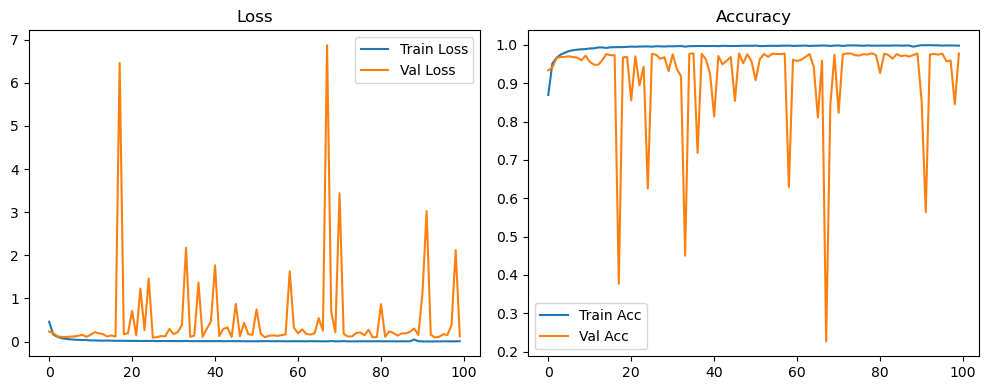

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5475, Acc: 0.8440 | Val Loss: 0.3261, Acc: 0.9107


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2839, Acc: 0.9189 | Val Loss: 0.1725, Acc: 0.9480


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1996, Acc: 0.9401 | Val Loss: 0.1678, Acc: 0.9516


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9557 | Val Loss: 0.1423, Acc: 0.9587


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1222, Acc: 0.9615 | Val Loss: 0.1104, Acc: 0.9674


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9674 | Val Loss: 0.1088, Acc: 0.9678


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0877, Acc: 0.9726 | Val Loss: 0.1099, Acc: 0.9693


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9755 | Val Loss: 0.1008, Acc: 0.9703


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9774 | Val Loss: 0.1045, Acc: 0.9722


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9803 | Val Loss: 0.1043, Acc: 0.9717


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9821 | Val Loss: 0.1018, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9835 | Val Loss: 0.1040, Acc: 0.9712


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9851 | Val Loss: 0.1071, Acc: 0.9708


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9860 | Val Loss: 0.0982, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9865 | Val Loss: 0.1032, Acc: 0.9744


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9866 | Val Loss: 0.0874, Acc: 0.9748


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.1110, Acc: 0.9758


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9890 | Val Loss: 0.0940, Acc: 0.9771


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0980, Acc: 0.9757


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9905 | Val Loss: 0.1029, Acc: 0.9774


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.0974, Acc: 0.9754


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0929, Acc: 0.9761


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9914 | Val Loss: 0.0833, Acc: 0.9761


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9916 | Val Loss: 0.0939, Acc: 0.9772


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0962, Acc: 0.9776


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9926 | Val Loss: 0.1072, Acc: 0.9788


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.0883, Acc: 0.9784


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9924 | Val Loss: 0.0934, Acc: 0.9775


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9927 | Val Loss: 0.0971, Acc: 0.9787


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9931 | Val Loss: 0.0857, Acc: 0.9788


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.1103, Acc: 0.9770


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9943 | Val Loss: 0.0820, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.1084, Acc: 0.9781


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1111, Acc: 0.9756


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0783, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9940 | Val Loss: 0.0900, Acc: 0.9780


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1013, Acc: 0.9783


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.0731, Acc: 0.9794


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0851, Acc: 0.9788


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1009, Acc: 0.9790


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0694, Acc: 0.9791


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1108, Acc: 0.9787


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1097, Acc: 0.9791


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1133, Acc: 0.9802


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1048, Acc: 0.9785


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9957 | Val Loss: 0.1049, Acc: 0.9805


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9955 | Val Loss: 0.0967, Acc: 0.9779


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.1152, Acc: 0.9793


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9958 | Val Loss: 0.0828, Acc: 0.9784


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.1134, Acc: 0.9784


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1061, Acc: 0.9792


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.0754, Acc: 0.9792


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.0788, Acc: 0.9798


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.0954, Acc: 0.9790


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.0956, Acc: 0.9785


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1338, Acc: 0.9798


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9961 | Val Loss: 0.0878, Acc: 0.9789


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9968 | Val Loss: 0.0870, Acc: 0.9792


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0794, Acc: 0.9788


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.0961, Acc: 0.9790


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9963 | Val Loss: 0.0967, Acc: 0.9784


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0768, Acc: 0.9799


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1495, Acc: 0.9779


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1014, Acc: 0.9807


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1050, Acc: 0.9784


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1174, Acc: 0.9792


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1084, Acc: 0.9792


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.0891, Acc: 0.9791


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.0756, Acc: 0.9800


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1131, Acc: 0.9800


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1438, Acc: 0.9789


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9972 | Val Loss: 0.1036, Acc: 0.9805


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1160, Acc: 0.9802


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0922, Acc: 0.9788


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.0916, Acc: 0.9783


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1412, Acc: 0.9798


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9967 | Val Loss: 0.1159, Acc: 0.9793


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1433, Acc: 0.9807


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1166, Acc: 0.9786


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9974 | Val Loss: 0.1146, Acc: 0.9805


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1300, Acc: 0.9812


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1226, Acc: 0.9782


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1396, Acc: 0.9801


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0815, Acc: 0.9785


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.0941, Acc: 0.9804


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0799, Acc: 0.9792


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9972 | Val Loss: 0.1344, Acc: 0.9798


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1122, Acc: 0.9782


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9976 | Val Loss: 0.1562, Acc: 0.9795


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1028, Acc: 0.9803


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9975 | Val Loss: 0.1042, Acc: 0.9786


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.0886, Acc: 0.9794


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1867, Acc: 0.9798


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0085, Acc: 0.9973 | Val Loss: 0.1203, Acc: 0.9790


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1115, Acc: 0.9782


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1372, Acc: 0.9798


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9974 | Val Loss: 0.1161, Acc: 0.9789


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.0934, Acc: 0.9795


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9972 | Val Loss: 0.1043, Acc: 0.9808


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1218, Acc: 0.9790


Final Test Loss: 0.1081 Accuracy: 0.9803


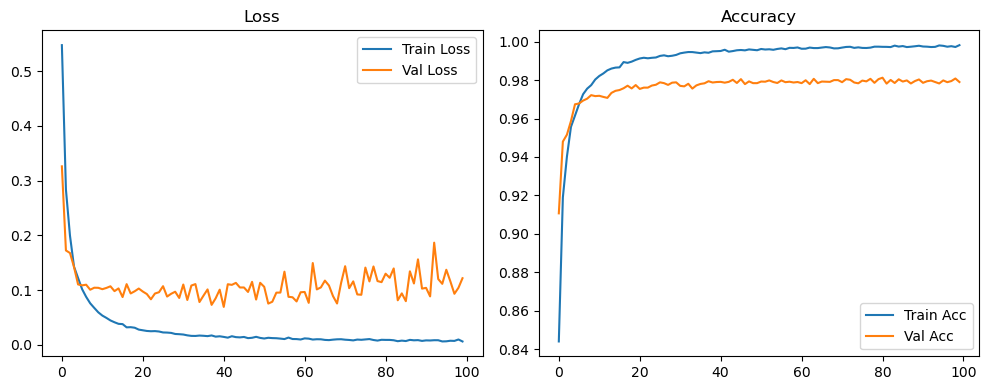

🚀 Running: batch64_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6957, Acc: 0.8057 | Val Loss: 0.3969, Acc: 0.8913


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4075, Acc: 0.8848 | Val Loss: 0.2361, Acc: 0.9332


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2857, Acc: 0.9163 | Val Loss: 0.1724, Acc: 0.9479


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2189, Acc: 0.9340 | Val Loss: 0.1603, Acc: 0.9553


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1818, Acc: 0.9451 | Val Loss: 0.1388, Acc: 0.9611


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1582, Acc: 0.9515 | Val Loss: 0.1229, Acc: 0.9650


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9566 | Val Loss: 0.1201, Acc: 0.9653


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1230, Acc: 0.9616 | Val Loss: 0.1104, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1110, Acc: 0.9649 | Val Loss: 0.0978, Acc: 0.9726


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1070, Acc: 0.9659 | Val Loss: 0.0896, Acc: 0.9716


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0953, Acc: 0.9691 | Val Loss: 0.1009, Acc: 0.9729


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9708 | Val Loss: 0.0869, Acc: 0.9756


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9744 | Val Loss: 0.0942, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9756 | Val Loss: 0.0853, Acc: 0.9748


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9766 | Val Loss: 0.0974, Acc: 0.9737


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9775 | Val Loss: 0.0881, Acc: 0.9761


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9781 | Val Loss: 0.0887, Acc: 0.9739


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0617, Acc: 0.9800 | Val Loss: 0.0836, Acc: 0.9777


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9805 | Val Loss: 0.0785, Acc: 0.9762


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9821 | Val Loss: 0.0838, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9829 | Val Loss: 0.0999, Acc: 0.9760


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9828 | Val Loss: 0.0848, Acc: 0.9765


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9848 | Val Loss: 0.0818, Acc: 0.9760


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9841 | Val Loss: 0.0913, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.0808, Acc: 0.9776


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9858 | Val Loss: 0.0933, Acc: 0.9779


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9858 | Val Loss: 0.0808, Acc: 0.9782


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9850 | Val Loss: 0.0996, Acc: 0.9789


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9877 | Val Loss: 0.0918, Acc: 0.9775


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9873 | Val Loss: 0.0919, Acc: 0.9784


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.0943, Acc: 0.9783


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9880 | Val Loss: 0.0917, Acc: 0.9787


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.0977, Acc: 0.9787


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9882 | Val Loss: 0.0848, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9891 | Val Loss: 0.0884, Acc: 0.9795


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9885 | Val Loss: 0.1000, Acc: 0.9779


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9900 | Val Loss: 0.1038, Acc: 0.9787


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9899 | Val Loss: 0.0943, Acc: 0.9790


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0836, Acc: 0.9793


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0973, Acc: 0.9798


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9903 | Val Loss: 0.0687, Acc: 0.9794


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.0871, Acc: 0.9789


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9903 | Val Loss: 0.0857, Acc: 0.9793


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.0840, Acc: 0.9788


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9903 | Val Loss: 0.0814, Acc: 0.9797


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.1074, Acc: 0.9796


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0768, Acc: 0.9792


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9910 | Val Loss: 0.0815, Acc: 0.9801


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9909 | Val Loss: 0.0948, Acc: 0.9804


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0796, Acc: 0.9801


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.1021, Acc: 0.9808


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0259, Acc: 0.9917 | Val Loss: 0.0715, Acc: 0.9801


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9925 | Val Loss: 0.0863, Acc: 0.9808


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9919 | Val Loss: 0.1300, Acc: 0.9792


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9920 | Val Loss: 0.1000, Acc: 0.9815


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.0811, Acc: 0.9812


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9916 | Val Loss: 0.0750, Acc: 0.9802


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9922 | Val Loss: 0.0903, Acc: 0.9809


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0243, Acc: 0.9920 | Val Loss: 0.0990, Acc: 0.9795


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0262, Acc: 0.9917 | Val Loss: 0.0717, Acc: 0.9800


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9922 | Val Loss: 0.0657, Acc: 0.9807


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9929 | Val Loss: 0.1153, Acc: 0.9809


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.0925, Acc: 0.9798


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9922 | Val Loss: 0.1212, Acc: 0.9795


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0234, Acc: 0.9926 | Val Loss: 0.0678, Acc: 0.9808


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0221, Acc: 0.9931 | Val Loss: 0.0882, Acc: 0.9797


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9932 | Val Loss: 0.0667, Acc: 0.9815


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0215, Acc: 0.9931 | Val Loss: 0.1156, Acc: 0.9806


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9936 | Val Loss: 0.0769, Acc: 0.9817


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9939 | Val Loss: 0.1162, Acc: 0.9809


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0213, Acc: 0.9932 | Val Loss: 0.0734, Acc: 0.9811


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9935 | Val Loss: 0.0991, Acc: 0.9793


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9941 | Val Loss: 0.0963, Acc: 0.9802


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9933 | Val Loss: 0.1211, Acc: 0.9800


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.0936, Acc: 0.9806


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9934 | Val Loss: 0.1912, Acc: 0.9813


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.1270, Acc: 0.9816


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0214, Acc: 0.9935 | Val Loss: 0.0962, Acc: 0.9803


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9943 | Val Loss: 0.1076, Acc: 0.9805


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9940 | Val Loss: 0.0842, Acc: 0.9799


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9938 | Val Loss: 0.0878, Acc: 0.9813


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9940 | Val Loss: 0.0832, Acc: 0.9810


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9941 | Val Loss: 0.1286, Acc: 0.9818


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9944 | Val Loss: 0.0850, Acc: 0.9805


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9939 | Val Loss: 0.0892, Acc: 0.9812


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9944 | Val Loss: 0.1550, Acc: 0.9797


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9942 | Val Loss: 0.1143, Acc: 0.9807


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9948 | Val Loss: 0.0936, Acc: 0.9819


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.0917, Acc: 0.9832


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9949 | Val Loss: 0.0747, Acc: 0.9813


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0197, Acc: 0.9946 | Val Loss: 0.0895, Acc: 0.9808


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.1108, Acc: 0.9811


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0782, Acc: 0.9820


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9945 | Val Loss: 0.0925, Acc: 0.9812


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9946 | Val Loss: 0.0699, Acc: 0.9809


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9952 | Val Loss: 0.1134, Acc: 0.9807


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9953 | Val Loss: 0.1018, Acc: 0.9812


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9942 | Val Loss: 0.0981, Acc: 0.9816


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9947 | Val Loss: 0.1268, Acc: 0.9802


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9938 | Val Loss: 0.0947, Acc: 0.9794


Final Test Loss: 0.0746 Accuracy: 0.9831


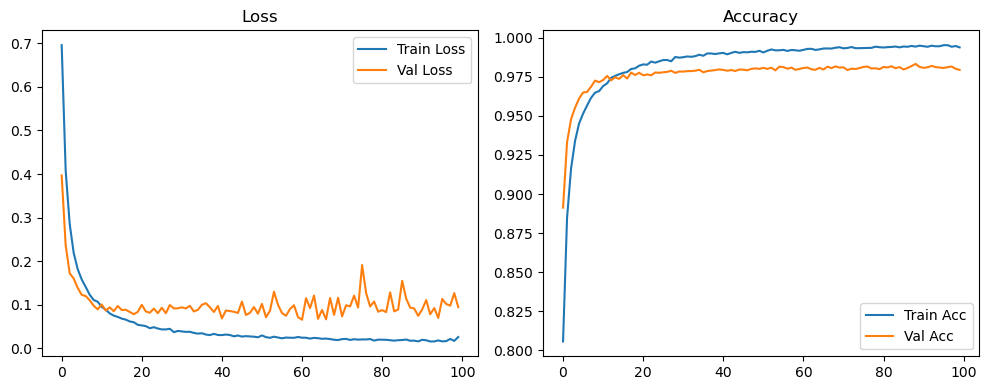

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4596, Acc: 0.8694 | Val Loss: 0.2314, Acc: 0.9337


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1629, Acc: 0.9517 | Val Loss: 0.1936, Acc: 0.9415


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1101, Acc: 0.9662 | Val Loss: 0.1226, Acc: 0.9650


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9748 | Val Loss: 0.1065, Acc: 0.9687


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9796 | Val Loss: 0.1047, Acc: 0.9686


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9840 | Val Loss: 0.1136, Acc: 0.9704


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9862 | Val Loss: 0.1179, Acc: 0.9682


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9875 | Val Loss: 0.1344, Acc: 0.9667


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 0.1577, Acc: 0.9599


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9890 | Val Loss: 0.1089, Acc: 0.9717


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9908 | Val Loss: 0.1586, Acc: 0.9557


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9909 | Val Loss: 0.2168, Acc: 0.9485


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.1916, Acc: 0.9480


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.1702, Acc: 0.9597


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.1171, Acc: 0.9760


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.1419, Acc: 0.9732


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.1142, Acc: 0.9730


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 6.4568, Acc: 0.3766


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1689, Acc: 0.9670


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.1902, Acc: 0.9689


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9956 | Val Loss: 0.7114, Acc: 0.8553


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9951 | Val Loss: 0.1428, Acc: 0.9702


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 1.2292, Acc: 0.8946


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.2631, Acc: 0.9432


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 1.4611, Acc: 0.6252


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9954 | Val Loss: 0.0910, Acc: 0.9765


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1044, Acc: 0.9743


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1261, Acc: 0.9635


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1207, Acc: 0.9677


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.2938, Acc: 0.9316


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.1715, Acc: 0.9754


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.2191, Acc: 0.9370


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.3805, Acc: 0.9187


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 2.1773, Acc: 0.4502


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1100, Acc: 0.9766


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1361, Acc: 0.9780


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 1.3673, Acc: 0.7183


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1105, Acc: 0.9766


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.2941, Acc: 0.9623


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.4663, Acc: 0.9252


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 1.7667, Acc: 0.8136


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1262, Acc: 0.9708


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.2943, Acc: 0.9495


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.3275, Acc: 0.9584


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1053, Acc: 0.9683


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.8737, Acc: 0.8541


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1236, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.4340, Acc: 0.9521


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1725, Acc: 0.9755


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1542, Acc: 0.9573


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1365, Acc: 0.9798


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1707, Acc: 0.9762


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1153, Acc: 0.9785


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1334, Acc: 0.9791


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1170, Acc: 0.9794


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1517, Acc: 0.9796


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1324, Acc: 0.9808


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.3547, Acc: 0.9530


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1488, Acc: 0.9788


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1036, Acc: 0.9810


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.2239, Acc: 0.9796


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1087, Acc: 0.9705


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1493, Acc: 0.9782


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1231, Acc: 0.9729


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1224, Acc: 0.9706


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1257, Acc: 0.9772


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.2027, Acc: 0.9701


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1199, Acc: 0.9773


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1589, Acc: 0.9793


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1534, Acc: 0.9788


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 11.6944, Acc: 0.1112


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.1972, Acc: 0.9784


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1548, Acc: 0.9794


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1328, Acc: 0.9792


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1978, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1959, Acc: 0.9798


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1045, Acc: 0.9768


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2069, Acc: 0.9753


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1807, Acc: 0.9786


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1827, Acc: 0.9768


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1300, Acc: 0.9790


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1498, Acc: 0.9807


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1430, Acc: 0.9811


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1384, Acc: 0.9795


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1392, Acc: 0.9736


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.2627, Acc: 0.9776


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1288, Acc: 0.9783


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1825, Acc: 0.9813


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1818, Acc: 0.9807


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1380, Acc: 0.9807


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2013, Acc: 0.9798


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1943, Acc: 0.9806


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2138, Acc: 0.9799


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1790, Acc: 0.9807


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1382, Acc: 0.9808


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1740, Acc: 0.9814


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1832, Acc: 0.9808


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1632, Acc: 0.9807


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1308, Acc: 0.9798


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1914, Acc: 0.9806


Final Test Loss: 0.1828 Accuracy: 0.9813


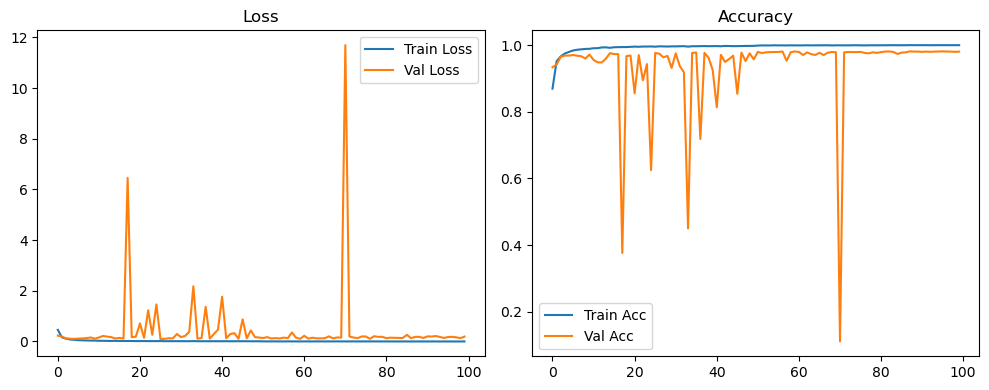

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5473, Acc: 0.8441 | Val Loss: 0.3264, Acc: 0.9106


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2734, Acc: 0.9204 | Val Loss: 0.1796, Acc: 0.9438


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1867, Acc: 0.9438 | Val Loss: 0.1584, Acc: 0.9531


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1380, Acc: 0.9578 | Val Loss: 0.1450, Acc: 0.9585


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1195, Acc: 0.9613 | Val Loss: 0.1144, Acc: 0.9661


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0978, Acc: 0.9690 | Val Loss: 0.1164, Acc: 0.9668


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0801, Acc: 0.9747 | Val Loss: 0.1168, Acc: 0.9683


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0710, Acc: 0.9771 | Val Loss: 0.1219, Acc: 0.9668


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0618, Acc: 0.9802 | Val Loss: 0.1056, Acc: 0.9727


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0596, Acc: 0.9806 | Val Loss: 0.0996, Acc: 0.9730


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0497, Acc: 0.9842 | Val Loss: 0.1053, Acc: 0.9711


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9853 | Val Loss: 0.1020, Acc: 0.9732


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9870 | Val Loss: 0.1064, Acc: 0.9730


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0394, Acc: 0.9873 | Val Loss: 0.1423, Acc: 0.9723


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0376, Acc: 0.9876 | Val Loss: 0.1120, Acc: 0.9734


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0330, Acc: 0.9896 | Val Loss: 0.1039, Acc: 0.9765


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9895 | Val Loss: 0.1054, Acc: 0.9750


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9898 | Val Loss: 0.1097, Acc: 0.9732


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9902 | Val Loss: 0.1106, Acc: 0.9744


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9906 | Val Loss: 0.0984, Acc: 0.9763


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0254, Acc: 0.9915 | Val Loss: 0.1172, Acc: 0.9763


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9916 | Val Loss: 0.1128, Acc: 0.9781


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9928 | Val Loss: 0.0932, Acc: 0.9763


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9922 | Val Loss: 0.1013, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9930 | Val Loss: 0.1221, Acc: 0.9763


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9926 | Val Loss: 0.0983, Acc: 0.9797


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0199, Acc: 0.9934 | Val Loss: 0.0930, Acc: 0.9751


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9936 | Val Loss: 0.1330, Acc: 0.9762


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1240, Acc: 0.9752


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9933 | Val Loss: 0.0979, Acc: 0.9777


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.0886, Acc: 0.9772


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9953 | Val Loss: 0.1128, Acc: 0.9778


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9936 | Val Loss: 0.0930, Acc: 0.9758


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9945 | Val Loss: 0.0850, Acc: 0.9784


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.0761, Acc: 0.9759


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.1326, Acc: 0.9775


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.1394, Acc: 0.9774


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1179, Acc: 0.9783


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0152, Acc: 0.9952 | Val Loss: 0.1135, Acc: 0.9783


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9952 | Val Loss: 0.1532, Acc: 0.9772


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1182, Acc: 0.9788


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.0827, Acc: 0.9773


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9959 | Val Loss: 0.2131, Acc: 0.9782


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1224, Acc: 0.9781


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.1043, Acc: 0.9796


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1767, Acc: 0.9788


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9958 | Val Loss: 0.1183, Acc: 0.9775


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.1054, Acc: 0.9787


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.1421, Acc: 0.9790


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.1514, Acc: 0.9799


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1059, Acc: 0.9820


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0833, Acc: 0.9812


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1325, Acc: 0.9806


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.0946, Acc: 0.9822


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1222, Acc: 0.9811


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1062, Acc: 0.9807


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1452, Acc: 0.9814


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1469, Acc: 0.9808


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1082, Acc: 0.9810


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.0835, Acc: 0.9798


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1026, Acc: 0.9800


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1629, Acc: 0.9814


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.0936, Acc: 0.9808


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1175, Acc: 0.9804


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1023, Acc: 0.9802


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1406, Acc: 0.9795


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1261, Acc: 0.9800


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1047, Acc: 0.9811


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1324, Acc: 0.9805


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.0970, Acc: 0.9798


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1492, Acc: 0.9809


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1383, Acc: 0.9800


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1130, Acc: 0.9810


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1039, Acc: 0.9816


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1368, Acc: 0.9793


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1400, Acc: 0.9798


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.0927, Acc: 0.9802


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1802, Acc: 0.9802


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1196, Acc: 0.9807


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1682, Acc: 0.9807


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1075, Acc: 0.9811


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1000, Acc: 0.9814


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.0934, Acc: 0.9817


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9996 | Val Loss: 0.1373, Acc: 0.9812


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1318, Acc: 0.9812


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1447, Acc: 0.9819


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1204, Acc: 0.9812


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1206, Acc: 0.9813


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1517, Acc: 0.9807


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1351, Acc: 0.9811


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1552, Acc: 0.9819


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1100, Acc: 0.9810


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1268, Acc: 0.9818


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1782, Acc: 0.9816


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.0848, Acc: 0.9806


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1305, Acc: 0.9814


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1313, Acc: 0.9812


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1492, Acc: 0.9814


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1392, Acc: 0.9814


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1567, Acc: 0.9816


Final Test Loss: 0.1316 Accuracy: 0.9835


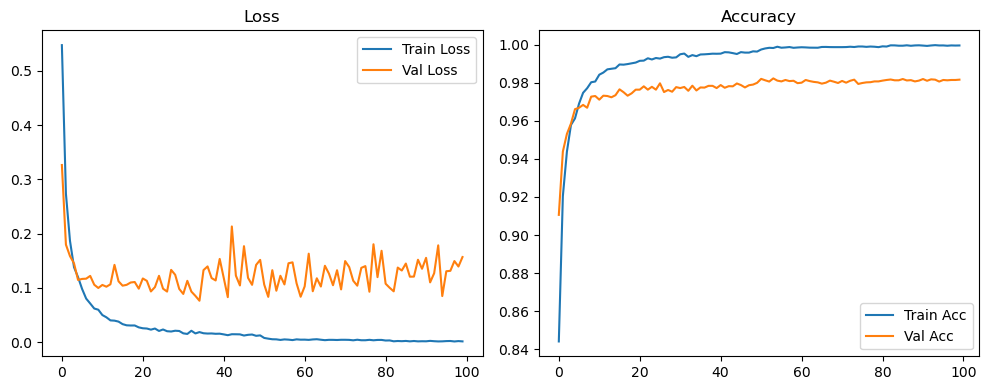

🚀 Running: batch64_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6957, Acc: 0.8057 | Val Loss: 0.3969, Acc: 0.8913


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4075, Acc: 0.8848 | Val Loss: 0.2361, Acc: 0.9332


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2857, Acc: 0.9163 | Val Loss: 0.1724, Acc: 0.9479


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2189, Acc: 0.9340 | Val Loss: 0.1603, Acc: 0.9553


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1818, Acc: 0.9451 | Val Loss: 0.1388, Acc: 0.9611


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1582, Acc: 0.9515 | Val Loss: 0.1229, Acc: 0.9650


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9566 | Val Loss: 0.1201, Acc: 0.9653


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1230, Acc: 0.9616 | Val Loss: 0.1104, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1110, Acc: 0.9649 | Val Loss: 0.0978, Acc: 0.9726


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1070, Acc: 0.9659 | Val Loss: 0.0896, Acc: 0.9716


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0953, Acc: 0.9691 | Val Loss: 0.1009, Acc: 0.9729


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9708 | Val Loss: 0.0869, Acc: 0.9756


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9744 | Val Loss: 0.0942, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9756 | Val Loss: 0.0853, Acc: 0.9748


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9766 | Val Loss: 0.0974, Acc: 0.9737


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9775 | Val Loss: 0.0881, Acc: 0.9761


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9781 | Val Loss: 0.0887, Acc: 0.9739


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0617, Acc: 0.9800 | Val Loss: 0.0836, Acc: 0.9777


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9805 | Val Loss: 0.0785, Acc: 0.9762


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9821 | Val Loss: 0.0838, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9829 | Val Loss: 0.0999, Acc: 0.9760


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9828 | Val Loss: 0.0848, Acc: 0.9765


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9848 | Val Loss: 0.0818, Acc: 0.9760


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9841 | Val Loss: 0.0913, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.0808, Acc: 0.9776


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9858 | Val Loss: 0.0933, Acc: 0.9779


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9858 | Val Loss: 0.0808, Acc: 0.9782


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9850 | Val Loss: 0.0996, Acc: 0.9789


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9877 | Val Loss: 0.0918, Acc: 0.9775


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9873 | Val Loss: 0.0919, Acc: 0.9784


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.0943, Acc: 0.9783


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9880 | Val Loss: 0.0917, Acc: 0.9787


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.0977, Acc: 0.9787


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9882 | Val Loss: 0.0848, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9891 | Val Loss: 0.0884, Acc: 0.9795


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9885 | Val Loss: 0.1000, Acc: 0.9779


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9900 | Val Loss: 0.1038, Acc: 0.9787


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9899 | Val Loss: 0.0943, Acc: 0.9790


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0836, Acc: 0.9793


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0973, Acc: 0.9798


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9903 | Val Loss: 0.0687, Acc: 0.9794


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.0871, Acc: 0.9789


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9903 | Val Loss: 0.0857, Acc: 0.9793


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.0840, Acc: 0.9788


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9903 | Val Loss: 0.0814, Acc: 0.9797


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.1074, Acc: 0.9796


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0768, Acc: 0.9792


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9910 | Val Loss: 0.0815, Acc: 0.9801


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9909 | Val Loss: 0.0948, Acc: 0.9804


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0796, Acc: 0.9801


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.0833, Acc: 0.9819


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.0729, Acc: 0.9808


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0871, Acc: 0.9823


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.0840, Acc: 0.9812


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0834, Acc: 0.9813


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0734, Acc: 0.9821


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0894, Acc: 0.9821


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0970, Acc: 0.9819


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.0644, Acc: 0.9808


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.0933, Acc: 0.9810


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.1102, Acc: 0.9814


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0842, Acc: 0.9813


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0903, Acc: 0.9827


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0937, Acc: 0.9821


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0781, Acc: 0.9815


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1154, Acc: 0.9822


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1074, Acc: 0.9815


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1112, Acc: 0.9819


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0892, Acc: 0.9811


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1078, Acc: 0.9818


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.0801, Acc: 0.9828


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1043, Acc: 0.9814


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1101, Acc: 0.9820


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0890, Acc: 0.9822


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0995, Acc: 0.9815


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1151, Acc: 0.9814


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0849, Acc: 0.9814


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0999, Acc: 0.9819


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1006, Acc: 0.9827


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0671, Acc: 0.9817


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9961 | Val Loss: 0.0943, Acc: 0.9824


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1037, Acc: 0.9833


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1003, Acc: 0.9828


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9975 | Val Loss: 0.1027, Acc: 0.9828


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0970, Acc: 0.9823


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0857, Acc: 0.9827


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1046, Acc: 0.9826


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1183, Acc: 0.9825


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1056, Acc: 0.9828


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1107, Acc: 0.9825


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.0998, Acc: 0.9822


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1018, Acc: 0.9820


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1175, Acc: 0.9820


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1016, Acc: 0.9827


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1069, Acc: 0.9823


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.0968, Acc: 0.9826


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.0971, Acc: 0.9818


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1107, Acc: 0.9823


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1247, Acc: 0.9825


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.0872, Acc: 0.9827


Final Test Loss: 0.0756 Accuracy: 0.9843


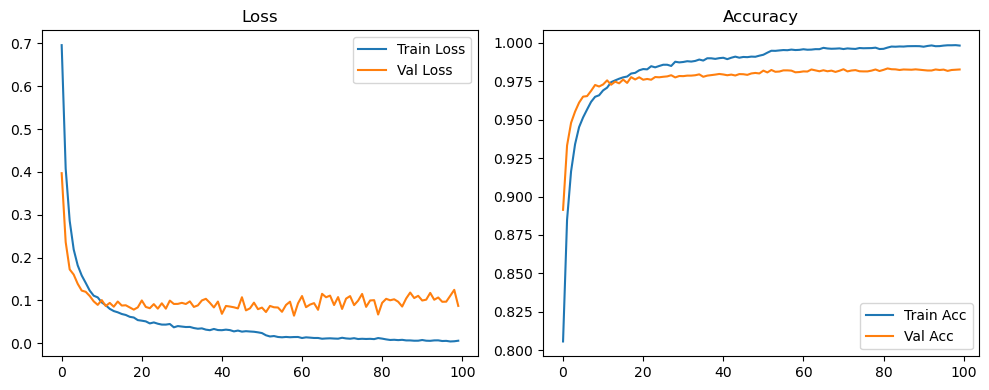

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4596, Acc: 0.8694 | Val Loss: 0.2314, Acc: 0.9337


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1629, Acc: 0.9517 | Val Loss: 0.1936, Acc: 0.9415


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1101, Acc: 0.9662 | Val Loss: 0.1226, Acc: 0.9650


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9748 | Val Loss: 0.1065, Acc: 0.9687


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9796 | Val Loss: 0.1047, Acc: 0.9686


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9840 | Val Loss: 0.1136, Acc: 0.9704


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9862 | Val Loss: 0.1179, Acc: 0.9682


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9875 | Val Loss: 0.1344, Acc: 0.9667


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 0.1577, Acc: 0.9599


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9890 | Val Loss: 0.1089, Acc: 0.9717


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9908 | Val Loss: 0.1586, Acc: 0.9557


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9909 | Val Loss: 0.2168, Acc: 0.9485


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.1916, Acc: 0.9480


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.1702, Acc: 0.9597


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.1171, Acc: 0.9760


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.1419, Acc: 0.9732


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.1142, Acc: 0.9730


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 6.4568, Acc: 0.3766


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1689, Acc: 0.9670


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.1902, Acc: 0.9689


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9956 | Val Loss: 0.7114, Acc: 0.8553


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9951 | Val Loss: 0.1428, Acc: 0.9702


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 1.2292, Acc: 0.8946


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.2631, Acc: 0.9432


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 1.4611, Acc: 0.6252


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9954 | Val Loss: 0.0910, Acc: 0.9765


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1044, Acc: 0.9743


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1261, Acc: 0.9635


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1207, Acc: 0.9677


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.2938, Acc: 0.9316


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.1715, Acc: 0.9754


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.2191, Acc: 0.9370


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.3805, Acc: 0.9187


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 2.1773, Acc: 0.4502


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1100, Acc: 0.9766


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1361, Acc: 0.9780


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 1.3673, Acc: 0.7183


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1105, Acc: 0.9766


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.2941, Acc: 0.9623


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.4663, Acc: 0.9252


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 1.7667, Acc: 0.8136


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1262, Acc: 0.9708


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.2943, Acc: 0.9495


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.3275, Acc: 0.9584


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1053, Acc: 0.9683


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.8737, Acc: 0.8541


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1236, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.4340, Acc: 0.9521


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1725, Acc: 0.9755


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1542, Acc: 0.9573


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1365, Acc: 0.9798


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1707, Acc: 0.9762


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1153, Acc: 0.9785


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1334, Acc: 0.9791


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1170, Acc: 0.9794


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1517, Acc: 0.9796


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1324, Acc: 0.9808


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.3547, Acc: 0.9530


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1488, Acc: 0.9788


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1036, Acc: 0.9810


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.2239, Acc: 0.9796


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1087, Acc: 0.9705


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1493, Acc: 0.9782


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1231, Acc: 0.9729


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1224, Acc: 0.9706


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1257, Acc: 0.9772


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.2027, Acc: 0.9701


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1199, Acc: 0.9773


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1589, Acc: 0.9793


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1534, Acc: 0.9788


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 11.6944, Acc: 0.1112


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.1972, Acc: 0.9784


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1548, Acc: 0.9794


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1328, Acc: 0.9792


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1978, Acc: 0.9792


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1959, Acc: 0.9798


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1045, Acc: 0.9768


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2069, Acc: 0.9753


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1807, Acc: 0.9786


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1827, Acc: 0.9768


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1272, Acc: 0.9796


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1411, Acc: 0.9799


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1383, Acc: 0.9803


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1571, Acc: 0.9806


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1633, Acc: 0.9802


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1669, Acc: 0.9811


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1324, Acc: 0.9801


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1749, Acc: 0.9815


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1590, Acc: 0.9808


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1639, Acc: 0.9813


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2190, Acc: 0.9810


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2406, Acc: 0.9814


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2196, Acc: 0.9788


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2210, Acc: 0.9812


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1741, Acc: 0.9814


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1946, Acc: 0.9818


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2121, Acc: 0.9810


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2549, Acc: 0.9814


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2749, Acc: 0.9810


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2697, Acc: 0.9813


Final Test Loss: 0.2357 Accuracy: 0.9819


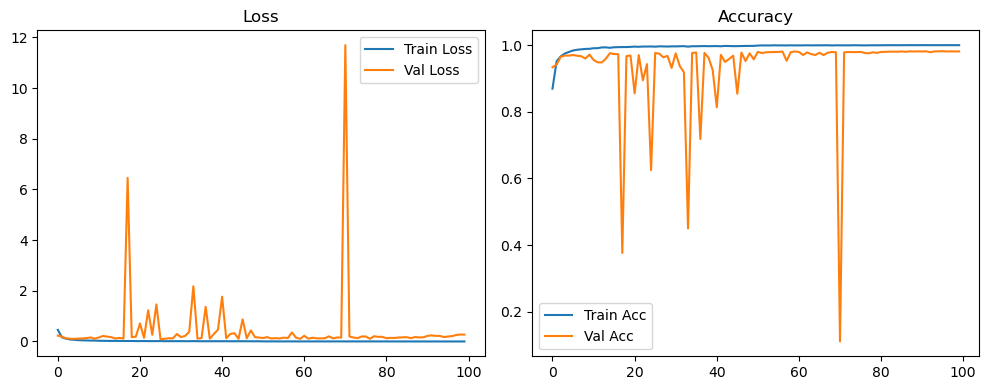

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5475, Acc: 0.8440 | Val Loss: 0.3261, Acc: 0.9107


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2839, Acc: 0.9189 | Val Loss: 0.1725, Acc: 0.9480


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1996, Acc: 0.9401 | Val Loss: 0.1678, Acc: 0.9516


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9557 | Val Loss: 0.1423, Acc: 0.9587


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1222, Acc: 0.9615 | Val Loss: 0.1104, Acc: 0.9674


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9674 | Val Loss: 0.1088, Acc: 0.9678


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0877, Acc: 0.9726 | Val Loss: 0.1099, Acc: 0.9693


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9755 | Val Loss: 0.1008, Acc: 0.9703


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9774 | Val Loss: 0.1045, Acc: 0.9722


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9803 | Val Loss: 0.1043, Acc: 0.9717


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9821 | Val Loss: 0.1018, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9835 | Val Loss: 0.1040, Acc: 0.9712


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9851 | Val Loss: 0.1071, Acc: 0.9708


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9860 | Val Loss: 0.0982, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9865 | Val Loss: 0.1032, Acc: 0.9744


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9866 | Val Loss: 0.0874, Acc: 0.9748


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.1110, Acc: 0.9758


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9890 | Val Loss: 0.0940, Acc: 0.9771


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0980, Acc: 0.9757


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9905 | Val Loss: 0.1029, Acc: 0.9774


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.0974, Acc: 0.9754


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0929, Acc: 0.9761


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9914 | Val Loss: 0.0833, Acc: 0.9761


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9916 | Val Loss: 0.0939, Acc: 0.9772


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0962, Acc: 0.9776


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9926 | Val Loss: 0.1072, Acc: 0.9788


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.0883, Acc: 0.9784


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9924 | Val Loss: 0.0934, Acc: 0.9775


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9927 | Val Loss: 0.0971, Acc: 0.9787


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9931 | Val Loss: 0.0857, Acc: 0.9788


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.1103, Acc: 0.9770


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9943 | Val Loss: 0.0820, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.1084, Acc: 0.9781


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1111, Acc: 0.9756


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0783, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9940 | Val Loss: 0.0900, Acc: 0.9780


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1013, Acc: 0.9783


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.0731, Acc: 0.9794


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0851, Acc: 0.9788


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1009, Acc: 0.9790


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0694, Acc: 0.9791


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1108, Acc: 0.9787


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1097, Acc: 0.9791


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1133, Acc: 0.9802


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1048, Acc: 0.9785


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9957 | Val Loss: 0.1049, Acc: 0.9805


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9955 | Val Loss: 0.0967, Acc: 0.9779


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.1152, Acc: 0.9793


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9958 | Val Loss: 0.0828, Acc: 0.9784


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.1134, Acc: 0.9784


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.0952, Acc: 0.9808


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1006, Acc: 0.9810


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.0975, Acc: 0.9808


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0946, Acc: 0.9791


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1050, Acc: 0.9808


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0976, Acc: 0.9806


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0833, Acc: 0.9804


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1262, Acc: 0.9812


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1041, Acc: 0.9807


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1179, Acc: 0.9800


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1049, Acc: 0.9805


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.0809, Acc: 0.9815


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1154, Acc: 0.9816


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1371, Acc: 0.9814


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.0693, Acc: 0.9808


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1079, Acc: 0.9807


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1146, Acc: 0.9816


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1387, Acc: 0.9813


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1216, Acc: 0.9819


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1071, Acc: 0.9812


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1269, Acc: 0.9811


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1401, Acc: 0.9788


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1529, Acc: 0.9802


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1035, Acc: 0.9811


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1214, Acc: 0.9801


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1202, Acc: 0.9814


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1364, Acc: 0.9805


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.0977, Acc: 0.9803


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1027, Acc: 0.9803


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1030, Acc: 0.9814


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.0864, Acc: 0.9816


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1149, Acc: 0.9812


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1112, Acc: 0.9809


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1286, Acc: 0.9819


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1063, Acc: 0.9818


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1276, Acc: 0.9825


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1171, Acc: 0.9815


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1149, Acc: 0.9818


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1199, Acc: 0.9816


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1250, Acc: 0.9816


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1141, Acc: 0.9818


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.1127, Acc: 0.9819


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1139, Acc: 0.9817


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1224, Acc: 0.9818


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1197, Acc: 0.9823


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1098, Acc: 0.9827


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1193, Acc: 0.9821


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1304, Acc: 0.9821


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1340, Acc: 0.9812


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1186, Acc: 0.9819


Final Test Loss: 0.1111 Accuracy: 0.9834


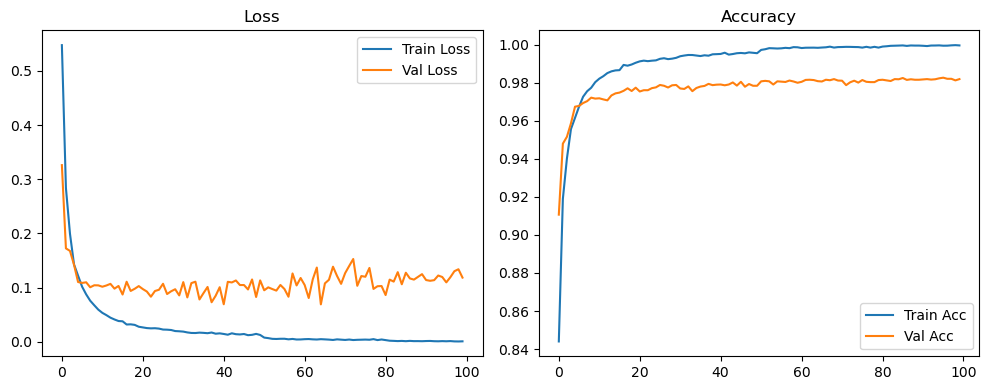

🚀 Running: batch64_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6957, Acc: 0.8057 | Val Loss: 0.3969, Acc: 0.8913


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4075, Acc: 0.8848 | Val Loss: 0.2361, Acc: 0.9332


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2857, Acc: 0.9163 | Val Loss: 0.1724, Acc: 0.9479


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2189, Acc: 0.9340 | Val Loss: 0.1603, Acc: 0.9553


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1818, Acc: 0.9451 | Val Loss: 0.1388, Acc: 0.9611


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1582, Acc: 0.9515 | Val Loss: 0.1229, Acc: 0.9650


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9566 | Val Loss: 0.1201, Acc: 0.9653


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1230, Acc: 0.9616 | Val Loss: 0.1104, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1110, Acc: 0.9649 | Val Loss: 0.0978, Acc: 0.9726


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1070, Acc: 0.9659 | Val Loss: 0.0896, Acc: 0.9716


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0953, Acc: 0.9691 | Val Loss: 0.1009, Acc: 0.9729


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9708 | Val Loss: 0.0869, Acc: 0.9756


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9744 | Val Loss: 0.0942, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9756 | Val Loss: 0.0853, Acc: 0.9748


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9766 | Val Loss: 0.0974, Acc: 0.9737


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9775 | Val Loss: 0.0881, Acc: 0.9761


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9781 | Val Loss: 0.0887, Acc: 0.9739


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0617, Acc: 0.9800 | Val Loss: 0.0836, Acc: 0.9777


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9805 | Val Loss: 0.0785, Acc: 0.9762


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9821 | Val Loss: 0.0838, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9829 | Val Loss: 0.0999, Acc: 0.9760


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9828 | Val Loss: 0.0848, Acc: 0.9765


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9848 | Val Loss: 0.0818, Acc: 0.9760


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9841 | Val Loss: 0.0913, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.0808, Acc: 0.9776


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9858 | Val Loss: 0.0933, Acc: 0.9779


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9858 | Val Loss: 0.0808, Acc: 0.9782


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9850 | Val Loss: 0.0996, Acc: 0.9789


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9877 | Val Loss: 0.0918, Acc: 0.9775


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9873 | Val Loss: 0.0919, Acc: 0.9784


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.0943, Acc: 0.9783


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9880 | Val Loss: 0.0917, Acc: 0.9787


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.0977, Acc: 0.9787


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9882 | Val Loss: 0.0848, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9891 | Val Loss: 0.0884, Acc: 0.9795


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9885 | Val Loss: 0.1000, Acc: 0.9779


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9900 | Val Loss: 0.1038, Acc: 0.9787


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9899 | Val Loss: 0.0943, Acc: 0.9790


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0836, Acc: 0.9793


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0973, Acc: 0.9798


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9903 | Val Loss: 0.0687, Acc: 0.9794


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.0871, Acc: 0.9789


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9903 | Val Loss: 0.0857, Acc: 0.9793


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.0840, Acc: 0.9788


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9903 | Val Loss: 0.0814, Acc: 0.9797


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.1074, Acc: 0.9796


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0768, Acc: 0.9792


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9910 | Val Loss: 0.0815, Acc: 0.9801


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9909 | Val Loss: 0.0948, Acc: 0.9804


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0796, Acc: 0.9801


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.0833, Acc: 0.9819


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9936 | Val Loss: 0.0729, Acc: 0.9808


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9949 | Val Loss: 0.0871, Acc: 0.9823


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9948 | Val Loss: 0.0840, Acc: 0.9812


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0834, Acc: 0.9813


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.0734, Acc: 0.9821


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9952 | Val Loss: 0.0894, Acc: 0.9821


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.0970, Acc: 0.9819


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.0644, Acc: 0.9808


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.0933, Acc: 0.9810


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.1102, Acc: 0.9814


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.0842, Acc: 0.9813


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.0903, Acc: 0.9827


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.0937, Acc: 0.9821


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9959 | Val Loss: 0.0781, Acc: 0.9815


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1154, Acc: 0.9822


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1074, Acc: 0.9815


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1112, Acc: 0.9819


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.0892, Acc: 0.9811


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1078, Acc: 0.9818


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9960 | Val Loss: 0.0801, Acc: 0.9828


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1043, Acc: 0.9814


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1101, Acc: 0.9820


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.0890, Acc: 0.9822


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0995, Acc: 0.9815


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1151, Acc: 0.9814


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.0849, Acc: 0.9814


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9966 | Val Loss: 0.0999, Acc: 0.9819


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1006, Acc: 0.9827


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.0671, Acc: 0.9817


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9962 | Val Loss: 0.0916, Acc: 0.9822


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.0994, Acc: 0.9834


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1002, Acc: 0.9832


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9975 | Val Loss: 0.0976, Acc: 0.9831


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.0912, Acc: 0.9823


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.0907, Acc: 0.9822


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1006, Acc: 0.9828


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1064, Acc: 0.9830


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1163, Acc: 0.9824


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1057, Acc: 0.9828


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0871, Acc: 0.9826


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1055, Acc: 0.9827


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1043, Acc: 0.9823


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.0974, Acc: 0.9829


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9980 | Val Loss: 0.1013, Acc: 0.9825


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9981 | Val Loss: 0.0946, Acc: 0.9830


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.0887, Acc: 0.9825


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1168, Acc: 0.9821


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1130, Acc: 0.9824


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.0995, Acc: 0.9826


Final Test Loss: 0.0862 Accuracy: 0.9843


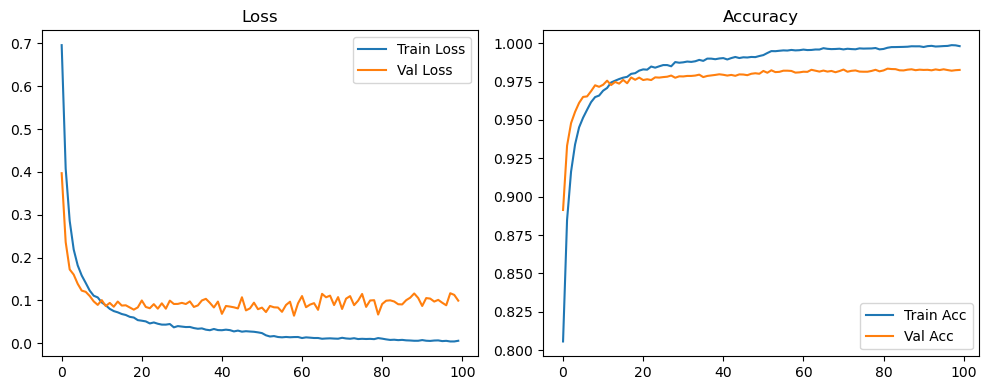

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4596, Acc: 0.8694 | Val Loss: 0.2314, Acc: 0.9337


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1629, Acc: 0.9517 | Val Loss: 0.1936, Acc: 0.9415


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1101, Acc: 0.9662 | Val Loss: 0.1226, Acc: 0.9650


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0777, Acc: 0.9748 | Val Loss: 0.1065, Acc: 0.9687


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0642, Acc: 0.9796 | Val Loss: 0.1047, Acc: 0.9686


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0517, Acc: 0.9840 | Val Loss: 0.1136, Acc: 0.9704


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0443, Acc: 0.9862 | Val Loss: 0.1179, Acc: 0.9682


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0392, Acc: 0.9875 | Val Loss: 0.1344, Acc: 0.9667


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9886 | Val Loss: 0.1577, Acc: 0.9599


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0353, Acc: 0.9890 | Val Loss: 0.1089, Acc: 0.9717


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9908 | Val Loss: 0.1586, Acc: 0.9557


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0263, Acc: 0.9909 | Val Loss: 0.2168, Acc: 0.9485


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0222, Acc: 0.9931 | Val Loss: 0.1916, Acc: 0.9480


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.1702, Acc: 0.9597


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0239, Acc: 0.9920 | Val Loss: 0.1171, Acc: 0.9760


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0204, Acc: 0.9936 | Val Loss: 0.1419, Acc: 0.9732


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0182, Acc: 0.9940 | Val Loss: 0.1142, Acc: 0.9730


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 6.4568, Acc: 0.3766


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9943 | Val Loss: 0.1689, Acc: 0.9670


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9949 | Val Loss: 0.1902, Acc: 0.9689


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9956 | Val Loss: 0.7114, Acc: 0.8553


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9951 | Val Loss: 0.1428, Acc: 0.9702


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9958 | Val Loss: 1.2292, Acc: 0.8946


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.2631, Acc: 0.9432


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9960 | Val Loss: 1.4611, Acc: 0.6252


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9954 | Val Loss: 0.0910, Acc: 0.9765


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1044, Acc: 0.9743


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1261, Acc: 0.9635


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1207, Acc: 0.9677


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.2938, Acc: 0.9316


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9963 | Val Loss: 0.1715, Acc: 0.9754


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.2191, Acc: 0.9370


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9970 | Val Loss: 0.3805, Acc: 0.9187


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 2.1773, Acc: 0.4502


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9967 | Val Loss: 0.1100, Acc: 0.9766


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1361, Acc: 0.9780


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 1.3673, Acc: 0.7183


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1105, Acc: 0.9766


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.2941, Acc: 0.9623


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.4663, Acc: 0.9252


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 1.7667, Acc: 0.8136


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1262, Acc: 0.9708


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.2943, Acc: 0.9495


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.3275, Acc: 0.9584


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1053, Acc: 0.9683


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.8737, Acc: 0.8541


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9973 | Val Loss: 0.1236, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.4340, Acc: 0.9521


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1725, Acc: 0.9755


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1542, Acc: 0.9573


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1248, Acc: 0.9788


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1259, Acc: 0.9799


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1299, Acc: 0.9810


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1907, Acc: 0.9745


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1488, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1675, Acc: 0.9804


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1995, Acc: 0.9774


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1195, Acc: 0.9814


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1720, Acc: 0.9810


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1478, Acc: 0.9816


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1261, Acc: 0.9811


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1325, Acc: 0.9815


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1736, Acc: 0.9818


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1434, Acc: 0.9807


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1490, Acc: 0.9805


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1199, Acc: 0.9828


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1597, Acc: 0.9817


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1073, Acc: 0.9818


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1279, Acc: 0.9784


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1198, Acc: 0.9819


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1989, Acc: 0.9700


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1310, Acc: 0.9791


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1555, Acc: 0.9814


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1264, Acc: 0.9817


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1688, Acc: 0.9808


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1846, Acc: 0.9817


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1976, Acc: 0.9806


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1516, Acc: 0.9807


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1614, Acc: 0.9799


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1500, Acc: 0.9808


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1539, Acc: 0.9812


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1431, Acc: 0.9810


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1552, Acc: 0.9816


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1563, Acc: 0.9817


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1413, Acc: 0.9804


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1821, Acc: 0.9807


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1523, Acc: 0.9816


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1601, Acc: 0.9818


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1786, Acc: 0.9812


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1949, Acc: 0.9813


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1556, Acc: 0.9815


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1810, Acc: 0.9823


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1955, Acc: 0.9823


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2286, Acc: 0.9809


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2032, Acc: 0.9817


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2162, Acc: 0.9818


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2232, Acc: 0.9807


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.2255, Acc: 0.9811


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1976, Acc: 0.9812


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1500, Acc: 0.9816


Final Test Loss: 0.1372 Accuracy: 0.9834


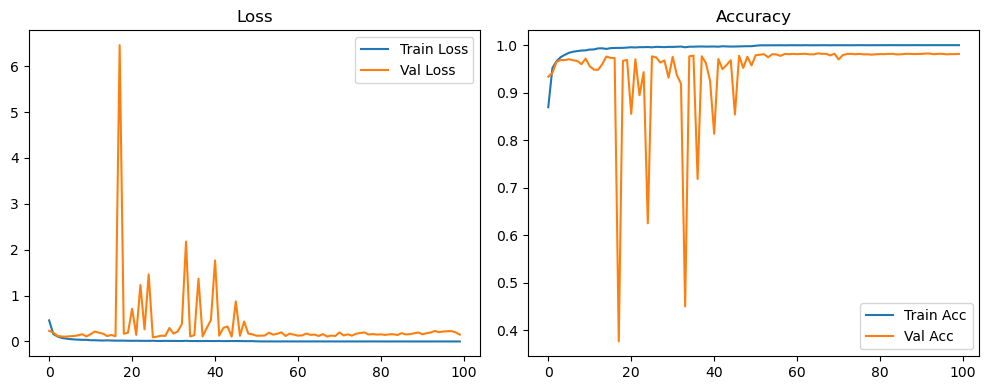

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5475, Acc: 0.8440 | Val Loss: 0.3261, Acc: 0.9107


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2839, Acc: 0.9189 | Val Loss: 0.1725, Acc: 0.9480


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1996, Acc: 0.9401 | Val Loss: 0.1678, Acc: 0.9516


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1429, Acc: 0.9557 | Val Loss: 0.1423, Acc: 0.9587


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1222, Acc: 0.9615 | Val Loss: 0.1104, Acc: 0.9674


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1018, Acc: 0.9674 | Val Loss: 0.1088, Acc: 0.9678


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0877, Acc: 0.9726 | Val Loss: 0.1099, Acc: 0.9693


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0760, Acc: 0.9755 | Val Loss: 0.1008, Acc: 0.9703


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9774 | Val Loss: 0.1045, Acc: 0.9722


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9803 | Val Loss: 0.1043, Acc: 0.9717


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0536, Acc: 0.9821 | Val Loss: 0.1018, Acc: 0.9718


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0493, Acc: 0.9835 | Val Loss: 0.1040, Acc: 0.9712


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0447, Acc: 0.9851 | Val Loss: 0.1071, Acc: 0.9708


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0413, Acc: 0.9860 | Val Loss: 0.0982, Acc: 0.9733


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0385, Acc: 0.9865 | Val Loss: 0.1032, Acc: 0.9744


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0380, Acc: 0.9866 | Val Loss: 0.0874, Acc: 0.9748


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.1110, Acc: 0.9758


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0324, Acc: 0.9890 | Val Loss: 0.0940, Acc: 0.9771


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9896 | Val Loss: 0.0980, Acc: 0.9757


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0279, Acc: 0.9905 | Val Loss: 0.1029, Acc: 0.9774


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.0974, Acc: 0.9754


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0929, Acc: 0.9761


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9914 | Val Loss: 0.0833, Acc: 0.9761


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9916 | Val Loss: 0.0939, Acc: 0.9772


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0245, Acc: 0.9918 | Val Loss: 0.0962, Acc: 0.9776


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9926 | Val Loss: 0.1072, Acc: 0.9788


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9929 | Val Loss: 0.0883, Acc: 0.9784


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0219, Acc: 0.9924 | Val Loss: 0.0934, Acc: 0.9775


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9927 | Val Loss: 0.0971, Acc: 0.9787


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9931 | Val Loss: 0.0857, Acc: 0.9788


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9939 | Val Loss: 0.1103, Acc: 0.9770


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9943 | Val Loss: 0.0820, Acc: 0.9768


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.1084, Acc: 0.9781


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9946 | Val Loss: 0.1111, Acc: 0.9756


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.0783, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9940 | Val Loss: 0.0900, Acc: 0.9780


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.1013, Acc: 0.9783


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9942 | Val Loss: 0.0731, Acc: 0.9794


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.0851, Acc: 0.9788


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1009, Acc: 0.9790


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.0694, Acc: 0.9791


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1108, Acc: 0.9787


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.1097, Acc: 0.9791


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1133, Acc: 0.9802


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1048, Acc: 0.9785


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0145, Acc: 0.9957 | Val Loss: 0.1049, Acc: 0.9805


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9955 | Val Loss: 0.0967, Acc: 0.9779


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9960 | Val Loss: 0.1152, Acc: 0.9793


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0148, Acc: 0.9958 | Val Loss: 0.0828, Acc: 0.9784


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.1134, Acc: 0.9784


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.0979, Acc: 0.9812


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.0973, Acc: 0.9811


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1060, Acc: 0.9814


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1014, Acc: 0.9818


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1030, Acc: 0.9811


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1031, Acc: 0.9813


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1066, Acc: 0.9813


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1057, Acc: 0.9817


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1152, Acc: 0.9810


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.0995, Acc: 0.9820


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.0981, Acc: 0.9823


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.0979, Acc: 0.9827


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1156, Acc: 0.9819


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1298, Acc: 0.9822


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.0746, Acc: 0.9818


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1166, Acc: 0.9822


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1055, Acc: 0.9824


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1211, Acc: 0.9824


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1322, Acc: 0.9826


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1096, Acc: 0.9823


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1216, Acc: 0.9826


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1164, Acc: 0.9821


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1198, Acc: 0.9831


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1383, Acc: 0.9821


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1209, Acc: 0.9822


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1289, Acc: 0.9832


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.1215, Acc: 0.9825


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1045, Acc: 0.9832


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1042, Acc: 0.9835


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1137, Acc: 0.9823


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1300, Acc: 0.9826


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1077, Acc: 0.9825


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1284, Acc: 0.9825


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1276, Acc: 0.9822


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1076, Acc: 0.9818


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1264, Acc: 0.9824


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1221, Acc: 0.9827


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1137, Acc: 0.9830


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1180, Acc: 0.9830


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9994 | Val Loss: 0.1089, Acc: 0.9825


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1199, Acc: 0.9833


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9993 | Val Loss: 0.1162, Acc: 0.9820


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1160, Acc: 0.9819


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1250, Acc: 0.9828


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1247, Acc: 0.9822


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1176, Acc: 0.9824


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1147, Acc: 0.9822


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1255, Acc: 0.9825


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1372, Acc: 0.9818


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1184, Acc: 0.9823


Final Test Loss: 0.1066 Accuracy: 0.9844


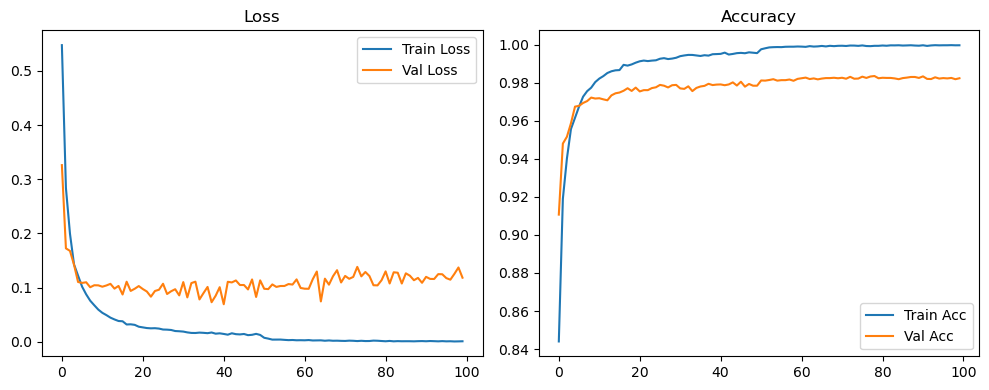

🚀 Running: batch64_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6957, Acc: 0.8057 | Val Loss: 0.3969, Acc: 0.8913


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.4075, Acc: 0.8848 | Val Loss: 0.2361, Acc: 0.9332


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2857, Acc: 0.9163 | Val Loss: 0.1724, Acc: 0.9479


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2189, Acc: 0.9340 | Val Loss: 0.1603, Acc: 0.9553


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1818, Acc: 0.9451 | Val Loss: 0.1388, Acc: 0.9611


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1582, Acc: 0.9515 | Val Loss: 0.1229, Acc: 0.9650


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1409, Acc: 0.9566 | Val Loss: 0.1201, Acc: 0.9653


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1230, Acc: 0.9616 | Val Loss: 0.1104, Acc: 0.9688


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1110, Acc: 0.9649 | Val Loss: 0.0978, Acc: 0.9726


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1070, Acc: 0.9659 | Val Loss: 0.0896, Acc: 0.9716


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0953, Acc: 0.9691 | Val Loss: 0.1009, Acc: 0.9729


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0887, Acc: 0.9708 | Val Loss: 0.0869, Acc: 0.9756


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0804, Acc: 0.9744 | Val Loss: 0.0942, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0752, Acc: 0.9756 | Val Loss: 0.0853, Acc: 0.9748


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0723, Acc: 0.9766 | Val Loss: 0.0974, Acc: 0.9737


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0683, Acc: 0.9775 | Val Loss: 0.0881, Acc: 0.9761


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0660, Acc: 0.9781 | Val Loss: 0.0887, Acc: 0.9739


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0617, Acc: 0.9800 | Val Loss: 0.0836, Acc: 0.9777


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0601, Acc: 0.9805 | Val Loss: 0.0785, Acc: 0.9762


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0541, Acc: 0.9821 | Val Loss: 0.0838, Acc: 0.9776


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9829 | Val Loss: 0.0999, Acc: 0.9760


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0511, Acc: 0.9828 | Val Loss: 0.0848, Acc: 0.9765


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0463, Acc: 0.9848 | Val Loss: 0.0818, Acc: 0.9760


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0486, Acc: 0.9841 | Val Loss: 0.0913, Acc: 0.9778


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.0808, Acc: 0.9776


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0436, Acc: 0.9858 | Val Loss: 0.0933, Acc: 0.9779


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0435, Acc: 0.9858 | Val Loss: 0.0808, Acc: 0.9782


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0450, Acc: 0.9850 | Val Loss: 0.0996, Acc: 0.9789


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0372, Acc: 0.9877 | Val Loss: 0.0918, Acc: 0.9775


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9873 | Val Loss: 0.0919, Acc: 0.9784


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0390, Acc: 0.9875 | Val Loss: 0.0943, Acc: 0.9783


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9880 | Val Loss: 0.0917, Acc: 0.9787


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0381, Acc: 0.9878 | Val Loss: 0.0977, Acc: 0.9787


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0355, Acc: 0.9882 | Val Loss: 0.0848, Acc: 0.9789


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9891 | Val Loss: 0.0884, Acc: 0.9795


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0348, Acc: 0.9885 | Val Loss: 0.1000, Acc: 0.9779


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9900 | Val Loss: 0.1038, Acc: 0.9787


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9899 | Val Loss: 0.0943, Acc: 0.9790


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0334, Acc: 0.9896 | Val Loss: 0.0836, Acc: 0.9793


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0308, Acc: 0.9900 | Val Loss: 0.0973, Acc: 0.9798


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0305, Acc: 0.9903 | Val Loss: 0.0687, Acc: 0.9794


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9894 | Val Loss: 0.0871, Acc: 0.9789


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9903 | Val Loss: 0.0857, Acc: 0.9793


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.0840, Acc: 0.9788


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9903 | Val Loss: 0.0814, Acc: 0.9797


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.1074, Acc: 0.9796


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.0768, Acc: 0.9792


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9910 | Val Loss: 0.0815, Acc: 0.9801


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9909 | Val Loss: 0.0948, Acc: 0.9804


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.0796, Acc: 0.9801


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.0785, Acc: 0.9815


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.0819, Acc: 0.9810


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.0828, Acc: 0.9824


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.0792, Acc: 0.9828


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9957 | Val Loss: 0.0847, Acc: 0.9822


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9955 | Val Loss: 0.0748, Acc: 0.9828


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.0707, Acc: 0.9827


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.0971, Acc: 0.9826


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.0780, Acc: 0.9822


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0852, Acc: 0.9822


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.0984, Acc: 0.9822


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.0852, Acc: 0.9828


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0894, Acc: 0.9825


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.0868, Acc: 0.9825


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.0949, Acc: 0.9830


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1001, Acc: 0.9827


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.1029, Acc: 0.9822


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.0940, Acc: 0.9830


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.0983, Acc: 0.9825


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.0946, Acc: 0.9824


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9968 | Val Loss: 0.0697, Acc: 0.9835


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9972 | Val Loss: 0.1066, Acc: 0.9826


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.0883, Acc: 0.9832


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.0833, Acc: 0.9828


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1009, Acc: 0.9824


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.0851, Acc: 0.9825


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.0910, Acc: 0.9824


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1081, Acc: 0.9822


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9977 | Val Loss: 0.1093, Acc: 0.9829


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.0849, Acc: 0.9826


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.0959, Acc: 0.9829


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.0932, Acc: 0.9825


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1020, Acc: 0.9826


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1001, Acc: 0.9825


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.0835, Acc: 0.9817


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.0849, Acc: 0.9814


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.0936, Acc: 0.9818


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1099, Acc: 0.9824


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0920, Acc: 0.9822


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1004, Acc: 0.9822


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.0889, Acc: 0.9824


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1026, Acc: 0.9821


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1011, Acc: 0.9825


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.0878, Acc: 0.9819


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.0962, Acc: 0.9822


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0972, Acc: 0.9822


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1032, Acc: 0.9821


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1119, Acc: 0.9822


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1101, Acc: 0.9822


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1061, Acc: 0.9822


Final Test Loss: 0.0928 Accuracy: 0.9844


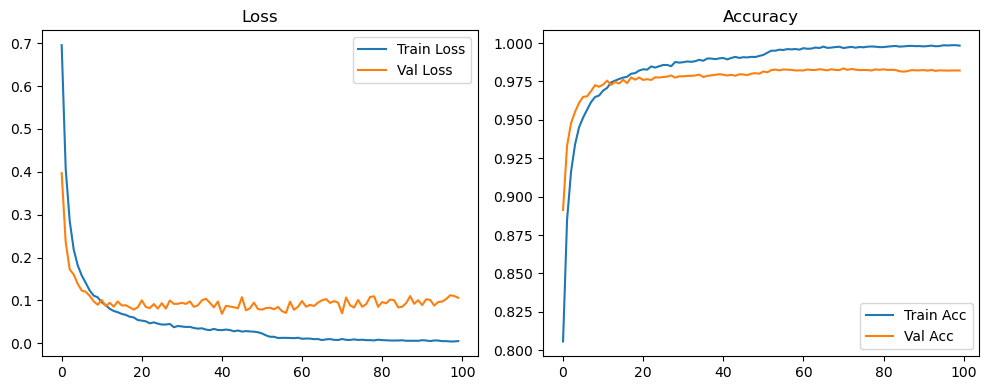

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4480, Acc: 0.8658 | Val Loss: 0.3202, Acc: 0.9065


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2492, Acc: 0.9278 | Val Loss: 0.1951, Acc: 0.9429


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1762, Acc: 0.9483 | Val Loss: 0.1641, Acc: 0.9527


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1136, Acc: 0.9648 | Val Loss: 0.1421, Acc: 0.9614


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0908, Acc: 0.9723 | Val Loss: 0.1126, Acc: 0.9692


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9789 | Val Loss: 0.1448, Acc: 0.9627


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9826 | Val Loss: 0.1288, Acc: 0.9692


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9836 | Val Loss: 0.1628, Acc: 0.9652


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9853 | Val Loss: 0.1364, Acc: 0.9718


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9886 | Val Loss: 0.1338, Acc: 0.9705


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9902 | Val Loss: 0.1508, Acc: 0.9691


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9904 | Val Loss: 0.1157, Acc: 0.9760


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9916 | Val Loss: 0.1461, Acc: 0.9730


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9930 | Val Loss: 0.1264, Acc: 0.9750


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.1350, Acc: 0.9736


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9931 | Val Loss: 0.1654, Acc: 0.9684


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9929 | Val Loss: 0.1420, Acc: 0.9748


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9943 | Val Loss: 0.1256, Acc: 0.9765


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1179, Acc: 0.9764


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9938 | Val Loss: 0.1396, Acc: 0.9752


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.1371, Acc: 0.9756


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1382, Acc: 0.9761


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.1552, Acc: 0.9726


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.1451, Acc: 0.9758


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1285, Acc: 0.9755


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1142, Acc: 0.9774


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.1433, Acc: 0.9753


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9965 | Val Loss: 0.1434, Acc: 0.9756


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9967 | Val Loss: 0.1376, Acc: 0.9728


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1261, Acc: 0.9771


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1357, Acc: 0.9773


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1346, Acc: 0.9772


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1523, Acc: 0.9749


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1294, Acc: 0.9773


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1348, Acc: 0.9773


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1274, Acc: 0.9768


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.1750, Acc: 0.9728


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1328, Acc: 0.9772


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1446, Acc: 0.9782


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1738, Acc: 0.9738


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1562, Acc: 0.9743


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1392, Acc: 0.9751


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1317, Acc: 0.9779


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1740, Acc: 0.9738


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1335, Acc: 0.9757


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1536, Acc: 0.9768


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1502, Acc: 0.9778


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9975 | Val Loss: 0.1414, Acc: 0.9779


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1581, Acc: 0.9745


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1321, Acc: 0.9768


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1376, Acc: 0.9768


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1431, Acc: 0.9768


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1337, Acc: 0.9768


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1313, Acc: 0.9762


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1447, Acc: 0.9772


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9984 | Val Loss: 0.1292, Acc: 0.9790


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1351, Acc: 0.9756


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1408, Acc: 0.9761


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1339, Acc: 0.9769


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1312, Acc: 0.9776


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1199, Acc: 0.9793


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1433, Acc: 0.9777


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1380, Acc: 0.9782


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1074, Acc: 0.9779


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1135, Acc: 0.9802


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9986 | Val Loss: 0.1139, Acc: 0.9805


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1302, Acc: 0.9791


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1330, Acc: 0.9771


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1241, Acc: 0.9771


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1278, Acc: 0.9779


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1268, Acc: 0.9800


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1342, Acc: 0.9770


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1218, Acc: 0.9776


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1249, Acc: 0.9803


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1432, Acc: 0.9776


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1339, Acc: 0.9769


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1365, Acc: 0.9794


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1572, Acc: 0.9750


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1187, Acc: 0.9798


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1991, Acc: 0.9719


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1390, Acc: 0.9771


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1435, Acc: 0.9788


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1337, Acc: 0.9789


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1453, Acc: 0.9782


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1515, Acc: 0.9777


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1388, Acc: 0.9766


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1490, Acc: 0.9757


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1189, Acc: 0.9752


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1810, Acc: 0.9762


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1588, Acc: 0.9783


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1721, Acc: 0.9754


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1554, Acc: 0.9765


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1428, Acc: 0.9770


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1252, Acc: 0.9796


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1145, Acc: 0.9778


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1493, Acc: 0.9797


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1442, Acc: 0.9765


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1275, Acc: 0.9775


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1214, Acc: 0.9804


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1703, Acc: 0.9752


Final Test Loss: 0.1398 Accuracy: 0.9781


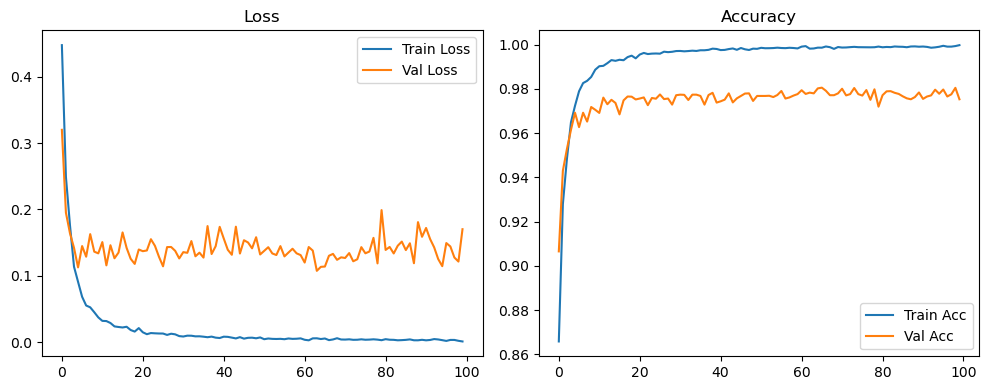

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4546, Acc: 0.8636 | Val Loss: 0.2245, Acc: 0.9341


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2333, Acc: 0.9311 | Val Loss: 0.1469, Acc: 0.9565


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1725, Acc: 0.9469 | Val Loss: 0.1359, Acc: 0.9603


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1414, Acc: 0.9564 | Val Loss: 0.1317, Acc: 0.9629


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1204, Acc: 0.9629 | Val Loss: 0.1068, Acc: 0.9688


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1077, Acc: 0.9664 | Val Loss: 0.1016, Acc: 0.9695


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0908, Acc: 0.9714 | Val Loss: 0.1046, Acc: 0.9708


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0783, Acc: 0.9754 | Val Loss: 0.1069, Acc: 0.9719


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0763, Acc: 0.9756 | Val Loss: 0.0992, Acc: 0.9727


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9772 | Val Loss: 0.0976, Acc: 0.9745


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0625, Acc: 0.9796 | Val Loss: 0.0888, Acc: 0.9739


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0572, Acc: 0.9814 | Val Loss: 0.0961, Acc: 0.9762


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9814 | Val Loss: 0.0928, Acc: 0.9757


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9843 | Val Loss: 0.0901, Acc: 0.9749


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9848 | Val Loss: 0.0867, Acc: 0.9759


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9856 | Val Loss: 0.1052, Acc: 0.9756


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9856 | Val Loss: 0.0924, Acc: 0.9744


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9873 | Val Loss: 0.0989, Acc: 0.9767


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9866 | Val Loss: 0.0871, Acc: 0.9766


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9877 | Val Loss: 0.0899, Acc: 0.9770


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9888 | Val Loss: 0.0937, Acc: 0.9771


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9890 | Val Loss: 0.1028, Acc: 0.9754


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.0985, Acc: 0.9774


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9894 | Val Loss: 0.0860, Acc: 0.9768


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9912 | Val Loss: 0.1076, Acc: 0.9768


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0922, Acc: 0.9777


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0861, Acc: 0.9778


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.0926, Acc: 0.9773


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9913 | Val Loss: 0.1045, Acc: 0.9767


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9909 | Val Loss: 0.0990, Acc: 0.9780


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9921 | Val Loss: 0.0907, Acc: 0.9775


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.1023, Acc: 0.9783


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.1067, Acc: 0.9750


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.0928, Acc: 0.9771


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.0917, Acc: 0.9790


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0969, Acc: 0.9794


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1060, Acc: 0.9778


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.0824, Acc: 0.9789


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0819, Acc: 0.9788


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.1017, Acc: 0.9792


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.1067, Acc: 0.9798


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.1010, Acc: 0.9797


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.1161, Acc: 0.9796


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1022, Acc: 0.9782


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.1170, Acc: 0.9782


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0915, Acc: 0.9785


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0766, Acc: 0.9793


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.1179, Acc: 0.9779


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.1016, Acc: 0.9791


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.1056, Acc: 0.9788


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1101, Acc: 0.9783


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9947 | Val Loss: 0.1070, Acc: 0.9792


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9952 | Val Loss: 0.1012, Acc: 0.9778


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9944 | Val Loss: 0.1135, Acc: 0.9782


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.1309, Acc: 0.9798


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9950 | Val Loss: 0.1177, Acc: 0.9796


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.0774, Acc: 0.9799


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.0938, Acc: 0.9807


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9954 | Val Loss: 0.0666, Acc: 0.9799


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1208, Acc: 0.9788


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.0936, Acc: 0.9792


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9951 | Val Loss: 0.1109, Acc: 0.9782


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1115, Acc: 0.9794


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1125, Acc: 0.9806


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1195, Acc: 0.9780


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.0954, Acc: 0.9733


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.1001, Acc: 0.9794


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9957 | Val Loss: 0.0916, Acc: 0.9787


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9957 | Val Loss: 0.1077, Acc: 0.9788


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9950 | Val Loss: 0.1181, Acc: 0.9789


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9955 | Val Loss: 0.0847, Acc: 0.9800


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9959 | Val Loss: 0.1338, Acc: 0.9783


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1096, Acc: 0.9786


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1010, Acc: 0.9797


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1475, Acc: 0.9790


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9956 | Val Loss: 0.0989, Acc: 0.9788


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1313, Acc: 0.9788


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1109, Acc: 0.9784


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.1032, Acc: 0.9791


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.0949, Acc: 0.9784


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9963 | Val Loss: 0.1058, Acc: 0.9772


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9957 | Val Loss: 0.1223, Acc: 0.9796


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.1361, Acc: 0.9784


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1060, Acc: 0.9795


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9963 | Val Loss: 0.1163, Acc: 0.9792


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1214, Acc: 0.9780


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1263, Acc: 0.9782


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1278, Acc: 0.9784


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9959 | Val Loss: 0.0932, Acc: 0.9784


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9963 | Val Loss: 0.1088, Acc: 0.9799


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9966 | Val Loss: 0.1098, Acc: 0.9780


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.0934, Acc: 0.9787


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9969 | Val Loss: 0.1166, Acc: 0.9772


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1069, Acc: 0.9781


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1117, Acc: 0.9786


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1188, Acc: 0.9795


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0968, Acc: 0.9801


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1288, Acc: 0.9740


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9968 | Val Loss: 0.1101, Acc: 0.9799


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1097, Acc: 0.9768


Final Test Loss: 0.1011 Accuracy: 0.9798


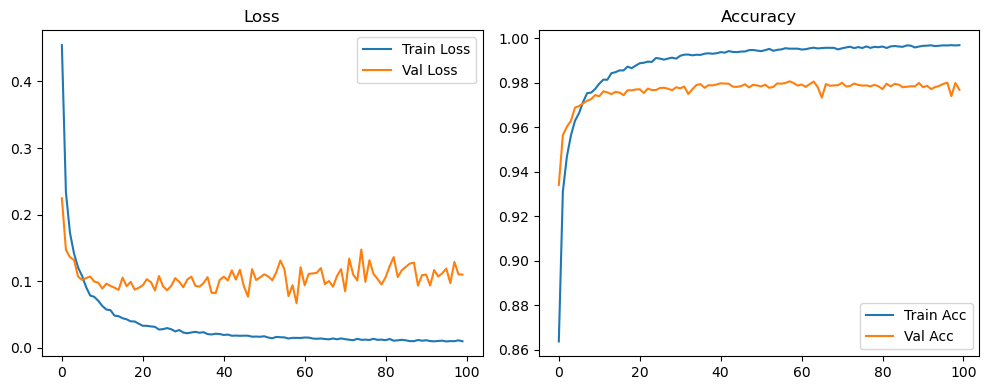

🚀 Running: batch64_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5976, Acc: 0.8174 | Val Loss: 0.3224, Acc: 0.9051


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3785, Acc: 0.8857 | Val Loss: 0.2415, Acc: 0.9281


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2966, Acc: 0.9100 | Val Loss: 0.2148, Acc: 0.9345


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2473, Acc: 0.9259 | Val Loss: 0.1835, Acc: 0.9471


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2127, Acc: 0.9366 | Val Loss: 0.1464, Acc: 0.9568


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1849, Acc: 0.9445 | Val Loss: 0.1426, Acc: 0.9596


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1645, Acc: 0.9505 | Val Loss: 0.1299, Acc: 0.9621


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1468, Acc: 0.9557 | Val Loss: 0.1158, Acc: 0.9670


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1318, Acc: 0.9593 | Val Loss: 0.1173, Acc: 0.9684


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1256, Acc: 0.9607 | Val Loss: 0.1020, Acc: 0.9698


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1121, Acc: 0.9649 | Val Loss: 0.1113, Acc: 0.9672


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1058, Acc: 0.9676 | Val Loss: 0.0965, Acc: 0.9724


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0921, Acc: 0.9709 | Val Loss: 0.0977, Acc: 0.9714


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0895, Acc: 0.9721 | Val Loss: 0.1102, Acc: 0.9729


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9717 | Val Loss: 0.0923, Acc: 0.9734


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0755, Acc: 0.9756 | Val Loss: 0.1031, Acc: 0.9747


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9756 | Val Loss: 0.0998, Acc: 0.9735


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0710, Acc: 0.9775 | Val Loss: 0.0990, Acc: 0.9755


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0667, Acc: 0.9795 | Val Loss: 0.0942, Acc: 0.9764


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9799 | Val Loss: 0.0869, Acc: 0.9765


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0611, Acc: 0.9804 | Val Loss: 0.1016, Acc: 0.9748


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9820 | Val Loss: 0.0957, Acc: 0.9750


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9831 | Val Loss: 0.1117, Acc: 0.9748


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9826 | Val Loss: 0.0882, Acc: 0.9783


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9840 | Val Loss: 0.0981, Acc: 0.9772


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9836 | Val Loss: 0.0937, Acc: 0.9783


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9852 | Val Loss: 0.0925, Acc: 0.9780


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9833 | Val Loss: 0.1041, Acc: 0.9770


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9859 | Val Loss: 0.0798, Acc: 0.9778


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9854 | Val Loss: 0.0910, Acc: 0.9763


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9868 | Val Loss: 0.1091, Acc: 0.9785


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9880 | Val Loss: 0.0831, Acc: 0.9793


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9868 | Val Loss: 0.0865, Acc: 0.9782


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9882 | Val Loss: 0.0948, Acc: 0.9782


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9888 | Val Loss: 0.1133, Acc: 0.9768


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9883 | Val Loss: 0.1205, Acc: 0.9776


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9886 | Val Loss: 0.0997, Acc: 0.9776


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9888 | Val Loss: 0.0933, Acc: 0.9792


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.0926, Acc: 0.9785


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9885 | Val Loss: 0.1007, Acc: 0.9788


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9892 | Val Loss: 0.0947, Acc: 0.9783


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9904 | Val Loss: 0.0948, Acc: 0.9783


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.0970, Acc: 0.9772


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 0.0986, Acc: 0.9776


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9902 | Val Loss: 0.0987, Acc: 0.9780


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.0971, Acc: 0.9795


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9897 | Val Loss: 0.0911, Acc: 0.9788


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.1094, Acc: 0.9778


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9908 | Val Loss: 0.0864, Acc: 0.9794


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.0986, Acc: 0.9788


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0262, Acc: 0.9914 | Val Loss: 0.0926, Acc: 0.9801


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9911 | Val Loss: 0.0853, Acc: 0.9790


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9920 | Val Loss: 0.0804, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9914 | Val Loss: 0.0801, Acc: 0.9800


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9920 | Val Loss: 0.0883, Acc: 0.9796


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0255, Acc: 0.9914 | Val Loss: 0.0815, Acc: 0.9789


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9927 | Val Loss: 0.0845, Acc: 0.9798


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9922 | Val Loss: 0.1126, Acc: 0.9795


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0247, Acc: 0.9917 | Val Loss: 0.0839, Acc: 0.9792


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0250, Acc: 0.9922 | Val Loss: 0.0839, Acc: 0.9801


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9924 | Val Loss: 0.1017, Acc: 0.9790


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9927 | Val Loss: 0.0916, Acc: 0.9794


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0234, Acc: 0.9919 | Val Loss: 0.1030, Acc: 0.9788


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0231, Acc: 0.9925 | Val Loss: 0.1106, Acc: 0.9799


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9931 | Val Loss: 0.0831, Acc: 0.9795


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9929 | Val Loss: 0.0960, Acc: 0.9801


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9935 | Val Loss: 0.0895, Acc: 0.9794


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.1179, Acc: 0.9793


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9930 | Val Loss: 0.0962, Acc: 0.9798


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.1039, Acc: 0.9797


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.0994, Acc: 0.9800


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.1140, Acc: 0.9807


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9937 | Val Loss: 0.0976, Acc: 0.9805


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9938 | Val Loss: 0.0844, Acc: 0.9812


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9943 | Val Loss: 0.1097, Acc: 0.9799


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9940 | Val Loss: 0.0812, Acc: 0.9808


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.0877, Acc: 0.9811


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.1042, Acc: 0.9812


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0969, Acc: 0.9813


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9939 | Val Loss: 0.0898, Acc: 0.9797


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0187, Acc: 0.9941 | Val Loss: 0.1010, Acc: 0.9801


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.1025, Acc: 0.9803


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9941 | Val Loss: 0.0857, Acc: 0.9805


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9947 | Val Loss: 0.0686, Acc: 0.9817


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0839, Acc: 0.9808


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.1187, Acc: 0.9791


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.1133, Acc: 0.9799


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9946 | Val Loss: 0.1169, Acc: 0.9798


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9945 | Val Loss: 0.0943, Acc: 0.9808


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0836, Acc: 0.9800


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.1317, Acc: 0.9787


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.1151, Acc: 0.9804


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.0770, Acc: 0.9810


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.1112, Acc: 0.9811


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.1212, Acc: 0.9804


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1163, Acc: 0.9808


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9955 | Val Loss: 0.1193, Acc: 0.9802


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.0902, Acc: 0.9810


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1234, Acc: 0.9801


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.0950, Acc: 0.9793


Final Test Loss: 0.0893 Accuracy: 0.9808


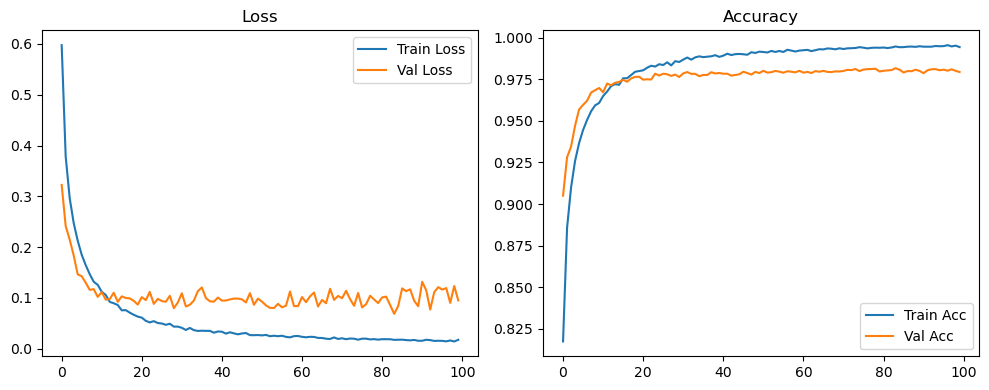

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4480, Acc: 0.8658 | Val Loss: 0.3202, Acc: 0.9065


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2492, Acc: 0.9278 | Val Loss: 0.1951, Acc: 0.9429


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1762, Acc: 0.9483 | Val Loss: 0.1641, Acc: 0.9527


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1136, Acc: 0.9648 | Val Loss: 0.1421, Acc: 0.9614


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0908, Acc: 0.9723 | Val Loss: 0.1126, Acc: 0.9692


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0683, Acc: 0.9789 | Val Loss: 0.1448, Acc: 0.9627


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0551, Acc: 0.9826 | Val Loss: 0.1288, Acc: 0.9692


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9836 | Val Loss: 0.1628, Acc: 0.9652


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0450, Acc: 0.9853 | Val Loss: 0.1364, Acc: 0.9718


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9886 | Val Loss: 0.1338, Acc: 0.9705


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0319, Acc: 0.9902 | Val Loss: 0.1508, Acc: 0.9691


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9904 | Val Loss: 0.1157, Acc: 0.9760


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0287, Acc: 0.9916 | Val Loss: 0.1461, Acc: 0.9730


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9930 | Val Loss: 0.1264, Acc: 0.9750


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.1350, Acc: 0.9736


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9931 | Val Loss: 0.1654, Acc: 0.9684


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0230, Acc: 0.9929 | Val Loss: 0.1420, Acc: 0.9748


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9943 | Val Loss: 0.1256, Acc: 0.9765


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1179, Acc: 0.9764


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9938 | Val Loss: 0.1396, Acc: 0.9752


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9955 | Val Loss: 0.1371, Acc: 0.9756


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9962 | Val Loss: 0.1382, Acc: 0.9761


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9957 | Val Loss: 0.1552, Acc: 0.9726


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9959 | Val Loss: 0.1451, Acc: 0.9758


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1285, Acc: 0.9755


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1142, Acc: 0.9774


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9968 | Val Loss: 0.1433, Acc: 0.9753


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9965 | Val Loss: 0.1434, Acc: 0.9756


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9967 | Val Loss: 0.1376, Acc: 0.9728


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1261, Acc: 0.9771


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1357, Acc: 0.9773


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1346, Acc: 0.9772


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1523, Acc: 0.9749


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1294, Acc: 0.9773


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1348, Acc: 0.9773


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1274, Acc: 0.9768


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.1750, Acc: 0.9728


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1328, Acc: 0.9772


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1446, Acc: 0.9782


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1738, Acc: 0.9738


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1562, Acc: 0.9743


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1392, Acc: 0.9751


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1317, Acc: 0.9779


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1740, Acc: 0.9738


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1335, Acc: 0.9757


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1536, Acc: 0.9768


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9978 | Val Loss: 0.1502, Acc: 0.9778


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9975 | Val Loss: 0.1414, Acc: 0.9779


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1581, Acc: 0.9745


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1321, Acc: 0.9768


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1197, Acc: 0.9782


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1412, Acc: 0.9777


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1168, Acc: 0.9792


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1168, Acc: 0.9792


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1292, Acc: 0.9798


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1269, Acc: 0.9791


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1390, Acc: 0.9798


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1333, Acc: 0.9808


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1212, Acc: 0.9800


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1361, Acc: 0.9789


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1318, Acc: 0.9805


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1351, Acc: 0.9798


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1339, Acc: 0.9802


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1399, Acc: 0.9796


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1493, Acc: 0.9792


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1435, Acc: 0.9792


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1401, Acc: 0.9801


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1497, Acc: 0.9795


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1373, Acc: 0.9801


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1269, Acc: 0.9794


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1302, Acc: 0.9798


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1382, Acc: 0.9810


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1526, Acc: 0.9790


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1362, Acc: 0.9800


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1370, Acc: 0.9806


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1424, Acc: 0.9795


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1314, Acc: 0.9812


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1412, Acc: 0.9814


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1556, Acc: 0.9809


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1390, Acc: 0.9802


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1450, Acc: 0.9808


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1429, Acc: 0.9812


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1413, Acc: 0.9818


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1448, Acc: 0.9812


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1387, Acc: 0.9818


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1403, Acc: 0.9815


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1426, Acc: 0.9815


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1478, Acc: 0.9811


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1416, Acc: 0.9815


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1478, Acc: 0.9804


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1438, Acc: 0.9810


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1473, Acc: 0.9808


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1408, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1420, Acc: 0.9819


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1447, Acc: 0.9820


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1468, Acc: 0.9817


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1465, Acc: 0.9811


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1465, Acc: 0.9812


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1509, Acc: 0.9807


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1566, Acc: 0.9812


Final Test Loss: 0.1461 Accuracy: 0.9820


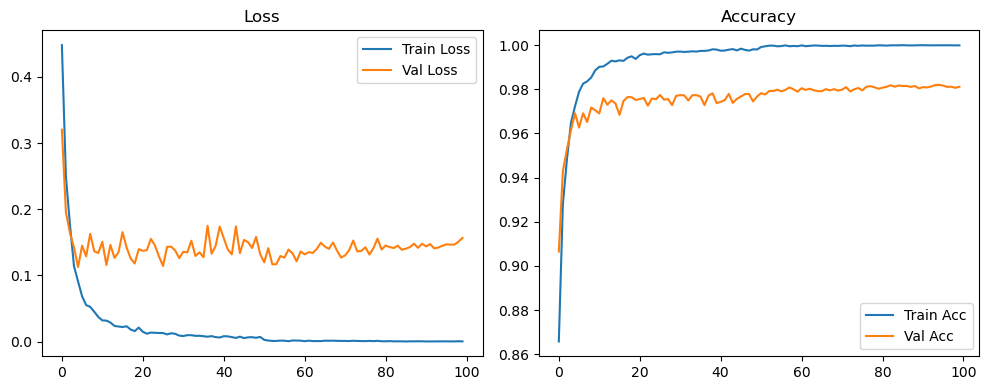

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4546, Acc: 0.8636 | Val Loss: 0.2245, Acc: 0.9341


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2333, Acc: 0.9311 | Val Loss: 0.1469, Acc: 0.9565


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1725, Acc: 0.9469 | Val Loss: 0.1359, Acc: 0.9603


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1414, Acc: 0.9564 | Val Loss: 0.1317, Acc: 0.9629


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1204, Acc: 0.9629 | Val Loss: 0.1068, Acc: 0.9688


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1077, Acc: 0.9664 | Val Loss: 0.1016, Acc: 0.9695


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0908, Acc: 0.9714 | Val Loss: 0.1046, Acc: 0.9708


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0783, Acc: 0.9754 | Val Loss: 0.1069, Acc: 0.9719


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0763, Acc: 0.9756 | Val Loss: 0.0992, Acc: 0.9727


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0704, Acc: 0.9772 | Val Loss: 0.0976, Acc: 0.9745


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0625, Acc: 0.9796 | Val Loss: 0.0888, Acc: 0.9739


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0572, Acc: 0.9814 | Val Loss: 0.0961, Acc: 0.9762


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0563, Acc: 0.9814 | Val Loss: 0.0928, Acc: 0.9757


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0481, Acc: 0.9843 | Val Loss: 0.0901, Acc: 0.9749


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0472, Acc: 0.9848 | Val Loss: 0.0867, Acc: 0.9759


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9856 | Val Loss: 0.1052, Acc: 0.9756


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0425, Acc: 0.9856 | Val Loss: 0.0924, Acc: 0.9744


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0395, Acc: 0.9873 | Val Loss: 0.0989, Acc: 0.9767


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9866 | Val Loss: 0.0871, Acc: 0.9766


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9877 | Val Loss: 0.0899, Acc: 0.9770


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9888 | Val Loss: 0.0937, Acc: 0.9771


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0328, Acc: 0.9890 | Val Loss: 0.1028, Acc: 0.9754


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.0985, Acc: 0.9774


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9894 | Val Loss: 0.0860, Acc: 0.9768


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0272, Acc: 0.9912 | Val Loss: 0.1076, Acc: 0.9768


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0278, Acc: 0.9909 | Val Loss: 0.0922, Acc: 0.9777


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0861, Acc: 0.9778


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0277, Acc: 0.9909 | Val Loss: 0.0926, Acc: 0.9773


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9913 | Val Loss: 0.1045, Acc: 0.9767


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0264, Acc: 0.9909 | Val Loss: 0.0990, Acc: 0.9780


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9921 | Val Loss: 0.0907, Acc: 0.9775


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.1023, Acc: 0.9783


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9927 | Val Loss: 0.1067, Acc: 0.9750


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0237, Acc: 0.9924 | Val Loss: 0.0928, Acc: 0.9771


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.0917, Acc: 0.9790


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9925 | Val Loss: 0.0969, Acc: 0.9794


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1060, Acc: 0.9778


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.0824, Acc: 0.9789


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.0819, Acc: 0.9788


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9933 | Val Loss: 0.1017, Acc: 0.9792


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.1067, Acc: 0.9798


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9936 | Val Loss: 0.1010, Acc: 0.9797


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.1161, Acc: 0.9796


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1022, Acc: 0.9782


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.1170, Acc: 0.9782


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0180, Acc: 0.9940 | Val Loss: 0.0915, Acc: 0.9785


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9941 | Val Loss: 0.0766, Acc: 0.9793


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.1179, Acc: 0.9779


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.1016, Acc: 0.9791


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9945 | Val Loss: 0.1056, Acc: 0.9788


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9958 | Val Loss: 0.0909, Acc: 0.9808


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9965 | Val Loss: 0.1033, Acc: 0.9811


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1276, Acc: 0.9812


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0966, Acc: 0.9818


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9969 | Val Loss: 0.0947, Acc: 0.9812


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.0951, Acc: 0.9817


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.0967, Acc: 0.9806


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1000, Acc: 0.9813


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1035, Acc: 0.9813


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9976 | Val Loss: 0.1186, Acc: 0.9799


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.0942, Acc: 0.9802


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1130, Acc: 0.9809


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1112, Acc: 0.9813


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.0982, Acc: 0.9803


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1015, Acc: 0.9809


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9980 | Val Loss: 0.0929, Acc: 0.9798


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9982 | Val Loss: 0.1113, Acc: 0.9798


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1297, Acc: 0.9812


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1250, Acc: 0.9794


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9980 | Val Loss: 0.1034, Acc: 0.9805


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1245, Acc: 0.9807


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1152, Acc: 0.9804


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1251, Acc: 0.9804


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1167, Acc: 0.9806


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1181, Acc: 0.9808


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1437, Acc: 0.9807


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1042, Acc: 0.9805


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1196, Acc: 0.9811


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1301, Acc: 0.9805


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1169, Acc: 0.9812


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.1248, Acc: 0.9804


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.0947, Acc: 0.9808


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1108, Acc: 0.9808


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.0989, Acc: 0.9815


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1092, Acc: 0.9810


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1139, Acc: 0.9808


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1307, Acc: 0.9802


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1226, Acc: 0.9804


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1223, Acc: 0.9818


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1356, Acc: 0.9819


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1165, Acc: 0.9818


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1213, Acc: 0.9812


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1244, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1292, Acc: 0.9815


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1156, Acc: 0.9810


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1280, Acc: 0.9810


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1067, Acc: 0.9817


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1231, Acc: 0.9807


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1190, Acc: 0.9811


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.0984, Acc: 0.9811


Final Test Loss: 0.0863 Accuracy: 0.9831


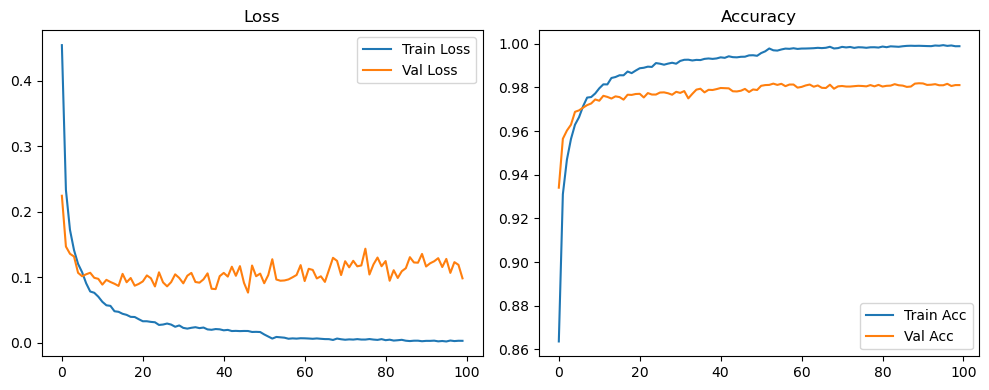

🚀 Running: batch64_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5976, Acc: 0.8174 | Val Loss: 0.3224, Acc: 0.9051


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3785, Acc: 0.8857 | Val Loss: 0.2415, Acc: 0.9281


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2966, Acc: 0.9100 | Val Loss: 0.2148, Acc: 0.9345


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2473, Acc: 0.9259 | Val Loss: 0.1835, Acc: 0.9471


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2127, Acc: 0.9366 | Val Loss: 0.1464, Acc: 0.9568


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1849, Acc: 0.9445 | Val Loss: 0.1426, Acc: 0.9596


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1645, Acc: 0.9505 | Val Loss: 0.1299, Acc: 0.9621


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1468, Acc: 0.9557 | Val Loss: 0.1158, Acc: 0.9670


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1318, Acc: 0.9593 | Val Loss: 0.1173, Acc: 0.9684


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1256, Acc: 0.9607 | Val Loss: 0.1020, Acc: 0.9698


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1121, Acc: 0.9649 | Val Loss: 0.1113, Acc: 0.9672


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1058, Acc: 0.9676 | Val Loss: 0.0965, Acc: 0.9724


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0921, Acc: 0.9709 | Val Loss: 0.0977, Acc: 0.9714


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0895, Acc: 0.9721 | Val Loss: 0.1102, Acc: 0.9729


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0860, Acc: 0.9717 | Val Loss: 0.0923, Acc: 0.9734


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0755, Acc: 0.9756 | Val Loss: 0.1031, Acc: 0.9747


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0759, Acc: 0.9756 | Val Loss: 0.0998, Acc: 0.9735


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0710, Acc: 0.9775 | Val Loss: 0.0990, Acc: 0.9755


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0667, Acc: 0.9795 | Val Loss: 0.0942, Acc: 0.9764


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9799 | Val Loss: 0.0869, Acc: 0.9765


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0611, Acc: 0.9804 | Val Loss: 0.1016, Acc: 0.9748


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0548, Acc: 0.9820 | Val Loss: 0.0957, Acc: 0.9750


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0517, Acc: 0.9831 | Val Loss: 0.1117, Acc: 0.9748


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9826 | Val Loss: 0.0882, Acc: 0.9783


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0505, Acc: 0.9840 | Val Loss: 0.0981, Acc: 0.9772


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0496, Acc: 0.9836 | Val Loss: 0.0937, Acc: 0.9783


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9852 | Val Loss: 0.0925, Acc: 0.9780


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9833 | Val Loss: 0.1041, Acc: 0.9770


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9859 | Val Loss: 0.0798, Acc: 0.9778


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0435, Acc: 0.9854 | Val Loss: 0.0910, Acc: 0.9763


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0410, Acc: 0.9868 | Val Loss: 0.1091, Acc: 0.9785


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0369, Acc: 0.9880 | Val Loss: 0.0831, Acc: 0.9793


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0408, Acc: 0.9868 | Val Loss: 0.0865, Acc: 0.9782


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9882 | Val Loss: 0.0948, Acc: 0.9782


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0350, Acc: 0.9888 | Val Loss: 0.1133, Acc: 0.9768


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0354, Acc: 0.9883 | Val Loss: 0.1205, Acc: 0.9776


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9886 | Val Loss: 0.0997, Acc: 0.9776


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0351, Acc: 0.9888 | Val Loss: 0.0933, Acc: 0.9792


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9895 | Val Loss: 0.0926, Acc: 0.9785


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0338, Acc: 0.9885 | Val Loss: 0.1007, Acc: 0.9788


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9892 | Val Loss: 0.0947, Acc: 0.9783


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0296, Acc: 0.9904 | Val Loss: 0.0948, Acc: 0.9783


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0323, Acc: 0.9895 | Val Loss: 0.0970, Acc: 0.9772


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 0.0986, Acc: 0.9776


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0283, Acc: 0.9902 | Val Loss: 0.0987, Acc: 0.9780


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9900 | Val Loss: 0.0971, Acc: 0.9795


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9897 | Val Loss: 0.0911, Acc: 0.9788


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0267, Acc: 0.9912 | Val Loss: 0.1094, Acc: 0.9778


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9908 | Val Loss: 0.0864, Acc: 0.9794


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0268, Acc: 0.9916 | Val Loss: 0.0986, Acc: 0.9788


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.0858, Acc: 0.9808


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0195, Acc: 0.9936 | Val Loss: 0.0890, Acc: 0.9795


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.0878, Acc: 0.9802


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0853, Acc: 0.9797


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9948 | Val Loss: 0.0909, Acc: 0.9808


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0148, Acc: 0.9950 | Val Loss: 0.0905, Acc: 0.9808


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9954 | Val Loss: 0.0940, Acc: 0.9809


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9952 | Val Loss: 0.0995, Acc: 0.9815


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.1021, Acc: 0.9799


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.0868, Acc: 0.9808


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.1083, Acc: 0.9795


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0922, Acc: 0.9802


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0958, Acc: 0.9800


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.0896, Acc: 0.9803


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9961 | Val Loss: 0.0996, Acc: 0.9810


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9957 | Val Loss: 0.0984, Acc: 0.9810


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.0953, Acc: 0.9809


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1141, Acc: 0.9808


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1065, Acc: 0.9802


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.1016, Acc: 0.9808


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9962 | Val Loss: 0.0869, Acc: 0.9806


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.0983, Acc: 0.9808


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0985, Acc: 0.9808


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1066, Acc: 0.9810


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1070, Acc: 0.9802


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1184, Acc: 0.9807


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.0982, Acc: 0.9816


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.0907, Acc: 0.9816


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1055, Acc: 0.9811


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1099, Acc: 0.9814


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.0904, Acc: 0.9813


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1074, Acc: 0.9817


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1045, Acc: 0.9815


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1001, Acc: 0.9818


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1086, Acc: 0.9820


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1157, Acc: 0.9811


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9977 | Val Loss: 0.1107, Acc: 0.9814


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1124, Acc: 0.9810


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.0992, Acc: 0.9818


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1078, Acc: 0.9820


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0993, Acc: 0.9809


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1053, Acc: 0.9818


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1193, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9976 | Val Loss: 0.1266, Acc: 0.9809


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1300, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0933, Acc: 0.9818


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1060, Acc: 0.9813


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1250, Acc: 0.9807


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1135, Acc: 0.9818


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.0999, Acc: 0.9813


Final Test Loss: 0.0928 Accuracy: 0.9830


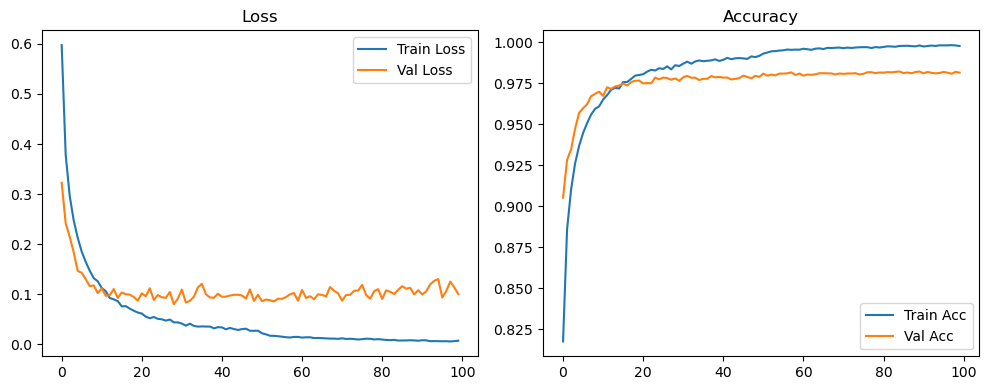

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3632, Acc: 0.8889 | Val Loss: 0.2429, Acc: 0.9282


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1395, Acc: 0.9583 | Val Loss: 0.1302, Acc: 0.9607


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0864, Acc: 0.9731 | Val Loss: 0.1917, Acc: 0.9472


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0633, Acc: 0.9797 | Val Loss: 0.1213, Acc: 0.9674


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0511, Acc: 0.9832 | Val Loss: 0.1389, Acc: 0.9631


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9867 | Val Loss: 0.1390, Acc: 0.9663


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9896 | Val Loss: 0.1699, Acc: 0.9604


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0327, Acc: 0.9897 | Val Loss: 0.1065, Acc: 0.9728


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9907 | Val Loss: 0.1196, Acc: 0.9758


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 0.1279, Acc: 0.9714


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9928 | Val Loss: 0.1383, Acc: 0.9714


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9934 | Val Loss: 0.1217, Acc: 0.9737


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.1692, Acc: 0.9650


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9935 | Val Loss: 0.1530, Acc: 0.9694


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0160, Acc: 0.9952 | Val Loss: 0.1174, Acc: 0.9774


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9942 | Val Loss: 0.1805, Acc: 0.9645


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.2533, Acc: 0.9530


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9959 | Val Loss: 0.1544, Acc: 0.9704


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.1371, Acc: 0.9746


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.1282, Acc: 0.9746


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1205, Acc: 0.9768


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.1286, Acc: 0.9737


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.1161, Acc: 0.9752


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9974 | Val Loss: 0.1257, Acc: 0.9762


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9972 | Val Loss: 0.1495, Acc: 0.9738


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9966 | Val Loss: 0.1313, Acc: 0.9741


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1326, Acc: 0.9763


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1120, Acc: 0.9772


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1133, Acc: 0.9778


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1301, Acc: 0.9761


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1440, Acc: 0.9743


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9975 | Val Loss: 0.1255, Acc: 0.9762


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1328, Acc: 0.9732


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1306, Acc: 0.9756


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1691, Acc: 0.9708


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1722, Acc: 0.9677


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1296, Acc: 0.9756


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1408, Acc: 0.9752


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1349, Acc: 0.9754


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1223, Acc: 0.9780


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1195, Acc: 0.9780


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1145, Acc: 0.9792


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1124, Acc: 0.9795


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1416, Acc: 0.9742


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1254, Acc: 0.9759


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1344, Acc: 0.9748


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1230, Acc: 0.9772


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.2119, Acc: 0.9683


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1269, Acc: 0.9776


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1588, Acc: 0.9707


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1377, Acc: 0.9763


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.1804, Acc: 0.9729


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1353, Acc: 0.9808


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1770, Acc: 0.9702


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1231, Acc: 0.9765


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1568, Acc: 0.9715


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1454, Acc: 0.9754


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1215, Acc: 0.9775


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1358, Acc: 0.9767


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1154, Acc: 0.9769


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1158, Acc: 0.9780


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1241, Acc: 0.9810


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1375, Acc: 0.9738


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1217, Acc: 0.9798


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1251, Acc: 0.9771


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1185, Acc: 0.9798


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1250, Acc: 0.9786


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1356, Acc: 0.9766


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1539, Acc: 0.9758


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1272, Acc: 0.9788


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1553, Acc: 0.9753


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1250, Acc: 0.9775


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1120, Acc: 0.9779


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1262, Acc: 0.9768


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1449, Acc: 0.9749


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1636, Acc: 0.9736


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1343, Acc: 0.9776


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1152, Acc: 0.9792


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9993 | Val Loss: 0.1324, Acc: 0.9783


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1148, Acc: 0.9792


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1385, Acc: 0.9764


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1986, Acc: 0.9693


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1277, Acc: 0.9784


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1181, Acc: 0.9792


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1033, Acc: 0.9778


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1258, Acc: 0.9795


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.0998, Acc: 0.9789


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1283, Acc: 0.9798


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1257, Acc: 0.9778


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1691, Acc: 0.9741


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1229, Acc: 0.9732


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1325, Acc: 0.9790


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1217, Acc: 0.9778


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.0919, Acc: 0.9801


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1510, Acc: 0.9754


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1305, Acc: 0.9765


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1556, Acc: 0.9750


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1339, Acc: 0.9760


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1181, Acc: 0.9789


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1682, Acc: 0.9703


Final Test Loss: 0.1484 Accuracy: 0.9709


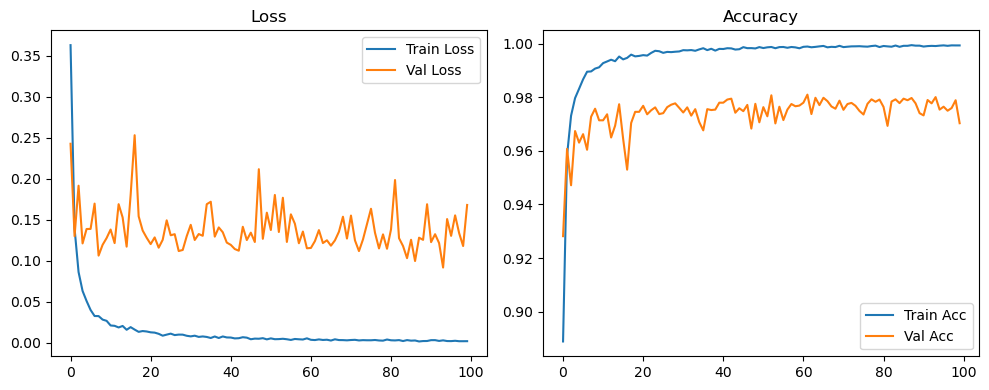

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4470, Acc: 0.8634 | Val Loss: 0.2708, Acc: 0.9185


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2657, Acc: 0.9202 | Val Loss: 0.1699, Acc: 0.9493


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1907, Acc: 0.9405 | Val Loss: 0.1554, Acc: 0.9547


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1524, Acc: 0.9539 | Val Loss: 0.1329, Acc: 0.9623


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1312, Acc: 0.9593 | Val Loss: 0.1104, Acc: 0.9677


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1174, Acc: 0.9640 | Val Loss: 0.1057, Acc: 0.9677


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0964, Acc: 0.9695 | Val Loss: 0.1175, Acc: 0.9697


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0878, Acc: 0.9718 | Val Loss: 0.0972, Acc: 0.9728


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0803, Acc: 0.9738 | Val Loss: 0.0981, Acc: 0.9726


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0752, Acc: 0.9758 | Val Loss: 0.0940, Acc: 0.9741


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0673, Acc: 0.9780 | Val Loss: 0.1077, Acc: 0.9704


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0602, Acc: 0.9810 | Val Loss: 0.0862, Acc: 0.9771


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0564, Acc: 0.9815 | Val Loss: 0.1093, Acc: 0.9718


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0517, Acc: 0.9831 | Val Loss: 0.0978, Acc: 0.9736


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9845 | Val Loss: 0.0960, Acc: 0.9763


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0469, Acc: 0.9849 | Val Loss: 0.0912, Acc: 0.9768


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0441, Acc: 0.9852 | Val Loss: 0.1008, Acc: 0.9745


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0401, Acc: 0.9865 | Val Loss: 0.0928, Acc: 0.9772


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0400, Acc: 0.9867 | Val Loss: 0.1021, Acc: 0.9748


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9876 | Val Loss: 0.0962, Acc: 0.9781


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0343, Acc: 0.9884 | Val Loss: 0.0981, Acc: 0.9758


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0336, Acc: 0.9891 | Val Loss: 0.0974, Acc: 0.9779


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0317, Acc: 0.9893 | Val Loss: 0.0973, Acc: 0.9764


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9898 | Val Loss: 0.0864, Acc: 0.9786


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9905 | Val Loss: 0.0957, Acc: 0.9780


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0275, Acc: 0.9907 | Val Loss: 0.0905, Acc: 0.9774


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0295, Acc: 0.9903 | Val Loss: 0.0907, Acc: 0.9788


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0276, Acc: 0.9902 | Val Loss: 0.0822, Acc: 0.9790


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0246, Acc: 0.9916 | Val Loss: 0.0982, Acc: 0.9772


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0261, Acc: 0.9912 | Val Loss: 0.0977, Acc: 0.9775


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.0855, Acc: 0.9789


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.0903, Acc: 0.9778


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0212, Acc: 0.9925 | Val Loss: 0.0966, Acc: 0.9780


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.1099, Acc: 0.9777


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9920 | Val Loss: 0.0813, Acc: 0.9806


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9934 | Val Loss: 0.0874, Acc: 0.9798


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.0999, Acc: 0.9764


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9933 | Val Loss: 0.1084, Acc: 0.9773


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0207, Acc: 0.9932 | Val Loss: 0.0913, Acc: 0.9797


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.0951, Acc: 0.9785


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0178, Acc: 0.9938 | Val Loss: 0.1001, Acc: 0.9793


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9939 | Val Loss: 0.0870, Acc: 0.9792


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0161, Acc: 0.9948 | Val Loss: 0.0980, Acc: 0.9786


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9943 | Val Loss: 0.0982, Acc: 0.9792


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.0915, Acc: 0.9799


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.1064, Acc: 0.9775


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9943 | Val Loss: 0.1066, Acc: 0.9795


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0890, Acc: 0.9798


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1039, Acc: 0.9785


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9945 | Val Loss: 0.0944, Acc: 0.9781


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1039, Acc: 0.9796


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.0936, Acc: 0.9785


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9952 | Val Loss: 0.1081, Acc: 0.9784


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0141, Acc: 0.9956 | Val Loss: 0.1039, Acc: 0.9801


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.0934, Acc: 0.9792


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1039, Acc: 0.9793


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.0993, Acc: 0.9791


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9952 | Val Loss: 0.0952, Acc: 0.9803


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9947 | Val Loss: 0.0947, Acc: 0.9790


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9958 | Val Loss: 0.0950, Acc: 0.9791


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1051, Acc: 0.9799


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9949 | Val Loss: 0.0958, Acc: 0.9797


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9957 | Val Loss: 0.1003, Acc: 0.9800


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9960 | Val Loss: 0.1045, Acc: 0.9797


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.0968, Acc: 0.9786


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1149, Acc: 0.9776


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1181, Acc: 0.9762


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.0964, Acc: 0.9795


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1180, Acc: 0.9785


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.1072, Acc: 0.9788


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9961 | Val Loss: 0.0968, Acc: 0.9794


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9965 | Val Loss: 0.1090, Acc: 0.9798


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9964 | Val Loss: 0.1174, Acc: 0.9798


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1076, Acc: 0.9794


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1119, Acc: 0.9798


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1073, Acc: 0.9792


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1052, Acc: 0.9796


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1191, Acc: 0.9792


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.0984, Acc: 0.9802


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9967 | Val Loss: 0.0867, Acc: 0.9806


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.0952, Acc: 0.9802


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1034, Acc: 0.9809


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9967 | Val Loss: 0.1013, Acc: 0.9804


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1025, Acc: 0.9790


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9966 | Val Loss: 0.0948, Acc: 0.9803


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1223, Acc: 0.9778


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1056, Acc: 0.9792


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1076, Acc: 0.9800


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0901, Acc: 0.9797


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1021, Acc: 0.9812


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.0995, Acc: 0.9828


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.0957, Acc: 0.9798


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0991, Acc: 0.9805


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.0947, Acc: 0.9808


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1014, Acc: 0.9801


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.0871, Acc: 0.9798


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.0920, Acc: 0.9808


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1028, Acc: 0.9805


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1096, Acc: 0.9794


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.0954, Acc: 0.9797


Final Test Loss: 0.0865 Accuracy: 0.9795


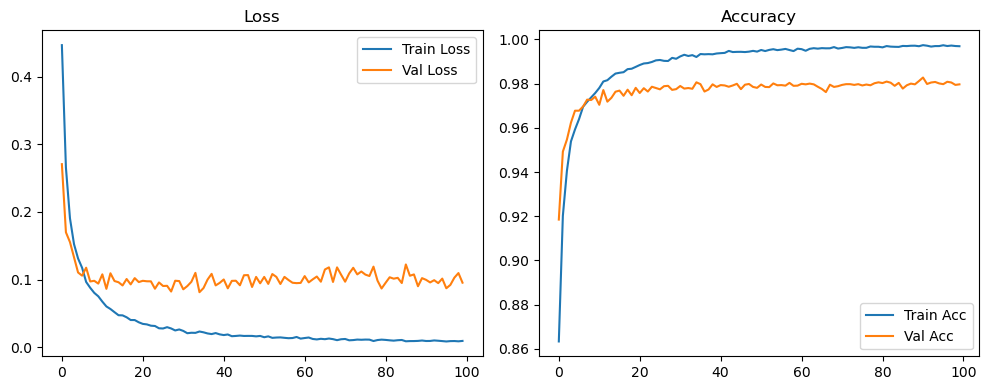

🚀 Running: batch64_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5671, Acc: 0.8243 | Val Loss: 0.3115, Acc: 0.9069


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3913, Acc: 0.8819 | Val Loss: 0.2476, Acc: 0.9273


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.3179, Acc: 0.9043 | Val Loss: 0.2091, Acc: 0.9377


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2746, Acc: 0.9170 | Val Loss: 0.1876, Acc: 0.9465


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.2479, Acc: 0.9253 | Val Loss: 0.1544, Acc: 0.9539


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.2204, Acc: 0.9330 | Val Loss: 0.1518, Acc: 0.9563


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.2084, Acc: 0.9369 | Val Loss: 0.1491, Acc: 0.9564


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1898, Acc: 0.9419 | Val Loss: 0.1372, Acc: 0.9606


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1772, Acc: 0.9455 | Val Loss: 0.1317, Acc: 0.9623


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1700, Acc: 0.9472 | Val Loss: 0.1265, Acc: 0.9625


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1554, Acc: 0.9519 | Val Loss: 0.1279, Acc: 0.9626


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1488, Acc: 0.9533 | Val Loss: 0.1133, Acc: 0.9674


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1392, Acc: 0.9561 | Val Loss: 0.1216, Acc: 0.9665


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1367, Acc: 0.9576 | Val Loss: 0.1159, Acc: 0.9677


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1274, Acc: 0.9601 | Val Loss: 0.1135, Acc: 0.9682


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1198, Acc: 0.9627 | Val Loss: 0.1126, Acc: 0.9683


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1175, Acc: 0.9637 | Val Loss: 0.1091, Acc: 0.9700


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1148, Acc: 0.9642 | Val Loss: 0.1071, Acc: 0.9699


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1127, Acc: 0.9652 | Val Loss: 0.1049, Acc: 0.9702


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.1044, Acc: 0.9668 | Val Loss: 0.1108, Acc: 0.9696


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.1017, Acc: 0.9683 | Val Loss: 0.1130, Acc: 0.9695


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0962, Acc: 0.9697 | Val Loss: 0.1076, Acc: 0.9700


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0907, Acc: 0.9711 | Val Loss: 0.1090, Acc: 0.9719


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0898, Acc: 0.9711 | Val Loss: 0.1020, Acc: 0.9718


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0847, Acc: 0.9731 | Val Loss: 0.1004, Acc: 0.9728


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0863, Acc: 0.9720 | Val Loss: 0.1058, Acc: 0.9710


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0850, Acc: 0.9732 | Val Loss: 0.1043, Acc: 0.9716


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0802, Acc: 0.9735 | Val Loss: 0.1028, Acc: 0.9718


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0754, Acc: 0.9759 | Val Loss: 0.1061, Acc: 0.9718


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0747, Acc: 0.9753 | Val Loss: 0.1073, Acc: 0.9715


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0713, Acc: 0.9765 | Val Loss: 0.0973, Acc: 0.9744


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0711, Acc: 0.9771 | Val Loss: 0.0978, Acc: 0.9738


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0680, Acc: 0.9779 | Val Loss: 0.1050, Acc: 0.9738


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0686, Acc: 0.9771 | Val Loss: 0.0994, Acc: 0.9722


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0624, Acc: 0.9794 | Val Loss: 0.0987, Acc: 0.9739


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0618, Acc: 0.9797 | Val Loss: 0.0940, Acc: 0.9748


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0640, Acc: 0.9793 | Val Loss: 0.1023, Acc: 0.9729


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0629, Acc: 0.9796 | Val Loss: 0.0964, Acc: 0.9741


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0585, Acc: 0.9804 | Val Loss: 0.0977, Acc: 0.9744


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0583, Acc: 0.9809 | Val Loss: 0.1053, Acc: 0.9747


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0557, Acc: 0.9814 | Val Loss: 0.1020, Acc: 0.9751


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0559, Acc: 0.9822 | Val Loss: 0.1013, Acc: 0.9748


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0548, Acc: 0.9827 | Val Loss: 0.0994, Acc: 0.9741


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0512, Acc: 0.9828 | Val Loss: 0.0988, Acc: 0.9738


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0526, Acc: 0.9831 | Val Loss: 0.0962, Acc: 0.9752


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0521, Acc: 0.9827 | Val Loss: 0.0984, Acc: 0.9758


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0516, Acc: 0.9828 | Val Loss: 0.0996, Acc: 0.9752


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9837 | Val Loss: 0.0992, Acc: 0.9759


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0467, Acc: 0.9848 | Val Loss: 0.0981, Acc: 0.9758


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0467, Acc: 0.9843 | Val Loss: 0.1005, Acc: 0.9764


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9843 | Val Loss: 0.0947, Acc: 0.9762


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0474, Acc: 0.9841 | Val Loss: 0.0976, Acc: 0.9762


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0460, Acc: 0.9844 | Val Loss: 0.0956, Acc: 0.9759


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9850 | Val Loss: 0.0977, Acc: 0.9762


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0447, Acc: 0.9854 | Val Loss: 0.0979, Acc: 0.9756


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0419, Acc: 0.9855 | Val Loss: 0.0957, Acc: 0.9762


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0426, Acc: 0.9856 | Val Loss: 0.1001, Acc: 0.9748


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0388, Acc: 0.9870 | Val Loss: 0.0988, Acc: 0.9765


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0430, Acc: 0.9860 | Val Loss: 0.0966, Acc: 0.9763


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9858 | Val Loss: 0.0953, Acc: 0.9760


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0395, Acc: 0.9868 | Val Loss: 0.0956, Acc: 0.9766


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9868 | Val Loss: 0.1061, Acc: 0.9757


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0413, Acc: 0.9862 | Val Loss: 0.1008, Acc: 0.9767


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0390, Acc: 0.9870 | Val Loss: 0.1000, Acc: 0.9767


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0384, Acc: 0.9874 | Val Loss: 0.0995, Acc: 0.9765


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9879 | Val Loss: 0.1001, Acc: 0.9759


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9886 | Val Loss: 0.0949, Acc: 0.9767


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9876 | Val Loss: 0.1015, Acc: 0.9769


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9880 | Val Loss: 0.0956, Acc: 0.9758


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0362, Acc: 0.9883 | Val Loss: 0.0955, Acc: 0.9748


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0360, Acc: 0.9880 | Val Loss: 0.0929, Acc: 0.9773


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9889 | Val Loss: 0.1055, Acc: 0.9760


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9885 | Val Loss: 0.1005, Acc: 0.9778


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0352, Acc: 0.9883 | Val Loss: 0.1014, Acc: 0.9769


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0315, Acc: 0.9900 | Val Loss: 0.1125, Acc: 0.9761


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0346, Acc: 0.9881 | Val Loss: 0.0981, Acc: 0.9772


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0310, Acc: 0.9897 | Val Loss: 0.0980, Acc: 0.9780


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9896 | Val Loss: 0.1048, Acc: 0.9772


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9894 | Val Loss: 0.1029, Acc: 0.9778


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0347, Acc: 0.9880 | Val Loss: 0.0958, Acc: 0.9782


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9889 | Val Loss: 0.1045, Acc: 0.9779


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0300, Acc: 0.9902 | Val Loss: 0.0985, Acc: 0.9782


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0314, Acc: 0.9895 | Val Loss: 0.1028, Acc: 0.9794


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0312, Acc: 0.9901 | Val Loss: 0.0951, Acc: 0.9784


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0318, Acc: 0.9897 | Val Loss: 0.1028, Acc: 0.9771


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0326, Acc: 0.9891 | Val Loss: 0.1107, Acc: 0.9764


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9900 | Val Loss: 0.0990, Acc: 0.9773


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0290, Acc: 0.9902 | Val Loss: 0.1069, Acc: 0.9765


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0286, Acc: 0.9906 | Val Loss: 0.1030, Acc: 0.9771


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0257, Acc: 0.9909 | Val Loss: 0.1176, Acc: 0.9763


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9899 | Val Loss: 0.1020, Acc: 0.9782


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0298, Acc: 0.9905 | Val Loss: 0.0943, Acc: 0.9772


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9906 | Val Loss: 0.0965, Acc: 0.9770


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9915 | Val Loss: 0.1029, Acc: 0.9762


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9912 | Val Loss: 0.1059, Acc: 0.9776


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9904 | Val Loss: 0.1051, Acc: 0.9772


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9915 | Val Loss: 0.0974, Acc: 0.9768


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0269, Acc: 0.9912 | Val Loss: 0.0915, Acc: 0.9772


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.0954, Acc: 0.9778


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9913 | Val Loss: 0.0944, Acc: 0.9775


Final Test Loss: 0.0784 Accuracy: 0.9804


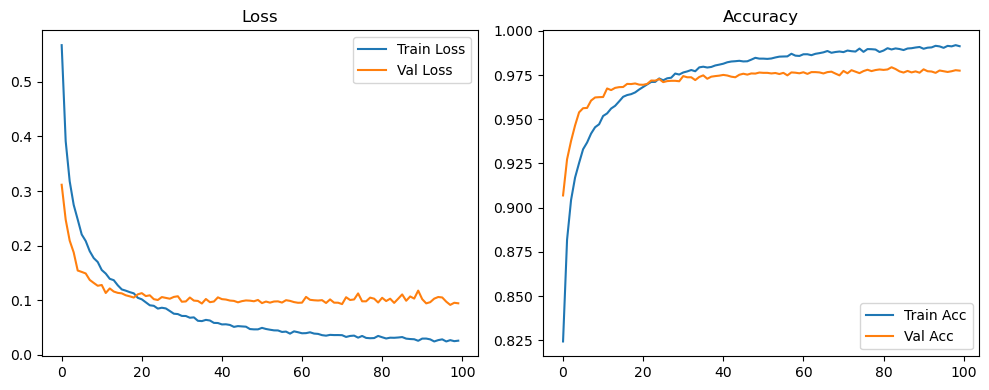

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3630, Acc: 0.8917 | Val Loss: 0.2420, Acc: 0.9283


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1328, Acc: 0.9593 | Val Loss: 0.1283, Acc: 0.9599


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0752, Acc: 0.9760 | Val Loss: 0.1358, Acc: 0.9609


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0481, Acc: 0.9840 | Val Loss: 0.1086, Acc: 0.9683


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9861 | Val Loss: 0.0988, Acc: 0.9718


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0284, Acc: 0.9909 | Val Loss: 0.1114, Acc: 0.9698


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0296, Acc: 0.9901 | Val Loss: 0.1375, Acc: 0.9658


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9910 | Val Loss: 0.1461, Acc: 0.9673


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0201, Acc: 0.9935 | Val Loss: 0.1186, Acc: 0.9714


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.1035, Acc: 0.9756


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9945 | Val Loss: 0.1227, Acc: 0.9722


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9933 | Val Loss: 0.1273, Acc: 0.9722


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.2583, Acc: 0.9490


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1155, Acc: 0.9750


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0130, Acc: 0.9959 | Val Loss: 0.1394, Acc: 0.9729


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9953 | Val Loss: 0.1330, Acc: 0.9737


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.1778, Acc: 0.9653


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1533, Acc: 0.9690


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1496, Acc: 0.9708


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1332, Acc: 0.9746


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1333, Acc: 0.9741


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9962 | Val Loss: 0.1259, Acc: 0.9765


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1362, Acc: 0.9729


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1954, Acc: 0.9649


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1711, Acc: 0.9694


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1438, Acc: 0.9738


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1944, Acc: 0.9682


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1491, Acc: 0.9739


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1441, Acc: 0.9739


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1305, Acc: 0.9776


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1369, Acc: 0.9769


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1785, Acc: 0.9702


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1725, Acc: 0.9733


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9982 | Val Loss: 0.1579, Acc: 0.9752


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1426, Acc: 0.9758


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1305, Acc: 0.9790


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1590, Acc: 0.9752


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1559, Acc: 0.9744


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9983 | Val Loss: 0.1529, Acc: 0.9746


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1329, Acc: 0.9786


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1207, Acc: 0.9802


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1500, Acc: 0.9758


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1731, Acc: 0.9721


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9976 | Val Loss: 0.1449, Acc: 0.9775


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1295, Acc: 0.9784


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1840, Acc: 0.9718


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9987 | Val Loss: 0.1747, Acc: 0.9728


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1391, Acc: 0.9774


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1833, Acc: 0.9727


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1742, Acc: 0.9712


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1351, Acc: 0.9774


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.2067, Acc: 0.9692


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1785, Acc: 0.9740


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1385, Acc: 0.9758


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1649, Acc: 0.9723


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9985 | Val Loss: 0.1527, Acc: 0.9748


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.2326, Acc: 0.9613


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1249, Acc: 0.9799


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.1334, Acc: 0.9772


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1398, Acc: 0.9776


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1334, Acc: 0.9798


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1883, Acc: 0.9687


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1389, Acc: 0.9785


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1429, Acc: 0.9770


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1743, Acc: 0.9731


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.2018, Acc: 0.9677


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1511, Acc: 0.9737


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1583, Acc: 0.9749


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1771, Acc: 0.9741


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1282, Acc: 0.9801


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1717, Acc: 0.9759


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1540, Acc: 0.9764


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1470, Acc: 0.9780


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1800, Acc: 0.9729


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1961, Acc: 0.9732


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1485, Acc: 0.9782


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1536, Acc: 0.9758


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1326, Acc: 0.9786


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1458, Acc: 0.9795


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1836, Acc: 0.9762


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1607, Acc: 0.9779


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1240, Acc: 0.9807


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1314, Acc: 0.9808


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9987 | Val Loss: 0.1395, Acc: 0.9798


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1744, Acc: 0.9755


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1483, Acc: 0.9785


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1291, Acc: 0.9794


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9993 | Val Loss: 0.1403, Acc: 0.9802


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1743, Acc: 0.9769


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9994 | Val Loss: 0.1427, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1728, Acc: 0.9767


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1513, Acc: 0.9782


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9991 | Val Loss: 0.1268, Acc: 0.9788


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1420, Acc: 0.9797


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1489, Acc: 0.9772


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1270, Acc: 0.9802


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1740, Acc: 0.9732


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0028, Acc: 0.9994 | Val Loss: 0.1296, Acc: 0.9788


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1690, Acc: 0.9769


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1514, Acc: 0.9800


Final Test Loss: 0.1255 Accuracy: 0.9808


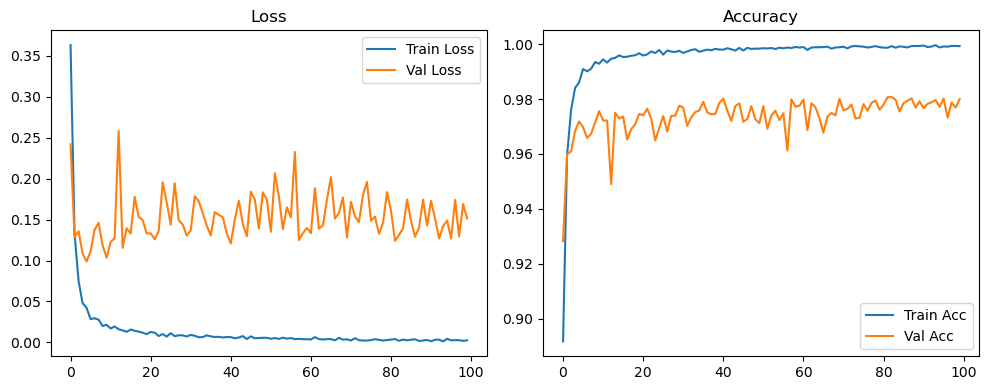

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4269, Acc: 0.8737 | Val Loss: 0.2282, Acc: 0.9309


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2363, Acc: 0.9283 | Val Loss: 0.1527, Acc: 0.9527


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1778, Acc: 0.9447 | Val Loss: 0.1409, Acc: 0.9565


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1497, Acc: 0.9530 | Val Loss: 0.1288, Acc: 0.9613


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1290, Acc: 0.9586 | Val Loss: 0.1021, Acc: 0.9699


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1200, Acc: 0.9624 | Val Loss: 0.0999, Acc: 0.9698


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.1018, Acc: 0.9673 | Val Loss: 0.1087, Acc: 0.9670


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0961, Acc: 0.9692 | Val Loss: 0.1091, Acc: 0.9674


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0858, Acc: 0.9728 | Val Loss: 0.0938, Acc: 0.9731


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0808, Acc: 0.9739 | Val Loss: 0.0964, Acc: 0.9722


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0745, Acc: 0.9755 | Val Loss: 0.1127, Acc: 0.9693


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0710, Acc: 0.9762 | Val Loss: 0.0931, Acc: 0.9737


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0655, Acc: 0.9785 | Val Loss: 0.1046, Acc: 0.9718


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0625, Acc: 0.9785 | Val Loss: 0.0951, Acc: 0.9747


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0569, Acc: 0.9814 | Val Loss: 0.1036, Acc: 0.9732


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0537, Acc: 0.9821 | Val Loss: 0.0967, Acc: 0.9756


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0531, Acc: 0.9821 | Val Loss: 0.1059, Acc: 0.9723


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9847 | Val Loss: 0.1000, Acc: 0.9748


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0474, Acc: 0.9842 | Val Loss: 0.1067, Acc: 0.9738


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0464, Acc: 0.9846 | Val Loss: 0.0957, Acc: 0.9758


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 0.0978, Acc: 0.9753


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0400, Acc: 0.9860 | Val Loss: 0.1054, Acc: 0.9731


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0399, Acc: 0.9870 | Val Loss: 0.1017, Acc: 0.9738


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9869 | Val Loss: 0.0917, Acc: 0.9763


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0334, Acc: 0.9882 | Val Loss: 0.1005, Acc: 0.9747


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0349, Acc: 0.9887 | Val Loss: 0.0956, Acc: 0.9752


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9881 | Val Loss: 0.0966, Acc: 0.9758


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0333, Acc: 0.9888 | Val Loss: 0.0971, Acc: 0.9774


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9898 | Val Loss: 0.1050, Acc: 0.9754


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9896 | Val Loss: 0.1023, Acc: 0.9759


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0314, Acc: 0.9895 | Val Loss: 0.1015, Acc: 0.9766


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9905 | Val Loss: 0.1054, Acc: 0.9767


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9907 | Val Loss: 0.1045, Acc: 0.9747


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0291, Acc: 0.9898 | Val Loss: 0.0980, Acc: 0.9765


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.1012, Acc: 0.9782


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9909 | Val Loss: 0.0968, Acc: 0.9773


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9912 | Val Loss: 0.1108, Acc: 0.9762


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9914 | Val Loss: 0.1121, Acc: 0.9757


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0243, Acc: 0.9918 | Val Loss: 0.0987, Acc: 0.9777


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0234, Acc: 0.9916 | Val Loss: 0.0952, Acc: 0.9780


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.1013, Acc: 0.9765


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1060, Acc: 0.9778


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0219, Acc: 0.9929 | Val Loss: 0.1061, Acc: 0.9770


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0218, Acc: 0.9930 | Val Loss: 0.1061, Acc: 0.9768


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.0992, Acc: 0.9772


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9926 | Val Loss: 0.1060, Acc: 0.9757


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9929 | Val Loss: 0.1103, Acc: 0.9766


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9937 | Val Loss: 0.1109, Acc: 0.9771


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1111, Acc: 0.9773


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.1102, Acc: 0.9772


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0191, Acc: 0.9934 | Val Loss: 0.0999, Acc: 0.9780


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.0971, Acc: 0.9784


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.1065, Acc: 0.9781


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0170, Acc: 0.9938 | Val Loss: 0.0983, Acc: 0.9782


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.1027, Acc: 0.9783


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0168, Acc: 0.9943 | Val Loss: 0.1040, Acc: 0.9774


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9946 | Val Loss: 0.1031, Acc: 0.9795


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9946 | Val Loss: 0.1064, Acc: 0.9782


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9946 | Val Loss: 0.1079, Acc: 0.9773


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9946 | Val Loss: 0.1084, Acc: 0.9786


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9949 | Val Loss: 0.0963, Acc: 0.9794


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.1019, Acc: 0.9782


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.1073, Acc: 0.9768


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.1120, Acc: 0.9783


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1036, Acc: 0.9790


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9954 | Val Loss: 0.1173, Acc: 0.9773


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1132, Acc: 0.9772


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1099, Acc: 0.9791


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0152, Acc: 0.9947 | Val Loss: 0.1085, Acc: 0.9798


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9961 | Val Loss: 0.1071, Acc: 0.9784


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.1076, Acc: 0.9798


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1160, Acc: 0.9766


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1099, Acc: 0.9785


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1030, Acc: 0.9783


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1150, Acc: 0.9793


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.1116, Acc: 0.9788


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1151, Acc: 0.9788


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1105, Acc: 0.9783


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9962 | Val Loss: 0.1033, Acc: 0.9793


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.1031, Acc: 0.9788


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9961 | Val Loss: 0.1027, Acc: 0.9782


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1113, Acc: 0.9789


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1162, Acc: 0.9788


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1044, Acc: 0.9798


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9962 | Val Loss: 0.1047, Acc: 0.9782


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1101, Acc: 0.9782


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1027, Acc: 0.9787


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9964 | Val Loss: 0.1102, Acc: 0.9792


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1055, Acc: 0.9784


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1071, Acc: 0.9788


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1049, Acc: 0.9776


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1099, Acc: 0.9778


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1117, Acc: 0.9782


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1090, Acc: 0.9772


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9967 | Val Loss: 0.1076, Acc: 0.9781


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1019, Acc: 0.9791


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9965 | Val Loss: 0.1102, Acc: 0.9772


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9974 | Val Loss: 0.1132, Acc: 0.9782


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1122, Acc: 0.9784


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1172, Acc: 0.9782


Final Test Loss: 0.1100 Accuracy: 0.9806


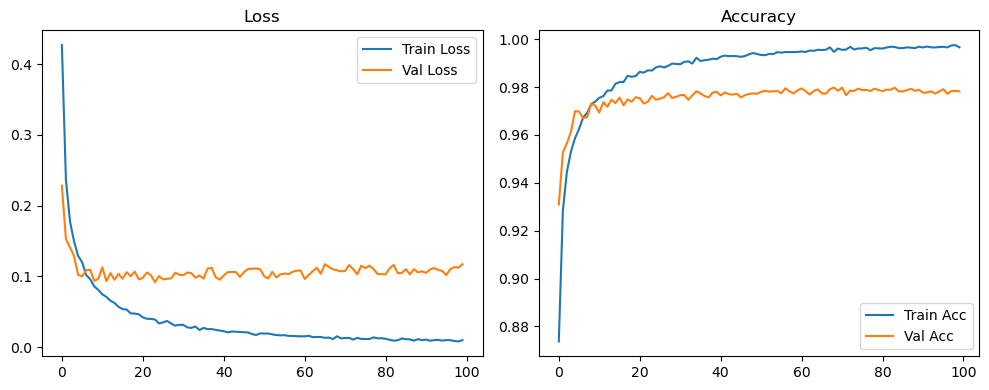

🚀 Running: batch64_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.5798, Acc: 0.8219 | Val Loss: 0.3072, Acc: 0.9067


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3911, Acc: 0.8813 | Val Loss: 0.2451, Acc: 0.9276


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.3269, Acc: 0.9004 | Val Loss: 0.2095, Acc: 0.9375


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.2874, Acc: 0.9128 | Val Loss: 0.1900, Acc: 0.9434


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2589, Acc: 0.9219 | Val Loss: 0.1595, Acc: 0.9513


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2343, Acc: 0.9288 | Val Loss: 0.1568, Acc: 0.9538


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.2233, Acc: 0.9318 | Val Loss: 0.1556, Acc: 0.9547


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.2032, Acc: 0.9375 | Val Loss: 0.1430, Acc: 0.9585


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1926, Acc: 0.9403 | Val Loss: 0.1356, Acc: 0.9597


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1847, Acc: 0.9420 | Val Loss: 0.1387, Acc: 0.9594


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1720, Acc: 0.9460 | Val Loss: 0.1334, Acc: 0.9617


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1644, Acc: 0.9483 | Val Loss: 0.1203, Acc: 0.9652


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1549, Acc: 0.9517 | Val Loss: 0.1296, Acc: 0.9643


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1508, Acc: 0.9533 | Val Loss: 0.1143, Acc: 0.9676


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1427, Acc: 0.9559 | Val Loss: 0.1198, Acc: 0.9666


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1357, Acc: 0.9574 | Val Loss: 0.1151, Acc: 0.9679


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1293, Acc: 0.9596 | Val Loss: 0.1136, Acc: 0.9692


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1280, Acc: 0.9595 | Val Loss: 0.1120, Acc: 0.9696


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1257, Acc: 0.9604 | Val Loss: 0.1117, Acc: 0.9689


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1182, Acc: 0.9637 | Val Loss: 0.1157, Acc: 0.9684


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1165, Acc: 0.9629 | Val Loss: 0.1164, Acc: 0.9685


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1113, Acc: 0.9642 | Val Loss: 0.1135, Acc: 0.9686


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1048, Acc: 0.9667 | Val Loss: 0.1137, Acc: 0.9690


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1028, Acc: 0.9673 | Val Loss: 0.1104, Acc: 0.9705


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0979, Acc: 0.9691 | Val Loss: 0.1084, Acc: 0.9708


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0998, Acc: 0.9681 | Val Loss: 0.1054, Acc: 0.9702


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0973, Acc: 0.9684 | Val Loss: 0.1071, Acc: 0.9721


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0928, Acc: 0.9697 | Val Loss: 0.1108, Acc: 0.9700


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0895, Acc: 0.9708 | Val Loss: 0.1124, Acc: 0.9708


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0880, Acc: 0.9708 | Val Loss: 0.1084, Acc: 0.9706


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0852, Acc: 0.9714 | Val Loss: 0.1031, Acc: 0.9718


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0831, Acc: 0.9739 | Val Loss: 0.1023, Acc: 0.9722


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0787, Acc: 0.9740 | Val Loss: 0.1045, Acc: 0.9729


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0812, Acc: 0.9735 | Val Loss: 0.1049, Acc: 0.9722


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0782, Acc: 0.9746 | Val Loss: 0.1027, Acc: 0.9718


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0745, Acc: 0.9755 | Val Loss: 0.1028, Acc: 0.9734


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0741, Acc: 0.9757 | Val Loss: 0.1072, Acc: 0.9727


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0700, Acc: 0.9775 | Val Loss: 0.1054, Acc: 0.9717


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0710, Acc: 0.9759 | Val Loss: 0.1054, Acc: 0.9725


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0668, Acc: 0.9782 | Val Loss: 0.1036, Acc: 0.9738


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0675, Acc: 0.9780 | Val Loss: 0.1041, Acc: 0.9737


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0638, Acc: 0.9785 | Val Loss: 0.1084, Acc: 0.9736


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0651, Acc: 0.9787 | Val Loss: 0.1062, Acc: 0.9731


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0635, Acc: 0.9783 | Val Loss: 0.1059, Acc: 0.9738


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0604, Acc: 0.9799 | Val Loss: 0.1047, Acc: 0.9741


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0603, Acc: 0.9800 | Val Loss: 0.1041, Acc: 0.9735


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0609, Acc: 0.9802 | Val Loss: 0.1159, Acc: 0.9721


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9813 | Val Loss: 0.1110, Acc: 0.9719


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0571, Acc: 0.9816 | Val Loss: 0.1019, Acc: 0.9730


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0580, Acc: 0.9811 | Val Loss: 0.1084, Acc: 0.9737


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0545, Acc: 0.9820 | Val Loss: 0.1027, Acc: 0.9741


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0556, Acc: 0.9816 | Val Loss: 0.1067, Acc: 0.9739


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0547, Acc: 0.9816 | Val Loss: 0.1076, Acc: 0.9737


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0528, Acc: 0.9823 | Val Loss: 0.1089, Acc: 0.9735


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0502, Acc: 0.9826 | Val Loss: 0.1074, Acc: 0.9740


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0498, Acc: 0.9839 | Val Loss: 0.1039, Acc: 0.9757


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0471, Acc: 0.9844 | Val Loss: 0.1115, Acc: 0.9732


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0489, Acc: 0.9844 | Val Loss: 0.1053, Acc: 0.9749


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0486, Acc: 0.9839 | Val Loss: 0.1030, Acc: 0.9758


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0490, Acc: 0.9838 | Val Loss: 0.1028, Acc: 0.9739


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0475, Acc: 0.9840 | Val Loss: 0.1008, Acc: 0.9749


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0476, Acc: 0.9838 | Val Loss: 0.1015, Acc: 0.9747


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0473, Acc: 0.9843 | Val Loss: 0.1042, Acc: 0.9742


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0444, Acc: 0.9852 | Val Loss: 0.1065, Acc: 0.9748


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0474, Acc: 0.9842 | Val Loss: 0.1014, Acc: 0.9756


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0418, Acc: 0.9862 | Val Loss: 0.1079, Acc: 0.9744


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0426, Acc: 0.9858 | Val Loss: 0.1109, Acc: 0.9739


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0421, Acc: 0.9858 | Val Loss: 0.1103, Acc: 0.9741


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9874 | Val Loss: 0.1083, Acc: 0.9740


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9864 | Val Loss: 0.1021, Acc: 0.9757


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0396, Acc: 0.9869 | Val Loss: 0.1067, Acc: 0.9756


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0416, Acc: 0.9864 | Val Loss: 0.1104, Acc: 0.9738


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0401, Acc: 0.9868 | Val Loss: 0.1067, Acc: 0.9761


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0391, Acc: 0.9866 | Val Loss: 0.1132, Acc: 0.9739


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0390, Acc: 0.9864 | Val Loss: 0.1085, Acc: 0.9746


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0375, Acc: 0.9876 | Val Loss: 0.1148, Acc: 0.9742


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9873 | Val Loss: 0.1028, Acc: 0.9751


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9872 | Val Loss: 0.1101, Acc: 0.9739


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0355, Acc: 0.9879 | Val Loss: 0.1064, Acc: 0.9754


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0367, Acc: 0.9877 | Val Loss: 0.1006, Acc: 0.9753


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0368, Acc: 0.9876 | Val Loss: 0.1044, Acc: 0.9758


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0357, Acc: 0.9884 | Val Loss: 0.1040, Acc: 0.9762


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9881 | Val Loss: 0.1020, Acc: 0.9768


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0345, Acc: 0.9888 | Val Loss: 0.1019, Acc: 0.9763


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0361, Acc: 0.9881 | Val Loss: 0.1034, Acc: 0.9765


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9892 | Val Loss: 0.1157, Acc: 0.9741


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0330, Acc: 0.9885 | Val Loss: 0.1120, Acc: 0.9754


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9886 | Val Loss: 0.1050, Acc: 0.9761


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9898 | Val Loss: 0.1131, Acc: 0.9748


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0321, Acc: 0.9893 | Val Loss: 0.1131, Acc: 0.9757


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9889 | Val Loss: 0.1072, Acc: 0.9758


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9887 | Val Loss: 0.1062, Acc: 0.9768


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9888 | Val Loss: 0.1089, Acc: 0.9758


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9900 | Val Loss: 0.1149, Acc: 0.9755


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9890 | Val Loss: 0.1074, Acc: 0.9758


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0315, Acc: 0.9893 | Val Loss: 0.1086, Acc: 0.9771


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0289, Acc: 0.9904 | Val Loss: 0.1088, Acc: 0.9763


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0288, Acc: 0.9902 | Val Loss: 0.1074, Acc: 0.9768


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0285, Acc: 0.9904 | Val Loss: 0.1078, Acc: 0.9757


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0295, Acc: 0.9899 | Val Loss: 0.1083, Acc: 0.9758


Final Test Loss: 0.0896 Accuracy: 0.9785


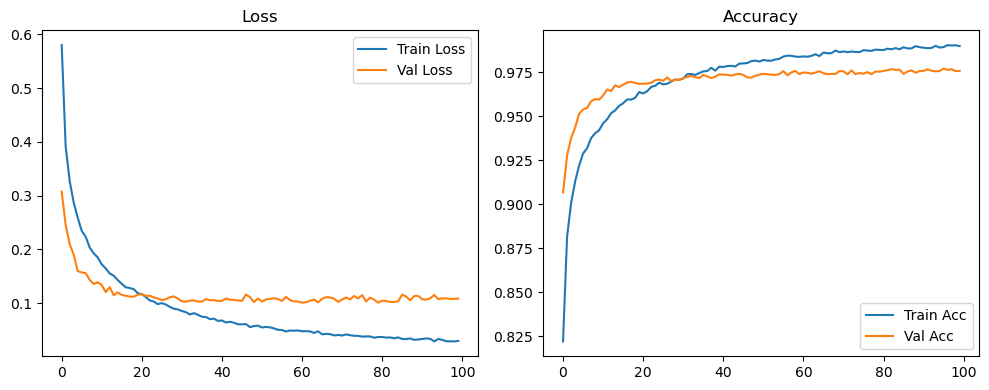

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4658, Acc: 0.8604 | Val Loss: 0.2822, Acc: 0.9196


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1966, Acc: 0.9413 | Val Loss: 0.1698, Acc: 0.9519


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1244, Acc: 0.9621 | Val Loss: 0.1519, Acc: 0.9543


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0860, Acc: 0.9734 | Val Loss: 0.1525, Acc: 0.9600


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9814 | Val Loss: 0.1204, Acc: 0.9653


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9850 | Val Loss: 0.1201, Acc: 0.9692


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9865 | Val Loss: 0.1521, Acc: 0.9611


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.1032, Acc: 0.9728


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.1105, Acc: 0.9718


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.1224, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.1144, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.1086, Acc: 0.9715


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1058, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.1187, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.1635, Acc: 0.9616


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.1341, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1655, Acc: 0.9635


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1265, Acc: 0.9725


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.0932, Acc: 0.9770


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.1396, Acc: 0.9708


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.1479, Acc: 0.9655


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9955 | Val Loss: 0.1656, Acc: 0.9729


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.2321, Acc: 0.9598


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1352, Acc: 0.9743


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.2261, Acc: 0.9529


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1549, Acc: 0.9744


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1161, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1765, Acc: 0.9704


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1876, Acc: 0.9747


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1750, Acc: 0.9749


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1708, Acc: 0.9753


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1842, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1513, Acc: 0.9762


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1624, Acc: 0.9739


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1501, Acc: 0.9688


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1487, Acc: 0.9705


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1465, Acc: 0.9751


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1575, Acc: 0.9744


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1460, Acc: 0.9754


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.2179, Acc: 0.9664


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1737, Acc: 0.9731


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1304, Acc: 0.9753


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1456, Acc: 0.9772


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1687, Acc: 0.9740


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1505, Acc: 0.9765


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1592, Acc: 0.9752


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1643, Acc: 0.9684


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1222, Acc: 0.9778


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1708, Acc: 0.9786


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1538, Acc: 0.9767


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1393, Acc: 0.9713


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1120, Acc: 0.9756


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1159, Acc: 0.9748


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1416, Acc: 0.9768


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1365, Acc: 0.9745


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1741, Acc: 0.9779


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1701, Acc: 0.9759


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1748, Acc: 0.9760


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1580, Acc: 0.9776


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.7151, Acc: 0.8330


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.1706, Acc: 0.9755


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 2.3248, Acc: 0.6503


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1313, Acc: 0.9761


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.2523, Acc: 0.9629


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.2039, Acc: 0.9702


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1295, Acc: 0.9778


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1333, Acc: 0.9785


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1197, Acc: 0.9772


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9989 | Val Loss: 0.1431, Acc: 0.9767


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1326, Acc: 0.9770


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1749, Acc: 0.9699


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9966 | Val Loss: 0.1602, Acc: 0.9740


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1225, Acc: 0.9782


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1580, Acc: 0.9768


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.3330, Acc: 0.9392


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1368, Acc: 0.9762


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.2126, Acc: 0.9732


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1900, Acc: 0.9773


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1396, Acc: 0.9741


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9983 | Val Loss: 0.1616, Acc: 0.9761


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1262, Acc: 0.9748


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1918, Acc: 0.9756


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9987 | Val Loss: 0.3001, Acc: 0.9707


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1423, Acc: 0.9786


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.2057, Acc: 0.9746


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.1316, Acc: 0.9726


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1372, Acc: 0.9745


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.2064, Acc: 0.9706


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.2490, Acc: 0.9593


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.2528, Acc: 0.9637


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1105, Acc: 0.9728


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1374, Acc: 0.9762


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.0932, Acc: 0.9762


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0034, Acc: 0.9991 | Val Loss: 0.1937, Acc: 0.9769


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1240, Acc: 0.9772


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9976 | Val Loss: 0.1459, Acc: 0.9760


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1623, Acc: 0.9729


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1486, Acc: 0.9772


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1886, Acc: 0.9780


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.1903, Acc: 0.9751


Final Test Loss: 0.1705 Accuracy: 0.9779


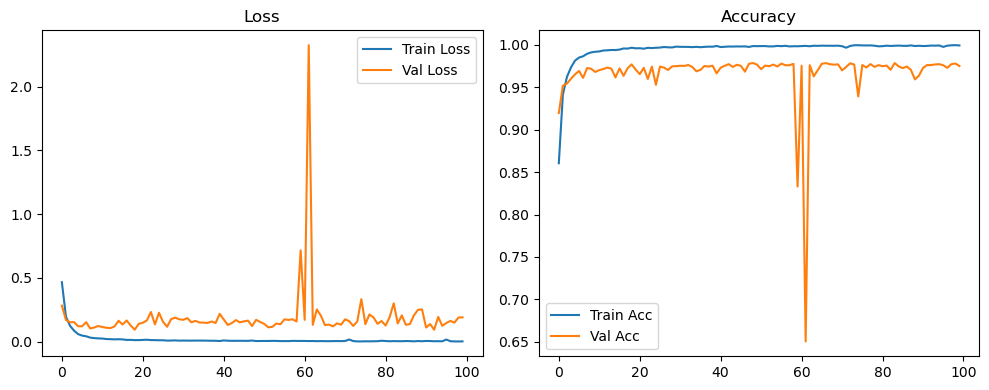

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5060, Acc: 0.8511 | Val Loss: 0.3321, Acc: 0.9023


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2631, Acc: 0.9231 | Val Loss: 0.1738, Acc: 0.9500


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1768, Acc: 0.9472 | Val Loss: 0.1669, Acc: 0.9536


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1316, Acc: 0.9597 | Val Loss: 0.1419, Acc: 0.9599


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1068, Acc: 0.9662 | Val Loss: 0.1138, Acc: 0.9673


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9714 | Val Loss: 0.1235, Acc: 0.9680


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9758 | Val Loss: 0.1171, Acc: 0.9680


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9791 | Val Loss: 0.1114, Acc: 0.9692


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9804 | Val Loss: 0.1043, Acc: 0.9720


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9834 | Val Loss: 0.1075, Acc: 0.9708


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9828 | Val Loss: 0.0984, Acc: 0.9722


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9851 | Val Loss: 0.1028, Acc: 0.9724


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9844 | Val Loss: 0.1101, Acc: 0.9714


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9867 | Val Loss: 0.1061, Acc: 0.9737


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9873 | Val Loss: 0.0965, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9876 | Val Loss: 0.0978, Acc: 0.9751


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9897 | Val Loss: 0.1063, Acc: 0.9729


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9894 | Val Loss: 0.1026, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9897 | Val Loss: 0.0906, Acc: 0.9735


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.1115, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.0996, Acc: 0.9759


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9913 | Val Loss: 0.1137, Acc: 0.9758


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.0995, Acc: 0.9755


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9921 | Val Loss: 0.1053, Acc: 0.9767


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.1035, Acc: 0.9738


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9910 | Val Loss: 0.0926, Acc: 0.9769


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.1007, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9927 | Val Loss: 0.1221, Acc: 0.9756


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9932 | Val Loss: 0.0937, Acc: 0.9770


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1056, Acc: 0.9752


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.1014, Acc: 0.9758


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9934 | Val Loss: 0.1072, Acc: 0.9778


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.1289, Acc: 0.9767


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9938 | Val Loss: 0.1265, Acc: 0.9757


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.1307, Acc: 0.9771


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.1008, Acc: 0.9764


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.1231, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9934 | Val Loss: 0.1078, Acc: 0.9749


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1149, Acc: 0.9762


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1344, Acc: 0.9772


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.0848, Acc: 0.9767


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1436, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1391, Acc: 0.9766


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1210, Acc: 0.9745


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1297, Acc: 0.9767


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.1015, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9949 | Val Loss: 0.1361, Acc: 0.9772


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1435, Acc: 0.9771


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.1691, Acc: 0.9761


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.1100, Acc: 0.9772


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9954 | Val Loss: 0.1147, Acc: 0.9758


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1191, Acc: 0.9782


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1522, Acc: 0.9768


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9962 | Val Loss: 0.1143, Acc: 0.9765


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0119, Acc: 0.9958 | Val Loss: 0.1044, Acc: 0.9784


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9962 | Val Loss: 0.1132, Acc: 0.9783


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9961 | Val Loss: 0.1379, Acc: 0.9762


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0122, Acc: 0.9960 | Val Loss: 0.1133, Acc: 0.9755


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.0934, Acc: 0.9771


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1107, Acc: 0.9762


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0118, Acc: 0.9963 | Val Loss: 0.1061, Acc: 0.9772


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9963 | Val Loss: 0.1238, Acc: 0.9758


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.1297, Acc: 0.9769


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1593, Acc: 0.9778


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1046, Acc: 0.9765


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1334, Acc: 0.9765


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1268, Acc: 0.9772


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1295, Acc: 0.9776


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1406, Acc: 0.9774


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1330, Acc: 0.9758


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9964 | Val Loss: 0.1515, Acc: 0.9758


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1146, Acc: 0.9762


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1523, Acc: 0.9782


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1113, Acc: 0.9764


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9966 | Val Loss: 0.1186, Acc: 0.9762


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9971 | Val Loss: 0.1471, Acc: 0.9762


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.1183, Acc: 0.9771


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1148, Acc: 0.9774


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1689, Acc: 0.9783


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1279, Acc: 0.9768


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1244, Acc: 0.9784


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1619, Acc: 0.9787


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1162, Acc: 0.9766


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.1262, Acc: 0.9777


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1155, Acc: 0.9768


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9974 | Val Loss: 0.1153, Acc: 0.9770


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1162, Acc: 0.9774


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1482, Acc: 0.9765


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1798, Acc: 0.9772


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0087, Acc: 0.9977 | Val Loss: 0.1113, Acc: 0.9767


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1114, Acc: 0.9776


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1104, Acc: 0.9785


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1030, Acc: 0.9787


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1313, Acc: 0.9780


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0951, Acc: 0.9785


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1824, Acc: 0.9784


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.0958, Acc: 0.9778


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9975 | Val Loss: 0.1326, Acc: 0.9775


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0073, Acc: 0.9979 | Val Loss: 0.1597, Acc: 0.9768


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.2137, Acc: 0.9770


Final Test Loss: 0.1745 Accuracy: 0.9809


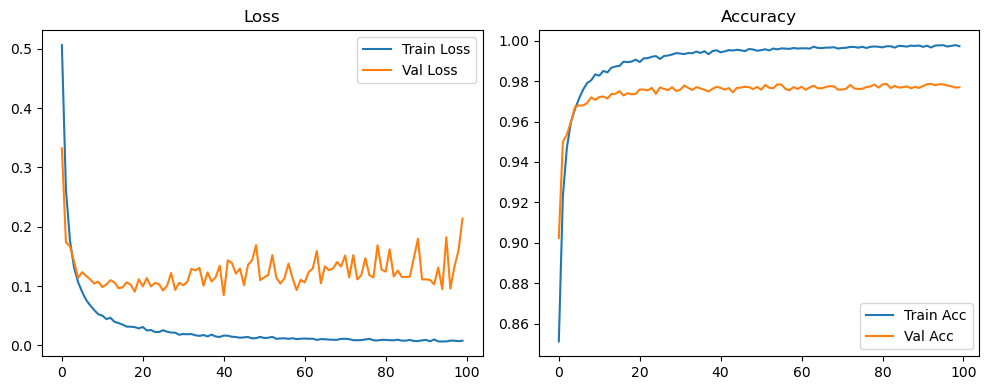

🚀 Running: batch128_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6196, Acc: 0.8168 | Val Loss: 0.3480, Acc: 0.9058


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3530, Acc: 0.8944 | Val Loss: 0.2224, Acc: 0.9318


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2624, Acc: 0.9218 | Val Loss: 0.1952, Acc: 0.9410


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2107, Acc: 0.9363 | Val Loss: 0.1585, Acc: 0.9537


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1810, Acc: 0.9448 | Val Loss: 0.1396, Acc: 0.9571


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1593, Acc: 0.9529 | Val Loss: 0.1422, Acc: 0.9591


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1428, Acc: 0.9558 | Val Loss: 0.1273, Acc: 0.9626


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1220, Acc: 0.9618 | Val Loss: 0.1224, Acc: 0.9659


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1170, Acc: 0.9644 | Val Loss: 0.1140, Acc: 0.9688


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9683 | Val Loss: 0.1107, Acc: 0.9686


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0972, Acc: 0.9693 | Val Loss: 0.1140, Acc: 0.9679


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9731 | Val Loss: 0.1013, Acc: 0.9704


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9733 | Val Loss: 0.1079, Acc: 0.9680


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0803, Acc: 0.9745 | Val Loss: 0.0989, Acc: 0.9738


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0737, Acc: 0.9763 | Val Loss: 0.1140, Acc: 0.9711


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9773 | Val Loss: 0.1006, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0673, Acc: 0.9789 | Val Loss: 0.1127, Acc: 0.9727


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9791 | Val Loss: 0.0996, Acc: 0.9733


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9804 | Val Loss: 0.0973, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9817 | Val Loss: 0.0917, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9821 | Val Loss: 0.1034, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9836 | Val Loss: 0.0975, Acc: 0.9755


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9839 | Val Loss: 0.1167, Acc: 0.9761


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9847 | Val Loss: 0.0953, Acc: 0.9772


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9851 | Val Loss: 0.0918, Acc: 0.9768


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9859 | Val Loss: 0.0904, Acc: 0.9773


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9870 | Val Loss: 0.0925, Acc: 0.9777


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9877 | Val Loss: 0.0960, Acc: 0.9767


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9871 | Val Loss: 0.0945, Acc: 0.9764


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9867 | Val Loss: 0.1023, Acc: 0.9765


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9876 | Val Loss: 0.0995, Acc: 0.9766


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9882 | Val Loss: 0.1087, Acc: 0.9763


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9892 | Val Loss: 0.1118, Acc: 0.9783


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9884 | Val Loss: 0.0955, Acc: 0.9779


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9884 | Val Loss: 0.0800, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9890 | Val Loss: 0.0801, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9894 | Val Loss: 0.1037, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9901 | Val Loss: 0.0955, Acc: 0.9778


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9893 | Val Loss: 0.0851, Acc: 0.9792


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9894 | Val Loss: 0.1186, Acc: 0.9775


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.1120, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.1061, Acc: 0.9785


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0928, Acc: 0.9777


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.0889, Acc: 0.9783


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.0918, Acc: 0.9793


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9919 | Val Loss: 0.1165, Acc: 0.9793


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.0934, Acc: 0.9789


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0789, Acc: 0.9779


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.1162, Acc: 0.9784


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1225, Acc: 0.9779


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.0968, Acc: 0.9778


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9917 | Val Loss: 0.1243, Acc: 0.9792


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9918 | Val Loss: 0.1084, Acc: 0.9779


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0241, Acc: 0.9923 | Val Loss: 0.0835, Acc: 0.9793


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9924 | Val Loss: 0.0932, Acc: 0.9774


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9917 | Val Loss: 0.0860, Acc: 0.9803


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9929 | Val Loss: 0.0839, Acc: 0.9795


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9927 | Val Loss: 0.0995, Acc: 0.9798


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9933 | Val Loss: 0.1118, Acc: 0.9787


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.1060, Acc: 0.9786


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.0897, Acc: 0.9800


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9926 | Val Loss: 0.1125, Acc: 0.9799


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.1284, Acc: 0.9784


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.1084, Acc: 0.9792


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9932 | Val Loss: 0.1000, Acc: 0.9783


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0196, Acc: 0.9939 | Val Loss: 0.0865, Acc: 0.9795


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.0928, Acc: 0.9805


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9945 | Val Loss: 0.1413, Acc: 0.9790


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9938 | Val Loss: 0.0798, Acc: 0.9784


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.1435, Acc: 0.9781


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9929 | Val Loss: 0.0910, Acc: 0.9779


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9934 | Val Loss: 0.1055, Acc: 0.9788


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9943 | Val Loss: 0.0952, Acc: 0.9789


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9944 | Val Loss: 0.1038, Acc: 0.9785


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.0901, Acc: 0.9782


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0177, Acc: 0.9947 | Val Loss: 0.1206, Acc: 0.9793


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9950 | Val Loss: 0.1177, Acc: 0.9790


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9944 | Val Loss: 0.1078, Acc: 0.9791


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.1031, Acc: 0.9794


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.0992, Acc: 0.9798


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.0705, Acc: 0.9802


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.0876, Acc: 0.9805


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9945 | Val Loss: 0.0898, Acc: 0.9795


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0166, Acc: 0.9948 | Val Loss: 0.1073, Acc: 0.9797


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0156, Acc: 0.9951 | Val Loss: 0.0755, Acc: 0.9798


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9950 | Val Loss: 0.1116, Acc: 0.9799


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9947 | Val Loss: 0.1205, Acc: 0.9797


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.1257, Acc: 0.9794


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9942 | Val Loss: 0.1185, Acc: 0.9804


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.1176, Acc: 0.9796


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1188, Acc: 0.9801


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9952 | Val Loss: 0.0966, Acc: 0.9810


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1287, Acc: 0.9813


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9958 | Val Loss: 0.1045, Acc: 0.9800


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9951 | Val Loss: 0.0739, Acc: 0.9799


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9947 | Val Loss: 0.1141, Acc: 0.9803


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0159, Acc: 0.9952 | Val Loss: 0.0805, Acc: 0.9800


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1098, Acc: 0.9803


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9956 | Val Loss: 0.1415, Acc: 0.9804


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1063, Acc: 0.9802


Final Test Loss: 0.0932 Accuracy: 0.9817


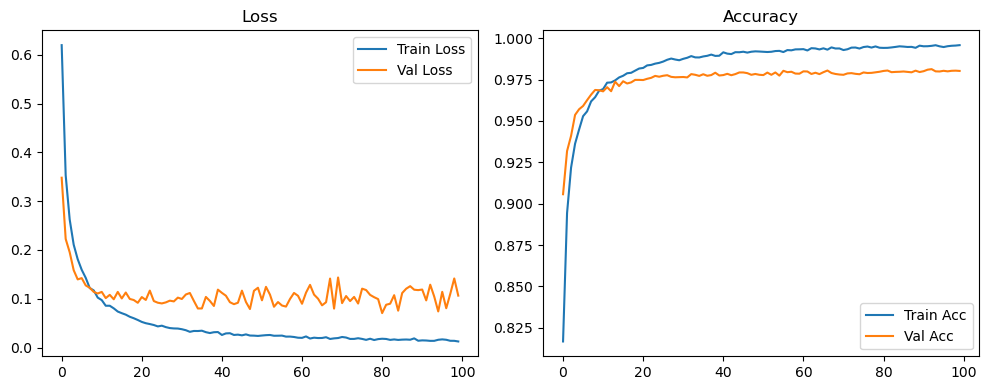

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4658, Acc: 0.8604 | Val Loss: 0.2822, Acc: 0.9196


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1966, Acc: 0.9413 | Val Loss: 0.1698, Acc: 0.9519


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1244, Acc: 0.9621 | Val Loss: 0.1519, Acc: 0.9543


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0860, Acc: 0.9734 | Val Loss: 0.1525, Acc: 0.9600


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9814 | Val Loss: 0.1204, Acc: 0.9653


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9850 | Val Loss: 0.1201, Acc: 0.9692


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9865 | Val Loss: 0.1521, Acc: 0.9611


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.1032, Acc: 0.9728


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.1105, Acc: 0.9718


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.1224, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.1144, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.1086, Acc: 0.9715


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1058, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.1187, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.1635, Acc: 0.9616


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.1341, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1655, Acc: 0.9635


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1265, Acc: 0.9725


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.0932, Acc: 0.9770


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.1396, Acc: 0.9708


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.1479, Acc: 0.9655


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9955 | Val Loss: 0.1656, Acc: 0.9729


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.2321, Acc: 0.9598


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1352, Acc: 0.9743


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.2261, Acc: 0.9529


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1549, Acc: 0.9744


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1161, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1765, Acc: 0.9704


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1876, Acc: 0.9747


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1750, Acc: 0.9749


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1708, Acc: 0.9753


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1842, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1513, Acc: 0.9762


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1624, Acc: 0.9739


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1501, Acc: 0.9688


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1487, Acc: 0.9705


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1465, Acc: 0.9751


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1575, Acc: 0.9744


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1460, Acc: 0.9754


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.2179, Acc: 0.9664


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1737, Acc: 0.9731


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1304, Acc: 0.9753


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1456, Acc: 0.9772


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1687, Acc: 0.9740


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1505, Acc: 0.9765


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1592, Acc: 0.9752


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1643, Acc: 0.9684


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1222, Acc: 0.9778


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1708, Acc: 0.9786


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1538, Acc: 0.9767


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1302, Acc: 0.9787


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1467, Acc: 0.9800


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1360, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1468, Acc: 0.9798


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1498, Acc: 0.9792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1766, Acc: 0.9773


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1882, Acc: 0.9769


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1653, Acc: 0.9790


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1645, Acc: 0.9771


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.1884, Acc: 0.9787


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0736, Acc: 0.9783


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1319, Acc: 0.9793


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1258, Acc: 0.9800


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1744, Acc: 0.9797


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1905, Acc: 0.9775


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1296, Acc: 0.9763


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1232, Acc: 0.9781


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1577, Acc: 0.9799


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1545, Acc: 0.9755


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1204, Acc: 0.9781


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1998, Acc: 0.9788


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1661, Acc: 0.9778


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1250, Acc: 0.9745


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1737, Acc: 0.9791


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1794, Acc: 0.9778


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2120, Acc: 0.9782


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1401, Acc: 0.9792


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1699, Acc: 0.9765


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1489, Acc: 0.9772


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1950, Acc: 0.9788


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1771, Acc: 0.9788


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1545, Acc: 0.9791


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1800, Acc: 0.9788


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2049, Acc: 0.9788


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2198, Acc: 0.9783


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1957, Acc: 0.9786


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2246, Acc: 0.9793


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1665, Acc: 0.9788


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1899, Acc: 0.9784


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2113, Acc: 0.9782


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2361, Acc: 0.9782


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2518, Acc: 0.9782


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1978, Acc: 0.9788


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2404, Acc: 0.9785


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1564, Acc: 0.9793


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2296, Acc: 0.9790


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2163, Acc: 0.9786


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1803, Acc: 0.9783


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1846, Acc: 0.9779


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1829, Acc: 0.9789


Final Test Loss: 0.1640 Accuracy: 0.9819


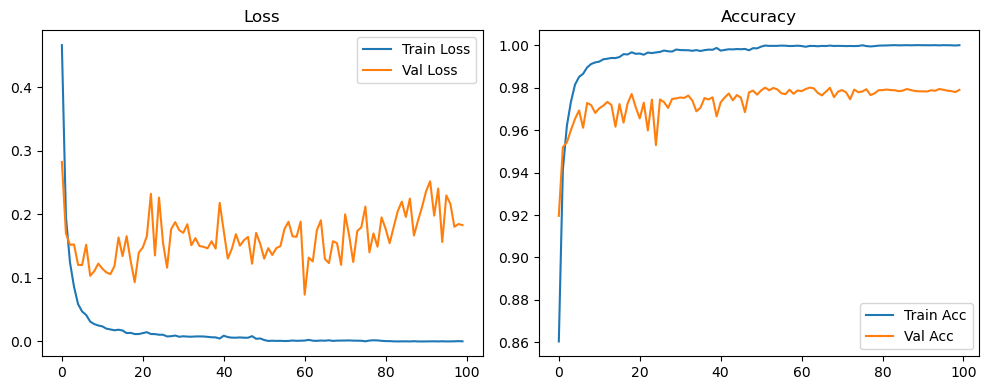

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5060, Acc: 0.8511 | Val Loss: 0.3321, Acc: 0.9023


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2631, Acc: 0.9231 | Val Loss: 0.1738, Acc: 0.9500


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1768, Acc: 0.9472 | Val Loss: 0.1669, Acc: 0.9536


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1316, Acc: 0.9597 | Val Loss: 0.1419, Acc: 0.9599


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1068, Acc: 0.9662 | Val Loss: 0.1138, Acc: 0.9673


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9714 | Val Loss: 0.1235, Acc: 0.9680


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9758 | Val Loss: 0.1171, Acc: 0.9680


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9791 | Val Loss: 0.1114, Acc: 0.9692


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9804 | Val Loss: 0.1043, Acc: 0.9720


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9834 | Val Loss: 0.1075, Acc: 0.9708


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9828 | Val Loss: 0.0984, Acc: 0.9722


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9851 | Val Loss: 0.1028, Acc: 0.9724


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9844 | Val Loss: 0.1101, Acc: 0.9714


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9867 | Val Loss: 0.1061, Acc: 0.9737


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9873 | Val Loss: 0.0965, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9876 | Val Loss: 0.0978, Acc: 0.9751


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9897 | Val Loss: 0.1063, Acc: 0.9729


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9894 | Val Loss: 0.1026, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9897 | Val Loss: 0.0906, Acc: 0.9735


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.1115, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.0996, Acc: 0.9759


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9913 | Val Loss: 0.1137, Acc: 0.9758


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.0995, Acc: 0.9755


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9921 | Val Loss: 0.1053, Acc: 0.9767


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.1035, Acc: 0.9738


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9910 | Val Loss: 0.0926, Acc: 0.9769


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.1007, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9927 | Val Loss: 0.1221, Acc: 0.9756


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9932 | Val Loss: 0.0937, Acc: 0.9770


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1056, Acc: 0.9752


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.1014, Acc: 0.9758


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9934 | Val Loss: 0.1072, Acc: 0.9778


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.1289, Acc: 0.9767


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9938 | Val Loss: 0.1265, Acc: 0.9757


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.1307, Acc: 0.9771


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.1008, Acc: 0.9764


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.1231, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9934 | Val Loss: 0.1078, Acc: 0.9749


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1149, Acc: 0.9762


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1344, Acc: 0.9772


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.0848, Acc: 0.9767


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1436, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1391, Acc: 0.9766


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1210, Acc: 0.9745


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1297, Acc: 0.9767


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.1015, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9949 | Val Loss: 0.1361, Acc: 0.9772


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1435, Acc: 0.9771


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.1691, Acc: 0.9761


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.1100, Acc: 0.9772


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9968 | Val Loss: 0.0976, Acc: 0.9793


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1123, Acc: 0.9798


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1112, Acc: 0.9784


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1173, Acc: 0.9784


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9979 | Val Loss: 0.1371, Acc: 0.9783


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1312, Acc: 0.9778


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.1050, Acc: 0.9784


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1082, Acc: 0.9784


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1467, Acc: 0.9796


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1246, Acc: 0.9785


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1562, Acc: 0.9780


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1208, Acc: 0.9781


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1488, Acc: 0.9787


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1341, Acc: 0.9772


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1424, Acc: 0.9778


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1254, Acc: 0.9797


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1636, Acc: 0.9772


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1514, Acc: 0.9778


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0973, Acc: 0.9770


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1046, Acc: 0.9784


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1467, Acc: 0.9788


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1313, Acc: 0.9772


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1210, Acc: 0.9792


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1123, Acc: 0.9786


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1264, Acc: 0.9780


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1464, Acc: 0.9784


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1452, Acc: 0.9789


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1639, Acc: 0.9771


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1493, Acc: 0.9780


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1591, Acc: 0.9782


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1328, Acc: 0.9790


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1387, Acc: 0.9796


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1328, Acc: 0.9788


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1232, Acc: 0.9782


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1601, Acc: 0.9786


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1388, Acc: 0.9789


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1428, Acc: 0.9782


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1689, Acc: 0.9781


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1350, Acc: 0.9789


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1371, Acc: 0.9782


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1402, Acc: 0.9782


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1320, Acc: 0.9788


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9992 | Val Loss: 0.1457, Acc: 0.9792


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1527, Acc: 0.9786


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1527, Acc: 0.9790


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1408, Acc: 0.9793


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1612, Acc: 0.9788


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1140, Acc: 0.9787


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1336, Acc: 0.9792


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1694, Acc: 0.9790


Final Test Loss: 0.1454 Accuracy: 0.9817


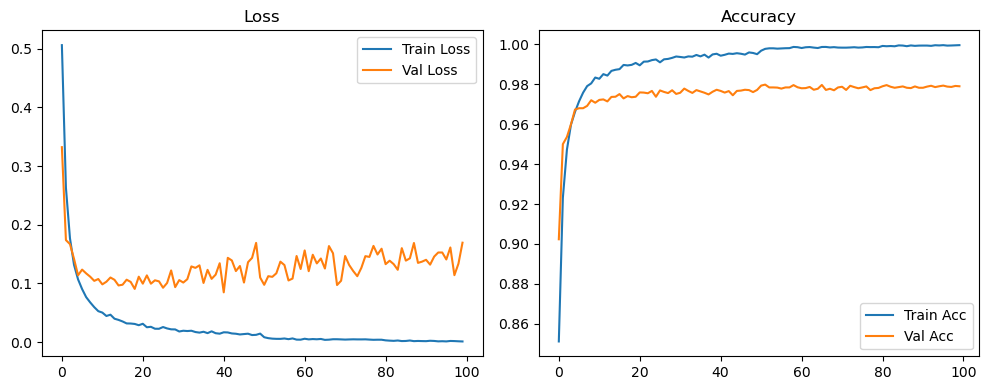

🚀 Running: batch128_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6196, Acc: 0.8168 | Val Loss: 0.3480, Acc: 0.9058


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3530, Acc: 0.8944 | Val Loss: 0.2224, Acc: 0.9318


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2624, Acc: 0.9218 | Val Loss: 0.1952, Acc: 0.9410


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2107, Acc: 0.9363 | Val Loss: 0.1585, Acc: 0.9537


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1810, Acc: 0.9448 | Val Loss: 0.1396, Acc: 0.9571


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1593, Acc: 0.9529 | Val Loss: 0.1422, Acc: 0.9591


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1428, Acc: 0.9558 | Val Loss: 0.1273, Acc: 0.9626


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1220, Acc: 0.9618 | Val Loss: 0.1224, Acc: 0.9659


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1170, Acc: 0.9644 | Val Loss: 0.1140, Acc: 0.9688


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9683 | Val Loss: 0.1107, Acc: 0.9686


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0972, Acc: 0.9693 | Val Loss: 0.1140, Acc: 0.9679


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9731 | Val Loss: 0.1013, Acc: 0.9704


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9733 | Val Loss: 0.1079, Acc: 0.9680


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0803, Acc: 0.9745 | Val Loss: 0.0989, Acc: 0.9738


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0737, Acc: 0.9763 | Val Loss: 0.1140, Acc: 0.9711


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9773 | Val Loss: 0.1006, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0673, Acc: 0.9789 | Val Loss: 0.1127, Acc: 0.9727


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9791 | Val Loss: 0.0996, Acc: 0.9733


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9804 | Val Loss: 0.0973, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9817 | Val Loss: 0.0917, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9821 | Val Loss: 0.1034, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9836 | Val Loss: 0.0975, Acc: 0.9755


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9839 | Val Loss: 0.1167, Acc: 0.9761


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9847 | Val Loss: 0.0953, Acc: 0.9772


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9851 | Val Loss: 0.0918, Acc: 0.9768


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9859 | Val Loss: 0.0904, Acc: 0.9773


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9870 | Val Loss: 0.0925, Acc: 0.9777


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9877 | Val Loss: 0.0960, Acc: 0.9767


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9871 | Val Loss: 0.0945, Acc: 0.9764


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9867 | Val Loss: 0.1023, Acc: 0.9765


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9876 | Val Loss: 0.0995, Acc: 0.9766


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9882 | Val Loss: 0.1087, Acc: 0.9763


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9892 | Val Loss: 0.1118, Acc: 0.9783


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9884 | Val Loss: 0.0955, Acc: 0.9779


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9884 | Val Loss: 0.0800, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9890 | Val Loss: 0.0801, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9894 | Val Loss: 0.1037, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9901 | Val Loss: 0.0955, Acc: 0.9778


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9893 | Val Loss: 0.0851, Acc: 0.9792


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9894 | Val Loss: 0.1186, Acc: 0.9775


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.1120, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.1061, Acc: 0.9785


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0928, Acc: 0.9777


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.0889, Acc: 0.9783


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.0918, Acc: 0.9793


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9919 | Val Loss: 0.1165, Acc: 0.9793


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.0934, Acc: 0.9789


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0789, Acc: 0.9779


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.1162, Acc: 0.9784


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1225, Acc: 0.9779


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.0880, Acc: 0.9792


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.0925, Acc: 0.9803


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.0816, Acc: 0.9799


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.0959, Acc: 0.9796


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9953 | Val Loss: 0.1070, Acc: 0.9801


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.1012, Acc: 0.9802


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0740, Acc: 0.9809


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0977, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.1217, Acc: 0.9796


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1078, Acc: 0.9792


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0945, Acc: 0.9798


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9956 | Val Loss: 0.1036, Acc: 0.9801


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1252, Acc: 0.9798


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0831, Acc: 0.9803


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1352, Acc: 0.9798


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1197, Acc: 0.9801


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0998, Acc: 0.9803


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1222, Acc: 0.9803


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1092, Acc: 0.9797


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1206, Acc: 0.9805


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1182, Acc: 0.9798


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1052, Acc: 0.9803


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1178, Acc: 0.9789


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1124, Acc: 0.9806


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1165, Acc: 0.9798


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1300, Acc: 0.9802


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1261, Acc: 0.9796


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1198, Acc: 0.9812


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0996, Acc: 0.9804


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1125, Acc: 0.9805


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1112, Acc: 0.9803


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1067, Acc: 0.9802


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.0986, Acc: 0.9801


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1281, Acc: 0.9801


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1013, Acc: 0.9806


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1166, Acc: 0.9808


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1092, Acc: 0.9805


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1019, Acc: 0.9802


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1101, Acc: 0.9813


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1252, Acc: 0.9807


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.0956, Acc: 0.9812


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1079, Acc: 0.9812


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0961, Acc: 0.9806


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.0928, Acc: 0.9807


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1124, Acc: 0.9810


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9983 | Val Loss: 0.0874, Acc: 0.9812


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1205, Acc: 0.9813


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1181, Acc: 0.9815


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1261, Acc: 0.9818


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.0922, Acc: 0.9819


Final Test Loss: 0.0882 Accuracy: 0.9839


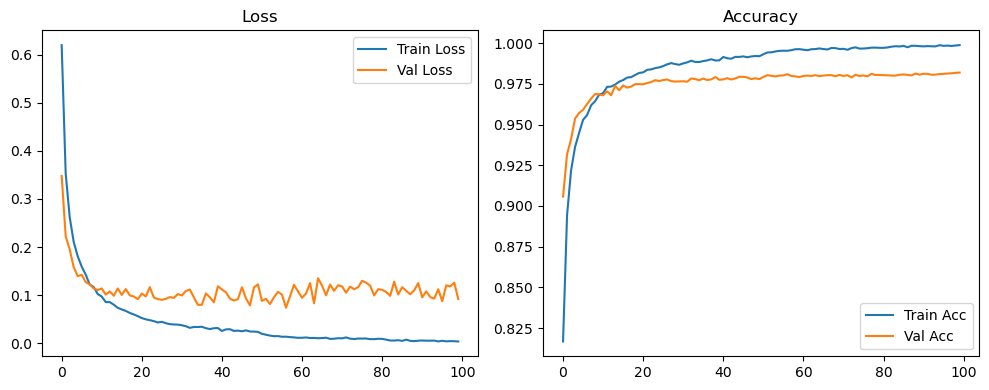

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4658, Acc: 0.8604 | Val Loss: 0.2822, Acc: 0.9196


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1966, Acc: 0.9413 | Val Loss: 0.1698, Acc: 0.9519


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1244, Acc: 0.9621 | Val Loss: 0.1519, Acc: 0.9543


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0860, Acc: 0.9734 | Val Loss: 0.1525, Acc: 0.9600


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9814 | Val Loss: 0.1204, Acc: 0.9653


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9850 | Val Loss: 0.1201, Acc: 0.9692


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9865 | Val Loss: 0.1521, Acc: 0.9611


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.1032, Acc: 0.9728


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.1105, Acc: 0.9718


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.1224, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.1144, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.1086, Acc: 0.9715


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1058, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.1187, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.1635, Acc: 0.9616


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.1341, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1655, Acc: 0.9635


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1265, Acc: 0.9725


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.0932, Acc: 0.9770


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.1396, Acc: 0.9708


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.1479, Acc: 0.9655


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9955 | Val Loss: 0.1656, Acc: 0.9729


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.2321, Acc: 0.9598


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1352, Acc: 0.9743


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.2261, Acc: 0.9529


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1549, Acc: 0.9744


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1161, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1765, Acc: 0.9704


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1876, Acc: 0.9747


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1750, Acc: 0.9749


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1708, Acc: 0.9753


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1842, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1513, Acc: 0.9762


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1624, Acc: 0.9739


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1501, Acc: 0.9688


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1487, Acc: 0.9705


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1465, Acc: 0.9751


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1575, Acc: 0.9744


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1460, Acc: 0.9754


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.2179, Acc: 0.9664


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1737, Acc: 0.9731


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1304, Acc: 0.9753


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1456, Acc: 0.9772


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1687, Acc: 0.9740


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1505, Acc: 0.9765


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1592, Acc: 0.9752


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1643, Acc: 0.9684


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1222, Acc: 0.9778


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1708, Acc: 0.9786


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1538, Acc: 0.9767


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1302, Acc: 0.9787


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1467, Acc: 0.9800


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1360, Acc: 0.9788


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1468, Acc: 0.9798


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1498, Acc: 0.9792


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1766, Acc: 0.9773


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1882, Acc: 0.9769


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1653, Acc: 0.9790


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1645, Acc: 0.9771


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9998 | Val Loss: 0.1884, Acc: 0.9787


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.0736, Acc: 0.9783


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1319, Acc: 0.9793


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1258, Acc: 0.9800


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1744, Acc: 0.9797


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1905, Acc: 0.9775


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1296, Acc: 0.9763


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1232, Acc: 0.9781


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1577, Acc: 0.9799


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1545, Acc: 0.9755


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1204, Acc: 0.9781


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1998, Acc: 0.9788


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1661, Acc: 0.9778


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1250, Acc: 0.9745


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1737, Acc: 0.9791


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1794, Acc: 0.9778


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2120, Acc: 0.9782


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1401, Acc: 0.9792


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1699, Acc: 0.9765


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1489, Acc: 0.9772


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1950, Acc: 0.9788


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1774, Acc: 0.9792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1655, Acc: 0.9796


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9998 | Val Loss: 0.1700, Acc: 0.9792


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1902, Acc: 0.9786


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1926, Acc: 0.9792


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2008, Acc: 0.9787


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2082, Acc: 0.9794


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1785, Acc: 0.9780


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1990, Acc: 0.9778


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2143, Acc: 0.9780


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1853, Acc: 0.9778


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2055, Acc: 0.9782


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2193, Acc: 0.9790


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2277, Acc: 0.9781


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2358, Acc: 0.9778


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2192, Acc: 0.9779


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2222, Acc: 0.9788


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1931, Acc: 0.9786


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1971, Acc: 0.9788


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1994, Acc: 0.9796


Final Test Loss: 0.1754 Accuracy: 0.9814


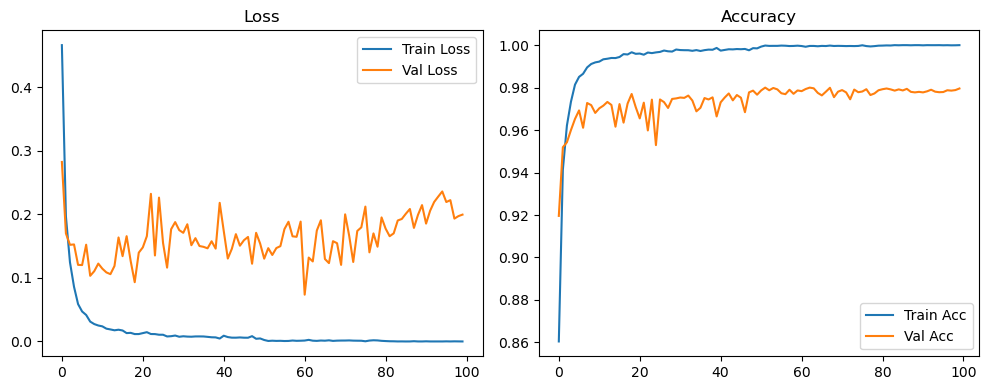

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5060, Acc: 0.8511 | Val Loss: 0.3321, Acc: 0.9023


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2631, Acc: 0.9231 | Val Loss: 0.1738, Acc: 0.9500


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1768, Acc: 0.9472 | Val Loss: 0.1669, Acc: 0.9536


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1316, Acc: 0.9597 | Val Loss: 0.1419, Acc: 0.9599


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1068, Acc: 0.9662 | Val Loss: 0.1138, Acc: 0.9673


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9714 | Val Loss: 0.1235, Acc: 0.9680


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9758 | Val Loss: 0.1171, Acc: 0.9680


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9791 | Val Loss: 0.1114, Acc: 0.9692


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9804 | Val Loss: 0.1043, Acc: 0.9720


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9834 | Val Loss: 0.1075, Acc: 0.9708


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9828 | Val Loss: 0.0984, Acc: 0.9722


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9851 | Val Loss: 0.1028, Acc: 0.9724


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9844 | Val Loss: 0.1101, Acc: 0.9714


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9867 | Val Loss: 0.1061, Acc: 0.9737


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9873 | Val Loss: 0.0965, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9876 | Val Loss: 0.0978, Acc: 0.9751


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9897 | Val Loss: 0.1063, Acc: 0.9729


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9894 | Val Loss: 0.1026, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9897 | Val Loss: 0.0906, Acc: 0.9735


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.1115, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.0996, Acc: 0.9759


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9913 | Val Loss: 0.1137, Acc: 0.9758


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.0995, Acc: 0.9755


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9921 | Val Loss: 0.1053, Acc: 0.9767


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.1035, Acc: 0.9738


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9910 | Val Loss: 0.0926, Acc: 0.9769


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.1007, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9927 | Val Loss: 0.1221, Acc: 0.9756


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9932 | Val Loss: 0.0937, Acc: 0.9770


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1056, Acc: 0.9752


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.1014, Acc: 0.9758


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9934 | Val Loss: 0.1072, Acc: 0.9778


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.1289, Acc: 0.9767


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9938 | Val Loss: 0.1265, Acc: 0.9757


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.1307, Acc: 0.9771


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.1008, Acc: 0.9764


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.1231, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9934 | Val Loss: 0.1078, Acc: 0.9749


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1149, Acc: 0.9762


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1344, Acc: 0.9772


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.0848, Acc: 0.9767


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1436, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1391, Acc: 0.9766


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1210, Acc: 0.9745


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1297, Acc: 0.9767


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.1015, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9949 | Val Loss: 0.1361, Acc: 0.9772


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1435, Acc: 0.9771


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.1691, Acc: 0.9761


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.1100, Acc: 0.9772


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9968 | Val Loss: 0.0976, Acc: 0.9793


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1123, Acc: 0.9798


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1112, Acc: 0.9784


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9980 | Val Loss: 0.1173, Acc: 0.9784


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9979 | Val Loss: 0.1371, Acc: 0.9783


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1312, Acc: 0.9778


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.1050, Acc: 0.9784


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1082, Acc: 0.9784


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1467, Acc: 0.9796


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1246, Acc: 0.9785


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1562, Acc: 0.9780


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1208, Acc: 0.9781


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0052, Acc: 0.9986 | Val Loss: 0.1488, Acc: 0.9787


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1341, Acc: 0.9772


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1424, Acc: 0.9778


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1254, Acc: 0.9797


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1636, Acc: 0.9772


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1514, Acc: 0.9778


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.0973, Acc: 0.9770


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1046, Acc: 0.9784


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1467, Acc: 0.9788


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0045, Acc: 0.9984 | Val Loss: 0.1313, Acc: 0.9772


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1210, Acc: 0.9792


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1123, Acc: 0.9786


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1264, Acc: 0.9780


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1464, Acc: 0.9784


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1452, Acc: 0.9789


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1639, Acc: 0.9771


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1493, Acc: 0.9780


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1591, Acc: 0.9782


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1275, Acc: 0.9790


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1315, Acc: 0.9792


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1362, Acc: 0.9788


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1293, Acc: 0.9789


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1507, Acc: 0.9789


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1379, Acc: 0.9789


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9991 | Val Loss: 0.1357, Acc: 0.9792


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1588, Acc: 0.9788


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1491, Acc: 0.9790


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1468, Acc: 0.9789


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9994 | Val Loss: 0.1449, Acc: 0.9783


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1269, Acc: 0.9788


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.1424, Acc: 0.9791


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1510, Acc: 0.9792


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1449, Acc: 0.9798


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1492, Acc: 0.9797


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1304, Acc: 0.9790


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1219, Acc: 0.9790


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1545, Acc: 0.9793


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1638, Acc: 0.9793


Final Test Loss: 0.1424 Accuracy: 0.9809


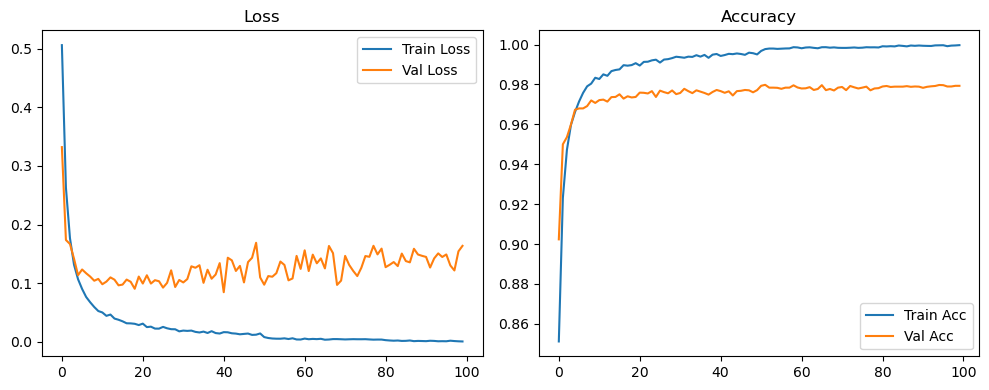

🚀 Running: batch128_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6196, Acc: 0.8168 | Val Loss: 0.3480, Acc: 0.9058


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3530, Acc: 0.8944 | Val Loss: 0.2224, Acc: 0.9318


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2624, Acc: 0.9218 | Val Loss: 0.1952, Acc: 0.9410


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2107, Acc: 0.9363 | Val Loss: 0.1585, Acc: 0.9537


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1810, Acc: 0.9448 | Val Loss: 0.1396, Acc: 0.9571


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1593, Acc: 0.9529 | Val Loss: 0.1422, Acc: 0.9591


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1428, Acc: 0.9558 | Val Loss: 0.1273, Acc: 0.9626


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1220, Acc: 0.9618 | Val Loss: 0.1224, Acc: 0.9659


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1170, Acc: 0.9644 | Val Loss: 0.1140, Acc: 0.9688


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9683 | Val Loss: 0.1107, Acc: 0.9686


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0972, Acc: 0.9693 | Val Loss: 0.1140, Acc: 0.9679


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9731 | Val Loss: 0.1013, Acc: 0.9704


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9733 | Val Loss: 0.1079, Acc: 0.9680


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0803, Acc: 0.9745 | Val Loss: 0.0989, Acc: 0.9738


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0737, Acc: 0.9763 | Val Loss: 0.1140, Acc: 0.9711


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9773 | Val Loss: 0.1006, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0673, Acc: 0.9789 | Val Loss: 0.1127, Acc: 0.9727


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9791 | Val Loss: 0.0996, Acc: 0.9733


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9804 | Val Loss: 0.0973, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9817 | Val Loss: 0.0917, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9821 | Val Loss: 0.1034, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9836 | Val Loss: 0.0975, Acc: 0.9755


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9839 | Val Loss: 0.1167, Acc: 0.9761


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9847 | Val Loss: 0.0953, Acc: 0.9772


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9851 | Val Loss: 0.0918, Acc: 0.9768


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9859 | Val Loss: 0.0904, Acc: 0.9773


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9870 | Val Loss: 0.0925, Acc: 0.9777


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9877 | Val Loss: 0.0960, Acc: 0.9767


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9871 | Val Loss: 0.0945, Acc: 0.9764


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9867 | Val Loss: 0.1023, Acc: 0.9765


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9876 | Val Loss: 0.0995, Acc: 0.9766


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9882 | Val Loss: 0.1087, Acc: 0.9763


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9892 | Val Loss: 0.1118, Acc: 0.9783


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9884 | Val Loss: 0.0955, Acc: 0.9779


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9884 | Val Loss: 0.0800, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9890 | Val Loss: 0.0801, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9894 | Val Loss: 0.1037, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9901 | Val Loss: 0.0955, Acc: 0.9778


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9893 | Val Loss: 0.0851, Acc: 0.9792


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9894 | Val Loss: 0.1186, Acc: 0.9775


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.1120, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.1061, Acc: 0.9785


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0928, Acc: 0.9777


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.0889, Acc: 0.9783


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.0918, Acc: 0.9793


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9919 | Val Loss: 0.1165, Acc: 0.9793


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.0934, Acc: 0.9789


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0789, Acc: 0.9779


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.1162, Acc: 0.9784


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1225, Acc: 0.9779


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9932 | Val Loss: 0.0880, Acc: 0.9792


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9942 | Val Loss: 0.0925, Acc: 0.9803


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0160, Acc: 0.9944 | Val Loss: 0.0816, Acc: 0.9799


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0148, Acc: 0.9949 | Val Loss: 0.0959, Acc: 0.9796


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0150, Acc: 0.9953 | Val Loss: 0.1070, Acc: 0.9801


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.1012, Acc: 0.9802


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.0740, Acc: 0.9809


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.0977, Acc: 0.9798


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9962 | Val Loss: 0.1217, Acc: 0.9796


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9963 | Val Loss: 0.1078, Acc: 0.9792


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.0945, Acc: 0.9798


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0122, Acc: 0.9956 | Val Loss: 0.1036, Acc: 0.9801


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1252, Acc: 0.9798


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9964 | Val Loss: 0.0831, Acc: 0.9803


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1352, Acc: 0.9798


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1197, Acc: 0.9801


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.0998, Acc: 0.9803


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1222, Acc: 0.9803


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1092, Acc: 0.9797


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1206, Acc: 0.9805


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1182, Acc: 0.9798


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0123, Acc: 0.9959 | Val Loss: 0.1052, Acc: 0.9803


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1178, Acc: 0.9789


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1124, Acc: 0.9806


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1165, Acc: 0.9798


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1300, Acc: 0.9802


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1261, Acc: 0.9796


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1198, Acc: 0.9812


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.0996, Acc: 0.9804


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1125, Acc: 0.9805


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9970 | Val Loss: 0.1036, Acc: 0.9804


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1051, Acc: 0.9803


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9978 | Val Loss: 0.1101, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1181, Acc: 0.9807


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1065, Acc: 0.9804


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1099, Acc: 0.9803


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.0997, Acc: 0.9801


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1095, Acc: 0.9802


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9982 | Val Loss: 0.1121, Acc: 0.9813


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1217, Acc: 0.9812


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.0987, Acc: 0.9814


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1109, Acc: 0.9814


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.0912, Acc: 0.9807


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.0952, Acc: 0.9812


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1153, Acc: 0.9809


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.0947, Acc: 0.9810


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1184, Acc: 0.9815


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9983 | Val Loss: 0.1144, Acc: 0.9814


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1184, Acc: 0.9812


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1041, Acc: 0.9813


Final Test Loss: 0.1011 Accuracy: 0.9834


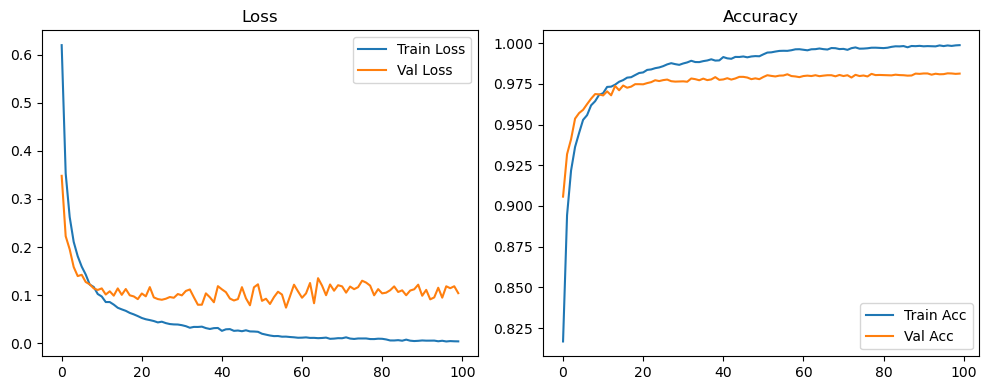

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.4658, Acc: 0.8604 | Val Loss: 0.2822, Acc: 0.9196


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.1966, Acc: 0.9413 | Val Loss: 0.1698, Acc: 0.9519


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1244, Acc: 0.9621 | Val Loss: 0.1519, Acc: 0.9543


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0860, Acc: 0.9734 | Val Loss: 0.1525, Acc: 0.9600


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0588, Acc: 0.9814 | Val Loss: 0.1204, Acc: 0.9653


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0471, Acc: 0.9850 | Val Loss: 0.1201, Acc: 0.9692


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0417, Acc: 0.9865 | Val Loss: 0.1521, Acc: 0.9611


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.1032, Acc: 0.9728


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0273, Acc: 0.9911 | Val Loss: 0.1105, Acc: 0.9718


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9919 | Val Loss: 0.1224, Acc: 0.9681


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9922 | Val Loss: 0.1144, Acc: 0.9702


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.1086, Acc: 0.9715


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1058, Acc: 0.9732


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.1187, Acc: 0.9718


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.1635, Acc: 0.9616


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.1341, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9958 | Val Loss: 0.1655, Acc: 0.9635


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1265, Acc: 0.9725


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9966 | Val Loss: 0.0932, Acc: 0.9770


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9959 | Val Loss: 0.1396, Acc: 0.9708


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0131, Acc: 0.9960 | Val Loss: 0.1479, Acc: 0.9655


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9955 | Val Loss: 0.1656, Acc: 0.9729


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9965 | Val Loss: 0.2321, Acc: 0.9598


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1352, Acc: 0.9743


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.2261, Acc: 0.9529


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9968 | Val Loss: 0.1549, Acc: 0.9744


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1161, Acc: 0.9732


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1765, Acc: 0.9704


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1876, Acc: 0.9747


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1750, Acc: 0.9749


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9977 | Val Loss: 0.1708, Acc: 0.9753


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1842, Acc: 0.9752


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1513, Acc: 0.9762


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1624, Acc: 0.9739


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1501, Acc: 0.9688


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1487, Acc: 0.9705


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1465, Acc: 0.9751


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1575, Acc: 0.9744


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1460, Acc: 0.9754


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.2179, Acc: 0.9664


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0090, Acc: 0.9974 | Val Loss: 0.1737, Acc: 0.9731


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1304, Acc: 0.9753


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1456, Acc: 0.9772


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1687, Acc: 0.9740


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9982 | Val Loss: 0.1505, Acc: 0.9765


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1592, Acc: 0.9752


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1643, Acc: 0.9684


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0083, Acc: 0.9976 | Val Loss: 0.1222, Acc: 0.9778


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1708, Acc: 0.9786


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1538, Acc: 0.9767


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1155, Acc: 0.9796


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1237, Acc: 0.9798


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1499, Acc: 0.9794


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1511, Acc: 0.9804


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1777, Acc: 0.9802


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1962, Acc: 0.9802


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1864, Acc: 0.9804


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1643, Acc: 0.9802


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1653, Acc: 0.9812


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1805, Acc: 0.9808


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2095, Acc: 0.9802


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1884, Acc: 0.9805


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1964, Acc: 0.9804


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2171, Acc: 0.9802


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1645, Acc: 0.9801


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2171, Acc: 0.9770


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1982, Acc: 0.9792


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1675, Acc: 0.9801


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2034, Acc: 0.9802


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1648, Acc: 0.9803


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1920, Acc: 0.9809


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1785, Acc: 0.9798


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1506, Acc: 0.9806


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1781, Acc: 0.9809


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1719, Acc: 0.9801


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1585, Acc: 0.9807


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1938, Acc: 0.9811


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2316, Acc: 0.9800


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1785, Acc: 0.9821


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1643, Acc: 0.9809


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1907, Acc: 0.9808


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2013, Acc: 0.9808


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1975, Acc: 0.9804


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1864, Acc: 0.9801


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2190, Acc: 0.9801


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2157, Acc: 0.9807


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2151, Acc: 0.9804


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2115, Acc: 0.9812


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1971, Acc: 0.9810


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2078, Acc: 0.9802


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2051, Acc: 0.9807


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2199, Acc: 0.9808


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2287, Acc: 0.9810


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1992, Acc: 0.9807


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.2052, Acc: 0.9796


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2064, Acc: 0.9799


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2170, Acc: 0.9811


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1914, Acc: 0.9803


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1943, Acc: 0.9797


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1682, Acc: 0.9802


Final Test Loss: 0.1530 Accuracy: 0.9819


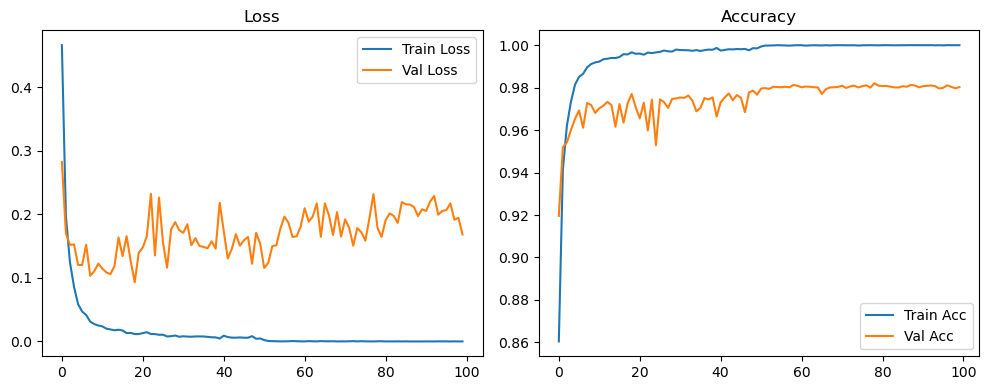

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5060, Acc: 0.8511 | Val Loss: 0.3321, Acc: 0.9023


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2631, Acc: 0.9231 | Val Loss: 0.1738, Acc: 0.9500


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1768, Acc: 0.9472 | Val Loss: 0.1669, Acc: 0.9536


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1316, Acc: 0.9597 | Val Loss: 0.1419, Acc: 0.9599


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1068, Acc: 0.9662 | Val Loss: 0.1138, Acc: 0.9673


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0903, Acc: 0.9714 | Val Loss: 0.1235, Acc: 0.9680


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0766, Acc: 0.9758 | Val Loss: 0.1171, Acc: 0.9680


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0676, Acc: 0.9791 | Val Loss: 0.1114, Acc: 0.9692


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0595, Acc: 0.9804 | Val Loss: 0.1043, Acc: 0.9720


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9834 | Val Loss: 0.1075, Acc: 0.9708


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0503, Acc: 0.9828 | Val Loss: 0.0984, Acc: 0.9722


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0445, Acc: 0.9851 | Val Loss: 0.1028, Acc: 0.9724


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0467, Acc: 0.9844 | Val Loss: 0.1101, Acc: 0.9714


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0398, Acc: 0.9867 | Val Loss: 0.1061, Acc: 0.9737


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0378, Acc: 0.9873 | Val Loss: 0.0965, Acc: 0.9738


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0352, Acc: 0.9876 | Val Loss: 0.0978, Acc: 0.9751


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0318, Acc: 0.9897 | Val Loss: 0.1063, Acc: 0.9729


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0316, Acc: 0.9894 | Val Loss: 0.1026, Acc: 0.9741


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0309, Acc: 0.9897 | Val Loss: 0.0906, Acc: 0.9735


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9907 | Val Loss: 0.1115, Acc: 0.9738


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0312, Acc: 0.9895 | Val Loss: 0.0996, Acc: 0.9759


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0253, Acc: 0.9913 | Val Loss: 0.1137, Acc: 0.9758


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9914 | Val Loss: 0.0995, Acc: 0.9755


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0228, Acc: 0.9921 | Val Loss: 0.1053, Acc: 0.9767


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.1035, Acc: 0.9738


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9910 | Val Loss: 0.0926, Acc: 0.9769


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0233, Acc: 0.9925 | Val Loss: 0.1007, Acc: 0.9762


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0217, Acc: 0.9927 | Val Loss: 0.1221, Acc: 0.9756


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9932 | Val Loss: 0.0937, Acc: 0.9770


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0181, Acc: 0.9939 | Val Loss: 0.1056, Acc: 0.9752


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.1014, Acc: 0.9758


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0188, Acc: 0.9934 | Val Loss: 0.1072, Acc: 0.9778


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9940 | Val Loss: 0.1289, Acc: 0.9767


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9938 | Val Loss: 0.1265, Acc: 0.9757


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0161, Acc: 0.9947 | Val Loss: 0.1307, Acc: 0.9771


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0176, Acc: 0.9940 | Val Loss: 0.1008, Acc: 0.9764


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.1231, Acc: 0.9758


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9934 | Val Loss: 0.1078, Acc: 0.9749


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1149, Acc: 0.9762


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1344, Acc: 0.9772


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.0848, Acc: 0.9767


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1436, Acc: 0.9758


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9954 | Val Loss: 0.1391, Acc: 0.9766


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0142, Acc: 0.9952 | Val Loss: 0.1210, Acc: 0.9745


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1297, Acc: 0.9767


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9953 | Val Loss: 0.1015, Acc: 0.9768


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9949 | Val Loss: 0.1361, Acc: 0.9772


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1435, Acc: 0.9771


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9957 | Val Loss: 0.1691, Acc: 0.9761


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9951 | Val Loss: 0.1100, Acc: 0.9772


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1076, Acc: 0.9790


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9981 | Val Loss: 0.1137, Acc: 0.9791


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1037, Acc: 0.9794


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1181, Acc: 0.9798


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1398, Acc: 0.9788


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9985 | Val Loss: 0.1271, Acc: 0.9798


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1142, Acc: 0.9793


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1017, Acc: 0.9794


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1336, Acc: 0.9792


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1341, Acc: 0.9800


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1046, Acc: 0.9792


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1057, Acc: 0.9803


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1296, Acc: 0.9809


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1244, Acc: 0.9792


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1284, Acc: 0.9798


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1229, Acc: 0.9792


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1430, Acc: 0.9790


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1328, Acc: 0.9788


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1113, Acc: 0.9784


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1327, Acc: 0.9794


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1444, Acc: 0.9797


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1536, Acc: 0.9796


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1165, Acc: 0.9802


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9991 | Val Loss: 0.1175, Acc: 0.9794


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1139, Acc: 0.9798


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1334, Acc: 0.9791


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1345, Acc: 0.9802


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1385, Acc: 0.9794


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9993 | Val Loss: 0.1470, Acc: 0.9790


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1509, Acc: 0.9803


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1530, Acc: 0.9804


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1379, Acc: 0.9802


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1269, Acc: 0.9804


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1308, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1396, Acc: 0.9803


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1473, Acc: 0.9800


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1418, Acc: 0.9800


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1558, Acc: 0.9800


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1656, Acc: 0.9799


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1411, Acc: 0.9796


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1370, Acc: 0.9800


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1403, Acc: 0.9799


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1530, Acc: 0.9795


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1481, Acc: 0.9792


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1542, Acc: 0.9794


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1704, Acc: 0.9799


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1439, Acc: 0.9796


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1204, Acc: 0.9798


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1549, Acc: 0.9798


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1507, Acc: 0.9808


Final Test Loss: 0.1285 Accuracy: 0.9824


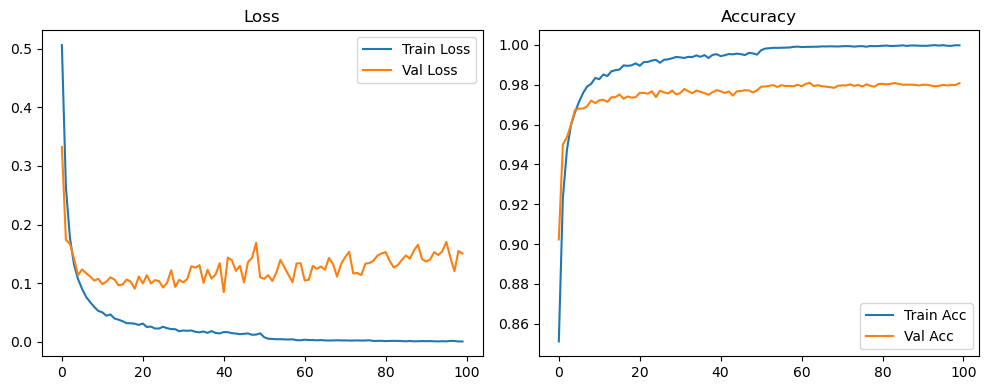

🚀 Running: batch128_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6196, Acc: 0.8168 | Val Loss: 0.3480, Acc: 0.9058


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3530, Acc: 0.8944 | Val Loss: 0.2224, Acc: 0.9318


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2624, Acc: 0.9218 | Val Loss: 0.1952, Acc: 0.9410


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2107, Acc: 0.9363 | Val Loss: 0.1585, Acc: 0.9537


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1810, Acc: 0.9448 | Val Loss: 0.1396, Acc: 0.9571


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1593, Acc: 0.9529 | Val Loss: 0.1422, Acc: 0.9591


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1428, Acc: 0.9558 | Val Loss: 0.1273, Acc: 0.9626


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1220, Acc: 0.9618 | Val Loss: 0.1224, Acc: 0.9659


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1170, Acc: 0.9644 | Val Loss: 0.1140, Acc: 0.9688


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1023, Acc: 0.9683 | Val Loss: 0.1107, Acc: 0.9686


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0972, Acc: 0.9693 | Val Loss: 0.1140, Acc: 0.9679


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9731 | Val Loss: 0.1013, Acc: 0.9704


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0856, Acc: 0.9733 | Val Loss: 0.1079, Acc: 0.9680


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0803, Acc: 0.9745 | Val Loss: 0.0989, Acc: 0.9738


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0737, Acc: 0.9763 | Val Loss: 0.1140, Acc: 0.9711


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0704, Acc: 0.9773 | Val Loss: 0.1006, Acc: 0.9740


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0673, Acc: 0.9789 | Val Loss: 0.1127, Acc: 0.9727


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0630, Acc: 0.9791 | Val Loss: 0.0996, Acc: 0.9733


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0600, Acc: 0.9804 | Val Loss: 0.0973, Acc: 0.9748


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0564, Acc: 0.9817 | Val Loss: 0.0917, Acc: 0.9748


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0525, Acc: 0.9821 | Val Loss: 0.1034, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0498, Acc: 0.9836 | Val Loss: 0.0975, Acc: 0.9755


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0481, Acc: 0.9839 | Val Loss: 0.1167, Acc: 0.9761


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0461, Acc: 0.9847 | Val Loss: 0.0953, Acc: 0.9772


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0433, Acc: 0.9851 | Val Loss: 0.0918, Acc: 0.9768


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0448, Acc: 0.9859 | Val Loss: 0.0904, Acc: 0.9773


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0418, Acc: 0.9870 | Val Loss: 0.0925, Acc: 0.9777


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0399, Acc: 0.9877 | Val Loss: 0.0960, Acc: 0.9767


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0391, Acc: 0.9871 | Val Loss: 0.0945, Acc: 0.9764


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0389, Acc: 0.9867 | Val Loss: 0.1023, Acc: 0.9765


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0375, Acc: 0.9876 | Val Loss: 0.0995, Acc: 0.9766


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0354, Acc: 0.9882 | Val Loss: 0.1087, Acc: 0.9763


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0322, Acc: 0.9892 | Val Loss: 0.1118, Acc: 0.9783


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0339, Acc: 0.9884 | Val Loss: 0.0955, Acc: 0.9779


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0338, Acc: 0.9884 | Val Loss: 0.0800, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0345, Acc: 0.9890 | Val Loss: 0.0801, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0315, Acc: 0.9894 | Val Loss: 0.1037, Acc: 0.9773


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9901 | Val Loss: 0.0955, Acc: 0.9778


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0314, Acc: 0.9893 | Val Loss: 0.0851, Acc: 0.9792


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0317, Acc: 0.9894 | Val Loss: 0.1186, Acc: 0.9775


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0257, Acc: 0.9915 | Val Loss: 0.1120, Acc: 0.9778


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9907 | Val Loss: 0.1061, Acc: 0.9785


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0293, Acc: 0.9904 | Val Loss: 0.0928, Acc: 0.9777


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.0889, Acc: 0.9783


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9915 | Val Loss: 0.0918, Acc: 0.9793


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0250, Acc: 0.9919 | Val Loss: 0.1165, Acc: 0.9793


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0269, Acc: 0.9913 | Val Loss: 0.0934, Acc: 0.9789


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9919 | Val Loss: 0.0789, Acc: 0.9779


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0244, Acc: 0.9921 | Val Loss: 0.1162, Acc: 0.9784


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0238, Acc: 0.9920 | Val Loss: 0.1225, Acc: 0.9779


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9933 | Val Loss: 0.0907, Acc: 0.9788


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0172, Acc: 0.9939 | Val Loss: 0.0984, Acc: 0.9798


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.0914, Acc: 0.9801


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.1036, Acc: 0.9799


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9951 | Val Loss: 0.1037, Acc: 0.9803


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1074, Acc: 0.9799


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9957 | Val Loss: 0.0992, Acc: 0.9807


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1057, Acc: 0.9808


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.0981, Acc: 0.9808


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.0924, Acc: 0.9802


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9971 | Val Loss: 0.0948, Acc: 0.9810


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9965 | Val Loss: 0.0955, Acc: 0.9802


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1180, Acc: 0.9808


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9969 | Val Loss: 0.0941, Acc: 0.9811


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1148, Acc: 0.9808


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1072, Acc: 0.9815


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9968 | Val Loss: 0.1129, Acc: 0.9812


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1104, Acc: 0.9812


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1141, Acc: 0.9802


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1036, Acc: 0.9810


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1110, Acc: 0.9812


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1040, Acc: 0.9808


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1139, Acc: 0.9805


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9979 | Val Loss: 0.1106, Acc: 0.9806


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9976 | Val Loss: 0.1128, Acc: 0.9801


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1258, Acc: 0.9808


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1141, Acc: 0.9810


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0062, Acc: 0.9978 | Val Loss: 0.1059, Acc: 0.9818


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.0924, Acc: 0.9813


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.0974, Acc: 0.9810


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1100, Acc: 0.9806


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1138, Acc: 0.9808


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1111, Acc: 0.9809


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1225, Acc: 0.9809


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1191, Acc: 0.9808


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1181, Acc: 0.9805


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1156, Acc: 0.9806


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1151, Acc: 0.9808


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1087, Acc: 0.9807


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1248, Acc: 0.9802


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1119, Acc: 0.9807


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9984 | Val Loss: 0.1076, Acc: 0.9810


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1056, Acc: 0.9805


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1105, Acc: 0.9808


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1152, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.1034, Acc: 0.9814


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1327, Acc: 0.9808


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1275, Acc: 0.9808


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1214, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1116, Acc: 0.9812


Final Test Loss: 0.1015 Accuracy: 0.9828


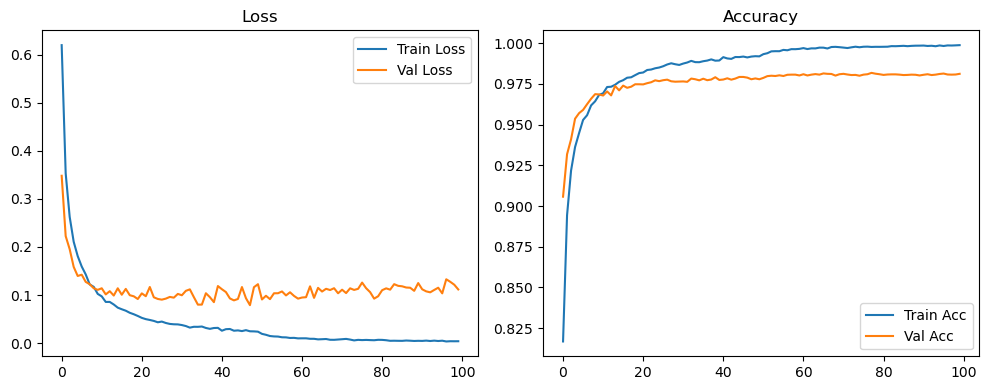

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4097, Acc: 0.8749 | Val Loss: 0.2627, Acc: 0.9217


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1819, Acc: 0.9451 | Val Loss: 0.1799, Acc: 0.9462


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1057, Acc: 0.9676 | Val Loss: 0.1210, Acc: 0.9644


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9789 | Val Loss: 0.1679, Acc: 0.9553


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9837 | Val Loss: 0.1332, Acc: 0.9666


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9871 | Val Loss: 0.1175, Acc: 0.9705


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9890 | Val Loss: 0.1346, Acc: 0.9687


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 0.1327, Acc: 0.9682


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9917 | Val Loss: 0.1206, Acc: 0.9718


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9916 | Val Loss: 0.1375, Acc: 0.9676


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.1485, Acc: 0.9651


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.1154, Acc: 0.9719


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.3714, Acc: 0.9281


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.1666, Acc: 0.9677


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9947 | Val Loss: 0.1212, Acc: 0.9752


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1131, Acc: 0.9754


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9961 | Val Loss: 0.1847, Acc: 0.9616


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1662, Acc: 0.9687


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.2109, Acc: 0.9617


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1375, Acc: 0.9761


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1267, Acc: 0.9753


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1162, Acc: 0.9773


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1306, Acc: 0.9754


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.1133, Acc: 0.9763


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1235, Acc: 0.9783


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1439, Acc: 0.9755


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9975 | Val Loss: 0.1343, Acc: 0.9712


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1246, Acc: 0.9773


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1443, Acc: 0.9702


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1368, Acc: 0.9771


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.2122, Acc: 0.9694


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1211, Acc: 0.9715


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1510, Acc: 0.9674


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1332, Acc: 0.9757


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1712, Acc: 0.9654


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1531, Acc: 0.9728


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1081, Acc: 0.9769


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1444, Acc: 0.9726


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1514, Acc: 0.9680


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1358, Acc: 0.9732


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1432, Acc: 0.9753


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1449, Acc: 0.9737


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1602, Acc: 0.9718


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1476, Acc: 0.9764


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1201, Acc: 0.9772


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1341, Acc: 0.9757


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1286, Acc: 0.9747


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1364, Acc: 0.9771


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1229, Acc: 0.9729


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.1451, Acc: 0.9756


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.2334, Acc: 0.9558


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1277, Acc: 0.9795


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1460, Acc: 0.9763


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1261, Acc: 0.9791


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1912, Acc: 0.9681


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1564, Acc: 0.9758


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1647, Acc: 0.9721


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1211, Acc: 0.9769


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.2029, Acc: 0.9634


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1191, Acc: 0.9780


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1424, Acc: 0.9778


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1552, Acc: 0.9746


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.2125, Acc: 0.9684


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1566, Acc: 0.9754


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1352, Acc: 0.9759


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1491, Acc: 0.9788


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.2088, Acc: 0.9663


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1179, Acc: 0.9758


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.7573, Acc: 0.8942


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1536, Acc: 0.9758


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1388, Acc: 0.9779


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1475, Acc: 0.9797


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1730, Acc: 0.9758


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1751, Acc: 0.9762


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1392, Acc: 0.9783


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.4498, Acc: 0.9327


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1408, Acc: 0.9772


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1546, Acc: 0.9786


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1513, Acc: 0.9737


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1168, Acc: 0.9783


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1434, Acc: 0.9716


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1458, Acc: 0.9777


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1443, Acc: 0.9770


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1170, Acc: 0.9686


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1560, Acc: 0.9758


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9996 | Val Loss: 0.1602, Acc: 0.9788


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1837, Acc: 0.9771


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1426, Acc: 0.9802


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1479, Acc: 0.9787


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1461, Acc: 0.9696


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1484, Acc: 0.9792


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1166, Acc: 0.9792


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.4203, Acc: 0.9434


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1136, Acc: 0.9730


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1686, Acc: 0.9792


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1334, Acc: 0.9752


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1860, Acc: 0.9725


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1586, Acc: 0.9759


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2092, Acc: 0.9670


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.4190, Acc: 0.9303


Final Test Loss: 0.3970 Accuracy: 0.9333


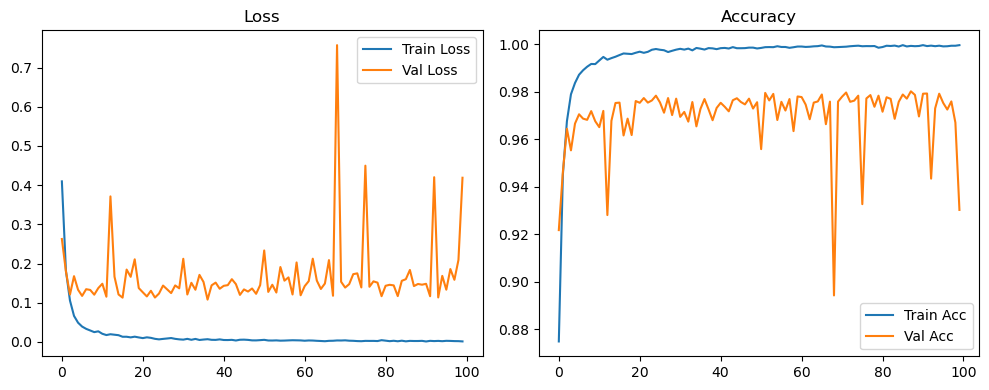

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4513, Acc: 0.8613 | Val Loss: 0.3327, Acc: 0.9013


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2706, Acc: 0.9173 | Val Loss: 0.2010, Acc: 0.9399


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1944, Acc: 0.9413 | Val Loss: 0.1697, Acc: 0.9508


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1483, Acc: 0.9550 | Val Loss: 0.1543, Acc: 0.9563


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1194, Acc: 0.9629 | Val Loss: 0.1211, Acc: 0.9623


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1016, Acc: 0.9684 | Val Loss: 0.1319, Acc: 0.9630


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0889, Acc: 0.9721 | Val Loss: 0.1066, Acc: 0.9683


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0761, Acc: 0.9764 | Val Loss: 0.1062, Acc: 0.9686


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9784 | Val Loss: 0.0973, Acc: 0.9730


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9812 | Val Loss: 0.1038, Acc: 0.9715


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9827 | Val Loss: 0.1098, Acc: 0.9710


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9842 | Val Loss: 0.1094, Acc: 0.9718


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9850 | Val Loss: 0.1115, Acc: 0.9718


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9868 | Val Loss: 0.1041, Acc: 0.9734


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9871 | Val Loss: 0.1098, Acc: 0.9732


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9880 | Val Loss: 0.1020, Acc: 0.9728


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.1048, Acc: 0.9722


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.1213, Acc: 0.9737


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9901 | Val Loss: 0.1080, Acc: 0.9722


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9905 | Val Loss: 0.1257, Acc: 0.9751


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.1119, Acc: 0.9746


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9918 | Val Loss: 0.1095, Acc: 0.9762


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.1084, Acc: 0.9752


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9922 | Val Loss: 0.1009, Acc: 0.9770


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9924 | Val Loss: 0.1103, Acc: 0.9741


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1016, Acc: 0.9757


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9924 | Val Loss: 0.1025, Acc: 0.9761


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9931 | Val Loss: 0.1132, Acc: 0.9756


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9932 | Val Loss: 0.0937, Acc: 0.9772


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.1137, Acc: 0.9744


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9940 | Val Loss: 0.1094, Acc: 0.9759


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1066, Acc: 0.9770


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1187, Acc: 0.9752


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1153, Acc: 0.9752


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.1087, Acc: 0.9771


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1373, Acc: 0.9763


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.1023, Acc: 0.9769


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.1195, Acc: 0.9768


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.1024, Acc: 0.9769


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.1128, Acc: 0.9749


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.1123, Acc: 0.9751


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.1152, Acc: 0.9751


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1098, Acc: 0.9776


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1291, Acc: 0.9742


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1326, Acc: 0.9759


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1319, Acc: 0.9753


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1213, Acc: 0.9773


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1035, Acc: 0.9759


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1477, Acc: 0.9767


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1227, Acc: 0.9774


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9963 | Val Loss: 0.1358, Acc: 0.9766


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9965 | Val Loss: 0.1327, Acc: 0.9776


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0109, Acc: 0.9963 | Val Loss: 0.1065, Acc: 0.9784


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.1204, Acc: 0.9752


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1146, Acc: 0.9763


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1279, Acc: 0.9777


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1309, Acc: 0.9766


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1089, Acc: 0.9778


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9966 | Val Loss: 0.1287, Acc: 0.9785


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.1260, Acc: 0.9770


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1119, Acc: 0.9787


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1119, Acc: 0.9774


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1474, Acc: 0.9776


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9971 | Val Loss: 0.1022, Acc: 0.9781


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1391, Acc: 0.9772


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1172, Acc: 0.9778


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1446, Acc: 0.9782


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1189, Acc: 0.9782


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1015, Acc: 0.9776


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1171, Acc: 0.9775


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1435, Acc: 0.9778


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9971 | Val Loss: 0.1439, Acc: 0.9788


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1343, Acc: 0.9792


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1423, Acc: 0.9783


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0091, Acc: 0.9967 | Val Loss: 0.1349, Acc: 0.9786


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9976 | Val Loss: 0.1200, Acc: 0.9785


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1210, Acc: 0.9778


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1118, Acc: 0.9771


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1344, Acc: 0.9780


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9973 | Val Loss: 0.1068, Acc: 0.9785


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1470, Acc: 0.9774


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9976 | Val Loss: 0.1054, Acc: 0.9778


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1232, Acc: 0.9762


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9975 | Val Loss: 0.1157, Acc: 0.9793


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1206, Acc: 0.9766


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1138, Acc: 0.9777


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9972 | Val Loss: 0.1233, Acc: 0.9781


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1245, Acc: 0.9786


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1339, Acc: 0.9778


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1471, Acc: 0.9785


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0064, Acc: 0.9979 | Val Loss: 0.1239, Acc: 0.9771


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9973 | Val Loss: 0.1547, Acc: 0.9778


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1289, Acc: 0.9782


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1252, Acc: 0.9782


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1126, Acc: 0.9782


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9981 | Val Loss: 0.1078, Acc: 0.9798


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1306, Acc: 0.9788


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1164, Acc: 0.9788


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1355, Acc: 0.9791


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1440, Acc: 0.9780


Final Test Loss: 0.1272 Accuracy: 0.9800


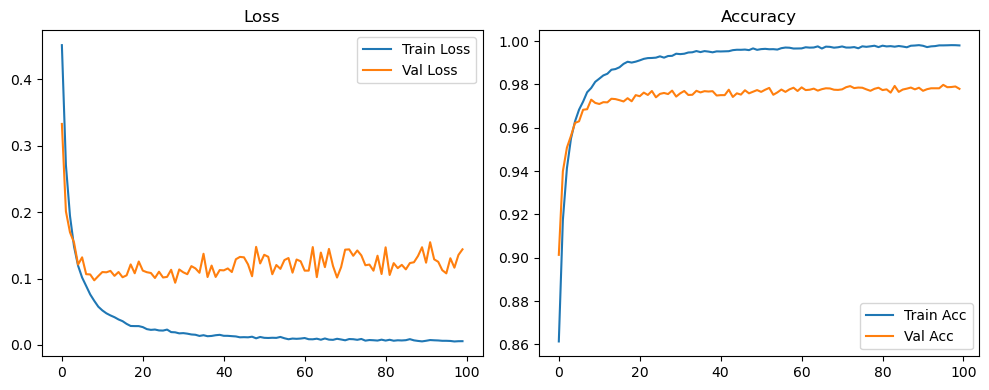

🚀 Running: batch128_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5670, Acc: 0.8249 | Val Loss: 0.3401, Acc: 0.8999


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3716, Acc: 0.8872 | Val Loss: 0.2360, Acc: 0.9291


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2942, Acc: 0.9111 | Val Loss: 0.2099, Acc: 0.9379


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2403, Acc: 0.9282 | Val Loss: 0.1787, Acc: 0.9471


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2095, Acc: 0.9374 | Val Loss: 0.1539, Acc: 0.9534


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1901, Acc: 0.9429 | Val Loss: 0.1545, Acc: 0.9544


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1766, Acc: 0.9456 | Val Loss: 0.1430, Acc: 0.9590


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1523, Acc: 0.9533 | Val Loss: 0.1384, Acc: 0.9603


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1464, Acc: 0.9552 | Val Loss: 0.1260, Acc: 0.9634


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1323, Acc: 0.9597 | Val Loss: 0.1256, Acc: 0.9633


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1288, Acc: 0.9607 | Val Loss: 0.1284, Acc: 0.9633


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1152, Acc: 0.9639 | Val Loss: 0.1137, Acc: 0.9677


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1111, Acc: 0.9658 | Val Loss: 0.1191, Acc: 0.9671


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1047, Acc: 0.9677 | Val Loss: 0.1115, Acc: 0.9700


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0998, Acc: 0.9687 | Val Loss: 0.1152, Acc: 0.9681


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0948, Acc: 0.9700 | Val Loss: 0.1070, Acc: 0.9710


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0867, Acc: 0.9726 | Val Loss: 0.1101, Acc: 0.9693


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0867, Acc: 0.9729 | Val Loss: 0.1110, Acc: 0.9673


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0807, Acc: 0.9746 | Val Loss: 0.1108, Acc: 0.9681


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0771, Acc: 0.9753 | Val Loss: 0.1034, Acc: 0.9725


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9765 | Val Loss: 0.1066, Acc: 0.9718


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0706, Acc: 0.9778 | Val Loss: 0.0961, Acc: 0.9722


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9776 | Val Loss: 0.1143, Acc: 0.9726


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9786 | Val Loss: 0.1064, Acc: 0.9726


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0612, Acc: 0.9802 | Val Loss: 0.1010, Acc: 0.9728


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9805 | Val Loss: 0.1043, Acc: 0.9742


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9799 | Val Loss: 0.1057, Acc: 0.9741


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9818 | Val Loss: 0.1029, Acc: 0.9728


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9812 | Val Loss: 0.0980, Acc: 0.9752


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9820 | Val Loss: 0.0991, Acc: 0.9740


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9831 | Val Loss: 0.0961, Acc: 0.9750


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9832 | Val Loss: 0.0967, Acc: 0.9750


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9852 | Val Loss: 0.1067, Acc: 0.9751


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9844 | Val Loss: 0.0999, Acc: 0.9741


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9851 | Val Loss: 0.1054, Acc: 0.9748


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9854 | Val Loss: 0.1036, Acc: 0.9755


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9858 | Val Loss: 0.1171, Acc: 0.9758


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9865 | Val Loss: 0.1020, Acc: 0.9753


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9857 | Val Loss: 0.0954, Acc: 0.9754


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9871 | Val Loss: 0.0958, Acc: 0.9756


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 0.0990, Acc: 0.9748


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 0.1046, Acc: 0.9773


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9875 | Val Loss: 0.1033, Acc: 0.9748


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9869 | Val Loss: 0.0984, Acc: 0.9759


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9877 | Val Loss: 0.1004, Acc: 0.9763


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9885 | Val Loss: 0.0907, Acc: 0.9756


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.1034, Acc: 0.9766


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9884 | Val Loss: 0.0936, Acc: 0.9761


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9885 | Val Loss: 0.1087, Acc: 0.9752


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9890 | Val Loss: 0.1049, Acc: 0.9762


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0333, Acc: 0.9885 | Val Loss: 0.0951, Acc: 0.9769


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9893 | Val Loss: 0.0961, Acc: 0.9765


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0309, Acc: 0.9894 | Val Loss: 0.1088, Acc: 0.9765


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0305, Acc: 0.9896 | Val Loss: 0.1049, Acc: 0.9768


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9898 | Val Loss: 0.0920, Acc: 0.9766


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9905 | Val Loss: 0.0986, Acc: 0.9751


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0292, Acc: 0.9900 | Val Loss: 0.0845, Acc: 0.9773


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9908 | Val Loss: 0.0893, Acc: 0.9773


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0288, Acc: 0.9902 | Val Loss: 0.0963, Acc: 0.9771


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9902 | Val Loss: 0.1008, Acc: 0.9772


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0298, Acc: 0.9901 | Val Loss: 0.1000, Acc: 0.9762


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0280, Acc: 0.9903 | Val Loss: 0.1099, Acc: 0.9773


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9908 | Val Loss: 0.1071, Acc: 0.9769


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9916 | Val Loss: 0.1133, Acc: 0.9765


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0252, Acc: 0.9915 | Val Loss: 0.1079, Acc: 0.9762


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.1061, Acc: 0.9767


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0276, Acc: 0.9907 | Val Loss: 0.0884, Acc: 0.9769


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0260, Acc: 0.9908 | Val Loss: 0.1006, Acc: 0.9766


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0258, Acc: 0.9912 | Val Loss: 0.1000, Acc: 0.9772


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0240, Acc: 0.9922 | Val Loss: 0.0865, Acc: 0.9779


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0244, Acc: 0.9917 | Val Loss: 0.0881, Acc: 0.9779


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.1020, Acc: 0.9765


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0212, Acc: 0.9932 | Val Loss: 0.1045, Acc: 0.9781


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0227, Acc: 0.9925 | Val Loss: 0.1004, Acc: 0.9768


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.1101, Acc: 0.9765


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9916 | Val Loss: 0.1011, Acc: 0.9771


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9924 | Val Loss: 0.0952, Acc: 0.9776


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0215, Acc: 0.9925 | Val Loss: 0.0917, Acc: 0.9775


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0206, Acc: 0.9933 | Val Loss: 0.1091, Acc: 0.9779


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0225, Acc: 0.9923 | Val Loss: 0.0951, Acc: 0.9770


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9916 | Val Loss: 0.0927, Acc: 0.9782


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9931 | Val Loss: 0.1060, Acc: 0.9769


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9930 | Val Loss: 0.1039, Acc: 0.9774


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0220, Acc: 0.9929 | Val Loss: 0.0993, Acc: 0.9773


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0205, Acc: 0.9927 | Val Loss: 0.0922, Acc: 0.9780


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.1081, Acc: 0.9782


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0204, Acc: 0.9926 | Val Loss: 0.1104, Acc: 0.9779


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.0880, Acc: 0.9782


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9930 | Val Loss: 0.1165, Acc: 0.9785


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9933 | Val Loss: 0.1009, Acc: 0.9781


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0193, Acc: 0.9938 | Val Loss: 0.1121, Acc: 0.9778


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9928 | Val Loss: 0.1018, Acc: 0.9773


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.0915, Acc: 0.9782


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.0831, Acc: 0.9793


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0188, Acc: 0.9940 | Val Loss: 0.0948, Acc: 0.9782


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0178, Acc: 0.9936 | Val Loss: 0.0992, Acc: 0.9771


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.0999, Acc: 0.9769


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0177, Acc: 0.9939 | Val Loss: 0.1071, Acc: 0.9766


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9941 | Val Loss: 0.0921, Acc: 0.9777


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9942 | Val Loss: 0.1290, Acc: 0.9778


Final Test Loss: 0.1093 Accuracy: 0.9801


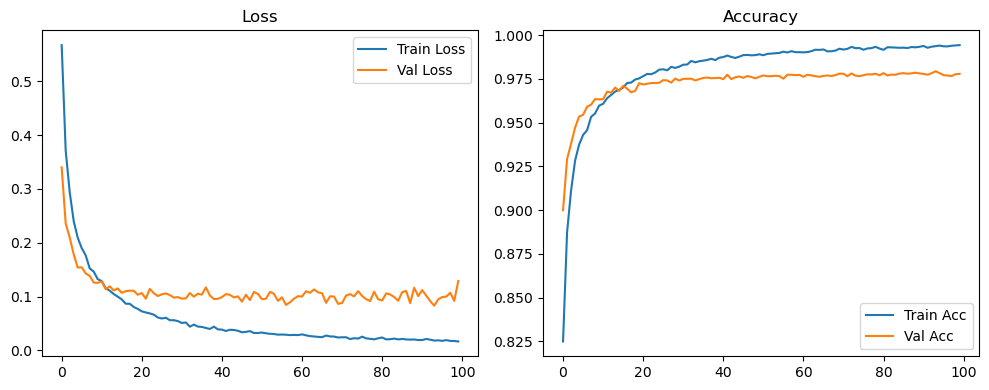

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4097, Acc: 0.8749 | Val Loss: 0.2627, Acc: 0.9217


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.1819, Acc: 0.9451 | Val Loss: 0.1799, Acc: 0.9462


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1057, Acc: 0.9676 | Val Loss: 0.1210, Acc: 0.9644


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9789 | Val Loss: 0.1679, Acc: 0.9553


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0491, Acc: 0.9837 | Val Loss: 0.1332, Acc: 0.9666


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0393, Acc: 0.9871 | Val Loss: 0.1175, Acc: 0.9705


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0334, Acc: 0.9890 | Val Loss: 0.1346, Acc: 0.9687


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0293, Acc: 0.9905 | Val Loss: 0.1327, Acc: 0.9682


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0251, Acc: 0.9917 | Val Loss: 0.1206, Acc: 0.9718


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0271, Acc: 0.9916 | Val Loss: 0.1375, Acc: 0.9676


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.1485, Acc: 0.9651


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0176, Acc: 0.9946 | Val Loss: 0.1154, Acc: 0.9719


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.3714, Acc: 0.9281


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.1666, Acc: 0.9677


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0173, Acc: 0.9947 | Val Loss: 0.1212, Acc: 0.9752


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1131, Acc: 0.9754


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9961 | Val Loss: 0.1847, Acc: 0.9616


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9960 | Val Loss: 0.1662, Acc: 0.9687


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.2109, Acc: 0.9617


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1375, Acc: 0.9761


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9969 | Val Loss: 0.1267, Acc: 0.9753


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9964 | Val Loss: 0.1162, Acc: 0.9773


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1306, Acc: 0.9754


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.1133, Acc: 0.9763


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1235, Acc: 0.9783


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1439, Acc: 0.9755


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9975 | Val Loss: 0.1343, Acc: 0.9712


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9967 | Val Loss: 0.1246, Acc: 0.9773


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1443, Acc: 0.9702


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1368, Acc: 0.9771


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.2122, Acc: 0.9694


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1211, Acc: 0.9715


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1510, Acc: 0.9674


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1332, Acc: 0.9757


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1712, Acc: 0.9654


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1531, Acc: 0.9728


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1081, Acc: 0.9769


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1444, Acc: 0.9726


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1514, Acc: 0.9680


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1358, Acc: 0.9732


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1432, Acc: 0.9753


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1449, Acc: 0.9737


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1602, Acc: 0.9718


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1476, Acc: 0.9764


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1201, Acc: 0.9772


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9983 | Val Loss: 0.1341, Acc: 0.9757


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9984 | Val Loss: 0.1286, Acc: 0.9747


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1364, Acc: 0.9771


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1229, Acc: 0.9729


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9982 | Val Loss: 0.1451, Acc: 0.9756


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1283, Acc: 0.9810


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1441, Acc: 0.9792


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1551, Acc: 0.9806


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1494, Acc: 0.9811


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1709, Acc: 0.9800


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1770, Acc: 0.9793


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1617, Acc: 0.9780


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1667, Acc: 0.9802


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1888, Acc: 0.9795


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1469, Acc: 0.9797


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1768, Acc: 0.9791


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1557, Acc: 0.9780


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1436, Acc: 0.9779


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1715, Acc: 0.9798


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1545, Acc: 0.9786


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1440, Acc: 0.9789


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1934, Acc: 0.9778


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1677, Acc: 0.9795


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1857, Acc: 0.9742


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1515, Acc: 0.9792


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1449, Acc: 0.9805


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1626, Acc: 0.9800


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.2004, Acc: 0.9788


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1763, Acc: 0.9752


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.1357, Acc: 0.9792


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1513, Acc: 0.9792


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1818, Acc: 0.9801


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2079, Acc: 0.9774


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1659, Acc: 0.9795


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1821, Acc: 0.9799


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1757, Acc: 0.9813


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1909, Acc: 0.9808


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1918, Acc: 0.9802


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2007, Acc: 0.9806


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2008, Acc: 0.9811


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.2107, Acc: 0.9799


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1847, Acc: 0.9795


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1644, Acc: 0.9803


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1869, Acc: 0.9795


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1882, Acc: 0.9807


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1911, Acc: 0.9814


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.2995, Acc: 0.9699


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.2010, Acc: 0.9796


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1526, Acc: 0.9802


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1619, Acc: 0.9802


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1554, Acc: 0.9804


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1896, Acc: 0.9755


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1411, Acc: 0.9806


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1526, Acc: 0.9809


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1660, Acc: 0.9806


Final Test Loss: 0.1451 Accuracy: 0.9824


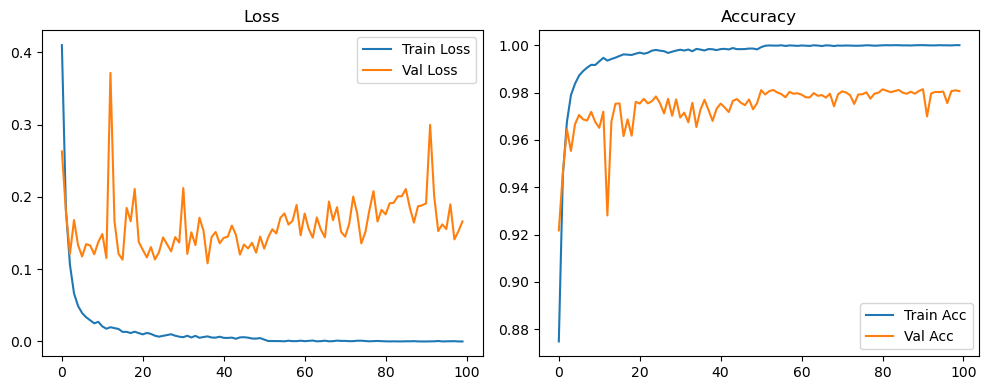

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4513, Acc: 0.8613 | Val Loss: 0.3327, Acc: 0.9013


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2706, Acc: 0.9173 | Val Loss: 0.2010, Acc: 0.9399


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1944, Acc: 0.9413 | Val Loss: 0.1697, Acc: 0.9508


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1483, Acc: 0.9550 | Val Loss: 0.1543, Acc: 0.9563


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1194, Acc: 0.9629 | Val Loss: 0.1211, Acc: 0.9623


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1016, Acc: 0.9684 | Val Loss: 0.1319, Acc: 0.9630


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0889, Acc: 0.9721 | Val Loss: 0.1066, Acc: 0.9683


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0761, Acc: 0.9764 | Val Loss: 0.1062, Acc: 0.9686


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9784 | Val Loss: 0.0973, Acc: 0.9730


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0577, Acc: 0.9812 | Val Loss: 0.1038, Acc: 0.9715


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0521, Acc: 0.9827 | Val Loss: 0.1098, Acc: 0.9710


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0477, Acc: 0.9842 | Val Loss: 0.1094, Acc: 0.9718


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0445, Acc: 0.9850 | Val Loss: 0.1115, Acc: 0.9718


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0418, Acc: 0.9868 | Val Loss: 0.1041, Acc: 0.9734


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9871 | Val Loss: 0.1098, Acc: 0.9732


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0358, Acc: 0.9880 | Val Loss: 0.1020, Acc: 0.9728


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9895 | Val Loss: 0.1048, Acc: 0.9722


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9905 | Val Loss: 0.1213, Acc: 0.9737


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9901 | Val Loss: 0.1080, Acc: 0.9722


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0284, Acc: 0.9905 | Val Loss: 0.1257, Acc: 0.9751


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0269, Acc: 0.9911 | Val Loss: 0.1119, Acc: 0.9746


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9918 | Val Loss: 0.1095, Acc: 0.9762


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.1084, Acc: 0.9752


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0233, Acc: 0.9922 | Val Loss: 0.1009, Acc: 0.9770


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0219, Acc: 0.9924 | Val Loss: 0.1103, Acc: 0.9741


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0217, Acc: 0.9930 | Val Loss: 0.1016, Acc: 0.9757


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0232, Acc: 0.9924 | Val Loss: 0.1025, Acc: 0.9761


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9931 | Val Loss: 0.1132, Acc: 0.9756


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0191, Acc: 0.9932 | Val Loss: 0.0937, Acc: 0.9772


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0175, Acc: 0.9942 | Val Loss: 0.1137, Acc: 0.9744


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0179, Acc: 0.9940 | Val Loss: 0.1094, Acc: 0.9759


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1066, Acc: 0.9770


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9948 | Val Loss: 0.1187, Acc: 0.9752


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9949 | Val Loss: 0.1153, Acc: 0.9752


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.1087, Acc: 0.9771


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1373, Acc: 0.9763


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.1023, Acc: 0.9769


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.1195, Acc: 0.9768


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9949 | Val Loss: 0.1024, Acc: 0.9769


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0153, Acc: 0.9953 | Val Loss: 0.1128, Acc: 0.9749


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0139, Acc: 0.9952 | Val Loss: 0.1123, Acc: 0.9751


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0138, Acc: 0.9953 | Val Loss: 0.1152, Acc: 0.9751


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9954 | Val Loss: 0.1098, Acc: 0.9776


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.1291, Acc: 0.9742


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1326, Acc: 0.9759


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0118, Acc: 0.9960 | Val Loss: 0.1319, Acc: 0.9753


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0116, Acc: 0.9961 | Val Loss: 0.1213, Acc: 0.9773


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1035, Acc: 0.9759


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0101, Acc: 0.9967 | Val Loss: 0.1477, Acc: 0.9767


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1227, Acc: 0.9774


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9980 | Val Loss: 0.1049, Acc: 0.9793


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1405, Acc: 0.9784


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9980 | Val Loss: 0.1324, Acc: 0.9782


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1570, Acc: 0.9788


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1194, Acc: 0.9794


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9986 | Val Loss: 0.1325, Acc: 0.9788


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9985 | Val Loss: 0.1363, Acc: 0.9777


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1307, Acc: 0.9791


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9987 | Val Loss: 0.1629, Acc: 0.9777


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1302, Acc: 0.9796


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1326, Acc: 0.9789


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1476, Acc: 0.9786


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1425, Acc: 0.9788


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1389, Acc: 0.9793


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9989 | Val Loss: 0.1423, Acc: 0.9790


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1111, Acc: 0.9783


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1409, Acc: 0.9795


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1404, Acc: 0.9796


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1481, Acc: 0.9786


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1487, Acc: 0.9787


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9992 | Val Loss: 0.1508, Acc: 0.9781


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1484, Acc: 0.9785


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1398, Acc: 0.9798


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1463, Acc: 0.9786


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1079, Acc: 0.9796


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1469, Acc: 0.9790


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1326, Acc: 0.9790


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1135, Acc: 0.9803


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1408, Acc: 0.9793


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1366, Acc: 0.9800


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9993 | Val Loss: 0.1495, Acc: 0.9804


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1422, Acc: 0.9802


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9996 | Val Loss: 0.1317, Acc: 0.9794


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1464, Acc: 0.9801


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1323, Acc: 0.9804


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1396, Acc: 0.9802


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1345, Acc: 0.9804


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1508, Acc: 0.9806


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1494, Acc: 0.9798


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1260, Acc: 0.9804


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1513, Acc: 0.9793


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1302, Acc: 0.9799


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1487, Acc: 0.9799


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1404, Acc: 0.9800


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1297, Acc: 0.9799


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1391, Acc: 0.9803


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1509, Acc: 0.9810


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1443, Acc: 0.9801


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1441, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1437, Acc: 0.9804


Final Test Loss: 0.1383 Accuracy: 0.9810


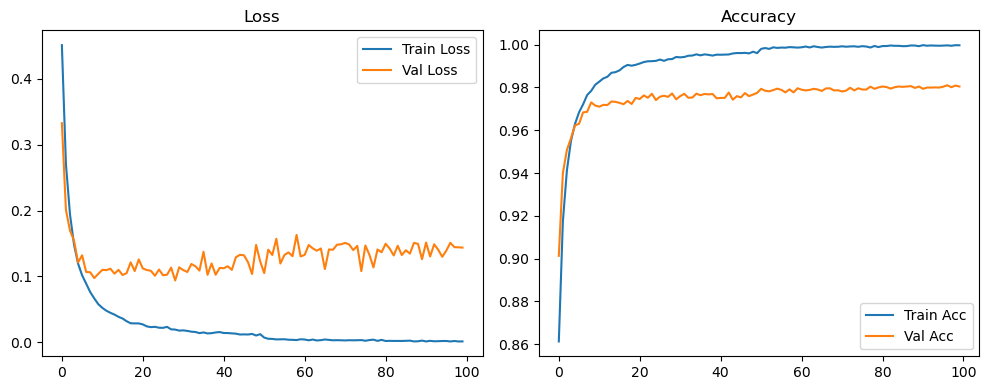

🚀 Running: batch128_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5670, Acc: 0.8249 | Val Loss: 0.3401, Acc: 0.8999


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3716, Acc: 0.8872 | Val Loss: 0.2360, Acc: 0.9291


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2942, Acc: 0.9111 | Val Loss: 0.2099, Acc: 0.9379


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2403, Acc: 0.9282 | Val Loss: 0.1787, Acc: 0.9471


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2095, Acc: 0.9374 | Val Loss: 0.1539, Acc: 0.9534


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.1901, Acc: 0.9429 | Val Loss: 0.1545, Acc: 0.9544


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1766, Acc: 0.9456 | Val Loss: 0.1430, Acc: 0.9590


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1523, Acc: 0.9533 | Val Loss: 0.1384, Acc: 0.9603


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1464, Acc: 0.9552 | Val Loss: 0.1260, Acc: 0.9634


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1323, Acc: 0.9597 | Val Loss: 0.1256, Acc: 0.9633


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1288, Acc: 0.9607 | Val Loss: 0.1284, Acc: 0.9633


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1152, Acc: 0.9639 | Val Loss: 0.1137, Acc: 0.9677


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1111, Acc: 0.9658 | Val Loss: 0.1191, Acc: 0.9671


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1047, Acc: 0.9677 | Val Loss: 0.1115, Acc: 0.9700


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0998, Acc: 0.9687 | Val Loss: 0.1152, Acc: 0.9681


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0948, Acc: 0.9700 | Val Loss: 0.1070, Acc: 0.9710


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0867, Acc: 0.9726 | Val Loss: 0.1101, Acc: 0.9693


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0867, Acc: 0.9729 | Val Loss: 0.1110, Acc: 0.9673


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0807, Acc: 0.9746 | Val Loss: 0.1108, Acc: 0.9681


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0771, Acc: 0.9753 | Val Loss: 0.1034, Acc: 0.9725


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0726, Acc: 0.9765 | Val Loss: 0.1066, Acc: 0.9718


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0706, Acc: 0.9778 | Val Loss: 0.0961, Acc: 0.9722


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0688, Acc: 0.9776 | Val Loss: 0.1143, Acc: 0.9726


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0665, Acc: 0.9786 | Val Loss: 0.1064, Acc: 0.9726


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0612, Acc: 0.9802 | Val Loss: 0.1010, Acc: 0.9728


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0593, Acc: 0.9805 | Val Loss: 0.1043, Acc: 0.9742


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0607, Acc: 0.9799 | Val Loss: 0.1057, Acc: 0.9741


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0562, Acc: 0.9818 | Val Loss: 0.1029, Acc: 0.9728


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9812 | Val Loss: 0.0980, Acc: 0.9752


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0545, Acc: 0.9820 | Val Loss: 0.0991, Acc: 0.9740


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0510, Acc: 0.9831 | Val Loss: 0.0961, Acc: 0.9750


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0520, Acc: 0.9832 | Val Loss: 0.0967, Acc: 0.9750


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0441, Acc: 0.9852 | Val Loss: 0.1067, Acc: 0.9751


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0479, Acc: 0.9844 | Val Loss: 0.0999, Acc: 0.9741


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0443, Acc: 0.9851 | Val Loss: 0.1054, Acc: 0.9748


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0437, Acc: 0.9854 | Val Loss: 0.1036, Acc: 0.9755


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0417, Acc: 0.9858 | Val Loss: 0.1171, Acc: 0.9758


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0399, Acc: 0.9865 | Val Loss: 0.1020, Acc: 0.9753


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0442, Acc: 0.9857 | Val Loss: 0.0954, Acc: 0.9754


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9871 | Val Loss: 0.0958, Acc: 0.9756


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0387, Acc: 0.9874 | Val Loss: 0.0990, Acc: 0.9748


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0361, Acc: 0.9883 | Val Loss: 0.1046, Acc: 0.9773


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0384, Acc: 0.9875 | Val Loss: 0.1033, Acc: 0.9748


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0380, Acc: 0.9869 | Val Loss: 0.0984, Acc: 0.9759


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0365, Acc: 0.9877 | Val Loss: 0.1004, Acc: 0.9763


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0337, Acc: 0.9885 | Val Loss: 0.0907, Acc: 0.9756


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0345, Acc: 0.9886 | Val Loss: 0.1034, Acc: 0.9766


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0359, Acc: 0.9884 | Val Loss: 0.0936, Acc: 0.9761


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9885 | Val Loss: 0.1087, Acc: 0.9752


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0324, Acc: 0.9890 | Val Loss: 0.1049, Acc: 0.9762


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0274, Acc: 0.9904 | Val Loss: 0.0999, Acc: 0.9772


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9923 | Val Loss: 0.0975, Acc: 0.9768


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9924 | Val Loss: 0.1037, Acc: 0.9772


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9932 | Val Loss: 0.0965, Acc: 0.9770


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9937 | Val Loss: 0.1004, Acc: 0.9768


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0179, Acc: 0.9939 | Val Loss: 0.1107, Acc: 0.9768


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0164, Acc: 0.9942 | Val Loss: 0.1090, Acc: 0.9777


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1113, Acc: 0.9773


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0167, Acc: 0.9944 | Val Loss: 0.1049, Acc: 0.9773


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.1087, Acc: 0.9778


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.1077, Acc: 0.9780


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0159, Acc: 0.9946 | Val Loss: 0.1048, Acc: 0.9772


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.1017, Acc: 0.9770


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1141, Acc: 0.9779


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9951 | Val Loss: 0.1158, Acc: 0.9784


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1095, Acc: 0.9784


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.0955, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.1226, Acc: 0.9779


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.0986, Acc: 0.9783


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9956 | Val Loss: 0.1118, Acc: 0.9781


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1122, Acc: 0.9779


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1203, Acc: 0.9782


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1155, Acc: 0.9789


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1076, Acc: 0.9788


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.1176, Acc: 0.9780


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9961 | Val Loss: 0.1106, Acc: 0.9784


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1227, Acc: 0.9779


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.1101, Acc: 0.9792


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9961 | Val Loss: 0.1074, Acc: 0.9783


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.1078, Acc: 0.9788


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9957 | Val Loss: 0.1126, Acc: 0.9785


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9963 | Val Loss: 0.1142, Acc: 0.9787


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9970 | Val Loss: 0.1124, Acc: 0.9790


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1146, Acc: 0.9778


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1139, Acc: 0.9788


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9970 | Val Loss: 0.1241, Acc: 0.9784


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1168, Acc: 0.9791


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1313, Acc: 0.9785


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1255, Acc: 0.9786


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1099, Acc: 0.9782


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1216, Acc: 0.9777


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9970 | Val Loss: 0.1194, Acc: 0.9780


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1188, Acc: 0.9789


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9976 | Val Loss: 0.1177, Acc: 0.9780


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1122, Acc: 0.9785


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9972 | Val Loss: 0.1236, Acc: 0.9780


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1210, Acc: 0.9779


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1249, Acc: 0.9781


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1262, Acc: 0.9787


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1306, Acc: 0.9780


Final Test Loss: 0.1180 Accuracy: 0.9808


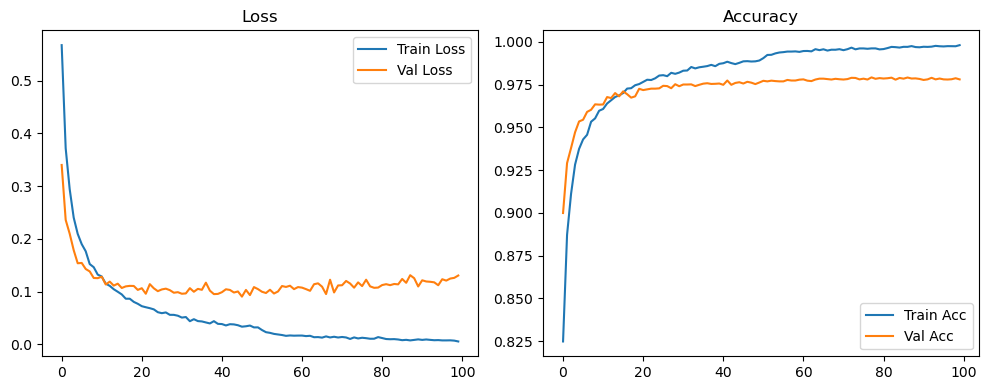

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3836, Acc: 0.8861 | Val Loss: 0.2978, Acc: 0.9098


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.1736, Acc: 0.9474 | Val Loss: 0.1378, Acc: 0.9573


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.0936, Acc: 0.9709 | Val Loss: 0.1085, Acc: 0.9670


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0510, Acc: 0.9832 | Val Loss: 0.1575, Acc: 0.9564


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9888 | Val Loss: 0.0969, Acc: 0.9726


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.1746, Acc: 0.9533


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0307, Acc: 0.9892 | Val Loss: 0.1453, Acc: 0.9622


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9932 | Val Loss: 0.1680, Acc: 0.9612


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0197, Acc: 0.9935 | Val Loss: 0.1407, Acc: 0.9673


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9941 | Val Loss: 0.1186, Acc: 0.9719


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.1935, Acc: 0.9613


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9935 | Val Loss: 0.1259, Acc: 0.9729


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1631, Acc: 0.9653


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9955 | Val Loss: 0.1387, Acc: 0.9712


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9954 | Val Loss: 0.1722, Acc: 0.9650


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9952 | Val Loss: 0.2086, Acc: 0.9587


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1357, Acc: 0.9750


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0110, Acc: 0.9966 | Val Loss: 0.2414, Acc: 0.9592


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1861, Acc: 0.9647


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1370, Acc: 0.9749


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9954 | Val Loss: 0.2109, Acc: 0.9636


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9967 | Val Loss: 0.1526, Acc: 0.9722


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1823, Acc: 0.9677


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9975 | Val Loss: 0.1172, Acc: 0.9751


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1434, Acc: 0.9745


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.1821, Acc: 0.9683


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9961 | Val Loss: 0.1490, Acc: 0.9731


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9970 | Val Loss: 0.1441, Acc: 0.9762


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9978 | Val Loss: 0.1370, Acc: 0.9751


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1459, Acc: 0.9777


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.2983, Acc: 0.9576


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1583, Acc: 0.9761


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1732, Acc: 0.9712


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1357, Acc: 0.9755


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1416, Acc: 0.9767


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1401, Acc: 0.9732


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1470, Acc: 0.9742


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9984 | Val Loss: 0.1394, Acc: 0.9763


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1608, Acc: 0.9735


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9984 | Val Loss: 0.1913, Acc: 0.9693


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9982 | Val Loss: 0.1502, Acc: 0.9762


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9981 | Val Loss: 0.1287, Acc: 0.9783


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1426, Acc: 0.9739


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1398, Acc: 0.9782


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9993 | Val Loss: 0.1205, Acc: 0.9796


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1514, Acc: 0.9768


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1639, Acc: 0.9752


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9981 | Val Loss: 0.1370, Acc: 0.9766


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1642, Acc: 0.9741


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1403, Acc: 0.9734


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1577, Acc: 0.9768


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1417, Acc: 0.9776


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1356, Acc: 0.9785


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1495, Acc: 0.9771


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1300, Acc: 0.9767


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9986 | Val Loss: 0.1427, Acc: 0.9773


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1293, Acc: 0.9781


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1521, Acc: 0.9756


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1434, Acc: 0.9773


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1673, Acc: 0.9754


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1322, Acc: 0.9802


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1459, Acc: 0.9773


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1413, Acc: 0.9769


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1695, Acc: 0.9714


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1407, Acc: 0.9761


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1474, Acc: 0.9765


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1683, Acc: 0.9764


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1370, Acc: 0.9788


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1380, Acc: 0.9780


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9991 | Val Loss: 0.1183, Acc: 0.9805


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1447, Acc: 0.9792


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.1271, Acc: 0.9784


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1525, Acc: 0.9769


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1341, Acc: 0.9789


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1548, Acc: 0.9748


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1721, Acc: 0.9707


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1402, Acc: 0.9730


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1365, Acc: 0.9798


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1789, Acc: 0.9762


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1341, Acc: 0.9784


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.1232, Acc: 0.9775


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1271, Acc: 0.9777


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.2120, Acc: 0.9680


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1345, Acc: 0.9743


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1116, Acc: 0.9808


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1219, Acc: 0.9804


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1421, Acc: 0.9772


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1213, Acc: 0.9792


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9993 | Val Loss: 0.1394, Acc: 0.9744


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1554, Acc: 0.9763


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1463, Acc: 0.9790


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1244, Acc: 0.9801


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1065, Acc: 0.9805


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1651, Acc: 0.9747


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1532, Acc: 0.9734


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1220, Acc: 0.9795


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1716, Acc: 0.9704


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1342, Acc: 0.9770


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1329, Acc: 0.9806


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1543, Acc: 0.9774


Final Test Loss: 0.1238 Accuracy: 0.9789


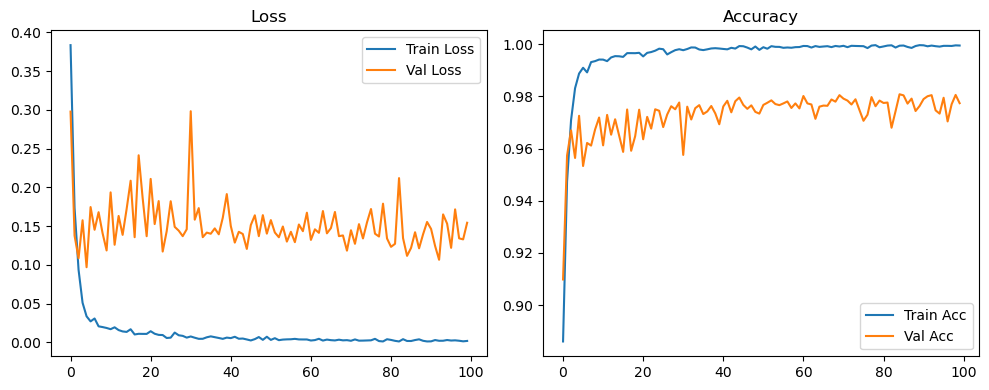

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4326, Acc: 0.8707 | Val Loss: 0.3088, Acc: 0.9062


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2572, Acc: 0.9227 | Val Loss: 0.1710, Acc: 0.9465


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1814, Acc: 0.9434 | Val Loss: 0.1360, Acc: 0.9590


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1415, Acc: 0.9561 | Val Loss: 0.1326, Acc: 0.9627


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1203, Acc: 0.9620 | Val Loss: 0.1105, Acc: 0.9663


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1011, Acc: 0.9684 | Val Loss: 0.1193, Acc: 0.9665


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0934, Acc: 0.9696 | Val Loss: 0.1169, Acc: 0.9658


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0808, Acc: 0.9738 | Val Loss: 0.1098, Acc: 0.9705


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0741, Acc: 0.9760 | Val Loss: 0.1022, Acc: 0.9708


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0677, Acc: 0.9780 | Val Loss: 0.1174, Acc: 0.9678


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0641, Acc: 0.9787 | Val Loss: 0.1104, Acc: 0.9708


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0558, Acc: 0.9812 | Val Loss: 0.0997, Acc: 0.9745


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0553, Acc: 0.9814 | Val Loss: 0.1061, Acc: 0.9727


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9842 | Val Loss: 0.0973, Acc: 0.9752


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0449, Acc: 0.9850 | Val Loss: 0.1024, Acc: 0.9738


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0445, Acc: 0.9852 | Val Loss: 0.1000, Acc: 0.9748


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9873 | Val Loss: 0.1143, Acc: 0.9720


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0368, Acc: 0.9875 | Val Loss: 0.1075, Acc: 0.9742


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0361, Acc: 0.9877 | Val Loss: 0.1127, Acc: 0.9736


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0344, Acc: 0.9886 | Val Loss: 0.1021, Acc: 0.9773


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0371, Acc: 0.9879 | Val Loss: 0.1110, Acc: 0.9742


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0301, Acc: 0.9900 | Val Loss: 0.1077, Acc: 0.9758


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9905 | Val Loss: 0.0977, Acc: 0.9768


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0281, Acc: 0.9908 | Val Loss: 0.1119, Acc: 0.9752


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9912 | Val Loss: 0.1114, Acc: 0.9758


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9904 | Val Loss: 0.1150, Acc: 0.9748


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0285, Acc: 0.9905 | Val Loss: 0.1026, Acc: 0.9761


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0237, Acc: 0.9923 | Val Loss: 0.1068, Acc: 0.9764


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0259, Acc: 0.9913 | Val Loss: 0.1144, Acc: 0.9756


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9924 | Val Loss: 0.1090, Acc: 0.9766


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0217, Acc: 0.9925 | Val Loss: 0.1142, Acc: 0.9762


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9922 | Val Loss: 0.1106, Acc: 0.9763


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9936 | Val Loss: 0.1209, Acc: 0.9757


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9921 | Val Loss: 0.1100, Acc: 0.9755


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.1131, Acc: 0.9772


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0187, Acc: 0.9936 | Val Loss: 0.1125, Acc: 0.9770


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.1140, Acc: 0.9762


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9937 | Val Loss: 0.1093, Acc: 0.9772


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9943 | Val Loss: 0.1158, Acc: 0.9754


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9942 | Val Loss: 0.1129, Acc: 0.9766


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9939 | Val Loss: 0.1076, Acc: 0.9768


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9944 | Val Loss: 0.1071, Acc: 0.9776


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.1053, Acc: 0.9785


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9948 | Val Loss: 0.1187, Acc: 0.9778


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.1331, Acc: 0.9759


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9946 | Val Loss: 0.1138, Acc: 0.9769


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9953 | Val Loss: 0.1162, Acc: 0.9772


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0134, Acc: 0.9958 | Val Loss: 0.1141, Acc: 0.9778


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.1152, Acc: 0.9784


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9947 | Val Loss: 0.1109, Acc: 0.9775


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0130, Acc: 0.9958 | Val Loss: 0.1061, Acc: 0.9781


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.1137, Acc: 0.9778


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1245, Acc: 0.9772


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1151, Acc: 0.9774


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.1073, Acc: 0.9780


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1212, Acc: 0.9778


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1125, Acc: 0.9788


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1048, Acc: 0.9792


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0126, Acc: 0.9960 | Val Loss: 0.1068, Acc: 0.9783


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9965 | Val Loss: 0.1252, Acc: 0.9777


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1233, Acc: 0.9771


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9960 | Val Loss: 0.1122, Acc: 0.9772


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.1185, Acc: 0.9779


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1165, Acc: 0.9782


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1223, Acc: 0.9774


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0096, Acc: 0.9968 | Val Loss: 0.1216, Acc: 0.9777


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1117, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1075, Acc: 0.9787


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9969 | Val Loss: 0.1098, Acc: 0.9778


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1075, Acc: 0.9783


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1110, Acc: 0.9786


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1208, Acc: 0.9782


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9968 | Val Loss: 0.1104, Acc: 0.9786


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9966 | Val Loss: 0.1241, Acc: 0.9779


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9972 | Val Loss: 0.1118, Acc: 0.9782


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1063, Acc: 0.9799


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9967 | Val Loss: 0.1147, Acc: 0.9779


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.1109, Acc: 0.9778


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1297, Acc: 0.9781


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9970 | Val Loss: 0.1163, Acc: 0.9778


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1161, Acc: 0.9790


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1236, Acc: 0.9781


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.1202, Acc: 0.9795


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1292, Acc: 0.9773


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1144, Acc: 0.9785


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1238, Acc: 0.9784


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1148, Acc: 0.9786


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1215, Acc: 0.9788


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1184, Acc: 0.9769


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9978 | Val Loss: 0.1171, Acc: 0.9772


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1197, Acc: 0.9778


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1105, Acc: 0.9785


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1199, Acc: 0.9782


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1145, Acc: 0.9779


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1118, Acc: 0.9787


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9978 | Val Loss: 0.1176, Acc: 0.9782


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1327, Acc: 0.9772


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1141, Acc: 0.9780


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1074, Acc: 0.9794


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1158, Acc: 0.9789


Final Test Loss: 0.1094 Accuracy: 0.9808


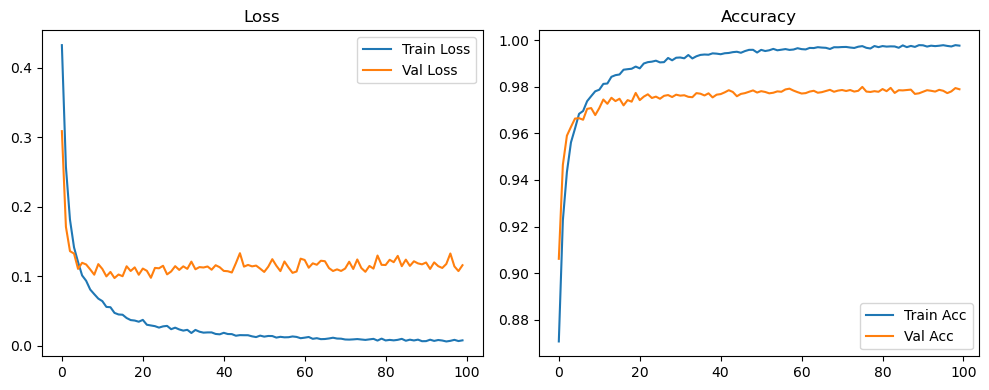

🚀 Running: batch128_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5652, Acc: 0.8267 | Val Loss: 0.3344, Acc: 0.8996


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3998, Acc: 0.8770 | Val Loss: 0.2692, Acc: 0.9191


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.3322, Acc: 0.8995 | Val Loss: 0.2393, Acc: 0.9287


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.2775, Acc: 0.9160 | Val Loss: 0.2027, Acc: 0.9393


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.2425, Acc: 0.9266 | Val Loss: 0.1714, Acc: 0.9493


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.2204, Acc: 0.9325 | Val Loss: 0.1759, Acc: 0.9491


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.2037, Acc: 0.9382 | Val Loss: 0.1603, Acc: 0.9538


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.1844, Acc: 0.9433 | Val Loss: 0.1509, Acc: 0.9570


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1712, Acc: 0.9479 | Val Loss: 0.1380, Acc: 0.9589


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1583, Acc: 0.9517 | Val Loss: 0.1403, Acc: 0.9604


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1510, Acc: 0.9542 | Val Loss: 0.1408, Acc: 0.9584


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1405, Acc: 0.9567 | Val Loss: 0.1249, Acc: 0.9635


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1356, Acc: 0.9569 | Val Loss: 0.1311, Acc: 0.9633


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1304, Acc: 0.9597 | Val Loss: 0.1185, Acc: 0.9656


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1201, Acc: 0.9640 | Val Loss: 0.1187, Acc: 0.9653


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1183, Acc: 0.9629 | Val Loss: 0.1192, Acc: 0.9659


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1079, Acc: 0.9655 | Val Loss: 0.1234, Acc: 0.9656


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1069, Acc: 0.9667 | Val Loss: 0.1179, Acc: 0.9657


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.1021, Acc: 0.9679 | Val Loss: 0.1129, Acc: 0.9674


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0989, Acc: 0.9691 | Val Loss: 0.1155, Acc: 0.9688


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0928, Acc: 0.9702 | Val Loss: 0.1108, Acc: 0.9693


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0850, Acc: 0.9725 | Val Loss: 0.1133, Acc: 0.9702


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0851, Acc: 0.9730 | Val Loss: 0.1134, Acc: 0.9698


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0844, Acc: 0.9727 | Val Loss: 0.1069, Acc: 0.9706


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0821, Acc: 0.9733 | Val Loss: 0.1127, Acc: 0.9700


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0748, Acc: 0.9767 | Val Loss: 0.1107, Acc: 0.9708


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0753, Acc: 0.9757 | Val Loss: 0.1094, Acc: 0.9708


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0744, Acc: 0.9760 | Val Loss: 0.1074, Acc: 0.9717


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0691, Acc: 0.9777 | Val Loss: 0.1085, Acc: 0.9705


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0676, Acc: 0.9782 | Val Loss: 0.1143, Acc: 0.9698


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0657, Acc: 0.9780 | Val Loss: 0.1052, Acc: 0.9722


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0642, Acc: 0.9785 | Val Loss: 0.1101, Acc: 0.9710


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0582, Acc: 0.9808 | Val Loss: 0.1069, Acc: 0.9722


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0578, Acc: 0.9811 | Val Loss: 0.1105, Acc: 0.9707


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0569, Acc: 0.9806 | Val Loss: 0.1083, Acc: 0.9722


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0578, Acc: 0.9804 | Val Loss: 0.1017, Acc: 0.9733


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0528, Acc: 0.9825 | Val Loss: 0.1153, Acc: 0.9722


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0526, Acc: 0.9829 | Val Loss: 0.1098, Acc: 0.9722


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0500, Acc: 0.9832 | Val Loss: 0.1067, Acc: 0.9726


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0534, Acc: 0.9824 | Val Loss: 0.1076, Acc: 0.9724


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0494, Acc: 0.9838 | Val Loss: 0.1078, Acc: 0.9730


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0482, Acc: 0.9836 | Val Loss: 0.1064, Acc: 0.9743


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0489, Acc: 0.9838 | Val Loss: 0.1094, Acc: 0.9718


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0452, Acc: 0.9849 | Val Loss: 0.1058, Acc: 0.9738


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0456, Acc: 0.9849 | Val Loss: 0.1100, Acc: 0.9733


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0437, Acc: 0.9854 | Val Loss: 0.1045, Acc: 0.9732


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0442, Acc: 0.9854 | Val Loss: 0.1071, Acc: 0.9735


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0431, Acc: 0.9859 | Val Loss: 0.1057, Acc: 0.9738


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0392, Acc: 0.9872 | Val Loss: 0.1159, Acc: 0.9742


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0440, Acc: 0.9851 | Val Loss: 0.1124, Acc: 0.9749


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0385, Acc: 0.9872 | Val Loss: 0.1043, Acc: 0.9742


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0404, Acc: 0.9863 | Val Loss: 0.1058, Acc: 0.9742


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0364, Acc: 0.9873 | Val Loss: 0.1086, Acc: 0.9757


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0367, Acc: 0.9882 | Val Loss: 0.1101, Acc: 0.9749


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0398, Acc: 0.9868 | Val Loss: 0.1029, Acc: 0.9742


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0357, Acc: 0.9877 | Val Loss: 0.1120, Acc: 0.9757


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0366, Acc: 0.9881 | Val Loss: 0.1125, Acc: 0.9753


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0350, Acc: 0.9886 | Val Loss: 0.1073, Acc: 0.9742


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0349, Acc: 0.9880 | Val Loss: 0.1162, Acc: 0.9740


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9877 | Val Loss: 0.1027, Acc: 0.9748


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9892 | Val Loss: 0.1100, Acc: 0.9752


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0330, Acc: 0.9886 | Val Loss: 0.1113, Acc: 0.9753


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0322, Acc: 0.9889 | Val Loss: 0.1115, Acc: 0.9739


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0328, Acc: 0.9893 | Val Loss: 0.1029, Acc: 0.9747


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0323, Acc: 0.9897 | Val Loss: 0.1097, Acc: 0.9747


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0306, Acc: 0.9899 | Val Loss: 0.1083, Acc: 0.9745


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9899 | Val Loss: 0.1063, Acc: 0.9749


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0283, Acc: 0.9900 | Val Loss: 0.1167, Acc: 0.9738


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9900 | Val Loss: 0.1121, Acc: 0.9746


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9897 | Val Loss: 0.1038, Acc: 0.9747


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0291, Acc: 0.9903 | Val Loss: 0.1127, Acc: 0.9754


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9898 | Val Loss: 0.1215, Acc: 0.9757


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0262, Acc: 0.9910 | Val Loss: 0.1090, Acc: 0.9763


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9902 | Val Loss: 0.1120, Acc: 0.9754


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0280, Acc: 0.9907 | Val Loss: 0.1170, Acc: 0.9758


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0266, Acc: 0.9916 | Val Loss: 0.1146, Acc: 0.9750


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9911 | Val Loss: 0.1086, Acc: 0.9757


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0267, Acc: 0.9913 | Val Loss: 0.1154, Acc: 0.9752


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9917 | Val Loss: 0.1108, Acc: 0.9755


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9902 | Val Loss: 0.0988, Acc: 0.9758


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0273, Acc: 0.9905 | Val Loss: 0.1097, Acc: 0.9753


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0260, Acc: 0.9909 | Val Loss: 0.1112, Acc: 0.9752


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0263, Acc: 0.9914 | Val Loss: 0.1113, Acc: 0.9741


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9919 | Val Loss: 0.1087, Acc: 0.9753


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0247, Acc: 0.9920 | Val Loss: 0.1100, Acc: 0.9757


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9920 | Val Loss: 0.1106, Acc: 0.9758


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0228, Acc: 0.9923 | Val Loss: 0.1126, Acc: 0.9749


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0240, Acc: 0.9919 | Val Loss: 0.1067, Acc: 0.9753


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.1119, Acc: 0.9748


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0231, Acc: 0.9924 | Val Loss: 0.1133, Acc: 0.9745


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0226, Acc: 0.9922 | Val Loss: 0.1063, Acc: 0.9754


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0227, Acc: 0.9924 | Val Loss: 0.1147, Acc: 0.9762


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0249, Acc: 0.9913 | Val Loss: 0.0995, Acc: 0.9768


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.1057, Acc: 0.9765


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9926 | Val Loss: 0.1133, Acc: 0.9757


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0229, Acc: 0.9920 | Val Loss: 0.1087, Acc: 0.9754


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9924 | Val Loss: 0.1194, Acc: 0.9755


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9928 | Val Loss: 0.1232, Acc: 0.9753


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0223, Acc: 0.9926 | Val Loss: 0.1136, Acc: 0.9762


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0215, Acc: 0.9927 | Val Loss: 0.1108, Acc: 0.9762


Final Test Loss: 0.0943 Accuracy: 0.9798


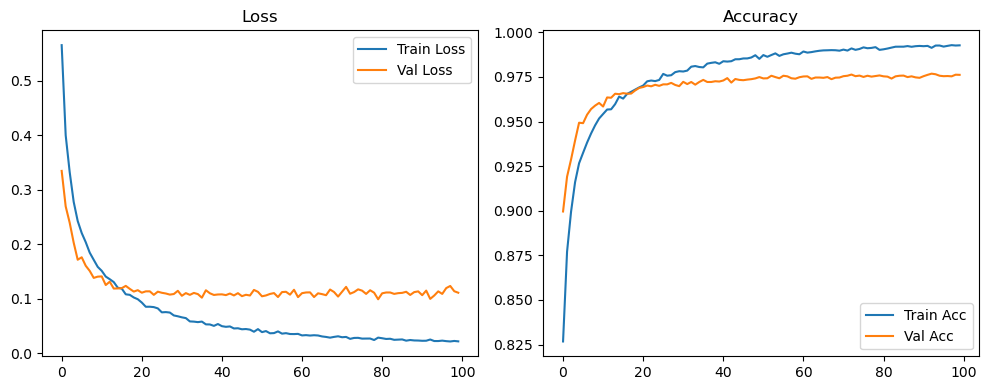

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3861, Acc: 0.8889 | Val Loss: 0.2834, Acc: 0.9184


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.1780, Acc: 0.9465 | Val Loss: 0.1331, Acc: 0.9565


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.0880, Acc: 0.9726 | Val Loss: 0.1115, Acc: 0.9652


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0482, Acc: 0.9846 | Val Loss: 0.1190, Acc: 0.9640


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.1053, Acc: 0.9699


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0203, Acc: 0.9935 | Val Loss: 0.1163, Acc: 0.9653


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0235, Acc: 0.9922 | Val Loss: 0.1142, Acc: 0.9714


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0189, Acc: 0.9938 | Val Loss: 0.1281, Acc: 0.9687


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1029, Acc: 0.9752


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.1334, Acc: 0.9693


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1261, Acc: 0.9721


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0166, Acc: 0.9942 | Val Loss: 0.1459, Acc: 0.9676


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.1197, Acc: 0.9737


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1533, Acc: 0.9657


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1174, Acc: 0.9752


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1469, Acc: 0.9700


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0102, Acc: 0.9968 | Val Loss: 0.1327, Acc: 0.9719


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1765, Acc: 0.9657


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1456, Acc: 0.9706


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1250, Acc: 0.9765


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9981 | Val Loss: 0.2116, Acc: 0.9624


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9957 | Val Loss: 0.1202, Acc: 0.9753


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1450, Acc: 0.9722


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1336, Acc: 0.9761


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9977 | Val Loss: 0.1570, Acc: 0.9715


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1621, Acc: 0.9698


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.2057, Acc: 0.9590


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9974 | Val Loss: 0.1228, Acc: 0.9767


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1513, Acc: 0.9744


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1171, Acc: 0.9772


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1292, Acc: 0.9765


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1210, Acc: 0.9780


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1950, Acc: 0.9673


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1260, Acc: 0.9782


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1166, Acc: 0.9803


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1208, Acc: 0.9805


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1564, Acc: 0.9713


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9981 | Val Loss: 0.2095, Acc: 0.9642


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1368, Acc: 0.9769


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9982 | Val Loss: 0.1333, Acc: 0.9757


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1211, Acc: 0.9798


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1546, Acc: 0.9738


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1259, Acc: 0.9797


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1692, Acc: 0.9721


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1308, Acc: 0.9790


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1659, Acc: 0.9738


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9987 | Val Loss: 0.1359, Acc: 0.9770


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1142, Acc: 0.9799


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1402, Acc: 0.9753


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9986 | Val Loss: 0.1598, Acc: 0.9728


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1343, Acc: 0.9768


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1176, Acc: 0.9791


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1398, Acc: 0.9774


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1402, Acc: 0.9763


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9991 | Val Loss: 0.1331, Acc: 0.9783


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1559, Acc: 0.9739


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1544, Acc: 0.9762


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1544, Acc: 0.9735


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1768, Acc: 0.9726


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.1672, Acc: 0.9757


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.2517, Acc: 0.9643


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.2044, Acc: 0.9686


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1359, Acc: 0.9779


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1329, Acc: 0.9787


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1389, Acc: 0.9778


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1389, Acc: 0.9773


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1336, Acc: 0.9795


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1926, Acc: 0.9708


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1991, Acc: 0.9715


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1412, Acc: 0.9769


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1168, Acc: 0.9805


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1275, Acc: 0.9800


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1426, Acc: 0.9784


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1251, Acc: 0.9804


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9995 | Val Loss: 0.1342, Acc: 0.9783


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1290, Acc: 0.9802


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1516, Acc: 0.9768


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.1463, Acc: 0.9788


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1671, Acc: 0.9759


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1745, Acc: 0.9744


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9987 | Val Loss: 0.1253, Acc: 0.9788


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1271, Acc: 0.9793


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1253, Acc: 0.9803


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1261, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1629, Acc: 0.9742


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1429, Acc: 0.9782


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9990 | Val Loss: 0.1557, Acc: 0.9772


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1470, Acc: 0.9772


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1597, Acc: 0.9779


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.2230, Acc: 0.9702


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9992 | Val Loss: 0.1534, Acc: 0.9768


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.2784, Acc: 0.9571


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1355, Acc: 0.9792


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.2147, Acc: 0.9708


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.2213, Acc: 0.9716


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1581, Acc: 0.9789


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9992 | Val Loss: 0.1341, Acc: 0.9802


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1594, Acc: 0.9768


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1433, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1516, Acc: 0.9778


Final Test Loss: 0.1508 Accuracy: 0.9784


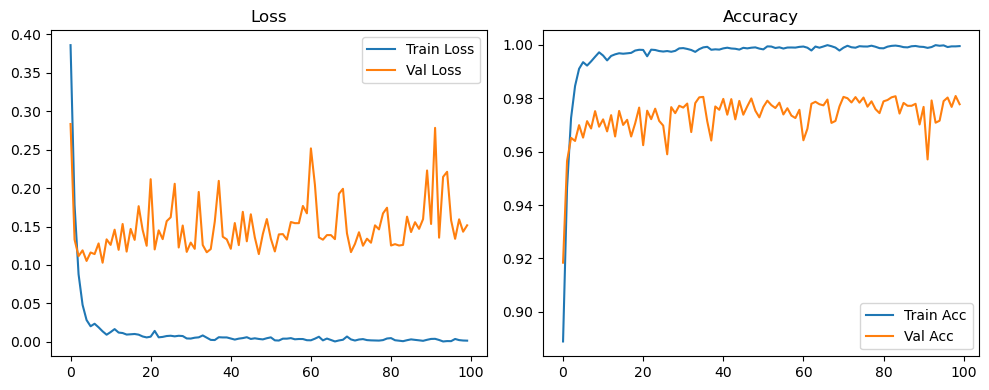

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4454, Acc: 0.8724 | Val Loss: 0.3118, Acc: 0.9084


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2898, Acc: 0.9107 | Val Loss: 0.2138, Acc: 0.9356


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2087, Acc: 0.9358 | Val Loss: 0.1682, Acc: 0.9475


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1621, Acc: 0.9492 | Val Loss: 0.1397, Acc: 0.9570


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1317, Acc: 0.9593 | Val Loss: 0.1173, Acc: 0.9641


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1120, Acc: 0.9645 | Val Loss: 0.1122, Acc: 0.9656


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0971, Acc: 0.9679 | Val Loss: 0.1127, Acc: 0.9661


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0856, Acc: 0.9730 | Val Loss: 0.1047, Acc: 0.9692


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0785, Acc: 0.9746 | Val Loss: 0.0972, Acc: 0.9716


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0689, Acc: 0.9780 | Val Loss: 0.0995, Acc: 0.9704


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0634, Acc: 0.9788 | Val Loss: 0.1026, Acc: 0.9717


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0573, Acc: 0.9810 | Val Loss: 0.0973, Acc: 0.9735


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0559, Acc: 0.9815 | Val Loss: 0.0974, Acc: 0.9730


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0500, Acc: 0.9833 | Val Loss: 0.0970, Acc: 0.9727


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0442, Acc: 0.9853 | Val Loss: 0.0961, Acc: 0.9747


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0458, Acc: 0.9854 | Val Loss: 0.0907, Acc: 0.9753


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9869 | Val Loss: 0.1143, Acc: 0.9710


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9869 | Val Loss: 0.1012, Acc: 0.9747


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0365, Acc: 0.9876 | Val Loss: 0.1049, Acc: 0.9737


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 0.0944, Acc: 0.9763


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0339, Acc: 0.9880 | Val Loss: 0.1086, Acc: 0.9728


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0297, Acc: 0.9896 | Val Loss: 0.1032, Acc: 0.9765


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.0986, Acc: 0.9762


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9905 | Val Loss: 0.1065, Acc: 0.9748


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9911 | Val Loss: 0.1077, Acc: 0.9762


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.1077, Acc: 0.9751


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9910 | Val Loss: 0.1095, Acc: 0.9752


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0236, Acc: 0.9921 | Val Loss: 0.1041, Acc: 0.9758


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9904 | Val Loss: 0.0995, Acc: 0.9770


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9927 | Val Loss: 0.1103, Acc: 0.9759


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9926 | Val Loss: 0.1034, Acc: 0.9752


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0242, Acc: 0.9922 | Val Loss: 0.1057, Acc: 0.9762


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9935 | Val Loss: 0.1127, Acc: 0.9768


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0195, Acc: 0.9931 | Val Loss: 0.1120, Acc: 0.9762


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9931 | Val Loss: 0.1083, Acc: 0.9769


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9937 | Val Loss: 0.1099, Acc: 0.9762


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.1058, Acc: 0.9768


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9941 | Val Loss: 0.1081, Acc: 0.9752


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0169, Acc: 0.9942 | Val Loss: 0.1117, Acc: 0.9756


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0157, Acc: 0.9945 | Val Loss: 0.1263, Acc: 0.9740


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9948 | Val Loss: 0.1151, Acc: 0.9761


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9948 | Val Loss: 0.1206, Acc: 0.9770


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0167, Acc: 0.9945 | Val Loss: 0.1148, Acc: 0.9771


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0151, Acc: 0.9950 | Val Loss: 0.1182, Acc: 0.9757


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9953 | Val Loss: 0.1086, Acc: 0.9784


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0144, Acc: 0.9954 | Val Loss: 0.1218, Acc: 0.9757


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9956 | Val Loss: 0.1200, Acc: 0.9760


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1222, Acc: 0.9779


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0153, Acc: 0.9948 | Val Loss: 0.1153, Acc: 0.9762


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1163, Acc: 0.9762


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1183, Acc: 0.9771


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1090, Acc: 0.9778


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.1153, Acc: 0.9775


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.1175, Acc: 0.9780


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9959 | Val Loss: 0.1300, Acc: 0.9763


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0120, Acc: 0.9960 | Val Loss: 0.1213, Acc: 0.9782


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0118, Acc: 0.9958 | Val Loss: 0.1216, Acc: 0.9776


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0123, Acc: 0.9958 | Val Loss: 0.1150, Acc: 0.9778


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1191, Acc: 0.9772


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1180, Acc: 0.9773


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0108, Acc: 0.9969 | Val Loss: 0.1180, Acc: 0.9777


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0127, Acc: 0.9956 | Val Loss: 0.1181, Acc: 0.9766


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1161, Acc: 0.9791


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9966 | Val Loss: 0.1334, Acc: 0.9767


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9964 | Val Loss: 0.1333, Acc: 0.9768


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1147, Acc: 0.9779


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1157, Acc: 0.9776


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1246, Acc: 0.9771


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0104, Acc: 0.9969 | Val Loss: 0.1216, Acc: 0.9777


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9965 | Val Loss: 0.1292, Acc: 0.9760


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9964 | Val Loss: 0.1156, Acc: 0.9781


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9969 | Val Loss: 0.1214, Acc: 0.9765


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9968 | Val Loss: 0.1169, Acc: 0.9782


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1219, Acc: 0.9787


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0107, Acc: 0.9966 | Val Loss: 0.1192, Acc: 0.9784


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1145, Acc: 0.9776


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9978 | Val Loss: 0.1283, Acc: 0.9792


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.1163, Acc: 0.9777


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1289, Acc: 0.9769


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9967 | Val Loss: 0.1185, Acc: 0.9785


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1246, Acc: 0.9767


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9974 | Val Loss: 0.1246, Acc: 0.9775


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1284, Acc: 0.9781


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1179, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9973 | Val Loss: 0.1188, Acc: 0.9790


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1275, Acc: 0.9766


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1236, Acc: 0.9783


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1321, Acc: 0.9782


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0090, Acc: 0.9971 | Val Loss: 0.1300, Acc: 0.9774


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1254, Acc: 0.9790


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1320, Acc: 0.9780


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9978 | Val Loss: 0.1266, Acc: 0.9785


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1212, Acc: 0.9787


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9971 | Val Loss: 0.1283, Acc: 0.9775


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1240, Acc: 0.9775


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1369, Acc: 0.9780


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1244, Acc: 0.9788


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1297, Acc: 0.9774


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1228, Acc: 0.9788


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9973 | Val Loss: 0.1184, Acc: 0.9776


Final Test Loss: 0.1104 Accuracy: 0.9793


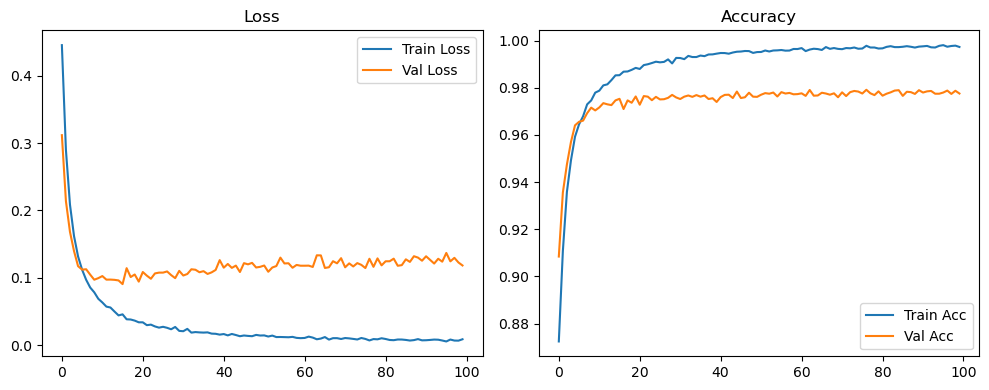

🚀 Running: batch128_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6073, Acc: 0.8177 | Val Loss: 0.3362, Acc: 0.9019


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.4147, Acc: 0.8717 | Val Loss: 0.3002, Acc: 0.9113


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.3771, Acc: 0.8828 | Val Loss: 0.2886, Acc: 0.9156


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.3399, Acc: 0.8962 | Val Loss: 0.2665, Acc: 0.9192


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.3085, Acc: 0.9067 | Val Loss: 0.2314, Acc: 0.9307


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2821, Acc: 0.9140 | Val Loss: 0.2231, Acc: 0.9332


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.2635, Acc: 0.9200 | Val Loss: 0.2010, Acc: 0.9390


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.2382, Acc: 0.9268 | Val Loss: 0.1872, Acc: 0.9454


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.2213, Acc: 0.9333 | Val Loss: 0.1761, Acc: 0.9482


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.2050, Acc: 0.9378 | Val Loss: 0.1722, Acc: 0.9494


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1940, Acc: 0.9406 | Val Loss: 0.1659, Acc: 0.9503


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1747, Acc: 0.9461 | Val Loss: 0.1522, Acc: 0.9552


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1680, Acc: 0.9485 | Val Loss: 0.1528, Acc: 0.9575


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1576, Acc: 0.9517 | Val Loss: 0.1396, Acc: 0.9603


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1528, Acc: 0.9536 | Val Loss: 0.1368, Acc: 0.9615


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1388, Acc: 0.9566 | Val Loss: 0.1342, Acc: 0.9621


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1304, Acc: 0.9601 | Val Loss: 0.1477, Acc: 0.9584


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1253, Acc: 0.9616 | Val Loss: 0.1360, Acc: 0.9631


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1205, Acc: 0.9623 | Val Loss: 0.1323, Acc: 0.9632


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1136, Acc: 0.9649 | Val Loss: 0.1305, Acc: 0.9653


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1078, Acc: 0.9670 | Val Loss: 0.1274, Acc: 0.9667


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1024, Acc: 0.9680 | Val Loss: 0.1255, Acc: 0.9656


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0976, Acc: 0.9690 | Val Loss: 0.1241, Acc: 0.9674


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0953, Acc: 0.9698 | Val Loss: 0.1176, Acc: 0.9682


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0903, Acc: 0.9716 | Val Loss: 0.1265, Acc: 0.9674


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0839, Acc: 0.9729 | Val Loss: 0.1205, Acc: 0.9695


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0838, Acc: 0.9734 | Val Loss: 0.1204, Acc: 0.9702


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0782, Acc: 0.9743 | Val Loss: 0.1261, Acc: 0.9697


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0765, Acc: 0.9758 | Val Loss: 0.1173, Acc: 0.9702


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0749, Acc: 0.9762 | Val Loss: 0.1236, Acc: 0.9684


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0690, Acc: 0.9771 | Val Loss: 0.1198, Acc: 0.9689


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0679, Acc: 0.9784 | Val Loss: 0.1200, Acc: 0.9697


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0619, Acc: 0.9805 | Val Loss: 0.1227, Acc: 0.9702


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0632, Acc: 0.9795 | Val Loss: 0.1270, Acc: 0.9701


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0596, Acc: 0.9810 | Val Loss: 0.1204, Acc: 0.9711


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0605, Acc: 0.9798 | Val Loss: 0.1154, Acc: 0.9735


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0558, Acc: 0.9823 | Val Loss: 0.1183, Acc: 0.9722


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0552, Acc: 0.9817 | Val Loss: 0.1198, Acc: 0.9718


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0532, Acc: 0.9825 | Val Loss: 0.1192, Acc: 0.9719


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0532, Acc: 0.9829 | Val Loss: 0.1234, Acc: 0.9721


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0472, Acc: 0.9843 | Val Loss: 0.1224, Acc: 0.9721


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0490, Acc: 0.9843 | Val Loss: 0.1231, Acc: 0.9721


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0483, Acc: 0.9847 | Val Loss: 0.1256, Acc: 0.9722


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0445, Acc: 0.9850 | Val Loss: 0.1227, Acc: 0.9722


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0434, Acc: 0.9858 | Val Loss: 0.1207, Acc: 0.9726


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0407, Acc: 0.9861 | Val Loss: 0.1336, Acc: 0.9717


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0438, Acc: 0.9855 | Val Loss: 0.1259, Acc: 0.9722


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0415, Acc: 0.9861 | Val Loss: 0.1291, Acc: 0.9718


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0397, Acc: 0.9866 | Val Loss: 0.1364, Acc: 0.9722


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0422, Acc: 0.9863 | Val Loss: 0.1269, Acc: 0.9725


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0379, Acc: 0.9873 | Val Loss: 0.1261, Acc: 0.9732


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0398, Acc: 0.9872 | Val Loss: 0.1252, Acc: 0.9726


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0343, Acc: 0.9887 | Val Loss: 0.1271, Acc: 0.9731


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0353, Acc: 0.9885 | Val Loss: 0.1271, Acc: 0.9737


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0381, Acc: 0.9870 | Val Loss: 0.1233, Acc: 0.9733


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0369, Acc: 0.9879 | Val Loss: 0.1268, Acc: 0.9741


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9891 | Val Loss: 0.1249, Acc: 0.9734


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9896 | Val Loss: 0.1350, Acc: 0.9734


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0329, Acc: 0.9895 | Val Loss: 0.1336, Acc: 0.9738


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9890 | Val Loss: 0.1300, Acc: 0.9746


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0278, Acc: 0.9908 | Val Loss: 0.1318, Acc: 0.9737


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9894 | Val Loss: 0.1285, Acc: 0.9748


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0324, Acc: 0.9890 | Val Loss: 0.1316, Acc: 0.9737


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0323, Acc: 0.9892 | Val Loss: 0.1345, Acc: 0.9729


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9906 | Val Loss: 0.1331, Acc: 0.9737


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9908 | Val Loss: 0.1358, Acc: 0.9737


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0260, Acc: 0.9913 | Val Loss: 0.1288, Acc: 0.9752


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9906 | Val Loss: 0.1384, Acc: 0.9738


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9908 | Val Loss: 0.1342, Acc: 0.9745


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0261, Acc: 0.9911 | Val Loss: 0.1361, Acc: 0.9752


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0276, Acc: 0.9911 | Val Loss: 0.1295, Acc: 0.9748


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0280, Acc: 0.9908 | Val Loss: 0.1338, Acc: 0.9752


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0244, Acc: 0.9916 | Val Loss: 0.1364, Acc: 0.9738


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9915 | Val Loss: 0.1325, Acc: 0.9745


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9924 | Val Loss: 0.1337, Acc: 0.9749


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0239, Acc: 0.9924 | Val Loss: 0.1314, Acc: 0.9749


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0254, Acc: 0.9918 | Val Loss: 0.1332, Acc: 0.9757


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0233, Acc: 0.9918 | Val Loss: 0.1402, Acc: 0.9753


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9932 | Val Loss: 0.1373, Acc: 0.9749


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0231, Acc: 0.9923 | Val Loss: 0.1388, Acc: 0.9749


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0240, Acc: 0.9918 | Val Loss: 0.1339, Acc: 0.9758


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9926 | Val Loss: 0.1392, Acc: 0.9738


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0237, Acc: 0.9920 | Val Loss: 0.1373, Acc: 0.9750


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0212, Acc: 0.9929 | Val Loss: 0.1313, Acc: 0.9755


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0207, Acc: 0.9934 | Val Loss: 0.1327, Acc: 0.9759


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.1397, Acc: 0.9762


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.1431, Acc: 0.9741


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0211, Acc: 0.9934 | Val Loss: 0.1425, Acc: 0.9754


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9932 | Val Loss: 0.1363, Acc: 0.9756


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0217, Acc: 0.9933 | Val Loss: 0.1399, Acc: 0.9743


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0184, Acc: 0.9940 | Val Loss: 0.1308, Acc: 0.9769


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9936 | Val Loss: 0.1397, Acc: 0.9751


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.1430, Acc: 0.9757


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.1519, Acc: 0.9742


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0214, Acc: 0.9931 | Val Loss: 0.1435, Acc: 0.9751


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0216, Acc: 0.9925 | Val Loss: 0.1389, Acc: 0.9746


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0186, Acc: 0.9937 | Val Loss: 0.1399, Acc: 0.9762


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0197, Acc: 0.9934 | Val Loss: 0.1342, Acc: 0.9753


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0180, Acc: 0.9938 | Val Loss: 0.1404, Acc: 0.9758


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0175, Acc: 0.9938 | Val Loss: 0.1409, Acc: 0.9748


Final Test Loss: 0.1340 Accuracy: 0.9786


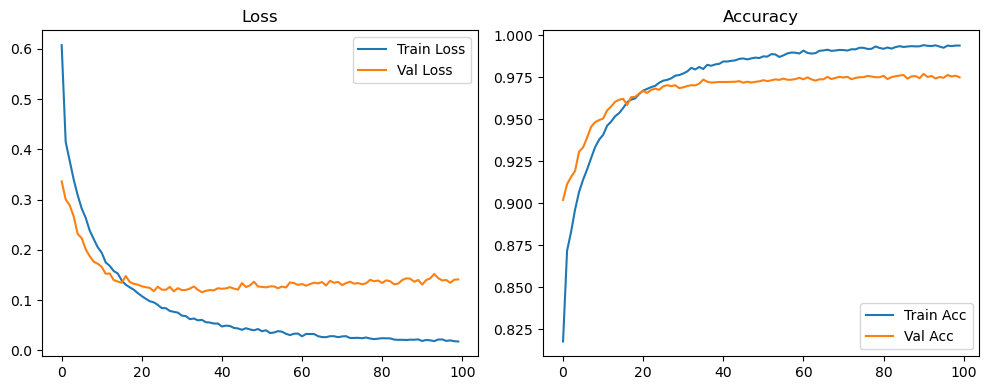

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5142, Acc: 0.8530 | Val Loss: 0.3202, Acc: 0.9068


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2324, Acc: 0.9304 | Val Loss: 0.2188, Acc: 0.9347


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1344, Acc: 0.9593 | Val Loss: 0.1704, Acc: 0.9496


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0849, Acc: 0.9741 | Val Loss: 0.1319, Acc: 0.9624


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9821 | Val Loss: 0.1211, Acc: 0.9663


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9859 | Val Loss: 0.1638, Acc: 0.9583


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.1142, Acc: 0.9711


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9913 | Val Loss: 0.1431, Acc: 0.9639


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.1339, Acc: 0.9669


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.1380, Acc: 0.9682


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.1535, Acc: 0.9648


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1446, Acc: 0.9697


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.1324, Acc: 0.9745


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1295, Acc: 0.9724


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.1305, Acc: 0.9728


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1408, Acc: 0.9707


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.2018, Acc: 0.9608


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.1296, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1263, Acc: 0.9740


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1470, Acc: 0.9722


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1359, Acc: 0.9738


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.1355, Acc: 0.9738


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1563, Acc: 0.9725


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.1422, Acc: 0.9689


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1471, Acc: 0.9738


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1400, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.2159, Acc: 0.9620


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1518, Acc: 0.9738


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1318, Acc: 0.9740


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1248, Acc: 0.9732


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1367, Acc: 0.9747


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1197, Acc: 0.9775


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1183, Acc: 0.9741


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1231, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1493, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.2257, Acc: 0.9634


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1330, Acc: 0.9724


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1742, Acc: 0.9697


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1780, Acc: 0.9748


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1518, Acc: 0.9727


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1561, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1713, Acc: 0.9738


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1663, Acc: 0.9738


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1537, Acc: 0.9721


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.2471, Acc: 0.9654


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1346, Acc: 0.9753


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1661, Acc: 0.9753


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1858, Acc: 0.9733


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1853, Acc: 0.9696


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1316, Acc: 0.9728


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1491, Acc: 0.9731


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1561, Acc: 0.9726


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1950, Acc: 0.9637


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1460, Acc: 0.9727


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1442, Acc: 0.9737


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1925, Acc: 0.9573


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.1410, Acc: 0.9743


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.7536, Acc: 0.8725


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1613, Acc: 0.9734


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.2267, Acc: 0.9728


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1587, Acc: 0.9743


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9988 | Val Loss: 0.1460, Acc: 0.9757


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1762, Acc: 0.9689


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1953, Acc: 0.9671


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1504, Acc: 0.9738


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.0978, Acc: 0.9757


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.3027, Acc: 0.9558


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.9265, Acc: 0.8752


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1348, Acc: 0.9745


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9989 | Val Loss: 0.2105, Acc: 0.9641


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9988 | Val Loss: 0.1642, Acc: 0.9647


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1584, Acc: 0.9754


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1209, Acc: 0.9755


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.3432, Acc: 0.9427


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.4815, Acc: 0.9038


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9987 | Val Loss: 0.4297, Acc: 0.9437


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1378, Acc: 0.9751


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.1791, Acc: 0.9695


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1958, Acc: 0.9698


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1477, Acc: 0.9728


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9992 | Val Loss: 0.2038, Acc: 0.9732


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.3766, Acc: 0.9458


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1291, Acc: 0.9721


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.3031, Acc: 0.9616


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1962, Acc: 0.9554


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0025, Acc: 0.9992 | Val Loss: 0.1500, Acc: 0.9769


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1590, Acc: 0.9738


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1451, Acc: 0.9729


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1675, Acc: 0.9739


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.0897, Acc: 0.9762


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1073, Acc: 0.9706


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0032, Acc: 0.9992 | Val Loss: 0.1926, Acc: 0.9760


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1668, Acc: 0.9706


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1645, Acc: 0.9754


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.2045, Acc: 0.9745


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.2391, Acc: 0.9719


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.3603, Acc: 0.9517


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1992, Acc: 0.9724


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.2710, Acc: 0.9677


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1568, Acc: 0.9741


Final Test Loss: 0.1235 Accuracy: 0.9787


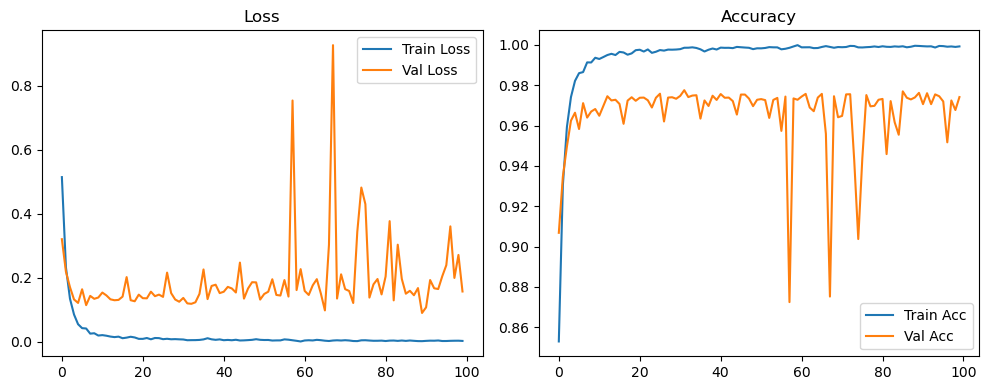

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5364, Acc: 0.8455 | Val Loss: 0.3336, Acc: 0.9024


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2940, Acc: 0.9109 | Val Loss: 0.2620, Acc: 0.9221


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2142, Acc: 0.9357 | Val Loss: 0.1920, Acc: 0.9445


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1549, Acc: 0.9538 | Val Loss: 0.1720, Acc: 0.9514


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9645 | Val Loss: 0.1283, Acc: 0.9645


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1011, Acc: 0.9681 | Val Loss: 0.1376, Acc: 0.9649


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9724 | Val Loss: 0.1257, Acc: 0.9661


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0662, Acc: 0.9786 | Val Loss: 0.1327, Acc: 0.9672


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9795 | Val Loss: 0.1309, Acc: 0.9678


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9816 | Val Loss: 0.1196, Acc: 0.9686


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9836 | Val Loss: 0.1325, Acc: 0.9692


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9873 | Val Loss: 0.1369, Acc: 0.9698


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9857 | Val Loss: 0.1378, Acc: 0.9709


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9868 | Val Loss: 0.1244, Acc: 0.9713


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9881 | Val Loss: 0.1440, Acc: 0.9707


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9895 | Val Loss: 0.1409, Acc: 0.9718


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.1449, Acc: 0.9715


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.1436, Acc: 0.9707


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.1362, Acc: 0.9717


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9905 | Val Loss: 0.1724, Acc: 0.9701


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.1590, Acc: 0.9686


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.1596, Acc: 0.9712


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9903 | Val Loss: 0.1569, Acc: 0.9718


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9914 | Val Loss: 0.1311, Acc: 0.9748


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.1395, Acc: 0.9753


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9948 | Val Loss: 0.1290, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.1651, Acc: 0.9738


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.1397, Acc: 0.9752


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1428, Acc: 0.9757


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.1470, Acc: 0.9747


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9938 | Val Loss: 0.1389, Acc: 0.9758


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.1338, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.1456, Acc: 0.9761


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.1441, Acc: 0.9771


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.1378, Acc: 0.9765


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9940 | Val Loss: 0.1393, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9943 | Val Loss: 0.1462, Acc: 0.9746


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.1623, Acc: 0.9737


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.1362, Acc: 0.9762


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.1364, Acc: 0.9760


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1310, Acc: 0.9773


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.1266, Acc: 0.9785


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.1243, Acc: 0.9771


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1236, Acc: 0.9762


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1204, Acc: 0.9768


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1267, Acc: 0.9765


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1235, Acc: 0.9752


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1222, Acc: 0.9772


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1341, Acc: 0.9766


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1475, Acc: 0.9768


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9959 | Val Loss: 0.1209, Acc: 0.9772


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1405, Acc: 0.9756


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0095, Acc: 0.9968 | Val Loss: 0.1236, Acc: 0.9771


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9965 | Val Loss: 0.1490, Acc: 0.9763


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1298, Acc: 0.9768


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1415, Acc: 0.9762


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0092, Acc: 0.9971 | Val Loss: 0.1159, Acc: 0.9783


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1053, Acc: 0.9772


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1219, Acc: 0.9777


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1174, Acc: 0.9777


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1092, Acc: 0.9784


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9974 | Val Loss: 0.1222, Acc: 0.9772


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9972 | Val Loss: 0.1314, Acc: 0.9775


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0068, Acc: 0.9977 | Val Loss: 0.1237, Acc: 0.9789


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9975 | Val Loss: 0.1326, Acc: 0.9775


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9969 | Val Loss: 0.1280, Acc: 0.9777


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0063, Acc: 0.9980 | Val Loss: 0.1408, Acc: 0.9764


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.1184, Acc: 0.9772


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9972 | Val Loss: 0.1169, Acc: 0.9775


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1359, Acc: 0.9778


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1342, Acc: 0.9776


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9980 | Val Loss: 0.1349, Acc: 0.9764


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0082, Acc: 0.9972 | Val Loss: 0.1296, Acc: 0.9788


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1195, Acc: 0.9779


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1353, Acc: 0.9783


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.1437, Acc: 0.9768


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1123, Acc: 0.9781


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0061, Acc: 0.9982 | Val Loss: 0.1403, Acc: 0.9778


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9984 | Val Loss: 0.1294, Acc: 0.9792


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1385, Acc: 0.9782


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1364, Acc: 0.9773


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1513, Acc: 0.9768


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9980 | Val Loss: 0.0966, Acc: 0.9773


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1271, Acc: 0.9768


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1284, Acc: 0.9788


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1509, Acc: 0.9781


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0064, Acc: 0.9980 | Val Loss: 0.1164, Acc: 0.9790


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1481, Acc: 0.9772


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1372, Acc: 0.9790


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0065, Acc: 0.9978 | Val Loss: 0.1397, Acc: 0.9766


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1454, Acc: 0.9782


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1280, Acc: 0.9766


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9982 | Val Loss: 0.1396, Acc: 0.9793


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9973 | Val Loss: 0.1382, Acc: 0.9773


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1439, Acc: 0.9777


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1128, Acc: 0.9777


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1444, Acc: 0.9762


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1182, Acc: 0.9775


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1260, Acc: 0.9777


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1359, Acc: 0.9768


Final Test Loss: 0.1334 Accuracy: 0.9784


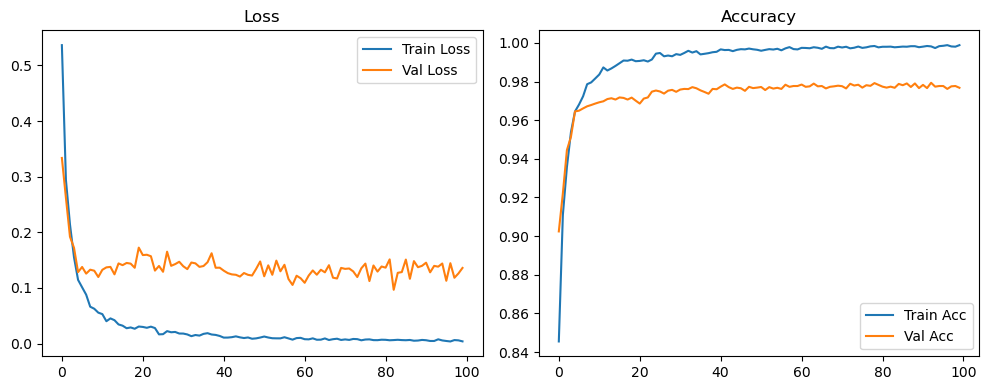

🚀 Running: batch256_lr0.01_0.01_0.01_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6491, Acc: 0.8108 | Val Loss: 0.3424, Acc: 0.9017


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3788, Acc: 0.8870 | Val Loss: 0.2774, Acc: 0.9183


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3074, Acc: 0.9101 | Val Loss: 0.2238, Acc: 0.9373


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2481, Acc: 0.9267 | Val Loss: 0.1875, Acc: 0.9467


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2012, Acc: 0.9395 | Val Loss: 0.1573, Acc: 0.9573


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1840, Acc: 0.9450 | Val Loss: 0.1664, Acc: 0.9554


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1577, Acc: 0.9521 | Val Loss: 0.1398, Acc: 0.9624


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1370, Acc: 0.9599 | Val Loss: 0.1436, Acc: 0.9615


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9631 | Val Loss: 0.1174, Acc: 0.9663


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9645 | Val Loss: 0.1172, Acc: 0.9671


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9690 | Val Loss: 0.1122, Acc: 0.9681


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0857, Acc: 0.9724 | Val Loss: 0.1077, Acc: 0.9709


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9744 | Val Loss: 0.1129, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9767 | Val Loss: 0.0999, Acc: 0.9726


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9784 | Val Loss: 0.1150, Acc: 0.9703


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9779 | Val Loss: 0.1000, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9790 | Val Loss: 0.1004, Acc: 0.9729


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9818 | Val Loss: 0.1033, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9828 | Val Loss: 0.1035, Acc: 0.9740


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9830 | Val Loss: 0.1000, Acc: 0.9751


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9828 | Val Loss: 0.0934, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9853 | Val Loss: 0.0991, Acc: 0.9748


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9850 | Val Loss: 0.0956, Acc: 0.9749


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9851 | Val Loss: 0.0975, Acc: 0.9749


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9861 | Val Loss: 0.1069, Acc: 0.9747


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9864 | Val Loss: 0.1071, Acc: 0.9760


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9879 | Val Loss: 0.1002, Acc: 0.9751


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9875 | Val Loss: 0.1187, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9879 | Val Loss: 0.1115, Acc: 0.9760


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9886 | Val Loss: 0.0964, Acc: 0.9762


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.1100, Acc: 0.9761


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9890 | Val Loss: 0.0925, Acc: 0.9775


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9895 | Val Loss: 0.0936, Acc: 0.9757


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9901 | Val Loss: 0.1083, Acc: 0.9755


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.1016, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9899 | Val Loss: 0.0965, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.1093, Acc: 0.9749


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9914 | Val Loss: 0.1051, Acc: 0.9775


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.1067, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.0962, Acc: 0.9768


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.0900, Acc: 0.9771


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.1081, Acc: 0.9763


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.1068, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.1232, Acc: 0.9765


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9926 | Val Loss: 0.1034, Acc: 0.9773


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.1137, Acc: 0.9770


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.0886, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.1105, Acc: 0.9765


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.1003, Acc: 0.9773


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.1038, Acc: 0.9778


Epoch 51/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.1061, Acc: 0.9774


Epoch 52/100 - LR: 0.01000 | Train Loss: 0.0200, Acc: 0.9933 | Val Loss: 0.1031, Acc: 0.9780


Epoch 53/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.1056, Acc: 0.9783


Epoch 54/100 - LR: 0.01000 | Train Loss: 0.0189, Acc: 0.9931 | Val Loss: 0.1080, Acc: 0.9768


Epoch 55/100 - LR: 0.01000 | Train Loss: 0.0209, Acc: 0.9934 | Val Loss: 0.0875, Acc: 0.9783


Epoch 56/100 - LR: 0.01000 | Train Loss: 0.0193, Acc: 0.9935 | Val Loss: 0.0948, Acc: 0.9780


Epoch 57/100 - LR: 0.01000 | Train Loss: 0.0202, Acc: 0.9935 | Val Loss: 0.0946, Acc: 0.9780


Epoch 58/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9944 | Val Loss: 0.1021, Acc: 0.9789


Epoch 59/100 - LR: 0.01000 | Train Loss: 0.0183, Acc: 0.9940 | Val Loss: 0.0923, Acc: 0.9788


Epoch 60/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.0997, Acc: 0.9792


Epoch 61/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9942 | Val Loss: 0.0990, Acc: 0.9775


Epoch 62/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.1050, Acc: 0.9781


Epoch 63/100 - LR: 0.01000 | Train Loss: 0.0171, Acc: 0.9944 | Val Loss: 0.1114, Acc: 0.9768


Epoch 64/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1110, Acc: 0.9786


Epoch 65/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9946 | Val Loss: 0.1107, Acc: 0.9781


Epoch 66/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9952 | Val Loss: 0.0986, Acc: 0.9797


Epoch 67/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.1012, Acc: 0.9785


Epoch 68/100 - LR: 0.01000 | Train Loss: 0.0167, Acc: 0.9943 | Val Loss: 0.0828, Acc: 0.9782


Epoch 69/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.1121, Acc: 0.9779


Epoch 70/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.0978, Acc: 0.9788


Epoch 71/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.0991, Acc: 0.9789


Epoch 72/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9951 | Val Loss: 0.1150, Acc: 0.9783


Epoch 73/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9955 | Val Loss: 0.1024, Acc: 0.9790


Epoch 74/100 - LR: 0.01000 | Train Loss: 0.0146, Acc: 0.9949 | Val Loss: 0.1071, Acc: 0.9797


Epoch 75/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9954 | Val Loss: 0.1302, Acc: 0.9787


Epoch 76/100 - LR: 0.01000 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.0884, Acc: 0.9786


Epoch 77/100 - LR: 0.01000 | Train Loss: 0.0151, Acc: 0.9954 | Val Loss: 0.0823, Acc: 0.9777


Epoch 78/100 - LR: 0.01000 | Train Loss: 0.0149, Acc: 0.9955 | Val Loss: 0.0972, Acc: 0.9797


Epoch 79/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9959 | Val Loss: 0.0937, Acc: 0.9792


Epoch 80/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1152, Acc: 0.9792


Epoch 81/100 - LR: 0.01000 | Train Loss: 0.0128, Acc: 0.9958 | Val Loss: 0.1030, Acc: 0.9791


Epoch 82/100 - LR: 0.01000 | Train Loss: 0.0133, Acc: 0.9956 | Val Loss: 0.1111, Acc: 0.9785


Epoch 83/100 - LR: 0.01000 | Train Loss: 0.0135, Acc: 0.9954 | Val Loss: 0.1070, Acc: 0.9787


Epoch 84/100 - LR: 0.01000 | Train Loss: 0.0147, Acc: 0.9953 | Val Loss: 0.1046, Acc: 0.9785


Epoch 85/100 - LR: 0.01000 | Train Loss: 0.0124, Acc: 0.9961 | Val Loss: 0.1008, Acc: 0.9780


Epoch 86/100 - LR: 0.01000 | Train Loss: 0.0121, Acc: 0.9960 | Val Loss: 0.1180, Acc: 0.9788


Epoch 87/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9964 | Val Loss: 0.1229, Acc: 0.9795


Epoch 88/100 - LR: 0.01000 | Train Loss: 0.0137, Acc: 0.9955 | Val Loss: 0.1054, Acc: 0.9793


Epoch 89/100 - LR: 0.01000 | Train Loss: 0.0098, Acc: 0.9966 | Val Loss: 0.1180, Acc: 0.9793


Epoch 90/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.0899, Acc: 0.9780


Epoch 91/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9959 | Val Loss: 0.0986, Acc: 0.9782


Epoch 92/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9961 | Val Loss: 0.1232, Acc: 0.9793


Epoch 93/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1146, Acc: 0.9772


Epoch 94/100 - LR: 0.01000 | Train Loss: 0.0140, Acc: 0.9961 | Val Loss: 0.1098, Acc: 0.9797


Epoch 95/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.1067, Acc: 0.9801


Epoch 96/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1068, Acc: 0.9787


Epoch 97/100 - LR: 0.01000 | Train Loss: 0.0110, Acc: 0.9961 | Val Loss: 0.1294, Acc: 0.9790


Epoch 98/100 - LR: 0.01000 | Train Loss: 0.0103, Acc: 0.9965 | Val Loss: 0.1109, Acc: 0.9786


Epoch 99/100 - LR: 0.01000 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1064, Acc: 0.9808


Epoch 100/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9964 | Val Loss: 0.1289, Acc: 0.9799


Final Test Loss: 0.1028 Accuracy: 0.9828


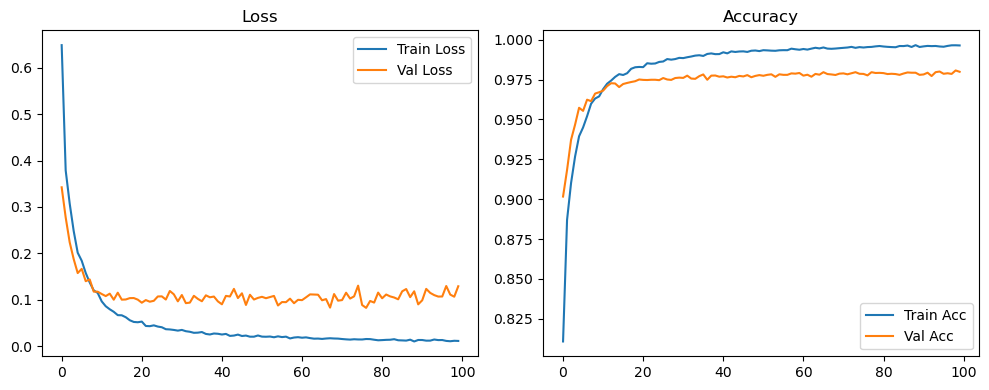

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5142, Acc: 0.8530 | Val Loss: 0.3202, Acc: 0.9068


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2324, Acc: 0.9304 | Val Loss: 0.2188, Acc: 0.9347


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1344, Acc: 0.9593 | Val Loss: 0.1704, Acc: 0.9496


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0849, Acc: 0.9741 | Val Loss: 0.1319, Acc: 0.9624


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9821 | Val Loss: 0.1211, Acc: 0.9663


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9859 | Val Loss: 0.1638, Acc: 0.9583


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.1142, Acc: 0.9711


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9913 | Val Loss: 0.1431, Acc: 0.9639


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.1339, Acc: 0.9669


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.1380, Acc: 0.9682


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.1535, Acc: 0.9648


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1446, Acc: 0.9697


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.1324, Acc: 0.9745


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1295, Acc: 0.9724


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.1305, Acc: 0.9728


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1408, Acc: 0.9707


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.2018, Acc: 0.9608


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.1296, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1263, Acc: 0.9740


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1470, Acc: 0.9722


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1359, Acc: 0.9738


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.1355, Acc: 0.9738


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1563, Acc: 0.9725


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.1422, Acc: 0.9689


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1471, Acc: 0.9738


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1400, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.2159, Acc: 0.9620


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1518, Acc: 0.9738


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1318, Acc: 0.9740


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1248, Acc: 0.9732


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1367, Acc: 0.9747


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1197, Acc: 0.9775


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1183, Acc: 0.9741


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1231, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1493, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.2257, Acc: 0.9634


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1330, Acc: 0.9724


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1742, Acc: 0.9697


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1780, Acc: 0.9748


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1518, Acc: 0.9727


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1561, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1713, Acc: 0.9738


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1663, Acc: 0.9738


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1537, Acc: 0.9721


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.2471, Acc: 0.9654


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1346, Acc: 0.9753


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1661, Acc: 0.9753


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1858, Acc: 0.9733


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1853, Acc: 0.9696


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1316, Acc: 0.9728


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1573, Acc: 0.9781


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1644, Acc: 0.9779


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1516, Acc: 0.9777


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1635, Acc: 0.9783


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1638, Acc: 0.9791


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1816, Acc: 0.9782


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1735, Acc: 0.9790


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1256, Acc: 0.9783


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1513, Acc: 0.9792


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1740, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1174, Acc: 0.9748


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1347, Acc: 0.9728


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1603, Acc: 0.9786


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1777, Acc: 0.9754


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1623, Acc: 0.9766


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1447, Acc: 0.9786


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1416, Acc: 0.9788


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1296, Acc: 0.9795


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1973, Acc: 0.9776


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1756, Acc: 0.9777


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1297, Acc: 0.9778


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1973, Acc: 0.9644


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1629, Acc: 0.9790


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1463, Acc: 0.9768


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1356, Acc: 0.9787


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1495, Acc: 0.9786


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1351, Acc: 0.9784


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1669, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2117, Acc: 0.9667


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1732, Acc: 0.9775


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1808, Acc: 0.9787


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1880, Acc: 0.9791


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1920, Acc: 0.9792


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1972, Acc: 0.9788


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2021, Acc: 0.9788


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2049, Acc: 0.9793


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2057, Acc: 0.9792


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2087, Acc: 0.9790


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2097, Acc: 0.9789


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2131, Acc: 0.9789


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2141, Acc: 0.9792


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1578, Acc: 0.9788


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1769, Acc: 0.9792


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1824, Acc: 0.9799


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1646, Acc: 0.9788


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1638, Acc: 0.9798


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1635, Acc: 0.9801


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1838, Acc: 0.9790


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1956, Acc: 0.9798


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2476, Acc: 0.9732


Final Test Loss: 0.2328 Accuracy: 0.9746


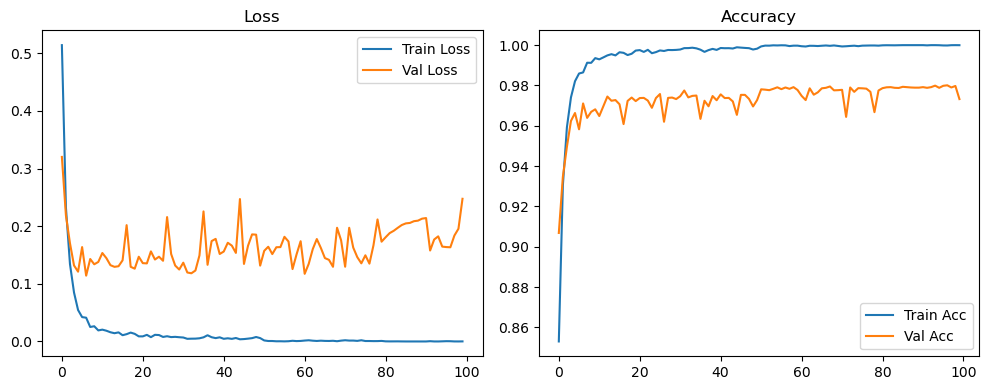

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5364, Acc: 0.8455 | Val Loss: 0.3336, Acc: 0.9024


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2940, Acc: 0.9109 | Val Loss: 0.2620, Acc: 0.9221


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2142, Acc: 0.9357 | Val Loss: 0.1920, Acc: 0.9445


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1549, Acc: 0.9538 | Val Loss: 0.1720, Acc: 0.9514


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9645 | Val Loss: 0.1283, Acc: 0.9645


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1011, Acc: 0.9681 | Val Loss: 0.1376, Acc: 0.9649


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9724 | Val Loss: 0.1257, Acc: 0.9661


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0662, Acc: 0.9786 | Val Loss: 0.1327, Acc: 0.9672


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9795 | Val Loss: 0.1309, Acc: 0.9678


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9816 | Val Loss: 0.1196, Acc: 0.9686


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9836 | Val Loss: 0.1325, Acc: 0.9692


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9873 | Val Loss: 0.1369, Acc: 0.9698


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9857 | Val Loss: 0.1378, Acc: 0.9709


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9868 | Val Loss: 0.1244, Acc: 0.9713


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9881 | Val Loss: 0.1440, Acc: 0.9707


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9895 | Val Loss: 0.1409, Acc: 0.9718


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.1449, Acc: 0.9715


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.1436, Acc: 0.9707


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.1362, Acc: 0.9717


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9905 | Val Loss: 0.1724, Acc: 0.9701


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.1590, Acc: 0.9686


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.1596, Acc: 0.9712


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9903 | Val Loss: 0.1569, Acc: 0.9718


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9914 | Val Loss: 0.1311, Acc: 0.9748


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.1395, Acc: 0.9753


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9948 | Val Loss: 0.1290, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.1651, Acc: 0.9738


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.1397, Acc: 0.9752


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1428, Acc: 0.9757


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.1470, Acc: 0.9747


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9938 | Val Loss: 0.1389, Acc: 0.9758


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.1338, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.1456, Acc: 0.9761


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.1441, Acc: 0.9771


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.1378, Acc: 0.9765


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9940 | Val Loss: 0.1393, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9943 | Val Loss: 0.1462, Acc: 0.9746


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.1623, Acc: 0.9737


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.1362, Acc: 0.9762


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.1364, Acc: 0.9760


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1310, Acc: 0.9773


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.1266, Acc: 0.9785


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.1243, Acc: 0.9771


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1236, Acc: 0.9762


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1204, Acc: 0.9768


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1267, Acc: 0.9765


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1235, Acc: 0.9752


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1222, Acc: 0.9772


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1341, Acc: 0.9766


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1475, Acc: 0.9768


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1061, Acc: 0.9788


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1224, Acc: 0.9775


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1207, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1175, Acc: 0.9801


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1208, Acc: 0.9788


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1208, Acc: 0.9808


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1219, Acc: 0.9798


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1309, Acc: 0.9803


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1267, Acc: 0.9778


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1389, Acc: 0.9795


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1247, Acc: 0.9794


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1294, Acc: 0.9801


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1415, Acc: 0.9799


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1376, Acc: 0.9775


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9985 | Val Loss: 0.1371, Acc: 0.9795


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1414, Acc: 0.9797


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1427, Acc: 0.9782


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1406, Acc: 0.9791


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1463, Acc: 0.9791


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1493, Acc: 0.9782


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1484, Acc: 0.9790


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1484, Acc: 0.9788


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1478, Acc: 0.9787


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1624, Acc: 0.9773


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1602, Acc: 0.9780


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1208, Acc: 0.9802


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1407, Acc: 0.9791


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1427, Acc: 0.9802


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1559, Acc: 0.9793


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1363, Acc: 0.9791


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1353, Acc: 0.9808


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9994 | Val Loss: 0.1404, Acc: 0.9808


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1398, Acc: 0.9808


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1474, Acc: 0.9808


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1474, Acc: 0.9803


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1504, Acc: 0.9803


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1547, Acc: 0.9808


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1490, Acc: 0.9810


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1512, Acc: 0.9804


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1518, Acc: 0.9808


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1521, Acc: 0.9813


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1552, Acc: 0.9810


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1531, Acc: 0.9807


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1547, Acc: 0.9805


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1561, Acc: 0.9815


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1622, Acc: 0.9812


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9996 | Val Loss: 0.1565, Acc: 0.9811


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1516, Acc: 0.9807


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1521, Acc: 0.9808


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1478, Acc: 0.9808


Final Test Loss: 0.1525 Accuracy: 0.9803


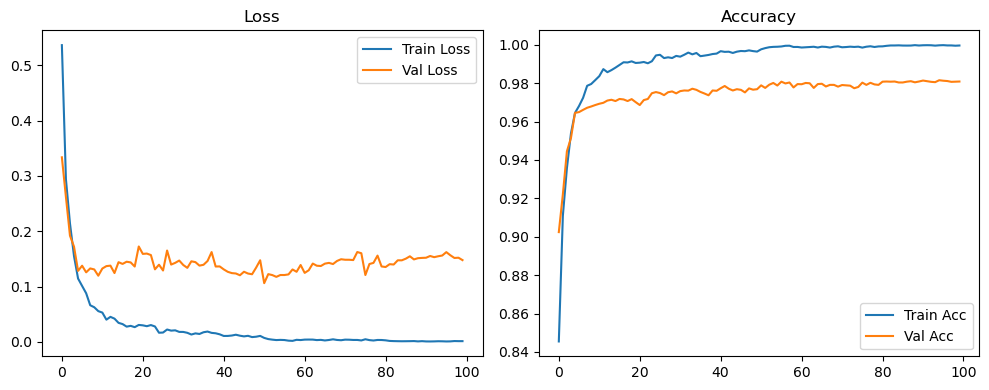

🚀 Running: batch256_lr0.01_0.005_0.002_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6491, Acc: 0.8108 | Val Loss: 0.3424, Acc: 0.9017


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3788, Acc: 0.8870 | Val Loss: 0.2774, Acc: 0.9183


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3074, Acc: 0.9101 | Val Loss: 0.2238, Acc: 0.9373


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2481, Acc: 0.9267 | Val Loss: 0.1875, Acc: 0.9467


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2012, Acc: 0.9395 | Val Loss: 0.1573, Acc: 0.9573


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1840, Acc: 0.9450 | Val Loss: 0.1664, Acc: 0.9554


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1577, Acc: 0.9521 | Val Loss: 0.1398, Acc: 0.9624


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1370, Acc: 0.9599 | Val Loss: 0.1436, Acc: 0.9615


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9631 | Val Loss: 0.1174, Acc: 0.9663


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9645 | Val Loss: 0.1172, Acc: 0.9671


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9690 | Val Loss: 0.1122, Acc: 0.9681


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0857, Acc: 0.9724 | Val Loss: 0.1077, Acc: 0.9709


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9744 | Val Loss: 0.1129, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9767 | Val Loss: 0.0999, Acc: 0.9726


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9784 | Val Loss: 0.1150, Acc: 0.9703


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9779 | Val Loss: 0.1000, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9790 | Val Loss: 0.1004, Acc: 0.9729


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9818 | Val Loss: 0.1033, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9828 | Val Loss: 0.1035, Acc: 0.9740


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9830 | Val Loss: 0.1000, Acc: 0.9751


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9828 | Val Loss: 0.0934, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9853 | Val Loss: 0.0991, Acc: 0.9748


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9850 | Val Loss: 0.0956, Acc: 0.9749


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9851 | Val Loss: 0.0975, Acc: 0.9749


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9861 | Val Loss: 0.1069, Acc: 0.9747


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9864 | Val Loss: 0.1071, Acc: 0.9760


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9879 | Val Loss: 0.1002, Acc: 0.9751


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9875 | Val Loss: 0.1187, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9879 | Val Loss: 0.1115, Acc: 0.9760


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9886 | Val Loss: 0.0964, Acc: 0.9762


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.1100, Acc: 0.9761


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9890 | Val Loss: 0.0925, Acc: 0.9775


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9895 | Val Loss: 0.0936, Acc: 0.9757


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9901 | Val Loss: 0.1083, Acc: 0.9755


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.1016, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9899 | Val Loss: 0.0965, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.1093, Acc: 0.9749


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9914 | Val Loss: 0.1051, Acc: 0.9775


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.1067, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.0962, Acc: 0.9768


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.0900, Acc: 0.9771


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.1081, Acc: 0.9763


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.1068, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.1232, Acc: 0.9765


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9926 | Val Loss: 0.1034, Acc: 0.9773


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.1137, Acc: 0.9770


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.0886, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.1105, Acc: 0.9765


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.1003, Acc: 0.9773


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.1038, Acc: 0.9778


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.0916, Acc: 0.9779


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1034, Acc: 0.9787


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0970, Acc: 0.9790


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1122, Acc: 0.9792


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0969, Acc: 0.9800


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1073, Acc: 0.9790


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0938, Acc: 0.9795


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1192, Acc: 0.9785


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.1042, Acc: 0.9792


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.1051, Acc: 0.9798


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1038, Acc: 0.9798


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0991, Acc: 0.9803


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1075, Acc: 0.9781


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0954, Acc: 0.9797


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1129, Acc: 0.9797


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1102, Acc: 0.9783


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1106, Acc: 0.9786


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1109, Acc: 0.9795


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1085, Acc: 0.9799


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1084, Acc: 0.9801


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0910, Acc: 0.9797


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0922, Acc: 0.9796


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1097, Acc: 0.9798


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1079, Acc: 0.9791


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1207, Acc: 0.9793


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.1177, Acc: 0.9794


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1163, Acc: 0.9798


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0996, Acc: 0.9798


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1229, Acc: 0.9791


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1161, Acc: 0.9796


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1031, Acc: 0.9798


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1080, Acc: 0.9802


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1109, Acc: 0.9801


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9982 | Val Loss: 0.1128, Acc: 0.9811


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1175, Acc: 0.9808


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9984 | Val Loss: 0.1133, Acc: 0.9809


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.1143, Acc: 0.9810


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1127, Acc: 0.9812


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9986 | Val Loss: 0.1091, Acc: 0.9809


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0055, Acc: 0.9981 | Val Loss: 0.1168, Acc: 0.9808


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9986 | Val Loss: 0.1252, Acc: 0.9812


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1155, Acc: 0.9812


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1221, Acc: 0.9812


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1199, Acc: 0.9808


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9986 | Val Loss: 0.1171, Acc: 0.9813


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1240, Acc: 0.9812


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1219, Acc: 0.9816


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1163, Acc: 0.9818


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1141, Acc: 0.9814


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1216, Acc: 0.9802


Final Test Loss: 0.1073 Accuracy: 0.9824


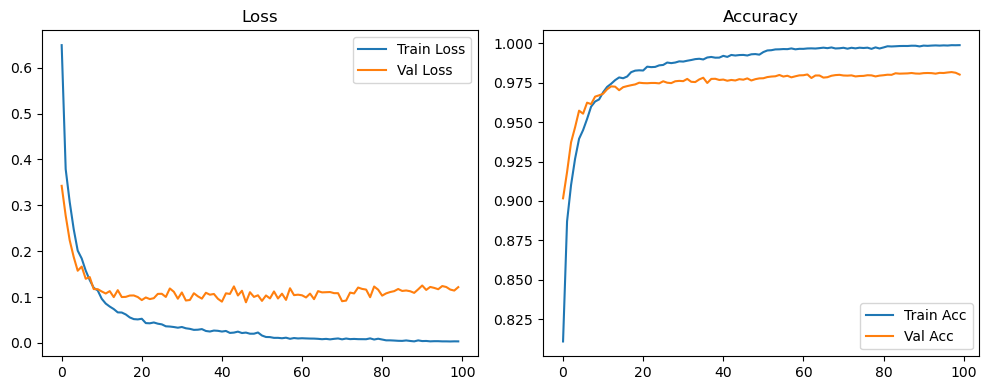

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5142, Acc: 0.8530 | Val Loss: 0.3202, Acc: 0.9068


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2324, Acc: 0.9304 | Val Loss: 0.2188, Acc: 0.9347


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1344, Acc: 0.9593 | Val Loss: 0.1704, Acc: 0.9496


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0849, Acc: 0.9741 | Val Loss: 0.1319, Acc: 0.9624


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9821 | Val Loss: 0.1211, Acc: 0.9663


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9859 | Val Loss: 0.1638, Acc: 0.9583


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.1142, Acc: 0.9711


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9913 | Val Loss: 0.1431, Acc: 0.9639


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.1339, Acc: 0.9669


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.1380, Acc: 0.9682


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.1535, Acc: 0.9648


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1446, Acc: 0.9697


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.1324, Acc: 0.9745


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1295, Acc: 0.9724


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.1305, Acc: 0.9728


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1408, Acc: 0.9707


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.2018, Acc: 0.9608


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.1296, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1263, Acc: 0.9740


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1470, Acc: 0.9722


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1359, Acc: 0.9738


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.1355, Acc: 0.9738


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1563, Acc: 0.9725


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.1422, Acc: 0.9689


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1471, Acc: 0.9738


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1400, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.2159, Acc: 0.9620


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1518, Acc: 0.9738


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1318, Acc: 0.9740


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1248, Acc: 0.9732


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1367, Acc: 0.9747


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1197, Acc: 0.9775


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1183, Acc: 0.9741


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1231, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1493, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.2257, Acc: 0.9634


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1330, Acc: 0.9724


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1742, Acc: 0.9697


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1780, Acc: 0.9748


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1518, Acc: 0.9727


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1561, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1713, Acc: 0.9738


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1663, Acc: 0.9738


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1537, Acc: 0.9721


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.2471, Acc: 0.9654


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1346, Acc: 0.9753


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1661, Acc: 0.9753


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1858, Acc: 0.9733


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1853, Acc: 0.9696


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1316, Acc: 0.9728


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1573, Acc: 0.9781


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1644, Acc: 0.9779


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1516, Acc: 0.9777


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1635, Acc: 0.9783


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1638, Acc: 0.9791


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1816, Acc: 0.9782


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1735, Acc: 0.9790


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1256, Acc: 0.9783


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1513, Acc: 0.9792


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1740, Acc: 0.9778


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1174, Acc: 0.9748


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1347, Acc: 0.9728


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1603, Acc: 0.9786


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1777, Acc: 0.9754


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1623, Acc: 0.9766


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1447, Acc: 0.9786


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1416, Acc: 0.9788


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1296, Acc: 0.9795


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1973, Acc: 0.9776


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1756, Acc: 0.9777


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1297, Acc: 0.9778


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1973, Acc: 0.9644


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1629, Acc: 0.9790


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1463, Acc: 0.9768


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0021, Acc: 0.9995 | Val Loss: 0.1356, Acc: 0.9787


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1495, Acc: 0.9786


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1351, Acc: 0.9784


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1669, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.2117, Acc: 0.9667


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1732, Acc: 0.9775


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1730, Acc: 0.9789


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1796, Acc: 0.9788


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1840, Acc: 0.9780


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1900, Acc: 0.9779


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1929, Acc: 0.9781


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1970, Acc: 0.9782


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1963, Acc: 0.9781


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1996, Acc: 0.9782


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2027, Acc: 0.9787


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2046, Acc: 0.9788


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2061, Acc: 0.9789


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2103, Acc: 0.9794


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2111, Acc: 0.9791


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2108, Acc: 0.9790


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2155, Acc: 0.9789


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2168, Acc: 0.9792


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2194, Acc: 0.9787


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2207, Acc: 0.9788


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2209, Acc: 0.9793


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2222, Acc: 0.9792


Final Test Loss: 0.2062 Accuracy: 0.9815


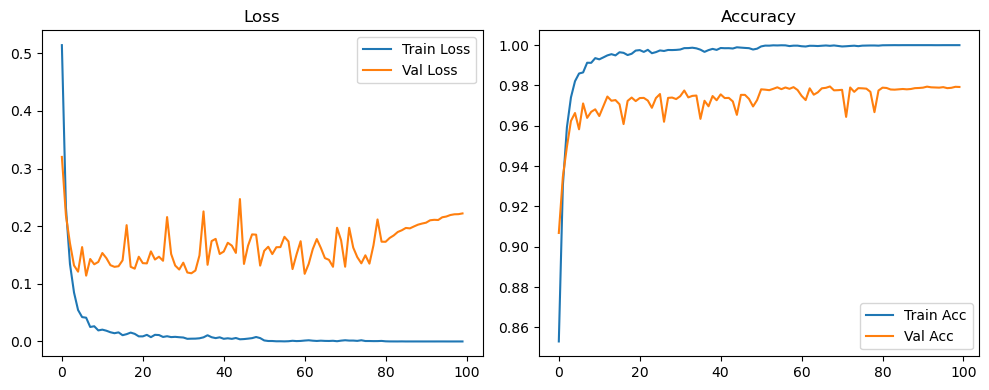

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5364, Acc: 0.8455 | Val Loss: 0.3336, Acc: 0.9024


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2940, Acc: 0.9109 | Val Loss: 0.2620, Acc: 0.9221


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2142, Acc: 0.9357 | Val Loss: 0.1920, Acc: 0.9445


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1549, Acc: 0.9538 | Val Loss: 0.1720, Acc: 0.9514


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9645 | Val Loss: 0.1283, Acc: 0.9645


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1011, Acc: 0.9681 | Val Loss: 0.1376, Acc: 0.9649


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0879, Acc: 0.9724 | Val Loss: 0.1257, Acc: 0.9661


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0662, Acc: 0.9786 | Val Loss: 0.1327, Acc: 0.9672


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0625, Acc: 0.9795 | Val Loss: 0.1309, Acc: 0.9678


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0555, Acc: 0.9816 | Val Loss: 0.1196, Acc: 0.9686


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0529, Acc: 0.9836 | Val Loss: 0.1325, Acc: 0.9692


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0401, Acc: 0.9873 | Val Loss: 0.1369, Acc: 0.9698


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0452, Acc: 0.9857 | Val Loss: 0.1378, Acc: 0.9709


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9868 | Val Loss: 0.1244, Acc: 0.9713


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0343, Acc: 0.9881 | Val Loss: 0.1440, Acc: 0.9707


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0321, Acc: 0.9895 | Val Loss: 0.1409, Acc: 0.9718


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.1449, Acc: 0.9715


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0289, Acc: 0.9908 | Val Loss: 0.1436, Acc: 0.9707


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0265, Acc: 0.9913 | Val Loss: 0.1362, Acc: 0.9717


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0306, Acc: 0.9905 | Val Loss: 0.1724, Acc: 0.9701


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0298, Acc: 0.9906 | Val Loss: 0.1590, Acc: 0.9686


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0283, Acc: 0.9910 | Val Loss: 0.1596, Acc: 0.9712


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0303, Acc: 0.9903 | Val Loss: 0.1569, Acc: 0.9718


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0278, Acc: 0.9914 | Val Loss: 0.1311, Acc: 0.9748


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0165, Acc: 0.9944 | Val Loss: 0.1395, Acc: 0.9753


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0168, Acc: 0.9948 | Val Loss: 0.1290, Acc: 0.9748


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0223, Acc: 0.9930 | Val Loss: 0.1651, Acc: 0.9738


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0203, Acc: 0.9934 | Val Loss: 0.1397, Acc: 0.9752


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0208, Acc: 0.9931 | Val Loss: 0.1428, Acc: 0.9757


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9942 | Val Loss: 0.1470, Acc: 0.9747


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0179, Acc: 0.9938 | Val Loss: 0.1389, Acc: 0.9758


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0163, Acc: 0.9948 | Val Loss: 0.1338, Acc: 0.9762


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9959 | Val Loss: 0.1456, Acc: 0.9761


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0153, Acc: 0.9950 | Val Loss: 0.1441, Acc: 0.9771


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9957 | Val Loss: 0.1378, Acc: 0.9765


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0173, Acc: 0.9940 | Val Loss: 0.1393, Acc: 0.9754


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9943 | Val Loss: 0.1462, Acc: 0.9746


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.1623, Acc: 0.9737


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0155, Acc: 0.9951 | Val Loss: 0.1362, Acc: 0.9762


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0136, Acc: 0.9954 | Val Loss: 0.1364, Acc: 0.9760


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0106, Acc: 0.9966 | Val Loss: 0.1310, Acc: 0.9773


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.1266, Acc: 0.9785


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.1243, Acc: 0.9771


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0129, Acc: 0.9957 | Val Loss: 0.1236, Acc: 0.9762


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.1204, Acc: 0.9768


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1267, Acc: 0.9765


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9966 | Val Loss: 0.1235, Acc: 0.9752


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0086, Acc: 0.9970 | Val Loss: 0.1222, Acc: 0.9772


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0093, Acc: 0.9967 | Val Loss: 0.1341, Acc: 0.9766


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1475, Acc: 0.9768


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0071, Acc: 0.9976 | Val Loss: 0.1061, Acc: 0.9788


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9982 | Val Loss: 0.1224, Acc: 0.9775


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1207, Acc: 0.9792


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1175, Acc: 0.9801


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0035, Acc: 0.9989 | Val Loss: 0.1208, Acc: 0.9788


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1208, Acc: 0.9808


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1219, Acc: 0.9798


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1309, Acc: 0.9803


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1267, Acc: 0.9778


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1389, Acc: 0.9795


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9985 | Val Loss: 0.1247, Acc: 0.9794


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1294, Acc: 0.9801


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0041, Acc: 0.9988 | Val Loss: 0.1415, Acc: 0.9799


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1376, Acc: 0.9775


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9985 | Val Loss: 0.1371, Acc: 0.9795


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1414, Acc: 0.9797


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1427, Acc: 0.9782


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1406, Acc: 0.9791


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1463, Acc: 0.9791


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1493, Acc: 0.9782


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9987 | Val Loss: 0.1484, Acc: 0.9790


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1484, Acc: 0.9788


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1478, Acc: 0.9787


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1624, Acc: 0.9773


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0025, Acc: 0.9990 | Val Loss: 0.1602, Acc: 0.9780


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1208, Acc: 0.9802


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1407, Acc: 0.9791


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1427, Acc: 0.9802


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1559, Acc: 0.9793


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0033, Acc: 0.9991 | Val Loss: 0.1363, Acc: 0.9791


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1333, Acc: 0.9804


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1350, Acc: 0.9808


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1349, Acc: 0.9811


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1425, Acc: 0.9808


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1390, Acc: 0.9813


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1407, Acc: 0.9810


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1465, Acc: 0.9809


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1425, Acc: 0.9817


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1452, Acc: 0.9811


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1510, Acc: 0.9810


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1481, Acc: 0.9813


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9997 | Val Loss: 0.1493, Acc: 0.9815


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1506, Acc: 0.9819


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1469, Acc: 0.9814


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1483, Acc: 0.9816


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1532, Acc: 0.9817


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1450, Acc: 0.9821


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1454, Acc: 0.9812


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1502, Acc: 0.9816


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9997 | Val Loss: 0.1495, Acc: 0.9812


Final Test Loss: 0.1467 Accuracy: 0.9809


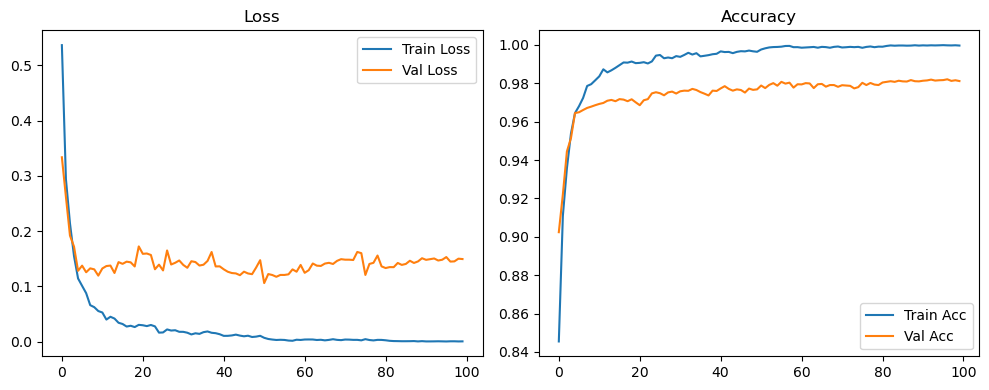

🚀 Running: batch256_lr0.01_0.005_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6491, Acc: 0.8108 | Val Loss: 0.3424, Acc: 0.9017


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3788, Acc: 0.8870 | Val Loss: 0.2774, Acc: 0.9183


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3074, Acc: 0.9101 | Val Loss: 0.2238, Acc: 0.9373


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2481, Acc: 0.9267 | Val Loss: 0.1875, Acc: 0.9467


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2012, Acc: 0.9395 | Val Loss: 0.1573, Acc: 0.9573


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1840, Acc: 0.9450 | Val Loss: 0.1664, Acc: 0.9554


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1577, Acc: 0.9521 | Val Loss: 0.1398, Acc: 0.9624


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1370, Acc: 0.9599 | Val Loss: 0.1436, Acc: 0.9615


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9631 | Val Loss: 0.1174, Acc: 0.9663


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9645 | Val Loss: 0.1172, Acc: 0.9671


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9690 | Val Loss: 0.1122, Acc: 0.9681


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0857, Acc: 0.9724 | Val Loss: 0.1077, Acc: 0.9709


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9744 | Val Loss: 0.1129, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9767 | Val Loss: 0.0999, Acc: 0.9726


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9784 | Val Loss: 0.1150, Acc: 0.9703


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9779 | Val Loss: 0.1000, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9790 | Val Loss: 0.1004, Acc: 0.9729


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9818 | Val Loss: 0.1033, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9828 | Val Loss: 0.1035, Acc: 0.9740


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9830 | Val Loss: 0.1000, Acc: 0.9751


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9828 | Val Loss: 0.0934, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9853 | Val Loss: 0.0991, Acc: 0.9748


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9850 | Val Loss: 0.0956, Acc: 0.9749


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9851 | Val Loss: 0.0975, Acc: 0.9749


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9861 | Val Loss: 0.1069, Acc: 0.9747


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9864 | Val Loss: 0.1071, Acc: 0.9760


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9879 | Val Loss: 0.1002, Acc: 0.9751


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9875 | Val Loss: 0.1187, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9879 | Val Loss: 0.1115, Acc: 0.9760


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9886 | Val Loss: 0.0964, Acc: 0.9762


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.1100, Acc: 0.9761


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9890 | Val Loss: 0.0925, Acc: 0.9775


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9895 | Val Loss: 0.0936, Acc: 0.9757


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9901 | Val Loss: 0.1083, Acc: 0.9755


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.1016, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9899 | Val Loss: 0.0965, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.1093, Acc: 0.9749


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9914 | Val Loss: 0.1051, Acc: 0.9775


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.1067, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.0962, Acc: 0.9768


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.0900, Acc: 0.9771


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.1081, Acc: 0.9763


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.1068, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.1232, Acc: 0.9765


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9926 | Val Loss: 0.1034, Acc: 0.9773


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.1137, Acc: 0.9770


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.0886, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.1105, Acc: 0.9765


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.1003, Acc: 0.9773


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.1038, Acc: 0.9778


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.0916, Acc: 0.9779


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1034, Acc: 0.9787


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.0970, Acc: 0.9790


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9962 | Val Loss: 0.1122, Acc: 0.9792


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.0969, Acc: 0.9800


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1073, Acc: 0.9790


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9964 | Val Loss: 0.0938, Acc: 0.9795


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1192, Acc: 0.9785


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0106, Acc: 0.9963 | Val Loss: 0.1042, Acc: 0.9792


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9966 | Val Loss: 0.1051, Acc: 0.9798


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0102, Acc: 0.9966 | Val Loss: 0.1038, Acc: 0.9798


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.0991, Acc: 0.9803


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1075, Acc: 0.9781


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.0954, Acc: 0.9797


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1129, Acc: 0.9797


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1102, Acc: 0.9783


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1106, Acc: 0.9786


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1109, Acc: 0.9795


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9968 | Val Loss: 0.1085, Acc: 0.9799


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9970 | Val Loss: 0.1084, Acc: 0.9801


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9973 | Val Loss: 0.0910, Acc: 0.9797


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.0922, Acc: 0.9796


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1097, Acc: 0.9798


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9969 | Val Loss: 0.1079, Acc: 0.9791


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1207, Acc: 0.9793


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.1177, Acc: 0.9794


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1163, Acc: 0.9798


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0099, Acc: 0.9966 | Val Loss: 0.0996, Acc: 0.9798


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1229, Acc: 0.9791


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0092, Acc: 0.9968 | Val Loss: 0.1161, Acc: 0.9796


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1056, Acc: 0.9794


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9981 | Val Loss: 0.1085, Acc: 0.9802


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1086, Acc: 0.9803


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1137, Acc: 0.9810


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9982 | Val Loss: 0.1138, Acc: 0.9810


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1121, Acc: 0.9806


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0054, Acc: 0.9983 | Val Loss: 0.1108, Acc: 0.9809


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9983 | Val Loss: 0.1111, Acc: 0.9812


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1116, Acc: 0.9807


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9983 | Val Loss: 0.1120, Acc: 0.9810


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1173, Acc: 0.9813


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1179, Acc: 0.9815


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9988 | Val Loss: 0.1160, Acc: 0.9812


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9986 | Val Loss: 0.1168, Acc: 0.9800


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1162, Acc: 0.9815


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1216, Acc: 0.9818


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1155, Acc: 0.9822


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1208, Acc: 0.9815


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1187, Acc: 0.9812


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1208, Acc: 0.9810


Final Test Loss: 0.1098 Accuracy: 0.9817


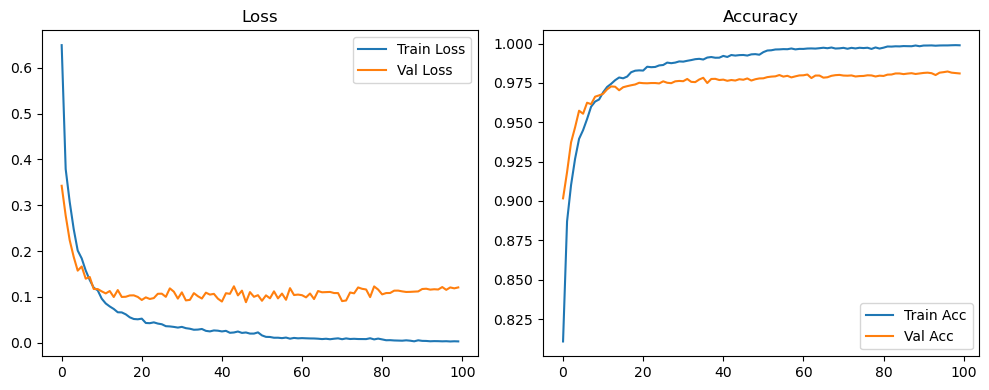

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5142, Acc: 0.8530 | Val Loss: 0.3202, Acc: 0.9068


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2324, Acc: 0.9304 | Val Loss: 0.2188, Acc: 0.9347


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.1344, Acc: 0.9593 | Val Loss: 0.1704, Acc: 0.9496


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.0849, Acc: 0.9741 | Val Loss: 0.1319, Acc: 0.9624


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.0546, Acc: 0.9821 | Val Loss: 0.1211, Acc: 0.9663


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.0423, Acc: 0.9859 | Val Loss: 0.1638, Acc: 0.9583


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0412, Acc: 0.9865 | Val Loss: 0.1142, Acc: 0.9711


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0252, Acc: 0.9913 | Val Loss: 0.1431, Acc: 0.9639


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9912 | Val Loss: 0.1339, Acc: 0.9669


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0192, Acc: 0.9936 | Val Loss: 0.1380, Acc: 0.9682


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0205, Acc: 0.9930 | Val Loss: 0.1535, Acc: 0.9648


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0186, Acc: 0.9939 | Val Loss: 0.1446, Acc: 0.9697


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9949 | Val Loss: 0.1324, Acc: 0.9745


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1295, Acc: 0.9724


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9949 | Val Loss: 0.1305, Acc: 0.9728


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0109, Acc: 0.9965 | Val Loss: 0.1408, Acc: 0.9707


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9962 | Val Loss: 0.2018, Acc: 0.9608


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0154, Acc: 0.9951 | Val Loss: 0.1296, Acc: 0.9723


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0132, Acc: 0.9957 | Val Loss: 0.1263, Acc: 0.9740


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0089, Acc: 0.9973 | Val Loss: 0.1470, Acc: 0.9722


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0088, Acc: 0.9975 | Val Loss: 0.1359, Acc: 0.9738


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9966 | Val Loss: 0.1355, Acc: 0.9738


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0075, Acc: 0.9977 | Val Loss: 0.1563, Acc: 0.9725


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9960 | Val Loss: 0.1422, Acc: 0.9689


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1471, Acc: 0.9738


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1400, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0091, Acc: 0.9971 | Val Loss: 0.2159, Acc: 0.9620


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0076, Acc: 0.9976 | Val Loss: 0.1518, Acc: 0.9738


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0080, Acc: 0.9976 | Val Loss: 0.1318, Acc: 0.9740


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1248, Acc: 0.9732


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1367, Acc: 0.9747


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1197, Acc: 0.9775


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0048, Acc: 0.9985 | Val Loss: 0.1183, Acc: 0.9741


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9987 | Val Loss: 0.1231, Acc: 0.9748


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1493, Acc: 0.9750


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.2257, Acc: 0.9634


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1330, Acc: 0.9724


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0074, Acc: 0.9975 | Val Loss: 0.1742, Acc: 0.9697


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1780, Acc: 0.9748


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1518, Acc: 0.9727


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1561, Acc: 0.9756


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0055, Acc: 0.9985 | Val Loss: 0.1713, Acc: 0.9738


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0045, Acc: 0.9985 | Val Loss: 0.1663, Acc: 0.9738


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0060, Acc: 0.9983 | Val Loss: 0.1537, Acc: 0.9721


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.2471, Acc: 0.9654


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.1346, Acc: 0.9753


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0049, Acc: 0.9986 | Val Loss: 0.1661, Acc: 0.9753


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9985 | Val Loss: 0.1858, Acc: 0.9733


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0077, Acc: 0.9978 | Val Loss: 0.1853, Acc: 0.9696


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1316, Acc: 0.9728


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1414, Acc: 0.9778


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1562, Acc: 0.9777


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1627, Acc: 0.9776


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1632, Acc: 0.9778


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1665, Acc: 0.9781


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1713, Acc: 0.9782


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1742, Acc: 0.9785


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1713, Acc: 0.9788


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1738, Acc: 0.9790


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1752, Acc: 0.9785


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1791, Acc: 0.9788


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1829, Acc: 0.9787


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1853, Acc: 0.9787


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1804, Acc: 0.9792


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1833, Acc: 0.9787


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1920, Acc: 0.9785


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1947, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2165, Acc: 0.9763


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9999 | Val Loss: 0.1737, Acc: 0.9779


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1596, Acc: 0.9783


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1644, Acc: 0.9802


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1656, Acc: 0.9785


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1666, Acc: 0.9778


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1684, Acc: 0.9789


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1649, Acc: 0.9781


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1625, Acc: 0.9752


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1656, Acc: 0.9794


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1716, Acc: 0.9789


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1897, Acc: 0.9784


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1951, Acc: 0.9785


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1928, Acc: 0.9775


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1948, Acc: 0.9784


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1991, Acc: 0.9791


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2071, Acc: 0.9788


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1965, Acc: 0.9788


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1681, Acc: 0.9788


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1735, Acc: 0.9791


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1776, Acc: 0.9792


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1780, Acc: 0.9793


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1821, Acc: 0.9792


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1839, Acc: 0.9795


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1876, Acc: 0.9792


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1902, Acc: 0.9788


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1898, Acc: 0.9787


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1965, Acc: 0.9788


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2050, Acc: 0.9787


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2060, Acc: 0.9792


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2058, Acc: 0.9795


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2065, Acc: 0.9795


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2131, Acc: 0.9792


Final Test Loss: 0.1850 Accuracy: 0.9809


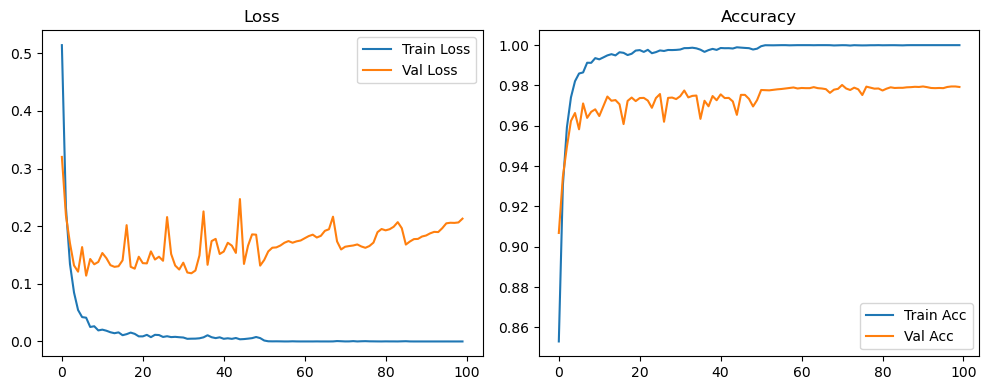

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.5364, Acc: 0.8455 | Val Loss: 0.3336, Acc: 0.9024


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.2941, Acc: 0.9109 | Val Loss: 0.2620, Acc: 0.9222


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.2134, Acc: 0.9363 | Val Loss: 0.1925, Acc: 0.9440


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.1549, Acc: 0.9540 | Val Loss: 0.1749, Acc: 0.9510


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9640 | Val Loss: 0.1335, Acc: 0.9626


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1016, Acc: 0.9687 | Val Loss: 0.1350, Acc: 0.9647


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.0854, Acc: 0.9731 | Val Loss: 0.1246, Acc: 0.9679


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.0647, Acc: 0.9795 | Val Loss: 0.1392, Acc: 0.9663


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.0634, Acc: 0.9795 | Val Loss: 0.1295, Acc: 0.9670


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.0534, Acc: 0.9825 | Val Loss: 0.1182, Acc: 0.9707


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0507, Acc: 0.9829 | Val Loss: 0.1392, Acc: 0.9689


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0403, Acc: 0.9875 | Val Loss: 0.1280, Acc: 0.9711


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0421, Acc: 0.9864 | Val Loss: 0.1253, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0379, Acc: 0.9875 | Val Loss: 0.1264, Acc: 0.9730


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0350, Acc: 0.9876 | Val Loss: 0.1323, Acc: 0.9715


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0296, Acc: 0.9896 | Val Loss: 0.1423, Acc: 0.9710


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9902 | Val Loss: 0.1506, Acc: 0.9709


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0232, Acc: 0.9922 | Val Loss: 0.1267, Acc: 0.9740


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0251, Acc: 0.9912 | Val Loss: 0.1394, Acc: 0.9728


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0236, Acc: 0.9922 | Val Loss: 0.1382, Acc: 0.9725


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0242, Acc: 0.9921 | Val Loss: 0.1162, Acc: 0.9732


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0224, Acc: 0.9924 | Val Loss: 0.1299, Acc: 0.9749


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0231, Acc: 0.9922 | Val Loss: 0.1210, Acc: 0.9754


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0187, Acc: 0.9935 | Val Loss: 0.1110, Acc: 0.9770


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.1212, Acc: 0.9748


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0180, Acc: 0.9935 | Val Loss: 0.1093, Acc: 0.9758


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0160, Acc: 0.9947 | Val Loss: 0.1326, Acc: 0.9750


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0150, Acc: 0.9950 | Val Loss: 0.1452, Acc: 0.9746


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0158, Acc: 0.9950 | Val Loss: 0.1437, Acc: 0.9732


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0178, Acc: 0.9943 | Val Loss: 0.1266, Acc: 0.9753


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0157, Acc: 0.9942 | Val Loss: 0.1274, Acc: 0.9750


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0164, Acc: 0.9948 | Val Loss: 0.1236, Acc: 0.9751


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0130, Acc: 0.9956 | Val Loss: 0.1241, Acc: 0.9745


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0144, Acc: 0.9953 | Val Loss: 0.1340, Acc: 0.9728


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.1461, Acc: 0.9751


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0120, Acc: 0.9959 | Val Loss: 0.1305, Acc: 0.9750


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1373, Acc: 0.9753


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0138, Acc: 0.9952 | Val Loss: 0.1173, Acc: 0.9742


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0126, Acc: 0.9957 | Val Loss: 0.1273, Acc: 0.9770


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1432, Acc: 0.9749


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0105, Acc: 0.9963 | Val Loss: 0.1408, Acc: 0.9748


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1255, Acc: 0.9773


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.1389, Acc: 0.9758


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0108, Acc: 0.9967 | Val Loss: 0.1423, Acc: 0.9765


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9962 | Val Loss: 0.1483, Acc: 0.9768


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1075, Acc: 0.9769


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0111, Acc: 0.9963 | Val Loss: 0.1288, Acc: 0.9755


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0101, Acc: 0.9968 | Val Loss: 0.1539, Acc: 0.9753


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1288, Acc: 0.9758


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0115, Acc: 0.9963 | Val Loss: 0.1308, Acc: 0.9749


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1170, Acc: 0.9792


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9984 | Val Loss: 0.1247, Acc: 0.9798


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1368, Acc: 0.9798


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1355, Acc: 0.9794


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1305, Acc: 0.9794


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9991 | Val Loss: 0.1282, Acc: 0.9795


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1427, Acc: 0.9803


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1421, Acc: 0.9800


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9992 | Val Loss: 0.1459, Acc: 0.9789


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1372, Acc: 0.9788


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1358, Acc: 0.9794


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1353, Acc: 0.9784


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9996 | Val Loss: 0.1359, Acc: 0.9787


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1484, Acc: 0.9788


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1464, Acc: 0.9792


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1497, Acc: 0.9779


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1643, Acc: 0.9788


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1566, Acc: 0.9796


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9996 | Val Loss: 0.1461, Acc: 0.9797


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1528, Acc: 0.9793


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0018, Acc: 0.9994 | Val Loss: 0.1459, Acc: 0.9796


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9995 | Val Loss: 0.1527, Acc: 0.9788


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1515, Acc: 0.9789


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9996 | Val Loss: 0.1662, Acc: 0.9788


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9996 | Val Loss: 0.1551, Acc: 0.9794


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1564, Acc: 0.9782


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1499, Acc: 0.9797


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1567, Acc: 0.9788


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1627, Acc: 0.9788


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1511, Acc: 0.9786


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1543, Acc: 0.9791


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1510, Acc: 0.9794


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1480, Acc: 0.9790


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1539, Acc: 0.9789


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1486, Acc: 0.9797


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1474, Acc: 0.9791


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1567, Acc: 0.9795


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1604, Acc: 0.9789


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1597, Acc: 0.9796


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1607, Acc: 0.9795


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1587, Acc: 0.9798


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1625, Acc: 0.9793


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1594, Acc: 0.9800


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1569, Acc: 0.9796


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1585, Acc: 0.9796


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1653, Acc: 0.9791


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1625, Acc: 0.9790


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9998 | Val Loss: 0.1643, Acc: 0.9796


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1649, Acc: 0.9785


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1666, Acc: 0.9788


Final Test Loss: 0.1616 Accuracy: 0.9811


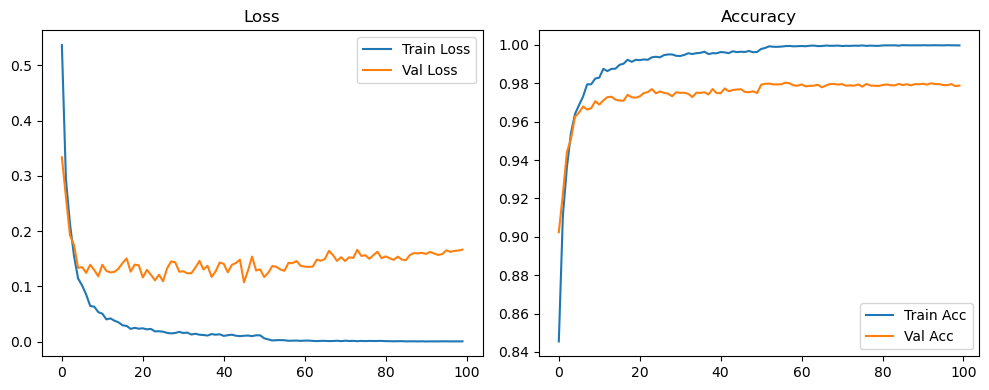

🚀 Running: batch256_lr0.01_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.01000 | Train Loss: 0.6491, Acc: 0.8108 | Val Loss: 0.3424, Acc: 0.9017


Epoch 2/100 - LR: 0.01000 | Train Loss: 0.3788, Acc: 0.8870 | Val Loss: 0.2774, Acc: 0.9183


Epoch 3/100 - LR: 0.01000 | Train Loss: 0.3074, Acc: 0.9101 | Val Loss: 0.2238, Acc: 0.9373


Epoch 4/100 - LR: 0.01000 | Train Loss: 0.2481, Acc: 0.9267 | Val Loss: 0.1875, Acc: 0.9467


Epoch 5/100 - LR: 0.01000 | Train Loss: 0.2012, Acc: 0.9395 | Val Loss: 0.1573, Acc: 0.9573


Epoch 6/100 - LR: 0.01000 | Train Loss: 0.1840, Acc: 0.9450 | Val Loss: 0.1664, Acc: 0.9554


Epoch 7/100 - LR: 0.01000 | Train Loss: 0.1577, Acc: 0.9521 | Val Loss: 0.1398, Acc: 0.9624


Epoch 8/100 - LR: 0.01000 | Train Loss: 0.1370, Acc: 0.9599 | Val Loss: 0.1436, Acc: 0.9615


Epoch 9/100 - LR: 0.01000 | Train Loss: 0.1200, Acc: 0.9631 | Val Loss: 0.1174, Acc: 0.9663


Epoch 10/100 - LR: 0.01000 | Train Loss: 0.1144, Acc: 0.9645 | Val Loss: 0.1172, Acc: 0.9671


Epoch 11/100 - LR: 0.01000 | Train Loss: 0.0962, Acc: 0.9690 | Val Loss: 0.1122, Acc: 0.9681


Epoch 12/100 - LR: 0.01000 | Train Loss: 0.0857, Acc: 0.9724 | Val Loss: 0.1077, Acc: 0.9709


Epoch 13/100 - LR: 0.01000 | Train Loss: 0.0793, Acc: 0.9744 | Val Loss: 0.1129, Acc: 0.9728


Epoch 14/100 - LR: 0.01000 | Train Loss: 0.0738, Acc: 0.9767 | Val Loss: 0.0999, Acc: 0.9726


Epoch 15/100 - LR: 0.01000 | Train Loss: 0.0666, Acc: 0.9784 | Val Loss: 0.1150, Acc: 0.9703


Epoch 16/100 - LR: 0.01000 | Train Loss: 0.0663, Acc: 0.9779 | Val Loss: 0.1000, Acc: 0.9722


Epoch 17/100 - LR: 0.01000 | Train Loss: 0.0621, Acc: 0.9790 | Val Loss: 0.1004, Acc: 0.9729


Epoch 18/100 - LR: 0.01000 | Train Loss: 0.0556, Acc: 0.9818 | Val Loss: 0.1033, Acc: 0.9735


Epoch 19/100 - LR: 0.01000 | Train Loss: 0.0519, Acc: 0.9828 | Val Loss: 0.1035, Acc: 0.9740


Epoch 20/100 - LR: 0.01000 | Train Loss: 0.0512, Acc: 0.9830 | Val Loss: 0.1000, Acc: 0.9751


Epoch 21/100 - LR: 0.01000 | Train Loss: 0.0527, Acc: 0.9828 | Val Loss: 0.0934, Acc: 0.9748


Epoch 22/100 - LR: 0.01000 | Train Loss: 0.0432, Acc: 0.9853 | Val Loss: 0.0991, Acc: 0.9748


Epoch 23/100 - LR: 0.01000 | Train Loss: 0.0428, Acc: 0.9850 | Val Loss: 0.0956, Acc: 0.9749


Epoch 24/100 - LR: 0.01000 | Train Loss: 0.0446, Acc: 0.9851 | Val Loss: 0.0975, Acc: 0.9749


Epoch 25/100 - LR: 0.01000 | Train Loss: 0.0419, Acc: 0.9861 | Val Loss: 0.1069, Acc: 0.9747


Epoch 26/100 - LR: 0.01000 | Train Loss: 0.0405, Acc: 0.9864 | Val Loss: 0.1071, Acc: 0.9760


Epoch 27/100 - LR: 0.01000 | Train Loss: 0.0362, Acc: 0.9879 | Val Loss: 0.1002, Acc: 0.9751


Epoch 28/100 - LR: 0.01000 | Train Loss: 0.0357, Acc: 0.9875 | Val Loss: 0.1187, Acc: 0.9748


Epoch 29/100 - LR: 0.01000 | Train Loss: 0.0346, Acc: 0.9879 | Val Loss: 0.1115, Acc: 0.9760


Epoch 30/100 - LR: 0.01000 | Train Loss: 0.0332, Acc: 0.9886 | Val Loss: 0.0964, Acc: 0.9762


Epoch 31/100 - LR: 0.01000 | Train Loss: 0.0347, Acc: 0.9885 | Val Loss: 0.1100, Acc: 0.9761


Epoch 32/100 - LR: 0.01000 | Train Loss: 0.0319, Acc: 0.9890 | Val Loss: 0.0925, Acc: 0.9775


Epoch 33/100 - LR: 0.01000 | Train Loss: 0.0307, Acc: 0.9895 | Val Loss: 0.0936, Acc: 0.9757


Epoch 34/100 - LR: 0.01000 | Train Loss: 0.0285, Acc: 0.9901 | Val Loss: 0.1083, Acc: 0.9755


Epoch 35/100 - LR: 0.01000 | Train Loss: 0.0288, Acc: 0.9903 | Val Loss: 0.1016, Acc: 0.9772


Epoch 36/100 - LR: 0.01000 | Train Loss: 0.0301, Acc: 0.9899 | Val Loss: 0.0965, Acc: 0.9782


Epoch 37/100 - LR: 0.01000 | Train Loss: 0.0260, Acc: 0.9911 | Val Loss: 0.1093, Acc: 0.9749


Epoch 38/100 - LR: 0.01000 | Train Loss: 0.0249, Acc: 0.9914 | Val Loss: 0.1051, Acc: 0.9775


Epoch 39/100 - LR: 0.01000 | Train Loss: 0.0270, Acc: 0.9910 | Val Loss: 0.1067, Acc: 0.9776


Epoch 40/100 - LR: 0.01000 | Train Loss: 0.0264, Acc: 0.9910 | Val Loss: 0.0962, Acc: 0.9768


Epoch 41/100 - LR: 0.01000 | Train Loss: 0.0248, Acc: 0.9921 | Val Loss: 0.0900, Acc: 0.9771


Epoch 42/100 - LR: 0.01000 | Train Loss: 0.0261, Acc: 0.9915 | Val Loss: 0.1081, Acc: 0.9763


Epoch 43/100 - LR: 0.01000 | Train Loss: 0.0218, Acc: 0.9927 | Val Loss: 0.1068, Acc: 0.9768


Epoch 44/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.1232, Acc: 0.9765


Epoch 45/100 - LR: 0.01000 | Train Loss: 0.0246, Acc: 0.9926 | Val Loss: 0.1034, Acc: 0.9773


Epoch 46/100 - LR: 0.01000 | Train Loss: 0.0216, Acc: 0.9927 | Val Loss: 0.1137, Acc: 0.9770


Epoch 47/100 - LR: 0.01000 | Train Loss: 0.0225, Acc: 0.9924 | Val Loss: 0.0886, Acc: 0.9778


Epoch 48/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9931 | Val Loss: 0.1105, Acc: 0.9765


Epoch 49/100 - LR: 0.01000 | Train Loss: 0.0201, Acc: 0.9933 | Val Loss: 0.1003, Acc: 0.9773


Epoch 50/100 - LR: 0.01000 | Train Loss: 0.0227, Acc: 0.9929 | Val Loss: 0.1038, Acc: 0.9778


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0156, Acc: 0.9948 | Val Loss: 0.0929, Acc: 0.9787


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9959 | Val Loss: 0.1038, Acc: 0.9793


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9962 | Val Loss: 0.1006, Acc: 0.9795


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0107, Acc: 0.9964 | Val Loss: 0.1051, Acc: 0.9790


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9965 | Val Loss: 0.1042, Acc: 0.9792


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9966 | Val Loss: 0.1044, Acc: 0.9802


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9968 | Val Loss: 0.1018, Acc: 0.9806


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1095, Acc: 0.9809


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0081, Acc: 0.9973 | Val Loss: 0.1026, Acc: 0.9808


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9973 | Val Loss: 0.1111, Acc: 0.9794


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1023, Acc: 0.9801


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1058, Acc: 0.9804


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1066, Acc: 0.9796


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1082, Acc: 0.9803


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0067, Acc: 0.9978 | Val Loss: 0.1143, Acc: 0.9798


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9979 | Val Loss: 0.1149, Acc: 0.9795


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9980 | Val Loss: 0.1067, Acc: 0.9804


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1096, Acc: 0.9799


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9980 | Val Loss: 0.1145, Acc: 0.9802


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1128, Acc: 0.9800


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1190, Acc: 0.9805


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1119, Acc: 0.9798


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1158, Acc: 0.9803


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9979 | Val Loss: 0.1109, Acc: 0.9802


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1147, Acc: 0.9798


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0047, Acc: 0.9984 | Val Loss: 0.1139, Acc: 0.9801


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9980 | Val Loss: 0.1138, Acc: 0.9799


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9980 | Val Loss: 0.1101, Acc: 0.9799


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9984 | Val Loss: 0.1156, Acc: 0.9802


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0058, Acc: 0.9982 | Val Loss: 0.1047, Acc: 0.9804


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9983 | Val Loss: 0.1072, Acc: 0.9802


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9985 | Val Loss: 0.1136, Acc: 0.9805


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1130, Acc: 0.9806


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0038, Acc: 0.9987 | Val Loss: 0.1155, Acc: 0.9802


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9987 | Val Loss: 0.1224, Acc: 0.9809


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0041, Acc: 0.9986 | Val Loss: 0.1123, Acc: 0.9810


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1153, Acc: 0.9801


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1151, Acc: 0.9810


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9989 | Val Loss: 0.1164, Acc: 0.9808


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1180, Acc: 0.9806


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0042, Acc: 0.9986 | Val Loss: 0.1193, Acc: 0.9805


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1198, Acc: 0.9805


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1190, Acc: 0.9810


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0037, Acc: 0.9988 | Val Loss: 0.1163, Acc: 0.9804


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1203, Acc: 0.9812


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1233, Acc: 0.9812


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1179, Acc: 0.9812


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0029, Acc: 0.9989 | Val Loss: 0.1217, Acc: 0.9809


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9988 | Val Loss: 0.1171, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1219, Acc: 0.9805


Final Test Loss: 0.1089 Accuracy: 0.9815


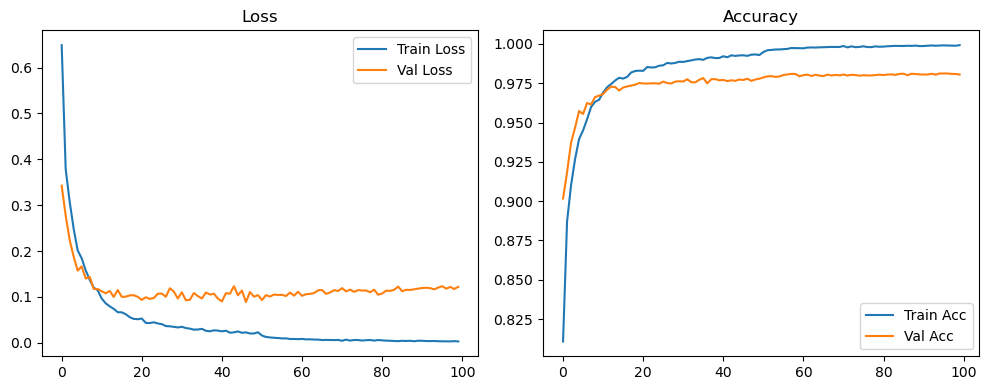

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4112, Acc: 0.8756 | Val Loss: 0.3235, Acc: 0.9066


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2406, Acc: 0.9276 | Val Loss: 0.2463, Acc: 0.9258


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1349, Acc: 0.9594 | Val Loss: 0.1585, Acc: 0.9544


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9749 | Val Loss: 0.1264, Acc: 0.9626


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9847 | Val Loss: 0.1247, Acc: 0.9644


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9871 | Val Loss: 0.1503, Acc: 0.9607


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9893 | Val Loss: 0.1448, Acc: 0.9633


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9915 | Val Loss: 0.1596, Acc: 0.9640


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.1197, Acc: 0.9726


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.1424, Acc: 0.9688


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1506, Acc: 0.9688


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9949 | Val Loss: 0.1319, Acc: 0.9712


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1544, Acc: 0.9703


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1831, Acc: 0.9626


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9946 | Val Loss: 0.1530, Acc: 0.9700


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1973, Acc: 0.9622


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.1479, Acc: 0.9725


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1687, Acc: 0.9683


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1402, Acc: 0.9722


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1797, Acc: 0.9668


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1512, Acc: 0.9689


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1748, Acc: 0.9687


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.2466, Acc: 0.9579


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1713, Acc: 0.9697


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1425, Acc: 0.9729


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1495, Acc: 0.9739


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1586, Acc: 0.9742


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1439, Acc: 0.9752


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1738, Acc: 0.9702


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1738, Acc: 0.9721


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1634, Acc: 0.9747


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1794, Acc: 0.9740


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1991, Acc: 0.9691


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1395, Acc: 0.9733


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1475, Acc: 0.9729


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1386, Acc: 0.9736


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1292, Acc: 0.9756


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1363, Acc: 0.9707


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1295, Acc: 0.9741


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1686, Acc: 0.9673


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1779, Acc: 0.9722


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1611, Acc: 0.9759


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1441, Acc: 0.9763


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1280, Acc: 0.9756


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1483, Acc: 0.9758


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1449, Acc: 0.9729


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1422, Acc: 0.9758


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1590, Acc: 0.9673


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1335, Acc: 0.9758


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1403, Acc: 0.9747


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1549, Acc: 0.9758


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9988 | Val Loss: 0.1427, Acc: 0.9760


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1134, Acc: 0.9732


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1613, Acc: 0.9737


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.1498, Acc: 0.9753


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9993 | Val Loss: 0.1465, Acc: 0.9788


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1798, Acc: 0.9712


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.2101, Acc: 0.9679


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1437, Acc: 0.9742


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9989 | Val Loss: 0.1449, Acc: 0.9720


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0042, Acc: 0.9987 | Val Loss: 0.1326, Acc: 0.9773


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0038, Acc: 0.9991 | Val Loss: 0.1427, Acc: 0.9768


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9989 | Val Loss: 0.1418, Acc: 0.9789


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1162, Acc: 0.9763


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9990 | Val Loss: 0.1409, Acc: 0.9767


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.1202, Acc: 0.9789


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1375, Acc: 0.9759


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1745, Acc: 0.9686


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9990 | Val Loss: 0.1490, Acc: 0.9755


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1449, Acc: 0.9752


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9984 | Val Loss: 0.1550, Acc: 0.9767


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1322, Acc: 0.9766


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1271, Acc: 0.9780


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1225, Acc: 0.9779


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1327, Acc: 0.9782


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1810, Acc: 0.9702


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0034, Acc: 0.9990 | Val Loss: 0.0910, Acc: 0.9779


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9995 | Val Loss: 0.1364, Acc: 0.9791


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9990 | Val Loss: 0.2296, Acc: 0.9595


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.2161, Acc: 0.9702


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1376, Acc: 0.9768


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1619, Acc: 0.9748


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1393, Acc: 0.9726


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1405, Acc: 0.9733


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1441, Acc: 0.9741


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.2117, Acc: 0.9677


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0027, Acc: 0.9994 | Val Loss: 0.0931, Acc: 0.9772


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1757, Acc: 0.9762


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0030, Acc: 0.9992 | Val Loss: 0.1545, Acc: 0.9758


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1388, Acc: 0.9768


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1562, Acc: 0.9786


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0018, Acc: 0.9995 | Val Loss: 0.1411, Acc: 0.9772


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1392, Acc: 0.9756


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1382, Acc: 0.9744


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1470, Acc: 0.9765


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0029, Acc: 0.9991 | Val Loss: 0.1315, Acc: 0.9708


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9994 | Val Loss: 0.1482, Acc: 0.9772


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0020, Acc: 0.9994 | Val Loss: 0.1461, Acc: 0.9751


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1343, Acc: 0.9758


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.3556, Acc: 0.9291


Final Test Loss: 0.3555 Accuracy: 0.9269


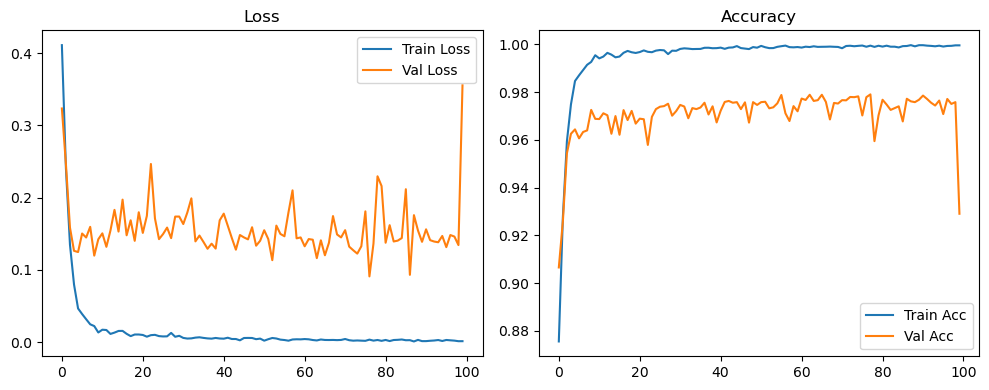

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4462, Acc: 0.8644 | Val Loss: 0.3350, Acc: 0.9031


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2997, Acc: 0.9099 | Val Loss: 0.2409, Acc: 0.9287


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2109, Acc: 0.9373 | Val Loss: 0.1790, Acc: 0.9484


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1483, Acc: 0.9550 | Val Loss: 0.1544, Acc: 0.9536


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1161, Acc: 0.9635 | Val Loss: 0.1281, Acc: 0.9613


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0987, Acc: 0.9691 | Val Loss: 0.1186, Acc: 0.9649


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0817, Acc: 0.9740 | Val Loss: 0.1245, Acc: 0.9658


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0686, Acc: 0.9783 | Val Loss: 0.1277, Acc: 0.9652


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0600, Acc: 0.9807 | Val Loss: 0.1138, Acc: 0.9688


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9824 | Val Loss: 0.1114, Acc: 0.9703


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9827 | Val Loss: 0.1091, Acc: 0.9704


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9860 | Val Loss: 0.1100, Acc: 0.9695


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.1196, Acc: 0.9695


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9868 | Val Loss: 0.1132, Acc: 0.9714


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9879 | Val Loss: 0.1107, Acc: 0.9724


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.1256, Acc: 0.9695


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9895 | Val Loss: 0.1340, Acc: 0.9700


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9909 | Val Loss: 0.1235, Acc: 0.9728


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.1120, Acc: 0.9745


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9899 | Val Loss: 0.1183, Acc: 0.9713


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.1134, Acc: 0.9743


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.1246, Acc: 0.9742


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9927 | Val Loss: 0.1409, Acc: 0.9704


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9917 | Val Loss: 0.1170, Acc: 0.9754


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9930 | Val Loss: 0.1275, Acc: 0.9712


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9933 | Val Loss: 0.1146, Acc: 0.9753


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9937 | Val Loss: 0.1144, Acc: 0.9747


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.1165, Acc: 0.9758


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.1249, Acc: 0.9736


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9940 | Val Loss: 0.1219, Acc: 0.9749


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.1232, Acc: 0.9739


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.1235, Acc: 0.9753


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1300, Acc: 0.9746


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1332, Acc: 0.9753


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1495, Acc: 0.9729


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.1232, Acc: 0.9751


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1088, Acc: 0.9752


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1179, Acc: 0.9760


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1247, Acc: 0.9756


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1138, Acc: 0.9751


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1294, Acc: 0.9759


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1376, Acc: 0.9746


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1304, Acc: 0.9758


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.1203, Acc: 0.9754


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.1245, Acc: 0.9760


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.1124, Acc: 0.9763


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.1545, Acc: 0.9745


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1146, Acc: 0.9766


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9960 | Val Loss: 0.1226, Acc: 0.9762


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1087, Acc: 0.9762


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9968 | Val Loss: 0.1232, Acc: 0.9756


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9965 | Val Loss: 0.1235, Acc: 0.9757


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1127, Acc: 0.9769


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9965 | Val Loss: 0.1076, Acc: 0.9766


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0110, Acc: 0.9965 | Val Loss: 0.1078, Acc: 0.9760


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1225, Acc: 0.9774


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9976 | Val Loss: 0.1289, Acc: 0.9749


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0097, Acc: 0.9964 | Val Loss: 0.1255, Acc: 0.9755


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9967 | Val Loss: 0.1354, Acc: 0.9753


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0081, Acc: 0.9975 | Val Loss: 0.1197, Acc: 0.9775


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.1142, Acc: 0.9762


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0089, Acc: 0.9970 | Val Loss: 0.1212, Acc: 0.9763


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1106, Acc: 0.9758


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1259, Acc: 0.9767


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9971 | Val Loss: 0.1334, Acc: 0.9752


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9971 | Val Loss: 0.1169, Acc: 0.9782


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1192, Acc: 0.9771


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1126, Acc: 0.9767


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1256, Acc: 0.9766


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1264, Acc: 0.9766


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9978 | Val Loss: 0.1347, Acc: 0.9767


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1296, Acc: 0.9767


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1242, Acc: 0.9782


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9977 | Val Loss: 0.1422, Acc: 0.9771


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9971 | Val Loss: 0.1237, Acc: 0.9767


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0080, Acc: 0.9977 | Val Loss: 0.1346, Acc: 0.9761


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9973 | Val Loss: 0.1028, Acc: 0.9774


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1284, Acc: 0.9769


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9973 | Val Loss: 0.1368, Acc: 0.9780


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1017, Acc: 0.9776


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1345, Acc: 0.9769


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0076, Acc: 0.9975 | Val Loss: 0.1186, Acc: 0.9774


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9981 | Val Loss: 0.1312, Acc: 0.9772


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9983 | Val Loss: 0.1585, Acc: 0.9777


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1369, Acc: 0.9762


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0072, Acc: 0.9978 | Val Loss: 0.1429, Acc: 0.9758


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0067, Acc: 0.9979 | Val Loss: 0.1262, Acc: 0.9751


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9980 | Val Loss: 0.1405, Acc: 0.9759


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1296, Acc: 0.9769


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0059, Acc: 0.9978 | Val Loss: 0.1578, Acc: 0.9763


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9976 | Val Loss: 0.1150, Acc: 0.9768


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1415, Acc: 0.9772


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0061, Acc: 0.9978 | Val Loss: 0.1334, Acc: 0.9768


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1203, Acc: 0.9769


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1276, Acc: 0.9778


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1311, Acc: 0.9779


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9983 | Val Loss: 0.1555, Acc: 0.9769


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0053, Acc: 0.9983 | Val Loss: 0.1474, Acc: 0.9762


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0070, Acc: 0.9979 | Val Loss: 0.1549, Acc: 0.9772


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1376, Acc: 0.9762


Final Test Loss: 0.1364 Accuracy: 0.9771


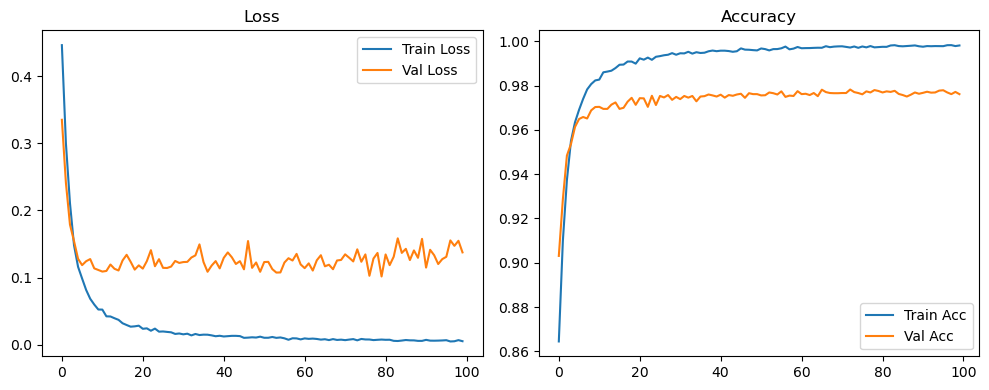

🚀 Running: batch256_lr0.005_0.005_0.005_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5680, Acc: 0.8248 | Val Loss: 0.3434, Acc: 0.8982


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3892, Acc: 0.8824 | Val Loss: 0.2725, Acc: 0.9197


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3147, Acc: 0.9045 | Val Loss: 0.2215, Acc: 0.9361


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2646, Acc: 0.9209 | Val Loss: 0.1985, Acc: 0.9399


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2229, Acc: 0.9330 | Val Loss: 0.1721, Acc: 0.9497


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2000, Acc: 0.9385 | Val Loss: 0.1628, Acc: 0.9521


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1786, Acc: 0.9455 | Val Loss: 0.1557, Acc: 0.9533


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1595, Acc: 0.9521 | Val Loss: 0.1483, Acc: 0.9571


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1478, Acc: 0.9544 | Val Loss: 0.1444, Acc: 0.9574


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1364, Acc: 0.9581 | Val Loss: 0.1279, Acc: 0.9621


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1248, Acc: 0.9616 | Val Loss: 0.1351, Acc: 0.9613


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1144, Acc: 0.9640 | Val Loss: 0.1214, Acc: 0.9648


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1068, Acc: 0.9661 | Val Loss: 0.1287, Acc: 0.9637


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1013, Acc: 0.9684 | Val Loss: 0.1149, Acc: 0.9683


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0942, Acc: 0.9706 | Val Loss: 0.1184, Acc: 0.9668


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0920, Acc: 0.9709 | Val Loss: 0.1145, Acc: 0.9692


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0814, Acc: 0.9741 | Val Loss: 0.1133, Acc: 0.9677


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0772, Acc: 0.9755 | Val Loss: 0.1219, Acc: 0.9672


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0732, Acc: 0.9759 | Val Loss: 0.1086, Acc: 0.9705


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0715, Acc: 0.9771 | Val Loss: 0.1119, Acc: 0.9705


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0694, Acc: 0.9780 | Val Loss: 0.1105, Acc: 0.9692


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9799 | Val Loss: 0.1070, Acc: 0.9727


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0579, Acc: 0.9813 | Val Loss: 0.1103, Acc: 0.9724


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9809 | Val Loss: 0.1095, Acc: 0.9725


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9818 | Val Loss: 0.1131, Acc: 0.9727


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9825 | Val Loss: 0.1093, Acc: 0.9714


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9819 | Val Loss: 0.1104, Acc: 0.9728


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9844 | Val Loss: 0.1174, Acc: 0.9719


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9835 | Val Loss: 0.1046, Acc: 0.9738


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9841 | Val Loss: 0.1146, Acc: 0.9718


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9851 | Val Loss: 0.1043, Acc: 0.9740


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9867 | Val Loss: 0.1120, Acc: 0.9741


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9862 | Val Loss: 0.1098, Acc: 0.9744


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9872 | Val Loss: 0.1079, Acc: 0.9749


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9869 | Val Loss: 0.1006, Acc: 0.9745


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9875 | Val Loss: 0.0987, Acc: 0.9755


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9880 | Val Loss: 0.1116, Acc: 0.9752


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9878 | Val Loss: 0.1031, Acc: 0.9742


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9886 | Val Loss: 0.1015, Acc: 0.9753


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9886 | Val Loss: 0.1079, Acc: 0.9749


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9879 | Val Loss: 0.1110, Acc: 0.9738


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9892 | Val Loss: 0.1163, Acc: 0.9745


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9898 | Val Loss: 0.1156, Acc: 0.9752


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9897 | Val Loss: 0.1093, Acc: 0.9750


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9899 | Val Loss: 0.1082, Acc: 0.9751


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9906 | Val Loss: 0.1155, Acc: 0.9738


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.1085, Acc: 0.9748


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.1171, Acc: 0.9743


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 0.1034, Acc: 0.9758


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.1094, Acc: 0.9754


Epoch 51/100 - LR: 0.00500 | Train Loss: 0.0266, Acc: 0.9906 | Val Loss: 0.1085, Acc: 0.9758


Epoch 52/100 - LR: 0.00500 | Train Loss: 0.0274, Acc: 0.9910 | Val Loss: 0.1174, Acc: 0.9745


Epoch 53/100 - LR: 0.00500 | Train Loss: 0.0265, Acc: 0.9906 | Val Loss: 0.1118, Acc: 0.9751


Epoch 54/100 - LR: 0.00500 | Train Loss: 0.0259, Acc: 0.9913 | Val Loss: 0.1101, Acc: 0.9752


Epoch 55/100 - LR: 0.00500 | Train Loss: 0.0249, Acc: 0.9915 | Val Loss: 0.1113, Acc: 0.9748


Epoch 56/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9918 | Val Loss: 0.1227, Acc: 0.9761


Epoch 57/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9918 | Val Loss: 0.1141, Acc: 0.9765


Epoch 58/100 - LR: 0.00500 | Train Loss: 0.0224, Acc: 0.9926 | Val Loss: 0.1080, Acc: 0.9758


Epoch 59/100 - LR: 0.00500 | Train Loss: 0.0236, Acc: 0.9918 | Val Loss: 0.1128, Acc: 0.9773


Epoch 60/100 - LR: 0.00500 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.1226, Acc: 0.9763


Epoch 61/100 - LR: 0.00500 | Train Loss: 0.0223, Acc: 0.9922 | Val Loss: 0.1135, Acc: 0.9758


Epoch 62/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9927 | Val Loss: 0.1106, Acc: 0.9761


Epoch 63/100 - LR: 0.00500 | Train Loss: 0.0216, Acc: 0.9925 | Val Loss: 0.1035, Acc: 0.9766


Epoch 64/100 - LR: 0.00500 | Train Loss: 0.0211, Acc: 0.9930 | Val Loss: 0.1066, Acc: 0.9758


Epoch 65/100 - LR: 0.00500 | Train Loss: 0.0218, Acc: 0.9929 | Val Loss: 0.1047, Acc: 0.9760


Epoch 66/100 - LR: 0.00500 | Train Loss: 0.0213, Acc: 0.9929 | Val Loss: 0.1049, Acc: 0.9759


Epoch 67/100 - LR: 0.00500 | Train Loss: 0.0208, Acc: 0.9935 | Val Loss: 0.1129, Acc: 0.9765


Epoch 68/100 - LR: 0.00500 | Train Loss: 0.0200, Acc: 0.9935 | Val Loss: 0.1053, Acc: 0.9765


Epoch 69/100 - LR: 0.00500 | Train Loss: 0.0201, Acc: 0.9934 | Val Loss: 0.1083, Acc: 0.9767


Epoch 70/100 - LR: 0.00500 | Train Loss: 0.0189, Acc: 0.9934 | Val Loss: 0.1102, Acc: 0.9770


Epoch 71/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9939 | Val Loss: 0.1099, Acc: 0.9774


Epoch 72/100 - LR: 0.00500 | Train Loss: 0.0202, Acc: 0.9932 | Val Loss: 0.1223, Acc: 0.9762


Epoch 73/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9942 | Val Loss: 0.1155, Acc: 0.9763


Epoch 74/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9946 | Val Loss: 0.1202, Acc: 0.9776


Epoch 75/100 - LR: 0.00500 | Train Loss: 0.0203, Acc: 0.9931 | Val Loss: 0.1105, Acc: 0.9762


Epoch 76/100 - LR: 0.00500 | Train Loss: 0.0174, Acc: 0.9943 | Val Loss: 0.1189, Acc: 0.9770


Epoch 77/100 - LR: 0.00500 | Train Loss: 0.0184, Acc: 0.9937 | Val Loss: 0.1012, Acc: 0.9777


Epoch 78/100 - LR: 0.00500 | Train Loss: 0.0198, Acc: 0.9935 | Val Loss: 0.0987, Acc: 0.9768


Epoch 79/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1258, Acc: 0.9767


Epoch 80/100 - LR: 0.00500 | Train Loss: 0.0194, Acc: 0.9938 | Val Loss: 0.1107, Acc: 0.9781


Epoch 81/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9938 | Val Loss: 0.1034, Acc: 0.9772


Epoch 82/100 - LR: 0.00500 | Train Loss: 0.0182, Acc: 0.9938 | Val Loss: 0.0919, Acc: 0.9787


Epoch 83/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9941 | Val Loss: 0.0982, Acc: 0.9775


Epoch 84/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9943 | Val Loss: 0.0994, Acc: 0.9777


Epoch 85/100 - LR: 0.00500 | Train Loss: 0.0164, Acc: 0.9944 | Val Loss: 0.1166, Acc: 0.9777


Epoch 86/100 - LR: 0.00500 | Train Loss: 0.0172, Acc: 0.9940 | Val Loss: 0.1177, Acc: 0.9774


Epoch 87/100 - LR: 0.00500 | Train Loss: 0.0159, Acc: 0.9943 | Val Loss: 0.1058, Acc: 0.9778


Epoch 88/100 - LR: 0.00500 | Train Loss: 0.0157, Acc: 0.9948 | Val Loss: 0.1081, Acc: 0.9772


Epoch 89/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.1096, Acc: 0.9773


Epoch 90/100 - LR: 0.00500 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1391, Acc: 0.9770


Epoch 91/100 - LR: 0.00500 | Train Loss: 0.0152, Acc: 0.9945 | Val Loss: 0.1037, Acc: 0.9776


Epoch 92/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9951 | Val Loss: 0.1044, Acc: 0.9773


Epoch 93/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1236, Acc: 0.9780


Epoch 94/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9948 | Val Loss: 0.1365, Acc: 0.9774


Epoch 95/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9939 | Val Loss: 0.1080, Acc: 0.9762


Epoch 96/100 - LR: 0.00500 | Train Loss: 0.0142, Acc: 0.9951 | Val Loss: 0.1313, Acc: 0.9784


Epoch 97/100 - LR: 0.00500 | Train Loss: 0.0143, Acc: 0.9950 | Val Loss: 0.1093, Acc: 0.9768


Epoch 98/100 - LR: 0.00500 | Train Loss: 0.0145, Acc: 0.9953 | Val Loss: 0.1194, Acc: 0.9777


Epoch 99/100 - LR: 0.00500 | Train Loss: 0.0136, Acc: 0.9950 | Val Loss: 0.1209, Acc: 0.9779


Epoch 100/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9956 | Val Loss: 0.1176, Acc: 0.9769


Final Test Loss: 0.1014 Accuracy: 0.9801


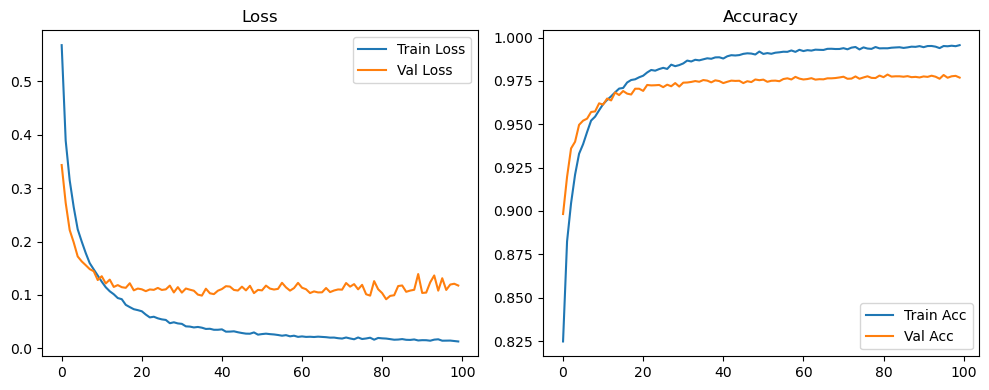

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.0


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4112, Acc: 0.8756 | Val Loss: 0.3235, Acc: 0.9066


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2406, Acc: 0.9276 | Val Loss: 0.2463, Acc: 0.9258


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.1349, Acc: 0.9594 | Val Loss: 0.1585, Acc: 0.9544


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.0798, Acc: 0.9749 | Val Loss: 0.1264, Acc: 0.9626


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.0465, Acc: 0.9847 | Val Loss: 0.1247, Acc: 0.9644


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0388, Acc: 0.9871 | Val Loss: 0.1503, Acc: 0.9607


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0316, Acc: 0.9893 | Val Loss: 0.1448, Acc: 0.9633


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0246, Acc: 0.9915 | Val Loss: 0.1596, Acc: 0.9640


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0222, Acc: 0.9927 | Val Loss: 0.1197, Acc: 0.9726


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0133, Acc: 0.9955 | Val Loss: 0.1424, Acc: 0.9688


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0171, Acc: 0.9942 | Val Loss: 0.1506, Acc: 0.9688


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0167, Acc: 0.9949 | Val Loss: 0.1319, Acc: 0.9712


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0113, Acc: 0.9965 | Val Loss: 0.1544, Acc: 0.9703


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0131, Acc: 0.9957 | Val Loss: 0.1831, Acc: 0.9626


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0154, Acc: 0.9946 | Val Loss: 0.1530, Acc: 0.9700


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1973, Acc: 0.9622


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0114, Acc: 0.9965 | Val Loss: 0.1479, Acc: 0.9725


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0082, Acc: 0.9973 | Val Loss: 0.1687, Acc: 0.9683


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9967 | Val Loss: 0.1402, Acc: 0.9722


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0105, Acc: 0.9964 | Val Loss: 0.1797, Acc: 0.9668


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1512, Acc: 0.9689


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0075, Acc: 0.9975 | Val Loss: 0.1748, Acc: 0.9687


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0096, Acc: 0.9969 | Val Loss: 0.2466, Acc: 0.9579


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0100, Acc: 0.9968 | Val Loss: 0.1713, Acc: 0.9697


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0083, Acc: 0.9974 | Val Loss: 0.1425, Acc: 0.9729


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0078, Acc: 0.9977 | Val Loss: 0.1495, Acc: 0.9739


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0079, Acc: 0.9975 | Val Loss: 0.1586, Acc: 0.9742


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0127, Acc: 0.9960 | Val Loss: 0.1439, Acc: 0.9752


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0074, Acc: 0.9974 | Val Loss: 0.1738, Acc: 0.9702


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1738, Acc: 0.9721


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1634, Acc: 0.9747


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1794, Acc: 0.9740


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1991, Acc: 0.9691


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0062, Acc: 0.9981 | Val Loss: 0.1395, Acc: 0.9733


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1475, Acc: 0.9729


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1386, Acc: 0.9736


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0051, Acc: 0.9986 | Val Loss: 0.1292, Acc: 0.9756


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1363, Acc: 0.9707


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1295, Acc: 0.9741


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0050, Acc: 0.9985 | Val Loss: 0.1686, Acc: 0.9673


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0047, Acc: 0.9987 | Val Loss: 0.1779, Acc: 0.9722


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0060, Acc: 0.9982 | Val Loss: 0.1611, Acc: 0.9759


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9987 | Val Loss: 0.1441, Acc: 0.9763


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0043, Acc: 0.9988 | Val Loss: 0.1280, Acc: 0.9756


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1483, Acc: 0.9758


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1449, Acc: 0.9729


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0058, Acc: 0.9983 | Val Loss: 0.1422, Acc: 0.9758


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1590, Acc: 0.9673


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1335, Acc: 0.9758


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0048, Acc: 0.9986 | Val Loss: 0.1403, Acc: 0.9747


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1247, Acc: 0.9806


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1250, Acc: 0.9801


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1265, Acc: 0.9809


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 1.0000 | Val Loss: 0.1266, Acc: 0.9805


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1313, Acc: 0.9802


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1323, Acc: 0.9811


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1391, Acc: 0.9798


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1427, Acc: 0.9798


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1287, Acc: 0.9805


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 0.9999 | Val Loss: 0.1378, Acc: 0.9806


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1379, Acc: 0.9801


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0006, Acc: 0.9999 | Val Loss: 0.1406, Acc: 0.9802


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1179, Acc: 0.9808


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9998 | Val Loss: 0.1333, Acc: 0.9798


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1434, Acc: 0.9799


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1444, Acc: 0.9789


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1372, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1516, Acc: 0.9788


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1365, Acc: 0.9792


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1379, Acc: 0.9782


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1370, Acc: 0.9782


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0010, Acc: 0.9996 | Val Loss: 0.1689, Acc: 0.9774


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1498, Acc: 0.9790


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1671, Acc: 0.9764


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1492, Acc: 0.9804


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1514, Acc: 0.9806


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1510, Acc: 0.9802


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2684, Acc: 0.9636


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0021, Acc: 0.9996 | Val Loss: 0.1427, Acc: 0.9772


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1562, Acc: 0.9781


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0006, Acc: 0.9998 | Val Loss: 0.1373, Acc: 0.9809


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1405, Acc: 0.9798


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1411, Acc: 0.9804


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 0.9999 | Val Loss: 0.1415, Acc: 0.9805


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1389, Acc: 0.9799


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.1391, Acc: 0.9792


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1393, Acc: 0.9809


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1434, Acc: 0.9811


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1443, Acc: 0.9818


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1476, Acc: 0.9808


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1489, Acc: 0.9818


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.2166, Acc: 0.9733


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1636, Acc: 0.9802


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1754, Acc: 0.9788


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1668, Acc: 0.9801


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1687, Acc: 0.9801


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1802, Acc: 0.9792


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1723, Acc: 0.9810


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1694, Acc: 0.9808


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.2006, Acc: 0.9770


Final Test Loss: 0.1813 Accuracy: 0.9797


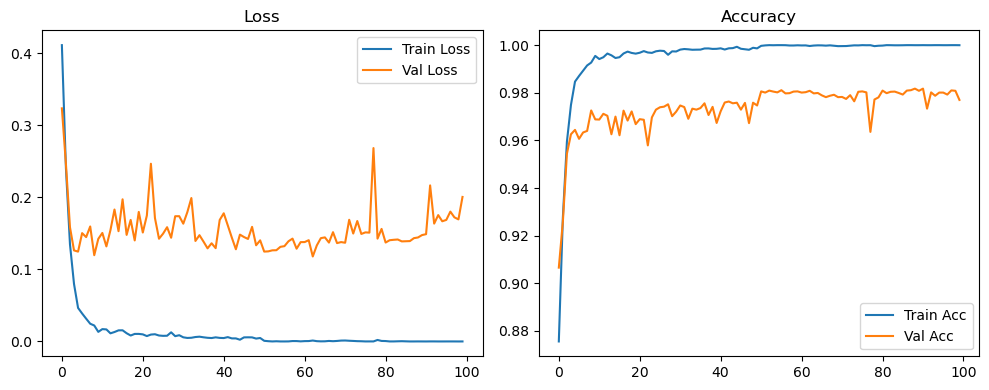

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.2


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.4462, Acc: 0.8644 | Val Loss: 0.3350, Acc: 0.9031


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.2997, Acc: 0.9099 | Val Loss: 0.2409, Acc: 0.9287


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.2109, Acc: 0.9373 | Val Loss: 0.1790, Acc: 0.9484


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.1483, Acc: 0.9550 | Val Loss: 0.1544, Acc: 0.9536


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.1161, Acc: 0.9635 | Val Loss: 0.1281, Acc: 0.9613


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.0987, Acc: 0.9691 | Val Loss: 0.1186, Acc: 0.9649


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.0817, Acc: 0.9740 | Val Loss: 0.1245, Acc: 0.9658


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.0686, Acc: 0.9783 | Val Loss: 0.1277, Acc: 0.9652


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.0600, Acc: 0.9807 | Val Loss: 0.1138, Acc: 0.9688


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.0526, Acc: 0.9824 | Val Loss: 0.1114, Acc: 0.9703


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.0524, Acc: 0.9827 | Val Loss: 0.1091, Acc: 0.9704


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.0424, Acc: 0.9860 | Val Loss: 0.1100, Acc: 0.9695


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.0422, Acc: 0.9864 | Val Loss: 0.1196, Acc: 0.9695


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.0396, Acc: 0.9868 | Val Loss: 0.1132, Acc: 0.9714


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0372, Acc: 0.9879 | Val Loss: 0.1107, Acc: 0.9724


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0321, Acc: 0.9894 | Val Loss: 0.1256, Acc: 0.9695


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0295, Acc: 0.9895 | Val Loss: 0.1340, Acc: 0.9700


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0270, Acc: 0.9909 | Val Loss: 0.1235, Acc: 0.9728


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.1120, Acc: 0.9745


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0285, Acc: 0.9899 | Val Loss: 0.1183, Acc: 0.9713


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0239, Acc: 0.9923 | Val Loss: 0.1134, Acc: 0.9743


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.1246, Acc: 0.9742


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0210, Acc: 0.9927 | Val Loss: 0.1409, Acc: 0.9704


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0241, Acc: 0.9917 | Val Loss: 0.1170, Acc: 0.9754


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0196, Acc: 0.9930 | Val Loss: 0.1275, Acc: 0.9712


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0199, Acc: 0.9933 | Val Loss: 0.1146, Acc: 0.9753


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0192, Acc: 0.9937 | Val Loss: 0.1144, Acc: 0.9747


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0186, Acc: 0.9940 | Val Loss: 0.1165, Acc: 0.9758


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0162, Acc: 0.9947 | Val Loss: 0.1249, Acc: 0.9736


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0169, Acc: 0.9940 | Val Loss: 0.1219, Acc: 0.9749


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0156, Acc: 0.9946 | Val Loss: 0.1232, Acc: 0.9739


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0166, Acc: 0.9946 | Val Loss: 0.1235, Acc: 0.9753


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0140, Acc: 0.9953 | Val Loss: 0.1300, Acc: 0.9746


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0161, Acc: 0.9945 | Val Loss: 0.1332, Acc: 0.9753


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0146, Acc: 0.9951 | Val Loss: 0.1495, Acc: 0.9729


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9948 | Val Loss: 0.1232, Acc: 0.9751


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0151, Acc: 0.9949 | Val Loss: 0.1088, Acc: 0.9752


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0141, Acc: 0.9955 | Val Loss: 0.1179, Acc: 0.9760


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0128, Acc: 0.9959 | Val Loss: 0.1247, Acc: 0.9756


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1138, Acc: 0.9751


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1294, Acc: 0.9759


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0129, Acc: 0.9958 | Val Loss: 0.1376, Acc: 0.9746


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9956 | Val Loss: 0.1304, Acc: 0.9758


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0134, Acc: 0.9953 | Val Loss: 0.1203, Acc: 0.9754


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0130, Acc: 0.9955 | Val Loss: 0.1245, Acc: 0.9760


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0104, Acc: 0.9968 | Val Loss: 0.1124, Acc: 0.9763


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0107, Acc: 0.9963 | Val Loss: 0.1545, Acc: 0.9745


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0112, Acc: 0.9962 | Val Loss: 0.1146, Acc: 0.9766


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0108, Acc: 0.9960 | Val Loss: 0.1226, Acc: 0.9762


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1087, Acc: 0.9762


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9977 | Val Loss: 0.1170, Acc: 0.9771


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0053, Acc: 0.9982 | Val Loss: 0.1298, Acc: 0.9772


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1298, Acc: 0.9778


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9988 | Val Loss: 0.1385, Acc: 0.9778


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9983 | Val Loss: 0.1341, Acc: 0.9786


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1356, Acc: 0.9783


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1450, Acc: 0.9772


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9987 | Val Loss: 0.1355, Acc: 0.9776


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9990 | Val Loss: 0.1402, Acc: 0.9778


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1453, Acc: 0.9768


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1397, Acc: 0.9785


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0038, Acc: 0.9988 | Val Loss: 0.1343, Acc: 0.9780


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9989 | Val Loss: 0.1419, Acc: 0.9784


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1569, Acc: 0.9778


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1340, Acc: 0.9789


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9990 | Val Loss: 0.1445, Acc: 0.9783


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1448, Acc: 0.9783


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9991 | Val Loss: 0.1523, Acc: 0.9779


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9993 | Val Loss: 0.1532, Acc: 0.9784


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1450, Acc: 0.9783


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1367, Acc: 0.9787


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.1397, Acc: 0.9780


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9988 | Val Loss: 0.1463, Acc: 0.9774


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1564, Acc: 0.9778


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1458, Acc: 0.9775


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1471, Acc: 0.9768


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9988 | Val Loss: 0.1424, Acc: 0.9772


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1587, Acc: 0.9783


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0033, Acc: 0.9990 | Val Loss: 0.1371, Acc: 0.9791


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1616, Acc: 0.9782


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0020, Acc: 0.9993 | Val Loss: 0.1553, Acc: 0.9792


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9991 | Val Loss: 0.1499, Acc: 0.9788


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1506, Acc: 0.9781


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1588, Acc: 0.9785


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1553, Acc: 0.9782


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.1490, Acc: 0.9783


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1497, Acc: 0.9790


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1579, Acc: 0.9786


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1546, Acc: 0.9788


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1540, Acc: 0.9791


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1603, Acc: 0.9792


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9997 | Val Loss: 0.1529, Acc: 0.9790


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1596, Acc: 0.9790


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1591, Acc: 0.9788


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9997 | Val Loss: 0.1715, Acc: 0.9791


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9995 | Val Loss: 0.1557, Acc: 0.9793


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9996 | Val Loss: 0.1586, Acc: 0.9793


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1592, Acc: 0.9782


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1629, Acc: 0.9786


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1496, Acc: 0.9783


Final Test Loss: 0.1284 Accuracy: 0.9821


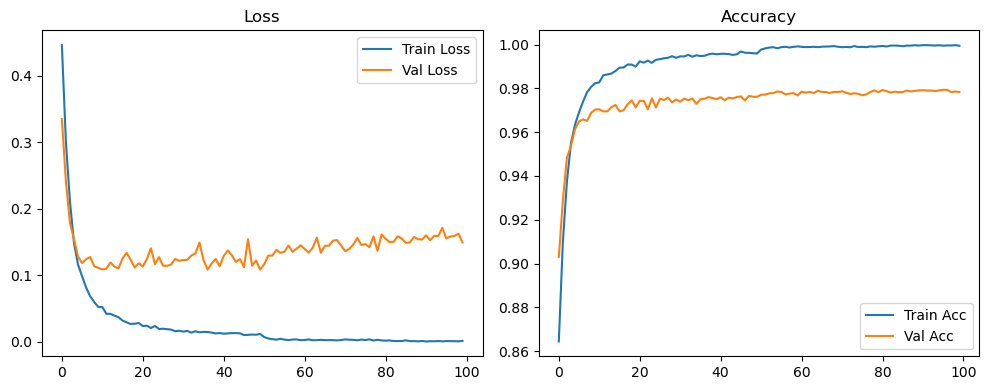

🚀 Running: batch256_lr0.005_0.002_0.001_dp0.5


Epoch 1/100 - LR: 0.00500 | Train Loss: 0.5680, Acc: 0.8248 | Val Loss: 0.3434, Acc: 0.8982


Epoch 2/100 - LR: 0.00500 | Train Loss: 0.3892, Acc: 0.8824 | Val Loss: 0.2725, Acc: 0.9197


Epoch 3/100 - LR: 0.00500 | Train Loss: 0.3147, Acc: 0.9045 | Val Loss: 0.2215, Acc: 0.9361


Epoch 4/100 - LR: 0.00500 | Train Loss: 0.2646, Acc: 0.9209 | Val Loss: 0.1985, Acc: 0.9399


Epoch 5/100 - LR: 0.00500 | Train Loss: 0.2229, Acc: 0.9330 | Val Loss: 0.1721, Acc: 0.9497


Epoch 6/100 - LR: 0.00500 | Train Loss: 0.2000, Acc: 0.9385 | Val Loss: 0.1628, Acc: 0.9521


Epoch 7/100 - LR: 0.00500 | Train Loss: 0.1786, Acc: 0.9455 | Val Loss: 0.1557, Acc: 0.9533


Epoch 8/100 - LR: 0.00500 | Train Loss: 0.1595, Acc: 0.9521 | Val Loss: 0.1483, Acc: 0.9571


Epoch 9/100 - LR: 0.00500 | Train Loss: 0.1478, Acc: 0.9544 | Val Loss: 0.1444, Acc: 0.9574


Epoch 10/100 - LR: 0.00500 | Train Loss: 0.1364, Acc: 0.9581 | Val Loss: 0.1279, Acc: 0.9621


Epoch 11/100 - LR: 0.00500 | Train Loss: 0.1248, Acc: 0.9616 | Val Loss: 0.1351, Acc: 0.9613


Epoch 12/100 - LR: 0.00500 | Train Loss: 0.1144, Acc: 0.9640 | Val Loss: 0.1214, Acc: 0.9648


Epoch 13/100 - LR: 0.00500 | Train Loss: 0.1068, Acc: 0.9661 | Val Loss: 0.1287, Acc: 0.9637


Epoch 14/100 - LR: 0.00500 | Train Loss: 0.1013, Acc: 0.9684 | Val Loss: 0.1149, Acc: 0.9683


Epoch 15/100 - LR: 0.00500 | Train Loss: 0.0942, Acc: 0.9706 | Val Loss: 0.1184, Acc: 0.9668


Epoch 16/100 - LR: 0.00500 | Train Loss: 0.0920, Acc: 0.9709 | Val Loss: 0.1145, Acc: 0.9692


Epoch 17/100 - LR: 0.00500 | Train Loss: 0.0814, Acc: 0.9741 | Val Loss: 0.1133, Acc: 0.9677


Epoch 18/100 - LR: 0.00500 | Train Loss: 0.0772, Acc: 0.9755 | Val Loss: 0.1219, Acc: 0.9672


Epoch 19/100 - LR: 0.00500 | Train Loss: 0.0732, Acc: 0.9759 | Val Loss: 0.1086, Acc: 0.9705


Epoch 20/100 - LR: 0.00500 | Train Loss: 0.0715, Acc: 0.9771 | Val Loss: 0.1119, Acc: 0.9705


Epoch 21/100 - LR: 0.00500 | Train Loss: 0.0694, Acc: 0.9780 | Val Loss: 0.1105, Acc: 0.9692


Epoch 22/100 - LR: 0.00500 | Train Loss: 0.0632, Acc: 0.9799 | Val Loss: 0.1070, Acc: 0.9727


Epoch 23/100 - LR: 0.00500 | Train Loss: 0.0579, Acc: 0.9813 | Val Loss: 0.1103, Acc: 0.9724


Epoch 24/100 - LR: 0.00500 | Train Loss: 0.0591, Acc: 0.9809 | Val Loss: 0.1095, Acc: 0.9725


Epoch 25/100 - LR: 0.00500 | Train Loss: 0.0561, Acc: 0.9818 | Val Loss: 0.1131, Acc: 0.9727


Epoch 26/100 - LR: 0.00500 | Train Loss: 0.0542, Acc: 0.9825 | Val Loss: 0.1093, Acc: 0.9714


Epoch 27/100 - LR: 0.00500 | Train Loss: 0.0531, Acc: 0.9819 | Val Loss: 0.1104, Acc: 0.9728


Epoch 28/100 - LR: 0.00500 | Train Loss: 0.0470, Acc: 0.9844 | Val Loss: 0.1174, Acc: 0.9719


Epoch 29/100 - LR: 0.00500 | Train Loss: 0.0487, Acc: 0.9835 | Val Loss: 0.1046, Acc: 0.9738


Epoch 30/100 - LR: 0.00500 | Train Loss: 0.0466, Acc: 0.9841 | Val Loss: 0.1146, Acc: 0.9718


Epoch 31/100 - LR: 0.00500 | Train Loss: 0.0458, Acc: 0.9851 | Val Loss: 0.1043, Acc: 0.9740


Epoch 32/100 - LR: 0.00500 | Train Loss: 0.0411, Acc: 0.9867 | Val Loss: 0.1120, Acc: 0.9741


Epoch 33/100 - LR: 0.00500 | Train Loss: 0.0407, Acc: 0.9862 | Val Loss: 0.1098, Acc: 0.9744


Epoch 34/100 - LR: 0.00500 | Train Loss: 0.0391, Acc: 0.9872 | Val Loss: 0.1079, Acc: 0.9749


Epoch 35/100 - LR: 0.00500 | Train Loss: 0.0400, Acc: 0.9869 | Val Loss: 0.1006, Acc: 0.9745


Epoch 36/100 - LR: 0.00500 | Train Loss: 0.0386, Acc: 0.9875 | Val Loss: 0.0987, Acc: 0.9755


Epoch 37/100 - LR: 0.00500 | Train Loss: 0.0363, Acc: 0.9880 | Val Loss: 0.1116, Acc: 0.9752


Epoch 38/100 - LR: 0.00500 | Train Loss: 0.0366, Acc: 0.9878 | Val Loss: 0.1031, Acc: 0.9742


Epoch 39/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9886 | Val Loss: 0.1015, Acc: 0.9753


Epoch 40/100 - LR: 0.00500 | Train Loss: 0.0347, Acc: 0.9886 | Val Loss: 0.1079, Acc: 0.9749


Epoch 41/100 - LR: 0.00500 | Train Loss: 0.0355, Acc: 0.9879 | Val Loss: 0.1110, Acc: 0.9738


Epoch 42/100 - LR: 0.00500 | Train Loss: 0.0312, Acc: 0.9892 | Val Loss: 0.1163, Acc: 0.9745


Epoch 43/100 - LR: 0.00500 | Train Loss: 0.0313, Acc: 0.9898 | Val Loss: 0.1156, Acc: 0.9752


Epoch 44/100 - LR: 0.00500 | Train Loss: 0.0318, Acc: 0.9897 | Val Loss: 0.1093, Acc: 0.9750


Epoch 45/100 - LR: 0.00500 | Train Loss: 0.0300, Acc: 0.9899 | Val Loss: 0.1082, Acc: 0.9751


Epoch 46/100 - LR: 0.00500 | Train Loss: 0.0286, Acc: 0.9906 | Val Loss: 0.1155, Acc: 0.9738


Epoch 47/100 - LR: 0.00500 | Train Loss: 0.0275, Acc: 0.9909 | Val Loss: 0.1085, Acc: 0.9748


Epoch 48/100 - LR: 0.00500 | Train Loss: 0.0273, Acc: 0.9908 | Val Loss: 0.1171, Acc: 0.9743


Epoch 49/100 - LR: 0.00500 | Train Loss: 0.0297, Acc: 0.9902 | Val Loss: 0.1034, Acc: 0.9758


Epoch 50/100 - LR: 0.00500 | Train Loss: 0.0256, Acc: 0.9919 | Val Loss: 0.1094, Acc: 0.9754


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9926 | Val Loss: 0.1081, Acc: 0.9772


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9936 | Val Loss: 0.1163, Acc: 0.9761


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9945 | Val Loss: 0.1243, Acc: 0.9762


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9947 | Val Loss: 0.1208, Acc: 0.9762


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9950 | Val Loss: 0.1200, Acc: 0.9756


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0139, Acc: 0.9955 | Val Loss: 0.1180, Acc: 0.9758


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1180, Acc: 0.9768


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9958 | Val Loss: 0.1234, Acc: 0.9757


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1175, Acc: 0.9769


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0115, Acc: 0.9962 | Val Loss: 0.1219, Acc: 0.9759


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0128, Acc: 0.9955 | Val Loss: 0.1154, Acc: 0.9770


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9962 | Val Loss: 0.1186, Acc: 0.9775


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9962 | Val Loss: 0.1232, Acc: 0.9770


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9965 | Val Loss: 0.1225, Acc: 0.9780


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9966 | Val Loss: 0.1249, Acc: 0.9770


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0125, Acc: 0.9956 | Val Loss: 0.1137, Acc: 0.9777


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.1309, Acc: 0.9768


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1285, Acc: 0.9768


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1253, Acc: 0.9777


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1249, Acc: 0.9772


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1343, Acc: 0.9771


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1306, Acc: 0.9772


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1183, Acc: 0.9779


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1228, Acc: 0.9783


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1312, Acc: 0.9772


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0100, Acc: 0.9969 | Val Loss: 0.1193, Acc: 0.9772


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9967 | Val Loss: 0.1240, Acc: 0.9774


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0101, Acc: 0.9966 | Val Loss: 0.1244, Acc: 0.9783


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0103, Acc: 0.9964 | Val Loss: 0.1241, Acc: 0.9783


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0108, Acc: 0.9964 | Val Loss: 0.1158, Acc: 0.9778


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0082, Acc: 0.9971 | Val Loss: 0.1212, Acc: 0.9788


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9975 | Val Loss: 0.1226, Acc: 0.9792


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1270, Acc: 0.9780


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9973 | Val Loss: 0.1320, Acc: 0.9778


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1282, Acc: 0.9782


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1318, Acc: 0.9782


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0069, Acc: 0.9977 | Val Loss: 0.1333, Acc: 0.9782


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9981 | Val Loss: 0.1352, Acc: 0.9777


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9977 | Val Loss: 0.1337, Acc: 0.9782


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1343, Acc: 0.9785


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9980 | Val Loss: 0.1356, Acc: 0.9776


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1313, Acc: 0.9787


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0056, Acc: 0.9982 | Val Loss: 0.1395, Acc: 0.9788


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1350, Acc: 0.9783


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9982 | Val Loss: 0.1381, Acc: 0.9783


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0052, Acc: 0.9981 | Val Loss: 0.1389, Acc: 0.9791


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0051, Acc: 0.9980 | Val Loss: 0.1353, Acc: 0.9793


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0050, Acc: 0.9981 | Val Loss: 0.1399, Acc: 0.9785


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0048, Acc: 0.9984 | Val Loss: 0.1360, Acc: 0.9784


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9985 | Val Loss: 0.1482, Acc: 0.9788


Final Test Loss: 0.1312 Accuracy: 0.9805


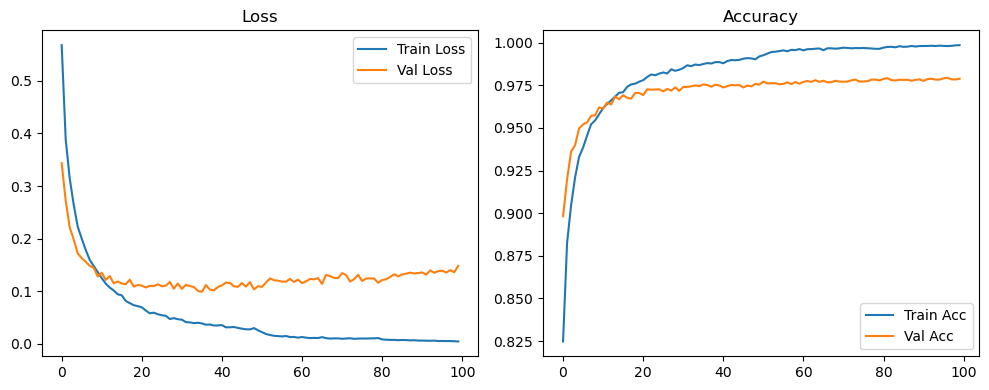

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.0


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.3862, Acc: 0.8894 | Val Loss: 0.3297, Acc: 0.9057


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.2480, Acc: 0.9253 | Val Loss: 0.3029, Acc: 0.9042


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.1362, Acc: 0.9586 | Val Loss: 0.1473, Acc: 0.9557


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.0714, Acc: 0.9775 | Val Loss: 0.1138, Acc: 0.9660


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.0414, Acc: 0.9864 | Val Loss: 0.1150, Acc: 0.9666


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9917 | Val Loss: 0.1202, Acc: 0.9666


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0236, Acc: 0.9919 | Val Loss: 0.1203, Acc: 0.9671


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0135, Acc: 0.9956 | Val Loss: 0.1019, Acc: 0.9726


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9955 | Val Loss: 0.1175, Acc: 0.9708


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9977 | Val Loss: 0.1036, Acc: 0.9749


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9954 | Val Loss: 0.1707, Acc: 0.9623


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0142, Acc: 0.9954 | Val Loss: 0.1270, Acc: 0.9695


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.1245, Acc: 0.9718


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0151, Acc: 0.9953 | Val Loss: 0.1419, Acc: 0.9682


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9977 | Val Loss: 0.1124, Acc: 0.9755


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9990 | Val Loss: 0.1288, Acc: 0.9747


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9989 | Val Loss: 0.1266, Acc: 0.9744


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1643, Acc: 0.9668


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1728, Acc: 0.9639


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9950 | Val Loss: 0.1347, Acc: 0.9720


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0063, Acc: 0.9977 | Val Loss: 0.1215, Acc: 0.9758


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0074, Acc: 0.9979 | Val Loss: 0.1553, Acc: 0.9722


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1531, Acc: 0.9722


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9979 | Val Loss: 0.1597, Acc: 0.9714


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0102, Acc: 0.9967 | Val Loss: 0.1590, Acc: 0.9716


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0104, Acc: 0.9967 | Val Loss: 0.1628, Acc: 0.9700


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9977 | Val Loss: 0.1645, Acc: 0.9724


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9983 | Val Loss: 0.1360, Acc: 0.9768


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0111, Acc: 0.9964 | Val Loss: 0.2165, Acc: 0.9656


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9977 | Val Loss: 0.1619, Acc: 0.9740


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0089, Acc: 0.9974 | Val Loss: 0.1589, Acc: 0.9752


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0077, Acc: 0.9980 | Val Loss: 0.1825, Acc: 0.9720


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0064, Acc: 0.9984 | Val Loss: 0.1508, Acc: 0.9772


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9985 | Val Loss: 0.1623, Acc: 0.9746


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9979 | Val Loss: 0.1851, Acc: 0.9714


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0059, Acc: 0.9982 | Val Loss: 0.1827, Acc: 0.9730


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9984 | Val Loss: 0.2111, Acc: 0.9701


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9988 | Val Loss: 0.1850, Acc: 0.9725


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9988 | Val Loss: 0.1568, Acc: 0.9768


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9985 | Val Loss: 0.1676, Acc: 0.9747


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0116, Acc: 0.9971 | Val Loss: 0.1976, Acc: 0.9702


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0092, Acc: 0.9974 | Val Loss: 0.2160, Acc: 0.9692


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0051, Acc: 0.9984 | Val Loss: 0.1696, Acc: 0.9764


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9985 | Val Loss: 0.1949, Acc: 0.9725


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1959, Acc: 0.9732


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9985 | Val Loss: 0.1469, Acc: 0.9765


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0045, Acc: 0.9986 | Val Loss: 0.1642, Acc: 0.9763


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0046, Acc: 0.9989 | Val Loss: 0.1762, Acc: 0.9752


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0060, Acc: 0.9985 | Val Loss: 0.2232, Acc: 0.9699


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0048, Acc: 0.9988 | Val Loss: 0.1890, Acc: 0.9742


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9993 | Val Loss: 0.1633, Acc: 0.9786


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9993 | Val Loss: 0.1672, Acc: 0.9776


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1683, Acc: 0.9761


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0040, Acc: 0.9989 | Val Loss: 0.1503, Acc: 0.9767


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0050, Acc: 0.9986 | Val Loss: 0.2110, Acc: 0.9656


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1505, Acc: 0.9771


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9991 | Val Loss: 0.1520, Acc: 0.9768


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0042, Acc: 0.9988 | Val Loss: 0.2439, Acc: 0.9679


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9990 | Val Loss: 0.1750, Acc: 0.9735


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9987 | Val Loss: 0.1324, Acc: 0.9784


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0030, Acc: 0.9990 | Val Loss: 0.1605, Acc: 0.9758


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9988 | Val Loss: 0.1589, Acc: 0.9757


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0066, Acc: 0.9981 | Val Loss: 0.1465, Acc: 0.9764


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1467, Acc: 0.9784


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0037, Acc: 0.9990 | Val Loss: 0.1582, Acc: 0.9766


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0026, Acc: 0.9993 | Val Loss: 0.1517, Acc: 0.9765


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9990 | Val Loss: 0.1600, Acc: 0.9753


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0012, Acc: 0.9996 | Val Loss: 0.1779, Acc: 0.9746


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9988 | Val Loss: 0.1758, Acc: 0.9769


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0019, Acc: 0.9994 | Val Loss: 0.1656, Acc: 0.9758


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9994 | Val Loss: 0.1764, Acc: 0.9766


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0043, Acc: 0.9989 | Val Loss: 0.1649, Acc: 0.9771


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0031, Acc: 0.9992 | Val Loss: 0.2079, Acc: 0.9704


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9990 | Val Loss: 0.1466, Acc: 0.9768


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1438, Acc: 0.9789


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0011, Acc: 0.9995 | Val Loss: 0.1611, Acc: 0.9773


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0036, Acc: 0.9991 | Val Loss: 0.1531, Acc: 0.9773


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.3136, Acc: 0.9579


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0039, Acc: 0.9989 | Val Loss: 0.1869, Acc: 0.9750


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0041, Acc: 0.9989 | Val Loss: 0.1601, Acc: 0.9764


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0013, Acc: 0.9995 | Val Loss: 0.1690, Acc: 0.9756


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1627, Acc: 0.9782


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0035, Acc: 0.9990 | Val Loss: 0.1636, Acc: 0.9741


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1505, Acc: 0.9779


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1852, Acc: 0.9748


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0028, Acc: 0.9992 | Val Loss: 0.1575, Acc: 0.9775


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0024, Acc: 0.9992 | Val Loss: 0.2147, Acc: 0.9728


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0017, Acc: 0.9995 | Val Loss: 0.1868, Acc: 0.9755


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0032, Acc: 0.9991 | Val Loss: 0.1521, Acc: 0.9779


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9994 | Val Loss: 0.1734, Acc: 0.9762


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1413, Acc: 0.9802


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0029, Acc: 0.9992 | Val Loss: 0.1575, Acc: 0.9780


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0023, Acc: 0.9992 | Val Loss: 0.1584, Acc: 0.9778


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9984 | Val Loss: 0.2045, Acc: 0.9745


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0044, Acc: 0.9989 | Val Loss: 0.1374, Acc: 0.9793


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1425, Acc: 0.9805


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1373, Acc: 0.9812


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0009, Acc: 0.9998 | Val Loss: 0.1414, Acc: 0.9795


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9997 | Val Loss: 0.1438, Acc: 0.9800


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0008, Acc: 0.9999 | Val Loss: 0.1909, Acc: 0.9756


Final Test Loss: 0.1704 Accuracy: 0.9748


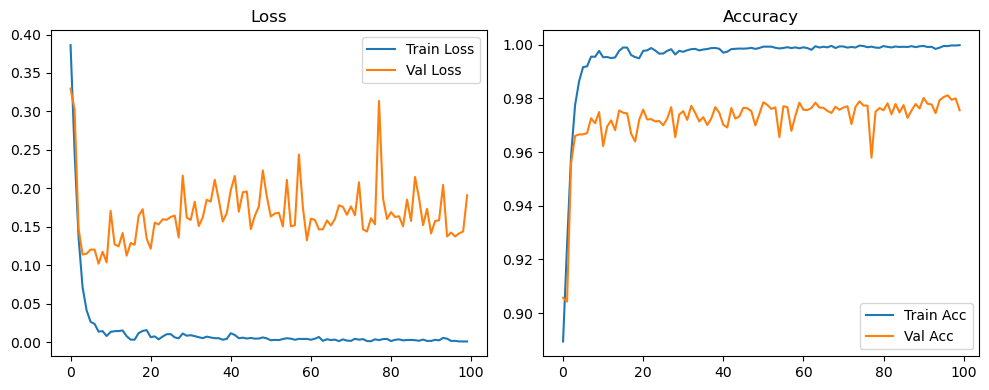

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.2


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.4358, Acc: 0.8718 | Val Loss: 0.3388, Acc: 0.9017


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.3025, Acc: 0.9083 | Val Loss: 0.2610, Acc: 0.9252


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.2173, Acc: 0.9344 | Val Loss: 0.1948, Acc: 0.9415


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.1598, Acc: 0.9516 | Val Loss: 0.1475, Acc: 0.9548


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.1260, Acc: 0.9611 | Val Loss: 0.1224, Acc: 0.9629


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.1072, Acc: 0.9655 | Val Loss: 0.1133, Acc: 0.9651


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.0900, Acc: 0.9710 | Val Loss: 0.1187, Acc: 0.9650


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.0758, Acc: 0.9751 | Val Loss: 0.1187, Acc: 0.9666


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.0658, Acc: 0.9785 | Val Loss: 0.1097, Acc: 0.9684


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.0601, Acc: 0.9800 | Val Loss: 0.1037, Acc: 0.9689


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.0581, Acc: 0.9802 | Val Loss: 0.1129, Acc: 0.9684


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.0472, Acc: 0.9845 | Val Loss: 0.1044, Acc: 0.9735


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.0475, Acc: 0.9843 | Val Loss: 0.1153, Acc: 0.9688


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.0416, Acc: 0.9856 | Val Loss: 0.1044, Acc: 0.9728


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.0380, Acc: 0.9868 | Val Loss: 0.1036, Acc: 0.9723


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.0377, Acc: 0.9875 | Val Loss: 0.1069, Acc: 0.9732


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.0339, Acc: 0.9889 | Val Loss: 0.1201, Acc: 0.9701


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.0308, Acc: 0.9897 | Val Loss: 0.1123, Acc: 0.9718


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9891 | Val Loss: 0.1081, Acc: 0.9748


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9902 | Val Loss: 0.1135, Acc: 0.9738


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9910 | Val Loss: 0.1099, Acc: 0.9743


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.1114, Acc: 0.9750


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0233, Acc: 0.9918 | Val Loss: 0.1151, Acc: 0.9739


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0244, Acc: 0.9918 | Val Loss: 0.1184, Acc: 0.9742


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9917 | Val Loss: 0.1227, Acc: 0.9722


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0219, Acc: 0.9930 | Val Loss: 0.1076, Acc: 0.9752


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0204, Acc: 0.9930 | Val Loss: 0.1127, Acc: 0.9758


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.1146, Acc: 0.9750


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9938 | Val Loss: 0.1304, Acc: 0.9728


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.1309, Acc: 0.9717


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0180, Acc: 0.9939 | Val Loss: 0.1144, Acc: 0.9759


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0193, Acc: 0.9937 | Val Loss: 0.1177, Acc: 0.9762


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9950 | Val Loss: 0.1147, Acc: 0.9758


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0185, Acc: 0.9935 | Val Loss: 0.1249, Acc: 0.9748


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0147, Acc: 0.9950 | Val Loss: 0.1264, Acc: 0.9770


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0169, Acc: 0.9941 | Val Loss: 0.1201, Acc: 0.9767


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0168, Acc: 0.9948 | Val Loss: 0.1091, Acc: 0.9768


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0146, Acc: 0.9952 | Val Loss: 0.1289, Acc: 0.9746


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0136, Acc: 0.9952 | Val Loss: 0.1213, Acc: 0.9762


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0155, Acc: 0.9949 | Val Loss: 0.1158, Acc: 0.9768


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9952 | Val Loss: 0.1267, Acc: 0.9762


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0143, Acc: 0.9953 | Val Loss: 0.1168, Acc: 0.9772


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0152, Acc: 0.9951 | Val Loss: 0.1374, Acc: 0.9742


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0140, Acc: 0.9952 | Val Loss: 0.1234, Acc: 0.9752


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0132, Acc: 0.9958 | Val Loss: 0.1197, Acc: 0.9764


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9961 | Val Loss: 0.1301, Acc: 0.9751


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9955 | Val Loss: 0.1353, Acc: 0.9763


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0127, Acc: 0.9957 | Val Loss: 0.1349, Acc: 0.9767


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0124, Acc: 0.9960 | Val Loss: 0.1231, Acc: 0.9778


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0131, Acc: 0.9956 | Val Loss: 0.1132, Acc: 0.9768


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0119, Acc: 0.9960 | Val Loss: 0.1170, Acc: 0.9775


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0121, Acc: 0.9958 | Val Loss: 0.1273, Acc: 0.9778


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1282, Acc: 0.9762


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0123, Acc: 0.9960 | Val Loss: 0.1253, Acc: 0.9759


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0113, Acc: 0.9962 | Val Loss: 0.1215, Acc: 0.9757


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0114, Acc: 0.9961 | Val Loss: 0.1192, Acc: 0.9765


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1275, Acc: 0.9762


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0098, Acc: 0.9968 | Val Loss: 0.1390, Acc: 0.9758


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0120, Acc: 0.9963 | Val Loss: 0.1222, Acc: 0.9781


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9974 | Val Loss: 0.1278, Acc: 0.9762


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0097, Acc: 0.9969 | Val Loss: 0.1251, Acc: 0.9773


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1302, Acc: 0.9771


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0112, Acc: 0.9966 | Val Loss: 0.1316, Acc: 0.9769


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0088, Acc: 0.9971 | Val Loss: 0.1244, Acc: 0.9782


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0078, Acc: 0.9975 | Val Loss: 0.1230, Acc: 0.9791


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0095, Acc: 0.9969 | Val Loss: 0.1255, Acc: 0.9779


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1249, Acc: 0.9782


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9970 | Val Loss: 0.1277, Acc: 0.9772


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0091, Acc: 0.9974 | Val Loss: 0.1321, Acc: 0.9766


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0099, Acc: 0.9969 | Val Loss: 0.1303, Acc: 0.9749


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0085, Acc: 0.9972 | Val Loss: 0.1287, Acc: 0.9772


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0094, Acc: 0.9970 | Val Loss: 0.1240, Acc: 0.9775


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9969 | Val Loss: 0.1215, Acc: 0.9771


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0084, Acc: 0.9971 | Val Loss: 0.1249, Acc: 0.9784


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1246, Acc: 0.9778


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0090, Acc: 0.9973 | Val Loss: 0.1262, Acc: 0.9762


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9970 | Val Loss: 0.1226, Acc: 0.9782


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1215, Acc: 0.9781


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9975 | Val Loss: 0.1249, Acc: 0.9778


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9973 | Val Loss: 0.1189, Acc: 0.9784


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0083, Acc: 0.9972 | Val Loss: 0.1285, Acc: 0.9768


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1320, Acc: 0.9766


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0052, Acc: 0.9980 | Val Loss: 0.1406, Acc: 0.9770


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9974 | Val Loss: 0.1389, Acc: 0.9772


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1299, Acc: 0.9776


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9975 | Val Loss: 0.1312, Acc: 0.9768


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9976 | Val Loss: 0.1404, Acc: 0.9782


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9978 | Val Loss: 0.1359, Acc: 0.9768


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1216, Acc: 0.9778


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0065, Acc: 0.9979 | Val Loss: 0.1388, Acc: 0.9767


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1484, Acc: 0.9762


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0072, Acc: 0.9974 | Val Loss: 0.1305, Acc: 0.9770


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9978 | Val Loss: 0.1337, Acc: 0.9773


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0069, Acc: 0.9979 | Val Loss: 0.1274, Acc: 0.9787


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0070, Acc: 0.9976 | Val Loss: 0.1241, Acc: 0.9798


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0056, Acc: 0.9983 | Val Loss: 0.1246, Acc: 0.9788


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0049, Acc: 0.9984 | Val Loss: 0.1379, Acc: 0.9760


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0061, Acc: 0.9981 | Val Loss: 0.1282, Acc: 0.9778


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0054, Acc: 0.9981 | Val Loss: 0.1452, Acc: 0.9775


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0068, Acc: 0.9976 | Val Loss: 0.1375, Acc: 0.9775


Final Test Loss: 0.1356 Accuracy: 0.9796


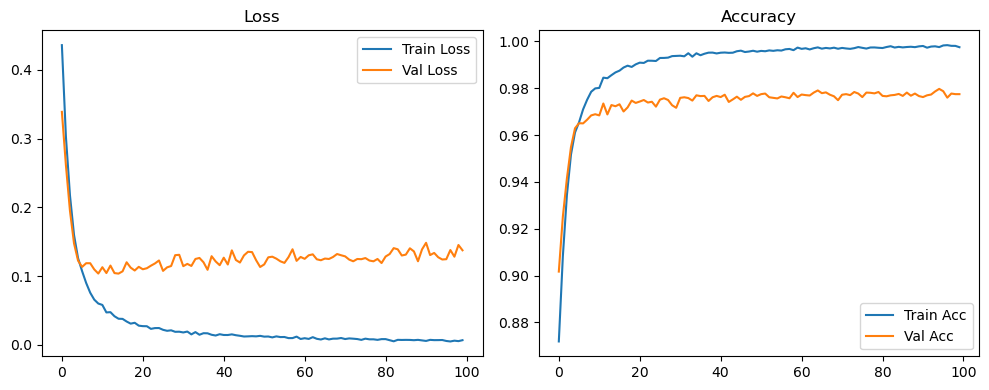

🚀 Running: batch256_lr0.002_0.002_0.002_dp0.5


Epoch 1/100 - LR: 0.00200 | Train Loss: 0.5912, Acc: 0.8202 | Val Loss: 0.3382, Acc: 0.9001


Epoch 2/100 - LR: 0.00200 | Train Loss: 0.4041, Acc: 0.8764 | Val Loss: 0.3004, Acc: 0.9116


Epoch 3/100 - LR: 0.00200 | Train Loss: 0.3599, Acc: 0.8905 | Val Loss: 0.2725, Acc: 0.9217


Epoch 4/100 - LR: 0.00200 | Train Loss: 0.3203, Acc: 0.9039 | Val Loss: 0.2543, Acc: 0.9212


Epoch 5/100 - LR: 0.00200 | Train Loss: 0.2873, Acc: 0.9120 | Val Loss: 0.2233, Acc: 0.9344


Epoch 6/100 - LR: 0.00200 | Train Loss: 0.2595, Acc: 0.9212 | Val Loss: 0.2054, Acc: 0.9387


Epoch 7/100 - LR: 0.00200 | Train Loss: 0.2356, Acc: 0.9281 | Val Loss: 0.1931, Acc: 0.9425


Epoch 8/100 - LR: 0.00200 | Train Loss: 0.2094, Acc: 0.9373 | Val Loss: 0.1798, Acc: 0.9495


Epoch 9/100 - LR: 0.00200 | Train Loss: 0.1958, Acc: 0.9407 | Val Loss: 0.1682, Acc: 0.9497


Epoch 10/100 - LR: 0.00200 | Train Loss: 0.1817, Acc: 0.9459 | Val Loss: 0.1604, Acc: 0.9542


Epoch 11/100 - LR: 0.00200 | Train Loss: 0.1677, Acc: 0.9481 | Val Loss: 0.1611, Acc: 0.9551


Epoch 12/100 - LR: 0.00200 | Train Loss: 0.1540, Acc: 0.9519 | Val Loss: 0.1435, Acc: 0.9600


Epoch 13/100 - LR: 0.00200 | Train Loss: 0.1416, Acc: 0.9571 | Val Loss: 0.1460, Acc: 0.9593


Epoch 14/100 - LR: 0.00200 | Train Loss: 0.1353, Acc: 0.9576 | Val Loss: 0.1343, Acc: 0.9627


Epoch 15/100 - LR: 0.00200 | Train Loss: 0.1253, Acc: 0.9608 | Val Loss: 0.1356, Acc: 0.9625


Epoch 16/100 - LR: 0.00200 | Train Loss: 0.1211, Acc: 0.9625 | Val Loss: 0.1314, Acc: 0.9633


Epoch 17/100 - LR: 0.00200 | Train Loss: 0.1085, Acc: 0.9659 | Val Loss: 0.1349, Acc: 0.9625


Epoch 18/100 - LR: 0.00200 | Train Loss: 0.1026, Acc: 0.9673 | Val Loss: 0.1331, Acc: 0.9640


Epoch 19/100 - LR: 0.00200 | Train Loss: 0.0975, Acc: 0.9694 | Val Loss: 0.1269, Acc: 0.9668


Epoch 20/100 - LR: 0.00200 | Train Loss: 0.0960, Acc: 0.9695 | Val Loss: 0.1263, Acc: 0.9668


Epoch 21/100 - LR: 0.00200 | Train Loss: 0.0904, Acc: 0.9706 | Val Loss: 0.1248, Acc: 0.9665


Epoch 22/100 - LR: 0.00200 | Train Loss: 0.0868, Acc: 0.9724 | Val Loss: 0.1213, Acc: 0.9694


Epoch 23/100 - LR: 0.00200 | Train Loss: 0.0777, Acc: 0.9748 | Val Loss: 0.1243, Acc: 0.9691


Epoch 24/100 - LR: 0.00200 | Train Loss: 0.0743, Acc: 0.9762 | Val Loss: 0.1280, Acc: 0.9697


Epoch 25/100 - LR: 0.00200 | Train Loss: 0.0751, Acc: 0.9764 | Val Loss: 0.1253, Acc: 0.9683


Epoch 26/100 - LR: 0.00200 | Train Loss: 0.0723, Acc: 0.9772 | Val Loss: 0.1238, Acc: 0.9700


Epoch 27/100 - LR: 0.00200 | Train Loss: 0.0677, Acc: 0.9783 | Val Loss: 0.1239, Acc: 0.9693


Epoch 28/100 - LR: 0.00200 | Train Loss: 0.0610, Acc: 0.9805 | Val Loss: 0.1261, Acc: 0.9695


Epoch 29/100 - LR: 0.00200 | Train Loss: 0.0596, Acc: 0.9802 | Val Loss: 0.1218, Acc: 0.9715


Epoch 30/100 - LR: 0.00200 | Train Loss: 0.0562, Acc: 0.9821 | Val Loss: 0.1331, Acc: 0.9702


Epoch 31/100 - LR: 0.00200 | Train Loss: 0.0558, Acc: 0.9809 | Val Loss: 0.1286, Acc: 0.9701


Epoch 32/100 - LR: 0.00200 | Train Loss: 0.0554, Acc: 0.9816 | Val Loss: 0.1202, Acc: 0.9725


Epoch 33/100 - LR: 0.00200 | Train Loss: 0.0499, Acc: 0.9834 | Val Loss: 0.1302, Acc: 0.9708


Epoch 34/100 - LR: 0.00200 | Train Loss: 0.0492, Acc: 0.9840 | Val Loss: 0.1225, Acc: 0.9722


Epoch 35/100 - LR: 0.00200 | Train Loss: 0.0480, Acc: 0.9840 | Val Loss: 0.1259, Acc: 0.9721


Epoch 36/100 - LR: 0.00200 | Train Loss: 0.0482, Acc: 0.9843 | Val Loss: 0.1257, Acc: 0.9724


Epoch 37/100 - LR: 0.00200 | Train Loss: 0.0447, Acc: 0.9858 | Val Loss: 0.1207, Acc: 0.9732


Epoch 38/100 - LR: 0.00200 | Train Loss: 0.0454, Acc: 0.9853 | Val Loss: 0.1228, Acc: 0.9722


Epoch 39/100 - LR: 0.00200 | Train Loss: 0.0409, Acc: 0.9865 | Val Loss: 0.1267, Acc: 0.9726


Epoch 40/100 - LR: 0.00200 | Train Loss: 0.0403, Acc: 0.9866 | Val Loss: 0.1277, Acc: 0.9724


Epoch 41/100 - LR: 0.00200 | Train Loss: 0.0429, Acc: 0.9858 | Val Loss: 0.1321, Acc: 0.9713


Epoch 42/100 - LR: 0.00200 | Train Loss: 0.0372, Acc: 0.9870 | Val Loss: 0.1328, Acc: 0.9729


Epoch 43/100 - LR: 0.00200 | Train Loss: 0.0399, Acc: 0.9868 | Val Loss: 0.1283, Acc: 0.9733


Epoch 44/100 - LR: 0.00200 | Train Loss: 0.0379, Acc: 0.9873 | Val Loss: 0.1322, Acc: 0.9738


Epoch 45/100 - LR: 0.00200 | Train Loss: 0.0351, Acc: 0.9884 | Val Loss: 0.1344, Acc: 0.9742


Epoch 46/100 - LR: 0.00200 | Train Loss: 0.0335, Acc: 0.9888 | Val Loss: 0.1404, Acc: 0.9734


Epoch 47/100 - LR: 0.00200 | Train Loss: 0.0353, Acc: 0.9883 | Val Loss: 0.1378, Acc: 0.9719


Epoch 48/100 - LR: 0.00200 | Train Loss: 0.0332, Acc: 0.9887 | Val Loss: 0.1319, Acc: 0.9730


Epoch 49/100 - LR: 0.00200 | Train Loss: 0.0321, Acc: 0.9896 | Val Loss: 0.1367, Acc: 0.9729


Epoch 50/100 - LR: 0.00200 | Train Loss: 0.0319, Acc: 0.9895 | Val Loss: 0.1323, Acc: 0.9722


Epoch 51/100 - LR: 0.00200 | Train Loss: 0.0325, Acc: 0.9896 | Val Loss: 0.1290, Acc: 0.9740


Epoch 52/100 - LR: 0.00200 | Train Loss: 0.0279, Acc: 0.9901 | Val Loss: 0.1411, Acc: 0.9736


Epoch 53/100 - LR: 0.00200 | Train Loss: 0.0284, Acc: 0.9905 | Val Loss: 0.1401, Acc: 0.9724


Epoch 54/100 - LR: 0.00200 | Train Loss: 0.0304, Acc: 0.9898 | Val Loss: 0.1396, Acc: 0.9738


Epoch 55/100 - LR: 0.00200 | Train Loss: 0.0293, Acc: 0.9906 | Val Loss: 0.1317, Acc: 0.9736


Epoch 56/100 - LR: 0.00200 | Train Loss: 0.0278, Acc: 0.9906 | Val Loss: 0.1337, Acc: 0.9737


Epoch 57/100 - LR: 0.00200 | Train Loss: 0.0297, Acc: 0.9900 | Val Loss: 0.1380, Acc: 0.9730


Epoch 58/100 - LR: 0.00200 | Train Loss: 0.0272, Acc: 0.9902 | Val Loss: 0.1366, Acc: 0.9734


Epoch 59/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9905 | Val Loss: 0.1354, Acc: 0.9742


Epoch 60/100 - LR: 0.00200 | Train Loss: 0.0264, Acc: 0.9913 | Val Loss: 0.1271, Acc: 0.9733


Epoch 61/100 - LR: 0.00200 | Train Loss: 0.0253, Acc: 0.9914 | Val Loss: 0.1352, Acc: 0.9746


Epoch 62/100 - LR: 0.00200 | Train Loss: 0.0251, Acc: 0.9917 | Val Loss: 0.1334, Acc: 0.9747


Epoch 63/100 - LR: 0.00200 | Train Loss: 0.0250, Acc: 0.9910 | Val Loss: 0.1394, Acc: 0.9732


Epoch 64/100 - LR: 0.00200 | Train Loss: 0.0255, Acc: 0.9916 | Val Loss: 0.1354, Acc: 0.9745


Epoch 65/100 - LR: 0.00200 | Train Loss: 0.0206, Acc: 0.9928 | Val Loss: 0.1443, Acc: 0.9739


Epoch 66/100 - LR: 0.00200 | Train Loss: 0.0230, Acc: 0.9930 | Val Loss: 0.1499, Acc: 0.9739


Epoch 67/100 - LR: 0.00200 | Train Loss: 0.0245, Acc: 0.9921 | Val Loss: 0.1291, Acc: 0.9742


Epoch 68/100 - LR: 0.00200 | Train Loss: 0.0211, Acc: 0.9931 | Val Loss: 0.1405, Acc: 0.9752


Epoch 69/100 - LR: 0.00200 | Train Loss: 0.0225, Acc: 0.9926 | Val Loss: 0.1441, Acc: 0.9741


Epoch 70/100 - LR: 0.00200 | Train Loss: 0.0192, Acc: 0.9935 | Val Loss: 0.1449, Acc: 0.9747


Epoch 71/100 - LR: 0.00200 | Train Loss: 0.0214, Acc: 0.9929 | Val Loss: 0.1367, Acc: 0.9748


Epoch 72/100 - LR: 0.00200 | Train Loss: 0.0221, Acc: 0.9928 | Val Loss: 0.1456, Acc: 0.9743


Epoch 73/100 - LR: 0.00200 | Train Loss: 0.0208, Acc: 0.9928 | Val Loss: 0.1406, Acc: 0.9757


Epoch 74/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9930 | Val Loss: 0.1411, Acc: 0.9744


Epoch 75/100 - LR: 0.00200 | Train Loss: 0.0191, Acc: 0.9938 | Val Loss: 0.1443, Acc: 0.9738


Epoch 76/100 - LR: 0.00200 | Train Loss: 0.0220, Acc: 0.9928 | Val Loss: 0.1357, Acc: 0.9742


Epoch 77/100 - LR: 0.00200 | Train Loss: 0.0209, Acc: 0.9933 | Val Loss: 0.1369, Acc: 0.9754


Epoch 78/100 - LR: 0.00200 | Train Loss: 0.0173, Acc: 0.9944 | Val Loss: 0.1446, Acc: 0.9749


Epoch 79/100 - LR: 0.00200 | Train Loss: 0.0200, Acc: 0.9934 | Val Loss: 0.1364, Acc: 0.9749


Epoch 80/100 - LR: 0.00200 | Train Loss: 0.0190, Acc: 0.9934 | Val Loss: 0.1403, Acc: 0.9761


Epoch 81/100 - LR: 0.00200 | Train Loss: 0.0202, Acc: 0.9938 | Val Loss: 0.1393, Acc: 0.9754


Epoch 82/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9934 | Val Loss: 0.1413, Acc: 0.9749


Epoch 83/100 - LR: 0.00200 | Train Loss: 0.0198, Acc: 0.9933 | Val Loss: 0.1315, Acc: 0.9748


Epoch 84/100 - LR: 0.00200 | Train Loss: 0.0166, Acc: 0.9944 | Val Loss: 0.1471, Acc: 0.9752


Epoch 85/100 - LR: 0.00200 | Train Loss: 0.0182, Acc: 0.9941 | Val Loss: 0.1437, Acc: 0.9749


Epoch 86/100 - LR: 0.00200 | Train Loss: 0.0186, Acc: 0.9942 | Val Loss: 0.1382, Acc: 0.9754


Epoch 87/100 - LR: 0.00200 | Train Loss: 0.0189, Acc: 0.9936 | Val Loss: 0.1409, Acc: 0.9738


Epoch 88/100 - LR: 0.00200 | Train Loss: 0.0174, Acc: 0.9942 | Val Loss: 0.1316, Acc: 0.9747


Epoch 89/100 - LR: 0.00200 | Train Loss: 0.0177, Acc: 0.9938 | Val Loss: 0.1391, Acc: 0.9764


Epoch 90/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9950 | Val Loss: 0.1474, Acc: 0.9753


Epoch 91/100 - LR: 0.00200 | Train Loss: 0.0163, Acc: 0.9945 | Val Loss: 0.1479, Acc: 0.9746


Epoch 92/100 - LR: 0.00200 | Train Loss: 0.0170, Acc: 0.9944 | Val Loss: 0.1346, Acc: 0.9755


Epoch 93/100 - LR: 0.00200 | Train Loss: 0.0194, Acc: 0.9940 | Val Loss: 0.1321, Acc: 0.9755


Epoch 94/100 - LR: 0.00200 | Train Loss: 0.0175, Acc: 0.9944 | Val Loss: 0.1345, Acc: 0.9760


Epoch 95/100 - LR: 0.00200 | Train Loss: 0.0165, Acc: 0.9946 | Val Loss: 0.1379, Acc: 0.9752


Epoch 96/100 - LR: 0.00200 | Train Loss: 0.0150, Acc: 0.9952 | Val Loss: 0.1455, Acc: 0.9750


Epoch 97/100 - LR: 0.00200 | Train Loss: 0.0154, Acc: 0.9946 | Val Loss: 0.1534, Acc: 0.9759


Epoch 98/100 - LR: 0.00200 | Train Loss: 0.0162, Acc: 0.9945 | Val Loss: 0.1454, Acc: 0.9751


Epoch 99/100 - LR: 0.00200 | Train Loss: 0.0144, Acc: 0.9955 | Val Loss: 0.1409, Acc: 0.9768


Epoch 100/100 - LR: 0.00200 | Train Loss: 0.0153, Acc: 0.9946 | Val Loss: 0.1506, Acc: 0.9742


Final Test Loss: 0.1365 Accuracy: 0.9769


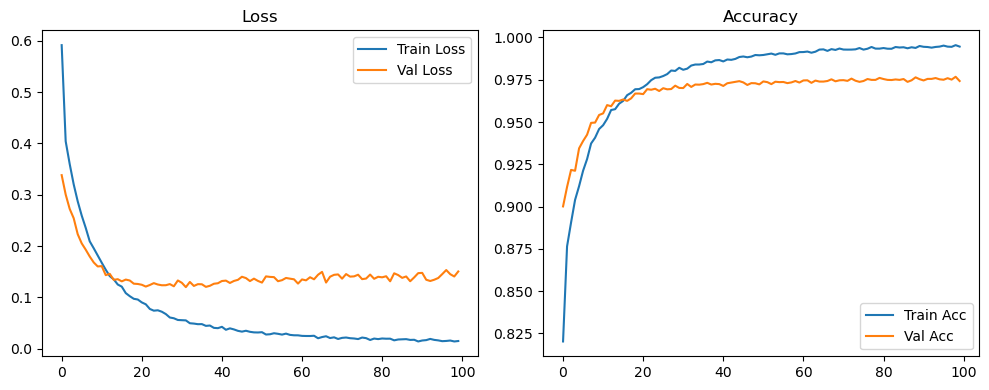

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.0


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.3998, Acc: 0.8899 | Val Loss: 0.3174, Acc: 0.9070


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.2547, Acc: 0.9240 | Val Loss: 0.2325, Acc: 0.9313


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.1461, Acc: 0.9551 | Val Loss: 0.1476, Acc: 0.9539


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.0775, Acc: 0.9760 | Val Loss: 0.1101, Acc: 0.9646


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.0424, Acc: 0.9870 | Val Loss: 0.1071, Acc: 0.9663


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.0247, Acc: 0.9927 | Val Loss: 0.1129, Acc: 0.9673


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9952 | Val Loss: 0.0968, Acc: 0.9724


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0138, Acc: 0.9958 | Val Loss: 0.0955, Acc: 0.9731


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9969 | Val Loss: 0.1064, Acc: 0.9713


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0106, Acc: 0.9967 | Val Loss: 0.0979, Acc: 0.9735


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0076, Acc: 0.9980 | Val Loss: 0.0957, Acc: 0.9764


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0040, Acc: 0.9990 | Val Loss: 0.0927, Acc: 0.9764


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0058, Acc: 0.9981 | Val Loss: 0.1199, Acc: 0.9706


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0113, Acc: 0.9961 | Val Loss: 0.1395, Acc: 0.9677


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0132, Acc: 0.9955 | Val Loss: 0.1240, Acc: 0.9706


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0094, Acc: 0.9971 | Val Loss: 0.1141, Acc: 0.9723


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9986 | Val Loss: 0.1048, Acc: 0.9735


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1106, Acc: 0.9750


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9984 | Val Loss: 0.1467, Acc: 0.9684


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9970 | Val Loss: 0.1178, Acc: 0.9731


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0047, Acc: 0.9985 | Val Loss: 0.1055, Acc: 0.9758


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0068, Acc: 0.9979 | Val Loss: 0.1251, Acc: 0.9718


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0044, Acc: 0.9987 | Val Loss: 0.1604, Acc: 0.9663


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1251, Acc: 0.9732


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0057, Acc: 0.9981 | Val Loss: 0.1486, Acc: 0.9694


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0061, Acc: 0.9979 | Val Loss: 0.1538, Acc: 0.9678


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0064, Acc: 0.9977 | Val Loss: 0.1255, Acc: 0.9731


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0046, Acc: 0.9985 | Val Loss: 0.1625, Acc: 0.9701


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9967 | Val Loss: 0.1711, Acc: 0.9696


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0103, Acc: 0.9969 | Val Loss: 0.1565, Acc: 0.9673


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9987 | Val Loss: 0.1154, Acc: 0.9792


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9994 | Val Loss: 0.1113, Acc: 0.9773


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9997 | Val Loss: 0.1048, Acc: 0.9788


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.1078, Acc: 0.9788


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0003, Acc: 0.9999 | Val Loss: 0.1052, Acc: 0.9792


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1075, Acc: 0.9802


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1030, Acc: 0.9804


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1019, Acc: 0.9805


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1047, Acc: 0.9810


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.1011, Acc: 0.9808


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1019, Acc: 0.9818


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1036, Acc: 0.9809


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1026, Acc: 0.9808


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1036, Acc: 0.9808


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1034, Acc: 0.9809


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1024, Acc: 0.9811


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0392, Acc: 0.9898 | Val Loss: 0.2500, Acc: 0.9447


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0199, Acc: 0.9938 | Val Loss: 0.1161, Acc: 0.9728


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9986 | Val Loss: 0.1072, Acc: 0.9783


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0010, Acc: 0.9998 | Val Loss: 0.0982, Acc: 0.9802


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0005, Acc: 0.9999 | Val Loss: 0.1014, Acc: 0.9799


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9998 | Val Loss: 0.1281, Acc: 0.9764


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0004, Acc: 0.9999 | Val Loss: 0.0970, Acc: 0.9801


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0955, Acc: 0.9812


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0968, Acc: 0.9812


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0001, Acc: 1.0000 | Val Loss: 0.0973, Acc: 0.9812


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0974, Acc: 0.9813


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0980, Acc: 0.9812


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0983, Acc: 0.9818


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0977, Acc: 0.9822


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0988, Acc: 0.9813


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1022, Acc: 0.9812


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1010, Acc: 0.9816


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.1004, Acc: 0.9815


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0996, Acc: 0.9817


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0992, Acc: 0.9817


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0253, Acc: 0.9935 | Val Loss: 0.1972, Acc: 0.9617


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0209, Acc: 0.9931 | Val Loss: 0.1056, Acc: 0.9771


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0043, Acc: 0.9986 | Val Loss: 0.1474, Acc: 0.9731


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0014, Acc: 0.9997 | Val Loss: 0.1050, Acc: 0.9804


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0008, Acc: 0.9998 | Val Loss: 0.1001, Acc: 0.9802


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0012, Acc: 0.9997 | Val Loss: 0.1056, Acc: 0.9795


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0009, Acc: 0.9999 | Val Loss: 0.1258, Acc: 0.9769


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0015, Acc: 0.9995 | Val Loss: 0.1181, Acc: 0.9778


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9994 | Val Loss: 0.1927, Acc: 0.9686


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0036, Acc: 0.9989 | Val Loss: 0.1306, Acc: 0.9762


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0031, Acc: 0.9991 | Val Loss: 0.1152, Acc: 0.9789


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0027, Acc: 0.9992 | Val Loss: 0.1348, Acc: 0.9756


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1422, Acc: 0.9744


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0034, Acc: 0.9989 | Val Loss: 0.2462, Acc: 0.9634


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9989 | Val Loss: 0.1560, Acc: 0.9745


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.1340, Acc: 0.9771


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9992 | Val Loss: 0.2227, Acc: 0.9633


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9993 | Val Loss: 0.1538, Acc: 0.9758


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1360, Acc: 0.9772


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0025, Acc: 0.9993 | Val Loss: 0.1635, Acc: 0.9732


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0022, Acc: 0.9993 | Val Loss: 0.1330, Acc: 0.9788


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0007, Acc: 0.9998 | Val Loss: 0.1294, Acc: 0.9803


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0013, Acc: 0.9997 | Val Loss: 0.1269, Acc: 0.9803


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0021, Acc: 0.9994 | Val Loss: 0.1406, Acc: 0.9778


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0023, Acc: 0.9994 | Val Loss: 0.1583, Acc: 0.9759


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0049, Acc: 0.9985 | Val Loss: 0.1567, Acc: 0.9762


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0055, Acc: 0.9984 | Val Loss: 0.1691, Acc: 0.9753


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0019, Acc: 0.9995 | Val Loss: 0.1449, Acc: 0.9762


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1326, Acc: 0.9797


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0026, Acc: 0.9994 | Val Loss: 0.1268, Acc: 0.9791


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0033, Acc: 0.9992 | Val Loss: 0.1416, Acc: 0.9782


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9997 | Val Loss: 0.1371, Acc: 0.9795


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0016, Acc: 0.9995 | Val Loss: 0.1575, Acc: 0.9764


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0011, Acc: 0.9996 | Val Loss: 0.1321, Acc: 0.9780


Final Test Loss: 0.1280 Accuracy: 0.9789


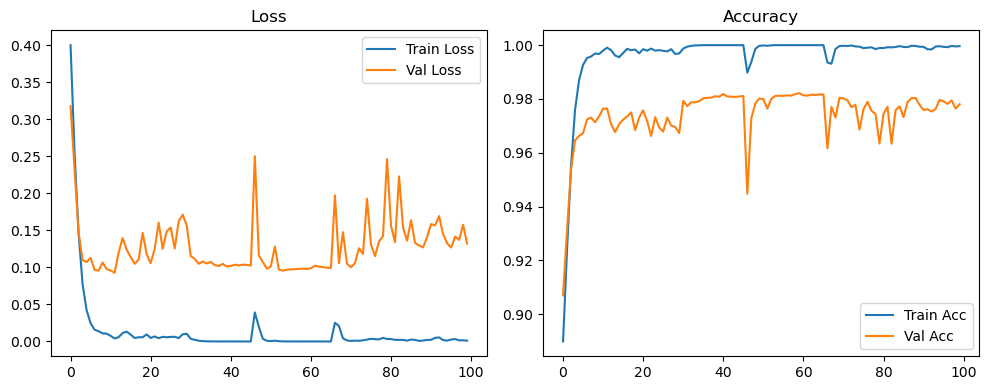

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.2


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.4695, Acc: 0.8682 | Val Loss: 0.3233, Acc: 0.9058


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.3131, Acc: 0.9059 | Val Loss: 0.2739, Acc: 0.9206


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.2355, Acc: 0.9299 | Val Loss: 0.2073, Acc: 0.9375


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.1760, Acc: 0.9477 | Val Loss: 0.1519, Acc: 0.9527


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.1389, Acc: 0.9563 | Val Loss: 0.1276, Acc: 0.9606


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.1166, Acc: 0.9627 | Val Loss: 0.1166, Acc: 0.9642


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.0999, Acc: 0.9679 | Val Loss: 0.1150, Acc: 0.9657


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.0855, Acc: 0.9724 | Val Loss: 0.1101, Acc: 0.9670


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.0714, Acc: 0.9768 | Val Loss: 0.1033, Acc: 0.9695


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.0684, Acc: 0.9770 | Val Loss: 0.1015, Acc: 0.9699


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.0643, Acc: 0.9784 | Val Loss: 0.1073, Acc: 0.9692


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.0547, Acc: 0.9816 | Val Loss: 0.0987, Acc: 0.9722


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.0510, Acc: 0.9825 | Val Loss: 0.1052, Acc: 0.9702


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.0467, Acc: 0.9849 | Val Loss: 0.1004, Acc: 0.9720


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.0452, Acc: 0.9845 | Val Loss: 0.0999, Acc: 0.9722


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.0402, Acc: 0.9864 | Val Loss: 0.0963, Acc: 0.9744


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.0383, Acc: 0.9871 | Val Loss: 0.0996, Acc: 0.9731


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.0360, Acc: 0.9872 | Val Loss: 0.0991, Acc: 0.9738


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9890 | Val Loss: 0.1004, Acc: 0.9739


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9887 | Val Loss: 0.0983, Acc: 0.9750


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.0317, Acc: 0.9895 | Val Loss: 0.1016, Acc: 0.9739


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9904 | Val Loss: 0.1047, Acc: 0.9745


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.0272, Acc: 0.9908 | Val Loss: 0.0993, Acc: 0.9737


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.0262, Acc: 0.9911 | Val Loss: 0.1018, Acc: 0.9752


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0248, Acc: 0.9918 | Val Loss: 0.1137, Acc: 0.9735


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0229, Acc: 0.9920 | Val Loss: 0.1021, Acc: 0.9753


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0246, Acc: 0.9915 | Val Loss: 0.1007, Acc: 0.9751


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0222, Acc: 0.9921 | Val Loss: 0.1120, Acc: 0.9756


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0208, Acc: 0.9929 | Val Loss: 0.1088, Acc: 0.9768


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0210, Acc: 0.9929 | Val Loss: 0.1160, Acc: 0.9728


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0183, Acc: 0.9939 | Val Loss: 0.1070, Acc: 0.9761


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0205, Acc: 0.9932 | Val Loss: 0.1036, Acc: 0.9766


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0188, Acc: 0.9936 | Val Loss: 0.1115, Acc: 0.9768


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9944 | Val Loss: 0.1172, Acc: 0.9747


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9942 | Val Loss: 0.1094, Acc: 0.9771


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9938 | Val Loss: 0.1203, Acc: 0.9752


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0171, Acc: 0.9943 | Val Loss: 0.1134, Acc: 0.9767


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0187, Acc: 0.9935 | Val Loss: 0.1161, Acc: 0.9742


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0159, Acc: 0.9947 | Val Loss: 0.1121, Acc: 0.9768


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0154, Acc: 0.9944 | Val Loss: 0.1160, Acc: 0.9758


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0177, Acc: 0.9941 | Val Loss: 0.1255, Acc: 0.9758


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0158, Acc: 0.9944 | Val Loss: 0.1123, Acc: 0.9773


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0172, Acc: 0.9943 | Val Loss: 0.1220, Acc: 0.9753


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0140, Acc: 0.9954 | Val Loss: 0.1128, Acc: 0.9768


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0139, Acc: 0.9953 | Val Loss: 0.1199, Acc: 0.9759


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0137, Acc: 0.9954 | Val Loss: 0.1155, Acc: 0.9761


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0124, Acc: 0.9958 | Val Loss: 0.1181, Acc: 0.9762


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0147, Acc: 0.9951 | Val Loss: 0.1241, Acc: 0.9760


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1227, Acc: 0.9768


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0165, Acc: 0.9947 | Val Loss: 0.1211, Acc: 0.9753


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0145, Acc: 0.9954 | Val Loss: 0.1218, Acc: 0.9764


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9959 | Val Loss: 0.1252, Acc: 0.9759


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0141, Acc: 0.9951 | Val Loss: 0.1227, Acc: 0.9752


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0129, Acc: 0.9956 | Val Loss: 0.1292, Acc: 0.9752


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0122, Acc: 0.9958 | Val Loss: 0.1208, Acc: 0.9764


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0116, Acc: 0.9960 | Val Loss: 0.1181, Acc: 0.9770


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0110, Acc: 0.9963 | Val Loss: 0.1149, Acc: 0.9772


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0121, Acc: 0.9959 | Val Loss: 0.1199, Acc: 0.9759


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0117, Acc: 0.9961 | Val Loss: 0.1359, Acc: 0.9750


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0115, Acc: 0.9964 | Val Loss: 0.1256, Acc: 0.9755


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0089, Acc: 0.9967 | Val Loss: 0.1223, Acc: 0.9768


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0109, Acc: 0.9962 | Val Loss: 0.1138, Acc: 0.9775


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0111, Acc: 0.9961 | Val Loss: 0.1267, Acc: 0.9758


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9970 | Val Loss: 0.1250, Acc: 0.9760


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9972 | Val Loss: 0.1240, Acc: 0.9763


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9966 | Val Loss: 0.1324, Acc: 0.9762


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9970 | Val Loss: 0.1348, Acc: 0.9749


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9970 | Val Loss: 0.1284, Acc: 0.9758


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0098, Acc: 0.9967 | Val Loss: 0.1264, Acc: 0.9758


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0101, Acc: 0.9965 | Val Loss: 0.1278, Acc: 0.9758


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0079, Acc: 0.9970 | Val Loss: 0.1360, Acc: 0.9754


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9972 | Val Loss: 0.1294, Acc: 0.9762


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1269, Acc: 0.9772


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0085, Acc: 0.9971 | Val Loss: 0.1264, Acc: 0.9764


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0087, Acc: 0.9972 | Val Loss: 0.1257, Acc: 0.9773


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0097, Acc: 0.9968 | Val Loss: 0.1315, Acc: 0.9768


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0100, Acc: 0.9966 | Val Loss: 0.1228, Acc: 0.9779


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0062, Acc: 0.9979 | Val Loss: 0.1318, Acc: 0.9774


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0091, Acc: 0.9968 | Val Loss: 0.1310, Acc: 0.9765


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9969 | Val Loss: 0.1257, Acc: 0.9773


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0088, Acc: 0.9970 | Val Loss: 0.1223, Acc: 0.9776


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9972 | Val Loss: 0.1362, Acc: 0.9757


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9979 | Val Loss: 0.1353, Acc: 0.9768


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0080, Acc: 0.9974 | Val Loss: 0.1384, Acc: 0.9768


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0096, Acc: 0.9971 | Val Loss: 0.1348, Acc: 0.9762


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0086, Acc: 0.9971 | Val Loss: 0.1263, Acc: 0.9787


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0077, Acc: 0.9976 | Val Loss: 0.1285, Acc: 0.9773


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9980 | Val Loss: 0.1341, Acc: 0.9772


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0084, Acc: 0.9974 | Val Loss: 0.1373, Acc: 0.9754


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0066, Acc: 0.9978 | Val Loss: 0.1371, Acc: 0.9758


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0081, Acc: 0.9974 | Val Loss: 0.1288, Acc: 0.9781


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0060, Acc: 0.9979 | Val Loss: 0.1356, Acc: 0.9775


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0059, Acc: 0.9980 | Val Loss: 0.1378, Acc: 0.9767


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0072, Acc: 0.9977 | Val Loss: 0.1392, Acc: 0.9765


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0093, Acc: 0.9971 | Val Loss: 0.1487, Acc: 0.9758


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0078, Acc: 0.9974 | Val Loss: 0.1362, Acc: 0.9769


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0067, Acc: 0.9982 | Val Loss: 0.1345, Acc: 0.9766


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0063, Acc: 0.9979 | Val Loss: 0.1382, Acc: 0.9773


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0071, Acc: 0.9977 | Val Loss: 0.1304, Acc: 0.9783


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0073, Acc: 0.9976 | Val Loss: 0.1339, Acc: 0.9772


Final Test Loss: 0.1279 Accuracy: 0.9779


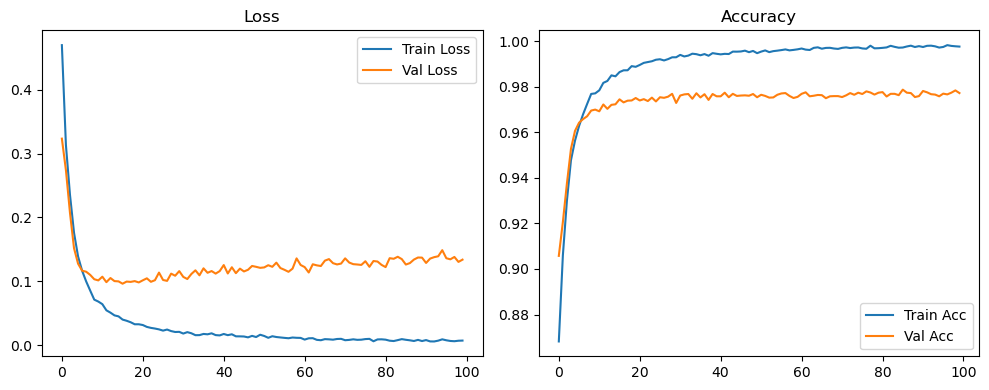

🚀 Running: batch256_lr0.001_0.001_0.001_dp0.5


Epoch 1/100 - LR: 0.00100 | Train Loss: 0.6665, Acc: 0.8036 | Val Loss: 0.3435, Acc: 0.8975


Epoch 2/100 - LR: 0.00100 | Train Loss: 0.4173, Acc: 0.8718 | Val Loss: 0.3041, Acc: 0.9094


Epoch 3/100 - LR: 0.00100 | Train Loss: 0.3605, Acc: 0.8899 | Val Loss: 0.2646, Acc: 0.9225


Epoch 4/100 - LR: 0.00100 | Train Loss: 0.3149, Acc: 0.9050 | Val Loss: 0.2348, Acc: 0.9280


Epoch 5/100 - LR: 0.00100 | Train Loss: 0.2810, Acc: 0.9144 | Val Loss: 0.2094, Acc: 0.9369


Epoch 6/100 - LR: 0.00100 | Train Loss: 0.2532, Acc: 0.9221 | Val Loss: 0.1874, Acc: 0.9425


Epoch 7/100 - LR: 0.00100 | Train Loss: 0.2317, Acc: 0.9283 | Val Loss: 0.1773, Acc: 0.9453


Epoch 8/100 - LR: 0.00100 | Train Loss: 0.2094, Acc: 0.9361 | Val Loss: 0.1650, Acc: 0.9509


Epoch 9/100 - LR: 0.00100 | Train Loss: 0.1987, Acc: 0.9383 | Val Loss: 0.1572, Acc: 0.9531


Epoch 10/100 - LR: 0.00100 | Train Loss: 0.1860, Acc: 0.9427 | Val Loss: 0.1503, Acc: 0.9529


Epoch 11/100 - LR: 0.00100 | Train Loss: 0.1799, Acc: 0.9441 | Val Loss: 0.1533, Acc: 0.9559


Epoch 12/100 - LR: 0.00100 | Train Loss: 0.1668, Acc: 0.9476 | Val Loss: 0.1404, Acc: 0.9594


Epoch 13/100 - LR: 0.00100 | Train Loss: 0.1553, Acc: 0.9513 | Val Loss: 0.1418, Acc: 0.9596


Epoch 14/100 - LR: 0.00100 | Train Loss: 0.1538, Acc: 0.9524 | Val Loss: 0.1316, Acc: 0.9618


Epoch 15/100 - LR: 0.00100 | Train Loss: 0.1440, Acc: 0.9556 | Val Loss: 0.1363, Acc: 0.9603


Epoch 16/100 - LR: 0.00100 | Train Loss: 0.1388, Acc: 0.9567 | Val Loss: 0.1332, Acc: 0.9613


Epoch 17/100 - LR: 0.00100 | Train Loss: 0.1278, Acc: 0.9591 | Val Loss: 0.1372, Acc: 0.9603


Epoch 18/100 - LR: 0.00100 | Train Loss: 0.1242, Acc: 0.9604 | Val Loss: 0.1330, Acc: 0.9633


Epoch 19/100 - LR: 0.00100 | Train Loss: 0.1207, Acc: 0.9618 | Val Loss: 0.1248, Acc: 0.9652


Epoch 20/100 - LR: 0.00100 | Train Loss: 0.1182, Acc: 0.9617 | Val Loss: 0.1245, Acc: 0.9638


Epoch 21/100 - LR: 0.00100 | Train Loss: 0.1098, Acc: 0.9647 | Val Loss: 0.1296, Acc: 0.9644


Epoch 22/100 - LR: 0.00100 | Train Loss: 0.1112, Acc: 0.9643 | Val Loss: 0.1238, Acc: 0.9649


Epoch 23/100 - LR: 0.00100 | Train Loss: 0.1023, Acc: 0.9673 | Val Loss: 0.1282, Acc: 0.9644


Epoch 24/100 - LR: 0.00100 | Train Loss: 0.1012, Acc: 0.9677 | Val Loss: 0.1245, Acc: 0.9656


Epoch 25/100 - LR: 0.00100 | Train Loss: 0.0981, Acc: 0.9691 | Val Loss: 0.1246, Acc: 0.9660


Epoch 26/100 - LR: 0.00100 | Train Loss: 0.0960, Acc: 0.9693 | Val Loss: 0.1243, Acc: 0.9666


Epoch 27/100 - LR: 0.00100 | Train Loss: 0.0934, Acc: 0.9695 | Val Loss: 0.1224, Acc: 0.9672


Epoch 28/100 - LR: 0.00100 | Train Loss: 0.0859, Acc: 0.9721 | Val Loss: 0.1276, Acc: 0.9663


Epoch 29/100 - LR: 0.00100 | Train Loss: 0.0879, Acc: 0.9722 | Val Loss: 0.1225, Acc: 0.9677


Epoch 30/100 - LR: 0.00100 | Train Loss: 0.0841, Acc: 0.9732 | Val Loss: 0.1263, Acc: 0.9664


Epoch 31/100 - LR: 0.00100 | Train Loss: 0.0802, Acc: 0.9748 | Val Loss: 0.1224, Acc: 0.9675


Epoch 32/100 - LR: 0.00100 | Train Loss: 0.0775, Acc: 0.9749 | Val Loss: 0.1208, Acc: 0.9672


Epoch 33/100 - LR: 0.00100 | Train Loss: 0.0762, Acc: 0.9748 | Val Loss: 0.1246, Acc: 0.9682


Epoch 34/100 - LR: 0.00100 | Train Loss: 0.0749, Acc: 0.9758 | Val Loss: 0.1262, Acc: 0.9657


Epoch 35/100 - LR: 0.00100 | Train Loss: 0.0708, Acc: 0.9766 | Val Loss: 0.1253, Acc: 0.9678


Epoch 36/100 - LR: 0.00100 | Train Loss: 0.0693, Acc: 0.9780 | Val Loss: 0.1261, Acc: 0.9681


Epoch 37/100 - LR: 0.00100 | Train Loss: 0.0688, Acc: 0.9771 | Val Loss: 0.1244, Acc: 0.9677


Epoch 38/100 - LR: 0.00100 | Train Loss: 0.0684, Acc: 0.9773 | Val Loss: 0.1230, Acc: 0.9690


Epoch 39/100 - LR: 0.00100 | Train Loss: 0.0659, Acc: 0.9784 | Val Loss: 0.1224, Acc: 0.9695


Epoch 40/100 - LR: 0.00100 | Train Loss: 0.0643, Acc: 0.9793 | Val Loss: 0.1263, Acc: 0.9686


Epoch 41/100 - LR: 0.00100 | Train Loss: 0.0627, Acc: 0.9799 | Val Loss: 0.1266, Acc: 0.9677


Epoch 42/100 - LR: 0.00100 | Train Loss: 0.0622, Acc: 0.9796 | Val Loss: 0.1232, Acc: 0.9693


Epoch 43/100 - LR: 0.00100 | Train Loss: 0.0618, Acc: 0.9792 | Val Loss: 0.1252, Acc: 0.9695


Epoch 44/100 - LR: 0.00100 | Train Loss: 0.0593, Acc: 0.9806 | Val Loss: 0.1208, Acc: 0.9706


Epoch 45/100 - LR: 0.00100 | Train Loss: 0.0589, Acc: 0.9799 | Val Loss: 0.1271, Acc: 0.9702


Epoch 46/100 - LR: 0.00100 | Train Loss: 0.0528, Acc: 0.9822 | Val Loss: 0.1269, Acc: 0.9698


Epoch 47/100 - LR: 0.00100 | Train Loss: 0.0547, Acc: 0.9823 | Val Loss: 0.1285, Acc: 0.9696


Epoch 48/100 - LR: 0.00100 | Train Loss: 0.0512, Acc: 0.9824 | Val Loss: 0.1261, Acc: 0.9704


Epoch 49/100 - LR: 0.00100 | Train Loss: 0.0533, Acc: 0.9823 | Val Loss: 0.1315, Acc: 0.9692


Epoch 50/100 - LR: 0.00100 | Train Loss: 0.0514, Acc: 0.9827 | Val Loss: 0.1303, Acc: 0.9695


Epoch 51/100 - LR: 0.00100 | Train Loss: 0.0527, Acc: 0.9824 | Val Loss: 0.1233, Acc: 0.9708


Epoch 52/100 - LR: 0.00100 | Train Loss: 0.0511, Acc: 0.9831 | Val Loss: 0.1299, Acc: 0.9701


Epoch 53/100 - LR: 0.00100 | Train Loss: 0.0501, Acc: 0.9833 | Val Loss: 0.1286, Acc: 0.9695


Epoch 54/100 - LR: 0.00100 | Train Loss: 0.0495, Acc: 0.9833 | Val Loss: 0.1289, Acc: 0.9699


Epoch 55/100 - LR: 0.00100 | Train Loss: 0.0466, Acc: 0.9845 | Val Loss: 0.1262, Acc: 0.9708


Epoch 56/100 - LR: 0.00100 | Train Loss: 0.0460, Acc: 0.9849 | Val Loss: 0.1298, Acc: 0.9704


Epoch 57/100 - LR: 0.00100 | Train Loss: 0.0483, Acc: 0.9844 | Val Loss: 0.1314, Acc: 0.9692


Epoch 58/100 - LR: 0.00100 | Train Loss: 0.0461, Acc: 0.9843 | Val Loss: 0.1310, Acc: 0.9704


Epoch 59/100 - LR: 0.00100 | Train Loss: 0.0451, Acc: 0.9847 | Val Loss: 0.1347, Acc: 0.9698


Epoch 60/100 - LR: 0.00100 | Train Loss: 0.0423, Acc: 0.9857 | Val Loss: 0.1343, Acc: 0.9708


Epoch 61/100 - LR: 0.00100 | Train Loss: 0.0431, Acc: 0.9855 | Val Loss: 0.1319, Acc: 0.9694


Epoch 62/100 - LR: 0.00100 | Train Loss: 0.0439, Acc: 0.9849 | Val Loss: 0.1298, Acc: 0.9705


Epoch 63/100 - LR: 0.00100 | Train Loss: 0.0408, Acc: 0.9859 | Val Loss: 0.1320, Acc: 0.9702


Epoch 64/100 - LR: 0.00100 | Train Loss: 0.0394, Acc: 0.9862 | Val Loss: 0.1321, Acc: 0.9707


Epoch 65/100 - LR: 0.00100 | Train Loss: 0.0373, Acc: 0.9873 | Val Loss: 0.1307, Acc: 0.9716


Epoch 66/100 - LR: 0.00100 | Train Loss: 0.0395, Acc: 0.9870 | Val Loss: 0.1355, Acc: 0.9694


Epoch 67/100 - LR: 0.00100 | Train Loss: 0.0374, Acc: 0.9871 | Val Loss: 0.1334, Acc: 0.9715


Epoch 68/100 - LR: 0.00100 | Train Loss: 0.0392, Acc: 0.9870 | Val Loss: 0.1325, Acc: 0.9708


Epoch 69/100 - LR: 0.00100 | Train Loss: 0.0380, Acc: 0.9868 | Val Loss: 0.1291, Acc: 0.9724


Epoch 70/100 - LR: 0.00100 | Train Loss: 0.0385, Acc: 0.9871 | Val Loss: 0.1330, Acc: 0.9713


Epoch 71/100 - LR: 0.00100 | Train Loss: 0.0366, Acc: 0.9879 | Val Loss: 0.1294, Acc: 0.9718


Epoch 72/100 - LR: 0.00100 | Train Loss: 0.0362, Acc: 0.9883 | Val Loss: 0.1336, Acc: 0.9712


Epoch 73/100 - LR: 0.00100 | Train Loss: 0.0356, Acc: 0.9882 | Val Loss: 0.1324, Acc: 0.9718


Epoch 74/100 - LR: 0.00100 | Train Loss: 0.0335, Acc: 0.9887 | Val Loss: 0.1331, Acc: 0.9722


Epoch 75/100 - LR: 0.00100 | Train Loss: 0.0342, Acc: 0.9885 | Val Loss: 0.1334, Acc: 0.9719


Epoch 76/100 - LR: 0.00100 | Train Loss: 0.0338, Acc: 0.9886 | Val Loss: 0.1334, Acc: 0.9720


Epoch 77/100 - LR: 0.00100 | Train Loss: 0.0354, Acc: 0.9881 | Val Loss: 0.1351, Acc: 0.9711


Epoch 78/100 - LR: 0.00100 | Train Loss: 0.0328, Acc: 0.9887 | Val Loss: 0.1395, Acc: 0.9707


Epoch 79/100 - LR: 0.00100 | Train Loss: 0.0341, Acc: 0.9888 | Val Loss: 0.1343, Acc: 0.9712


Epoch 80/100 - LR: 0.00100 | Train Loss: 0.0327, Acc: 0.9887 | Val Loss: 0.1376, Acc: 0.9714


Epoch 81/100 - LR: 0.00100 | Train Loss: 0.0332, Acc: 0.9886 | Val Loss: 0.1341, Acc: 0.9719


Epoch 82/100 - LR: 0.00100 | Train Loss: 0.0316, Acc: 0.9892 | Val Loss: 0.1321, Acc: 0.9721


Epoch 83/100 - LR: 0.00100 | Train Loss: 0.0313, Acc: 0.9895 | Val Loss: 0.1373, Acc: 0.9710


Epoch 84/100 - LR: 0.00100 | Train Loss: 0.0320, Acc: 0.9890 | Val Loss: 0.1317, Acc: 0.9723


Epoch 85/100 - LR: 0.00100 | Train Loss: 0.0308, Acc: 0.9895 | Val Loss: 0.1345, Acc: 0.9722


Epoch 86/100 - LR: 0.00100 | Train Loss: 0.0318, Acc: 0.9892 | Val Loss: 0.1357, Acc: 0.9712


Epoch 87/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9900 | Val Loss: 0.1407, Acc: 0.9724


Epoch 88/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9913 | Val Loss: 0.1385, Acc: 0.9712


Epoch 89/100 - LR: 0.00100 | Train Loss: 0.0266, Acc: 0.9909 | Val Loss: 0.1359, Acc: 0.9722


Epoch 90/100 - LR: 0.00100 | Train Loss: 0.0287, Acc: 0.9905 | Val Loss: 0.1395, Acc: 0.9716


Epoch 91/100 - LR: 0.00100 | Train Loss: 0.0305, Acc: 0.9898 | Val Loss: 0.1378, Acc: 0.9723


Epoch 92/100 - LR: 0.00100 | Train Loss: 0.0302, Acc: 0.9901 | Val Loss: 0.1358, Acc: 0.9724


Epoch 93/100 - LR: 0.00100 | Train Loss: 0.0301, Acc: 0.9898 | Val Loss: 0.1375, Acc: 0.9710


Epoch 94/100 - LR: 0.00100 | Train Loss: 0.0294, Acc: 0.9901 | Val Loss: 0.1387, Acc: 0.9717


Epoch 95/100 - LR: 0.00100 | Train Loss: 0.0277, Acc: 0.9908 | Val Loss: 0.1366, Acc: 0.9737


Epoch 96/100 - LR: 0.00100 | Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.1441, Acc: 0.9713


Epoch 97/100 - LR: 0.00100 | Train Loss: 0.0271, Acc: 0.9908 | Val Loss: 0.1370, Acc: 0.9714


Epoch 98/100 - LR: 0.00100 | Train Loss: 0.0279, Acc: 0.9909 | Val Loss: 0.1370, Acc: 0.9728


Epoch 99/100 - LR: 0.00100 | Train Loss: 0.0258, Acc: 0.9912 | Val Loss: 0.1362, Acc: 0.9722


Epoch 100/100 - LR: 0.00100 | Train Loss: 0.0265, Acc: 0.9911 | Val Loss: 0.1403, Acc: 0.9718


Final Test Loss: 0.1150 Accuracy: 0.9762


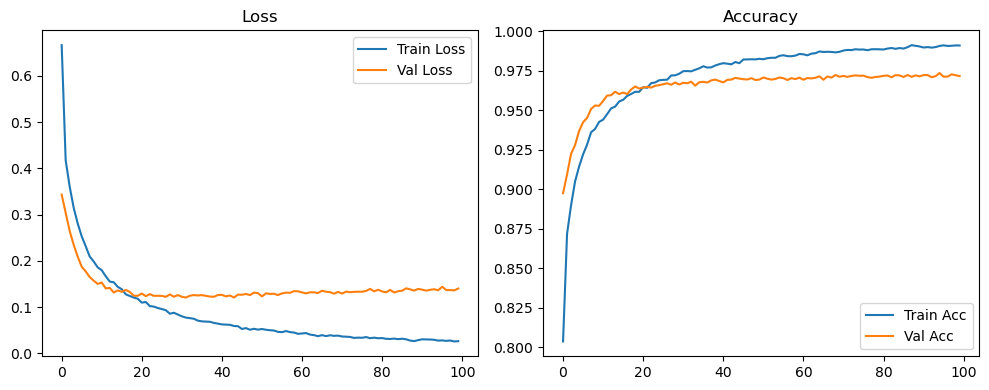

🏆 Best Config: batch64_lr0.01_0.002_0.001_dp0.2 Accuracy: 0.9844


In [8]:
root_path = "MLP_1024_8bit_regular_Sigmoid"

epochs = 100
batch_sizes = [64, 128, 256]
dropout_rates = [0.0, 0.2, 0.5]
lr_pool = [0.01, 0.005, 0.002, 0.001]

Hyperparameter_searching(root_path, epochs, batch_sizes, lr_pool, dropout_rates)